# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [391]:
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

import sqlalchemy as db
from sqlalchemy import create_engine

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn import tree
from catboost import CatBoostRegressor

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data preparation basic
## portfolio

In [392]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [393]:
#Check, if there are any NULL values in Portfolio
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [394]:
portfolio[['id', 'offer_type', 'reward', 'duration', 'difficulty']].drop_duplicates()

id     offer_type  reward  duration  \
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10         7   
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10         5   
2  3f207df678b143eea3cee63160fa8bed  informational       0         4   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5         7   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5        10   
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount       3         7   
6  fafdcd668e3743c1bb461111dcafc2a4       discount       2        10   
7  5a8bc65990b245e5a138643cd4eb9837  informational       0         3   
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo       5         5   
9  2906b810c7d4411798c6938adc9daaa5       discount       2         7   

   difficulty  
0          10  
1          10  
2           0  
3           5  
4          20  
5           7  
6          10  
7           0  
8           5  
9          10

In [395]:
# create dummy columns from channels
def create_channel_dummy(df):
    temp = []
    [temp.extend(x) for x in df.channels]
    channels = set(temp)
    for chnl in channels:
        df[chnl] = [ 1 if (chnl in x) else 0 for x in df.channels]
    return df
portfolio = create_channel_dummy(portfolio)

In [396]:
set(portfolio.offer_type)

{'bogo', 'discount', 'informational'}

In [397]:
# create dummy columns from channels
def get_dummy(df, col, dummy_na = False, drop_col = True):
    new = pd.get_dummies(df[col], dummy_na = dummy_na, prefix = col)
    df = pd.concat([df, new], axis = 1)
    df.drop(columns = col, inplace = drop_col)
    return df
portfolio = get_dummy(portfolio, 'offer_type')
portfolio = get_dummy(portfolio, 'reward', drop_col = False)
portfolio = get_dummy(portfolio, 'difficulty', drop_col = False)

In [398]:
portfolio.head()

reward                      channels  difficulty  duration  \
0      10       [email, mobile, social]          10         7   
1      10  [web, email, mobile, social]          10         5   
2       0          [web, email, mobile]           0         4   
3       5          [web, email, mobile]           5         7   
4       5                  [web, email]          20        10   

                                 id  web  email  social  mobile  \
0  ae264e3637204a6fb9bb56bc8210ddfd    0      1       1       1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0    1      1       1       1   
2  3f207df678b143eea3cee63160fa8bed    1      1       0       1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9    1      1       0       1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7    1      1       0       0   

   offer_type_bogo  ...  reward_0  reward_2  reward_3  reward_5  reward_10  \
0                1  ...         0         0         0         0          1   
1                1  ...         0         0         0         0          1   
2                0  ...         1         0         0         0          0   
3                1  ...         0         0         0         1          0   
4                0  ...         0         0         0         1          0   

   difficulty_0  difficulty_5  difficulty_7  difficulty_10  difficulty_20  
0             0             0             0              1              0  
1             0             0             0              1              0  
2             1             0             0              0              0  
3             0             1             0              0              0  
4             0             0             0              0              1  

[5 rows x 22 columns]

## profile

In [399]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [400]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [401]:
#Look at max age and the amount of customers in those groups
profile.groupby('age', as_index = False)['id'].count().sort_values(by='age', ascending = False).head()

age    id
84  118  2175
83  101     5
82  100    12
81   99     5
80   98     5

In [402]:
profile.groupby('age', as_index = False)['id'].count().sort_values(by='age', ascending = False).tail()

age   id
4   22  131
3   21  140
2   20  135
1   19  135
0   18   70

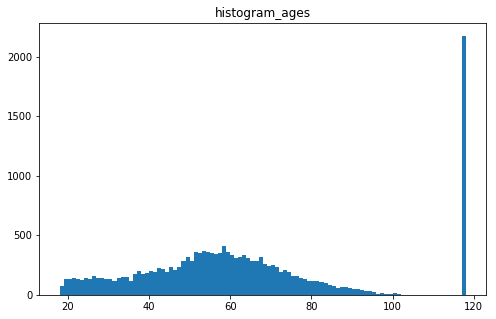

In [403]:
# Age 118 appears very often. It seems to be a technical age, not a real age. I will look into these customers in the next cells
fig, ax = plt.subplots(figsize = (8,5))
plt.hist(profile.age, 100)
plt.title('histogram_ages')
plt.savefig('images/histogram_ages.png');

In [404]:
#Age bucket 118 is missing income and gender. All other ages do not have missing values. 
#I assume that this is due to some privacy reasons (GDPR)
print('age = 118')
print(profile[profile.age==118].info())
print()
print('age != 118')
print(profile[profile.age!=118].info())

age = 118
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      object 
 1   age               2175 non-null   int64  
 2   id                2175 non-null   object 
 3   became_member_on  2175 non-null   int64  
 4   income            0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB
None

age != 118
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object

In [405]:
def k_bin_discretizer(col, df, exclude = True, buckets = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] ):
    """
    Input: col to discretizer, data frame and buckets (with edges)
    Output: datframe with additional discretized column
    """
    df_temp = df.copy()
    df_temp[col + '_bucket'] = ''
    if exclude:
        print(exclude)
        df_temp.loc[df_temp[col]!=118,col + '_bucket'] = pd.qcut(df_temp.loc[df_temp[col]!=118,col], buckets, labels = [i for i in range(0, len(buckets)-1)])
        df_temp.loc[df_temp[col]==118, col + '_bucket'] = 118
    else:
        df_temp = pd.qcut(df_temp[col], buckets, duplicates= 'drop')
    return df_temp
profile = k_bin_discretizer('age', profile, exclude = 118, buckets = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

118


In [406]:
np.unique([datetime.datetime(year=int(str(x)[0:4]), month=int(str(x)[4:6]), day=int(str(x)[6:8])) for x in profile.became_member_on])

array([datetime.datetime(2013, 7, 29, 0, 0),
       datetime.datetime(2013, 7, 30, 0, 0),
       datetime.datetime(2013, 7, 31, 0, 0), ...,
       datetime.datetime(2018, 7, 24, 0, 0),
       datetime.datetime(2018, 7, 25, 0, 0),
       datetime.datetime(2018, 7, 26, 0, 0)], dtype=object)

In [407]:
np.unique(profile.became_member_on)

array([20130729, 20130730, 20130731, ..., 20180724, 20180725, 20180726],
      dtype=int64)

In [408]:
set(profile.age_bucket)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 118}

In [409]:
profile.head()

gender  age                                id  became_member_on    income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN   
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN   
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN   

  age_bucket  
0        118  
1          4  
2        118  
3          8  
4        118

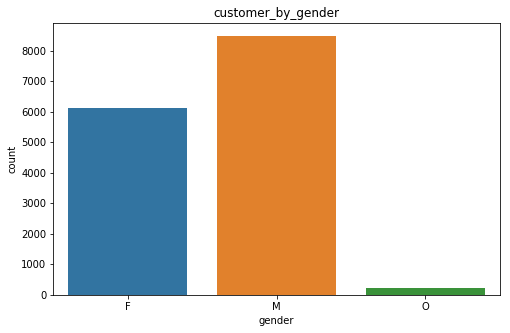

In [410]:
fig, ax = plt.subplots(figsize = (8,5))
plt.title('customer_by_gender')
sns.countplot(data = profile, x = 'gender')
plt.savefig('images/customer_by_gender.png')

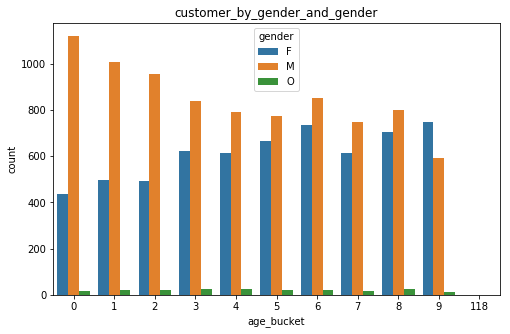

In [411]:
#There are more young male customrs, than young female customers. That trend turns around the older the customer gets
fig, ax = plt.subplots(figsize = (8,5))
plt.title('customer_by_gender_and_gender')
sns.countplot(data = profile, x = 'age_bucket', hue = 'gender')
plt.savefig('images/customer_by_gender_and_gender.png')


In [22]:
#What gender variables are in the data frame?
set(profile.gender)

{'F', 'M', None, 'O'}

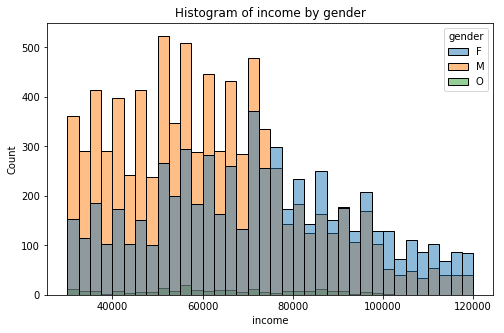

In [412]:
fig, ax = plt.subplots(figsize = (8,5))
plt.title('Histogram of income by gender')
sns.histplot(data=profile, x="income", hue="gender")
plt.savefig('images/hist_by_gender.png')


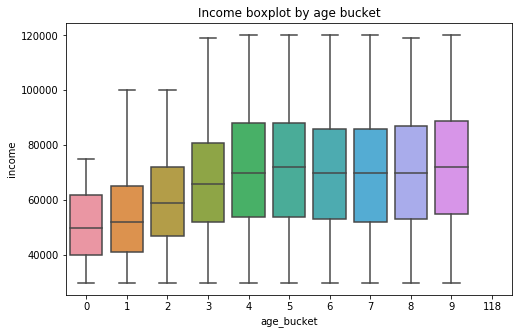

In [413]:
fig, ax = plt.subplots(figsize = (8,5))
plt.title('Income boxplot by age bucket')
sns.boxplot(data=profile, y="income", x="age_bucket")
plt.savefig('images/income_by_age_bucket.png')


## Transcript

In [25]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [26]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [27]:
set(transcript.event)

{'offer completed', 'offer received', 'offer viewed', 'transaction'}

# Data understanding after basic

In [28]:
def merge_trans_portfolio(transcript, portfolio):
    transcript_df = transcript.copy()
    portfolio_df = portfolio.copy()
    
    #To align with duration
    transcript_df.time = transcript_df.time/24
    
    #Create column offer_id and amount based on transcript.value
    #This column contains an id only for none-transactional events
    transcript_df['offer_id'] = [x['offer id'] if ('offer id' in list(x.keys())) else x['offer_id'] if ('offer_id' in list(x.keys())) else None for x in transcript.value]
    transcript_df['amount'] = [x['amount'] if 'amount' in list(x.keys()) else None for x in transcript_df.value]
    transcript_df['reward_from_value'] = [x['reward'] if 'reward' in list(x.keys()) else None for x in transcript_df.value]
    transcript_df = transcript_df.merge(portfolio_df, left_on = 'offer_id', right_on ='id', how = 'left')
    return transcript_df

In [29]:
df = merge_trans_portfolio(transcript, portfolio)

In [30]:
print(profile.id.nunique())
print(transcript.person.nunique())
print(df.person.nunique())

17000
17000
17000


**Not everyone received the same amount of offers. Some people received the same offer several times, while others didn't get an offer at all**

In [31]:
#Each offer was sent to how many unique people?
df[(df.event == 'offer received')].groupby('offer_id')['person'].nunique()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    6374
2298d6c36e964ae4a3e7e9706d1fb8c2    6325
2906b810c7d4411798c6938adc9daaa5    6285
3f207df678b143eea3cee63160fa8bed    6331
4d5c57ea9a6940dd891ad53e9dbe8da0    6330
5a8bc65990b245e5a138643cd4eb9837    6320
9b98b8c7a33c4b65b9aebfe6a799e6d9    6355
ae264e3637204a6fb9bb56bc8210ddfd    6374
f19421c1d4aa40978ebb69ca19b0e20d    6262
fafdcd668e3743c1bb461111dcafc2a4    6332
Name: person, dtype: int64

In [32]:
#Each offer was sent how often?
df[(df.event == 'offer received')].groupby('offer_id')['person'].count()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
3f207df678b143eea3cee63160fa8bed    7617
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
5a8bc65990b245e5a138643cd4eb9837    7618
9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
ae264e3637204a6fb9bb56bc8210ddfd    7658
f19421c1d4aa40978ebb69ca19b0e20d    7571
fafdcd668e3743c1bb461111dcafc2a4    7597
Name: person, dtype: int64

In [33]:
df.columns

Index(['person', 'event', 'value', 'time', 'offer_id', 'amount',
       'reward_from_value', 'reward', 'channels', 'difficulty', 'duration',
       'id', 'web', 'email', 'social', 'mobile', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'reward_0',
       'reward_2', 'reward_3', 'reward_5', 'reward_10', 'difficulty_0',
       'difficulty_5', 'difficulty_7', 'difficulty_10', 'difficulty_20'],
      dtype='object')

**Only 6 people did not receive any offer. This means that I do not have a holdout group to compare against.**

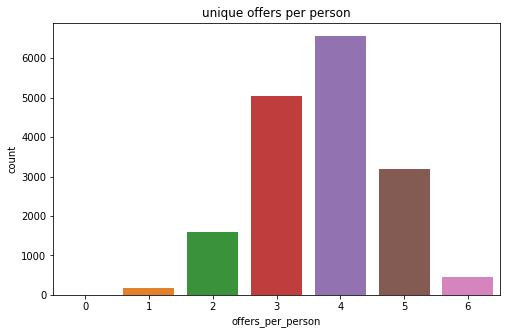

In [414]:
#How many unique offers did a person receive? from 0 to 6
offers_per_person = df.groupby('person', as_index = False)['offer_id'].nunique().sort_values(by = 'offer_id',ascending= False)
offers_per_person = offers_per_person.rename(columns ={'offer_id': 'offers_per_person'}) 
fig, ax = plt.subplots(figsize = (8,5))
plt.title('unique offers per person')
sns.countplot(data = offers_per_person, x='offers_per_person')
ax.set_title('unique offers per person')
plt.savefig('images/unique_offers_per_person.png')



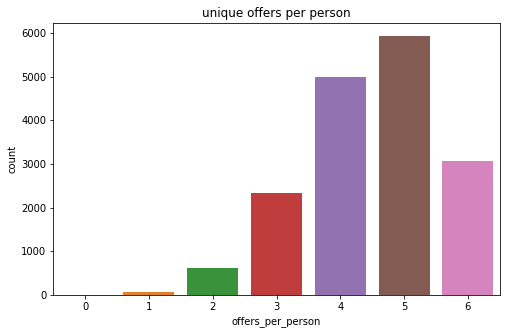

In [415]:
#How many offers did a person receive? from 0 to 6
#df.groupby('key1')['key2'].apply(lambda x: x[x == 'one'].count())
offers_per_person = df.groupby(['person'], as_index = False)['event'].apply(lambda x: x[x == 'offer received'].count()).sort_values(by = 'event',ascending= False)
offers_per_person = offers_per_person.rename(columns ={'event': 'offers_per_person'}) 

fig, ax = plt.subplots(figsize = (8,5))
plt.title('offers per person')
sns.countplot(data = offers_per_person, x='offers_per_person')
ax.set_title('unique offers per person')
plt.savefig('images/offers_per_person.png')

**Also the offers were sent randomly, such that each offer was sent at approx. the same amount per time. This means that it does not makes sense to look at "offer paths". Initially I thought that it might be interesting to look at the order at which a customer received offers. But there are 13727 unique offer paths for 17000 people**

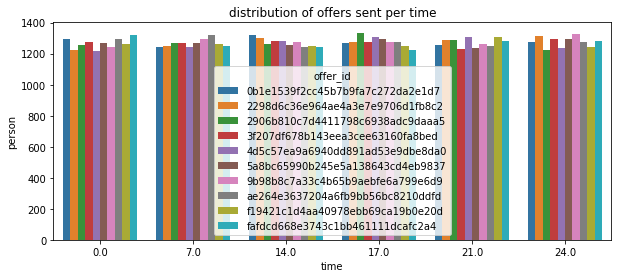

In [416]:
offer_times = df[(df.event == 'offer received')].groupby(['offer_id','time'], as_index = False)['person'].count()
#There are only 6 time slots where an offer was sent. Exactly every week 1
fig, (ax) = plt.subplots(1,1, figsize = (10,4))
plt.title('distribution of offers sent per time')
sns.barplot(data = offer_times, x = 'time', y='person', hue = 'offer_id')
plt.savefig('images/offers_per_time.png')

In [37]:
#Create received_order
paths = df[df.event == 'offer received'].groupby(['person'], as_index = False)['offer_id'].apply(lambda x: ' > '.join(x))
paths = paths.rename(columns = {'offer_id':'path'})
paths.path.nunique()

13727

**Two offers are 'problematic' as they are valid 10 days and not 7 days. This can lead to an overlapping effect. I will map each transaction to an offer. If there are overlapping running offers I will mark that and assign only a shared amount of the transaction value to the offer**

In [38]:
#Two offers are 'problematic' as they are valid 10 days and not 7 days. This can lead to an overlapping effect
df[(df.event == 'offer received')].groupby(['offer_id','duration'])['person'].count()

offer_id                          duration
0b1e1539f2cc45b7b9fa7c272da2e1d7  10.0        7668
2298d6c36e964ae4a3e7e9706d1fb8c2  7.0         7646
2906b810c7d4411798c6938adc9daaa5  7.0         7632
3f207df678b143eea3cee63160fa8bed  4.0         7617
4d5c57ea9a6940dd891ad53e9dbe8da0  5.0         7593
5a8bc65990b245e5a138643cd4eb9837  3.0         7618
9b98b8c7a33c4b65b9aebfe6a799e6d9  7.0         7677
ae264e3637204a6fb9bb56bc8210ddfd  7.0         7658
f19421c1d4aa40978ebb69ca19b0e20d  5.0         7571
fafdcd668e3743c1bb461111dcafc2a4  10.0        7597
Name: person, dtype: int64

# Define cleaning function to get a temporary dataframe. 
## Get temporary dataframe before grouping

**This dataframe will help me to generate one final data frame which contains one row per customer and information about what offer, how many offers and how many active and passive transactions that customer had. It contains the same amount of rows as the original transcript df with additional columns**


**Some definition**
1. I define a transaction or a reward as **active**, if the customer has viewed the offer and if the offer is still valid
2. I define a transaction or a reward as **passive**, if the customer has not viewed the offer and if the offer is still valid

**Basic idea**
I want to know what person gets activated on what offer. I also want to understand how much we loose based on rewards payed to passive transactions. What kind of person gets rewards, but has actually never seen the offers? This is lost money.

**Additional columns of temporary dataframe. For each offer id create the following set of columns**
* **id_start_time** - shows time of offer received from the moment it was received. Consecutive rows have the same number. Once an offer is completed I set this to 500. If the same offer is sent a second time this shows the new start_time
* **id_duration** - As above logic but for the duration
* **id_age** - Age of the offer = time - id_start_time --> Important in order to know if an offer is still valid
* **id_is_valid** - 1 where age <= duration, 0 else
* **id_viewed_time** - shows time of offer viewed from the moment it was viewed. coonsecutive logic is as in id_start_time. This is important to define, if a transaction and a reward was active or passive
* **id_is_active** - id_viewed_time - id_start_time <= id_duration
* **id_active_transaction** - Amount of transaction, if transaction was active = viewed
* **id_passive_transaction** - Amount of transaction, if transaction was passive = not viewed, but valid!
* **social** - 1 if offer was active = viewed and came through Social Media
* **email**  - see above
* **mobile** - see above
* **web** - see above
* **reward_help_column** - reward of completed offer but backfilled to the previous rows
* **id_active_reward** - reward_help_column * id_is_active
* **id_passive_reward** - reward_help_column * (~id_is_active)

**Additional columns (not offer specific)**
* **active_offers_simul** - Sum of active offers at the same time
* **valid_offers_simul** -  Sum of valid offers at the same time
* **independent_transaction** - value of transaction, which was done during a time, where no offer was running

In [39]:
def clean_data_per_offer(transcript_df, offer_id):
    df = transcript_df.copy()
    #Create id_start_time per offer
    mask_id_start_time = (df.event == 'offer received') & (df.offer_id ==offer_id)
    df.loc[mask_id_start_time,'id_start_time_'+ offer_id] = df.loc[mask_id_start_time,'time']
    #Create stopper when offer is completed
    mask_id_completed_time = (df.event == 'offer completed') & (df.offer_id ==offer_id)
    df.loc[mask_id_completed_time,'id_start_time_'+ offer_id] = 500
    df['id_start_time_'+ offer_id] = df.groupby(['person'])['id_start_time_'+ offer_id].apply(lambda x: x.ffill())
    #I actually want the completed offer to be still valid, but I don't have a better solution than htis
    df.loc[mask_id_completed_time,'id_start_time_'+ offer_id] = None
    df['id_start_time_'+ offer_id] = df.groupby(['person'])['id_start_time_'+ offer_id].apply(lambda x: x.ffill())
    
    #Create id_duration per offer
    mask_id_duration = (df.event == 'offer received') & (df.offer_id ==offer_id)
    df.loc[mask_id_duration,'id_duration_'+ offer_id] = df.loc[mask_id_duration,'duration']
    #Create stopper when offer is completed
    mask_id_duration_completed = (df.event == 'offer completed') & (df.offer_id ==offer_id)
    df.loc[mask_id_duration_completed,'id_duration_'+ offer_id] = -1
    df['id_duration_'+ offer_id] = df.groupby(['person'])['id_duration_'+ offer_id].apply(lambda x: x.ffill())
    #I actually want the completed offer to be still active at the completed status, but I don't have a better solution than htis
    df.loc[(df.event == 'offer completed') & (df.offer_id ==offer_id),'id_duration_'+ offer_id] = None
    df['id_duration_'+ offer_id] = df.groupby(['person'])['id_duration_'+ offer_id].apply(lambda x: x.ffill())
    
    
    #Create id_validation per offer based on duration time
    df['id_age_'+ offer_id] = df['time'] -df['id_start_time_'+ offer_id] 
    df['id_is_valid_'+ offer_id] = np.where((df['id_age_'+ offer_id]<=df['id_duration_'+ offer_id]) & ~((df.event =='offer completed') | (df['id_duration_'+ offer_id] ==-1)),1,0)
    
    #Create received_flag
    mask_id_received = (df.event == 'offer received') & (df.offer_id ==offer_id)
    df.loc[mask_id_received,'id_received_'+ offer_id] = 1
    df.loc[~mask_id_received,'id_received_'+ offer_id] = 0
    
    #Create id_is_active per offer based on view time and complete time
    mask_id_viewed = (df.event == 'offer viewed') & (df.offer_id ==offer_id)
    df.loc[mask_id_viewed,'id_viewed_time_'+ offer_id] = df.loc[mask_id_viewed,'time']
    df.loc[(df.event == 'offer received') & (df.offer_id ==offer_id),'id_viewed_time_'+ offer_id] = 1000
    df.loc[(df.event == 'offer completed') & (df.offer_id ==offer_id),'id_viewed_time_'+ offer_id] = 1000
    df['id_viewed_time_'+ offer_id] = df.groupby(['person','id_start_time_'+offer_id])['id_viewed_time_'+ offer_id].apply(lambda x: x.ffill())
    #I actually want the completed offer to be still active at the completed status, but I don't have a better solution than htis
    df.loc[(df.event == 'offer completed') & (df.offer_id ==offer_id),'id_viewed_time_'+ offer_id] = None
    df['id_viewed_time_'+ offer_id] = df.groupby(['person'])['id_viewed_time_'+ offer_id].apply(lambda x: x.ffill())
    
    df['id_is_active_'+ offer_id] =np.where((df['id_viewed_time_'+ offer_id] -df['id_start_time_'+ offer_id])<=df['id_duration_'+ offer_id],1,0)

    #Create id_active_transactions
    mask_id_active_transaction = (df.event == 'transaction') &  (df['id_is_valid_'+ offer_id] ==1)
    df.loc[mask_id_active_transaction,'id_active_transaction_'+ offer_id] = df.loc[mask_id_active_transaction,'amount'] * df.loc[mask_id_active_transaction,'id_is_active_'+ offer_id] 

    #Create id_passive_transactions
    mask_id_passive_transaction = (df.event == 'transaction') & (df['id_is_valid_'+ offer_id] ==1)
    df.loc[mask_id_passive_transaction,'id_passive_transaction_'+ offer_id] = df.loc[mask_id_passive_transaction,'amount']* np.where(df.loc[mask_id_passive_transaction,'id_is_active_'+ offer_id]==1,0,1)
    
    #Get channel for each offer_id if the offer was valid
    mask_id_offer =  (df.offer_id ==offer_id) & (df.event == 'offer received')
    for chnl in ['social','email', 'mobile', 'web']:
        df.loc[mask_id_offer,chnl+'_'+ offer_id] = df.loc[mask_id_offer,chnl]
        df[chnl + '_'+ offer_id] = df.groupby(['person'])[chnl + '_'+ offer_id].apply(lambda x: x.ffill())
        df[chnl + '_'+ offer_id] = df[chnl +'_'+ offer_id] * df['id_is_valid_'+ offer_id]
    
    #Get offer_type for each offer_id if the offer was valid
    mask_id_offer =  (df.offer_id ==offer_id) & (df.event == 'offer received')
    for offer_type in ['offer_type_bogo', 'offer_type_discount', 'offer_type_informational']:
        df.loc[mask_id_offer,offer_type+'_'+ offer_id] = df.loc[mask_id_offer,offer_type]
        df[offer_type + '_'+ offer_id] = df.groupby(['person'])[offer_type + '_'+ offer_id].apply(lambda x: x.ffill())
        df[offer_type + '_'+ offer_id] = df[offer_type +'_'+ offer_id] * df['id_is_valid_'+ offer_id]

    #Get reward_type for each offer_id if the offer was valid
    mask_id_offer =  (df.offer_id ==offer_id) & (df.event == 'offer received')
    for reward_type in ['reward_0', 'reward_2', 'reward_3', 'reward_5', 'reward_10']:
        df.loc[mask_id_offer,reward_type+'_'+ offer_id] = df.loc[mask_id_offer,reward_type]
        df[reward_type + '_'+ offer_id] = df.groupby(['person'])[reward_type + '_'+ offer_id].apply(lambda x: x.ffill())
        df[reward_type + '_'+ offer_id] = df[reward_type +'_'+ offer_id] * df['id_is_valid_'+ offer_id]

    #Get difficulty_type for each offer_id if the offer was valid
    mask_id_offer =  (df.offer_id ==offer_id) & (df.event == 'offer received')
    for diff_type in ['difficulty_0', 'difficulty_5', 'difficulty_7', 'difficulty_10', 'difficulty_20']:
        df.loc[mask_id_offer,diff_type+'_'+ offer_id] = df.loc[mask_id_offer,diff_type]
        df[diff_type + '_'+ offer_id] = df.groupby(['person'])[diff_type + '_'+ offer_id].apply(lambda x: x.ffill())
        df[diff_type + '_'+ offer_id] = df[diff_type +'_'+ offer_id] * df['id_is_valid_'+ offer_id]
        
    #Get active and passive rewards
    mask_id_offer =  (df.offer_id ==offer_id) & (df.event == 'offer completed')
    df['reward_help_column'] = df.groupby(['person'])['reward'].apply(lambda x: x.bfill())
    df.loc[mask_id_offer,'id_active_reward_'+ offer_id] = df.loc[mask_id_offer,'reward_help_column'] * df.loc[mask_id_offer,'id_is_active_'+ offer_id]
    df.loc[mask_id_offer,'id_passive_reward_'+ offer_id] = df.loc[mask_id_offer,'reward_help_column'] * np.where(df.loc[mask_id_offer,'id_is_active_'+ offer_id]==0,1,0)
    
    return df

In [40]:
def get_clean_data(transcript_df):
    df = transcript_df.copy()
    a = transcript_df.offer_id.unique()
    
    for offer_id in a[a != np.array(None)]:
        print(offer_id)
        df = clean_data_per_offer(df, offer_id)
    
    #Get amount of valid offers, which are running at the same time
    df['active_offers_simul'] = df.loc[:,df.columns.str.contains('id_is_active')].sum(axis = 1)
    df['valid_offers_simul'] = df.loc[:,df.columns.str.contains('id_is_valid')].sum(axis = 1)
    df['no_valid_offer_running'] = np.where(df.loc[:,df.columns.str.contains('id_is_valid')].sum(axis = 1)>=1,0,1)
    df['independent_transaction'] = df['amount'] * df['no_valid_offer_running']
    df['passive_sum'] =df.loc[:,df.columns.str.contains('id_passive_transaction_')].sum(axis = 1)/df.loc[:,df.columns.str.contains('id_is_valid_')].sum(axis = 1)
    df['active_sum'] =df.loc[:,df.columns.str.contains('id_active_transaction_')].sum(axis = 1)/df.loc[:,df.columns.str.contains('id_is_valid_')].sum(axis = 1)
    return df

In [41]:
def merge_trans_profile(transcript, profile):
    transcript_df = transcript.copy()
    profile_df = profile.copy()
    transcript_df = transcript_df.merge(profile_df, left_on = 'person', right_on ='id', how = 'left')
    return transcript_df

In [42]:
transcript_df = merge_trans_portfolio(transcript, portfolio)
transcript_df_new = get_clean_data(transcript_df)
transcript_df_final = merge_trans_profile(transcript_df_new, profile)

9b98b8c7a33c4b65b9aebfe6a799e6d9
0b1e1539f2cc45b7b9fa7c272da2e1d7
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
3f207df678b143eea3cee63160fa8bed
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837


In [43]:
transcript_df_final.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}   0.0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   0.0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   0.0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   0.0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}   0.0   

                           offer_id  amount  reward_from_value  reward  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN                NaN     5.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN                NaN     5.0   
2  2906b810c7d4411798c6938adc9daaa5     NaN                NaN     2.0   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN                NaN     2.0   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN                NaN    10.0   

                       channels  difficulty  ...  no_valid_offer_running  \
0          [web, email, mobile]         5.0  ...                       0   
1                  [web, email]        20.0  ...                       0   
2          [web, email, mobile]        10.0  ...                       0   
3  [web, email, mobile, social]        10.0  ...                       0   
4  [web, email, mobile, social]        10.0  ...                       0   

  independent_transaction  passive_sum  active_sum  gender  age  \
0                     NaN          0.0         0.0       F   75   
1                     NaN          0.0         0.0    None  118   
2                     NaN          0.0         0.0       M   68   
3                     NaN          0.0         0.0    None  118   
4                     NaN          0.0         0.0    None  118   

                               id_y  became_member_on    income  age_bucket  
0  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0           8  
1  a03223e636434f42ac4c3df47e8bac43          20170804       NaN         118  
2  e2127556f4f64592b11af22de27a7932          20180426   70000.0           7  
3  8ec6ce2a7e7949b1bf142def7d0e0586          20170925       NaN         118  
4  68617ca6246f4fbc85e91a2a49552598          20171002       NaN         118  

[5 rows x 322 columns]

In [44]:
list(transcript_df_final.columns)

['person',
 'event',
 'value',
 'time',
 'offer_id',
 'amount',
 'reward_from_value',
 'reward',
 'channels',
 'difficulty',
 'duration',
 'id_x',
 'web',
 'email',
 'social',
 'mobile',
 'offer_type_bogo',
 'offer_type_discount',
 'offer_type_informational',
 'reward_0',
 'reward_2',
 'reward_3',
 'reward_5',
 'reward_10',
 'difficulty_0',
 'difficulty_5',
 'difficulty_7',
 'difficulty_10',
 'difficulty_20',
 'id_start_time_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'id_duration_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'id_age_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'id_is_valid_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'id_received_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'id_viewed_time_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'id_is_active_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'id_active_transaction_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'id_passive_transaction_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'social_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'email_9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'mobile_9b98b8c7a33c4b65b9aebfe6a799

### These are some sense checks to make sure that 
1. active transactions + passive transations + independent transactions = total amount of transactions
2. active rewards + passive rewards = total rewards

In [45]:
total_sum = transcript_df_final.amount.sum()
independent_sum = transcript_df_final.independent_transaction.sum()
passive_sum = np.sum(transcript_df_final.loc[:,transcript_df_final.columns.str.contains('id_passive_transaction_')].sum(axis = 1)/transcript_df_final.loc[:,transcript_df_final.columns.str.contains('id_is_valid_')].sum(axis = 1))
active_sum = np.sum(transcript_df_final.loc[:,transcript_df_final.columns.str.contains('id_active_transaction_')].sum(axis = 1)/transcript_df_final.loc[:,transcript_df_final.columns.str.contains('id_is_valid_')].sum(axis = 1))

print('Difference between sum of active + passive + independetn vs total transactions',total_sum - (active_sum + passive_sum + independent_sum))
print('total sum of revenue:', total_sum)
print('active revenue in % of total revenue:', active_sum/total_sum*100)

Difference between sum of active + passive + independetn vs total transactions 2.3283064365386963e-10
total sum of revenue: 1775451.9700000004
active revenue in % of total revenue: 35.445529728035005


In [46]:
total_reward = transcript_df_final[transcript_df_final.event == 'offer completed'].reward.sum()
passive_reward = np.sum(transcript_df_final.loc[:,transcript_df_final.columns.str.contains('id_passive_reward_')].sum(axis = 1))
active_reward = np.sum(transcript_df_final.loc[:,transcript_df_final.columns.str.contains('id_active_reward_')].sum(axis = 1))

print('Difference between sum of active + passive rewards',total_reward - (active_reward + passive_reward))
print('total sum of rewards:', total_reward)
print('rewards in % of revenue:', total_reward/total_sum*100)

Difference between sum of active + passive rewards 0.0
total sum of rewards: 164676.0
rewards in % of revenue: 9.275159383782146


In [47]:
#Make sure that the number of rows stayed the same after transformation
print(transcript_df.shape)
print(transcript_df_final.shape)

(306534, 29)
(306534, 322)


## Create 2 dataframe2 for machine learning

### What is the best format?

**I decided to try two different data structures for the final prediction**
TheY contain almost the same information, but have different dimensions. The first option has far more columns as I create a dummy variable for each offer id. In the second approach I have only one column for each feature but I have more rows, because each offer per person gets a row

**grouping by person and by offer id**
* Grouped output contains rewards, offer_type, passive_transactions, active_transactions, reward_types,channel_types 
on an aggregated level per customer
* **Advantage**: Algorithm can predict each offer per person separetaly
* **Disadvantage**: I am loosing information about what combination of offers was sent to the customer overall

**grouping by person**
* Grouped output contains rewards, offer_type, passive_transactions, active_transactions, reward_types,channle_types 
    on an aggregated level per customer. Many columns appear 10 times as they are specific to the offer
* **Advantage:** This way the algorithm can learn about the impact of the combinationa and amount of orders sent during the 30 day period
* **Disadvantage**: I am loosing information about when and in which order an offer was sent to a person




In [119]:
def transform_by_person_offer(transcript_df_final):
    """
    Takes temporary/help dataframe and performs grouping by person adn by offer id 
    Input: temporary/help dataframe
    Output: Grouped output contains rewards, offer_type, passive_transactions, active_transactions, reward_types,channle_types 
    on an aggregated level per customer
    Advantage: Algorithm can predict each offer per person separetaly
    Disadvantage: I am loosing information about what combination of offers was sent to the customer overall
    """
    df = transcript_df_final.copy()
    final_df=pd.DataFrame(columns = ['person', 'offer_id', 'valid_offers_simul', 'gender', 'age_bucket',
       'became_member_on', 'income', 'independent_transaction', 'start_time', 'offer_received',
       'active_transaction', 'passive_transaction', 'social', 'email',
       'mobile', 'web', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'active_reward', 'passive_reward'])
    offers = ['9b98b8c7a33c4b65b9aebfe6a799e6d9','0b1e1539f2cc45b7b9fa7c272da2e1d7',
              '2906b810c7d4411798c6938adc9daaa5','fafdcd668e3743c1bb461111dcafc2a4',
              '4d5c57ea9a6940dd891ad53e9dbe8da0','f19421c1d4aa40978ebb69ca19b0e20d',
              '2298d6c36e964ae4a3e7e9706d1fb8c2','3f207df678b143eea3cee63160fa8bed',
              'ae264e3637204a6fb9bb56bc8210ddfd','5a8bc65990b245e5a138643cd4eb9837']
    for offer_id in offers:
        grouping_dict ={}
        grouping_temp = {'id_received_' + offer_id:'sum',
                         'id_active_transaction_' + offer_id:'sum', 
                         'id_passive_transaction_' + offer_id:'sum',
                         'social_' + offer_id:'max',
                         'email_' + offer_id:'max',
                         'mobile_' + offer_id:'max',
                         'web_' + offer_id:'max',
                         'reward_0_'+offer_id:'max',
                         'reward_2_'+offer_id:'max',
                         'reward_3_'+offer_id:'max',
                         'reward_5_'+offer_id:'max',
                         'reward_10_'+offer_id:'max',
                         'difficulty_0_'+offer_id:'max',
                         'difficulty_5_'+offer_id:'max',
                         'difficulty_7_'+offer_id:'max',
                         'difficulty_10_'+offer_id:'max',
                         'difficulty_20_'+offer_id:'max',
                         'offer_type_bogo_' + offer_id:'max',
                         'offer_type_discount_' + offer_id:'max',
                         'offer_type_informational_' + offer_id:'max',
                         'id_active_reward_' + offer_id:'sum',
                         'id_passive_reward_' + offer_id:'sum',
                         'id_start_time_' + offer_id:'min',
                         'valid_offers_simul':'max'
                     }
        grouping_dict.update(grouping_temp) 
    
        total = {'gender':'first', 
        'age_bucket': 'first',
        'became_member_on': 'first', 
        'income': 'max',
        'independent_transaction':'sum',}
        grouping_dict.update(total)
        df['active_offers'] =np.where(df.valid_offers_simul>0,transcript_df_final.valid_offers_simul,1)
        df['id_active_transaction_'+offer_id] =df['id_active_transaction_'+offer_id]/df['active_offers']
        df['id_passive_transaction_'+offer_id] =df['id_passive_transaction_'+offer_id]/df['active_offers']
        df['id_active_reward_'+offer_id] =df['id_active_reward_'+offer_id]/df['active_offers']
        df['id_passive_reward_'+offer_id] =df['id_passive_reward_'+offer_id]/df['active_offers']
        grouping_temp = df.groupby(['person','id_start_time_' +offer_id], as_index = False).agg(grouping_dict)
        grouping_temp['offer_id'] = offer_id
        grouping_temp['start_time'] =grouping_temp['id_start_time_'+offer_id]
        grouping_temp['offer_received'] =grouping_temp['id_received_'+offer_id]
        grouping_temp['active_sum'] =grouping_temp['id_active_transaction_'+offer_id]
        grouping_temp['passive_sum'] =grouping_temp['id_passive_transaction_'+offer_id]

        grouping_temp['social'] =grouping_temp['social_'+offer_id]
        grouping_temp['email'] =grouping_temp['email_'+offer_id]
        grouping_temp['mobile'] =grouping_temp['mobile_'+offer_id]
        grouping_temp['web'] =grouping_temp['web_'+offer_id]
        grouping_temp['offer_type_bogo'] =grouping_temp['offer_type_bogo_'+offer_id]
        grouping_temp['offer_type_discount'] =grouping_temp['offer_type_discount_'+offer_id]
        grouping_temp['offer_type_informational'] =grouping_temp['offer_type_informational_'+offer_id]
        grouping_temp['active_reward_amount'] =grouping_temp['id_active_reward_'+offer_id]
        grouping_temp['passive_reward_amount'] =grouping_temp['id_passive_reward_'+offer_id]
        grouping_temp['reward_0_count'] = grouping_temp['reward_0_'+offer_id]
        grouping_temp['reward_2_count'] = grouping_temp['reward_2_'+offer_id]
        grouping_temp['reward_3_count'] = grouping_temp['reward_3_'+offer_id]
        grouping_temp['reward_5_count'] = grouping_temp['reward_5_'+offer_id]
        grouping_temp['reward_10_count'] = grouping_temp['reward_10_'+offer_id]
        grouping_temp['difficulty_0_count'] = grouping_temp['difficulty_0_'+offer_id]
        grouping_temp['difficulty_5_count'] = grouping_temp['difficulty_5_'+offer_id]
        grouping_temp['difficulty_7_count'] = grouping_temp['difficulty_7_'+offer_id]
        grouping_temp['difficulty_10_count'] = grouping_temp['difficulty_10_'+offer_id]
        grouping_temp['difficulty_20_count'] = grouping_temp['difficulty_20_'+offer_id]
        grouping_temp = grouping_temp.drop(columns = ['id_start_time_'+offer_id
                                                  , 'id_received_'+offer_id
                                                  ,'id_active_transaction_'+offer_id
                                                 ,'id_passive_transaction_'+offer_id
                                                 ,'social_'+offer_id
                                                 ,'email_'+offer_id
                                                 ,'mobile_'+offer_id
                                                 ,'web_'+offer_id
                                                 ,'offer_type_bogo_'+offer_id
                                                 ,'offer_type_discount_'+offer_id
                                                 ,'offer_type_informational_'+offer_id
                                                 ,'id_active_reward_'+offer_id
                                                 ,'id_passive_reward_'+offer_id
                                                 ,'reward_0_'+offer_id
                                                ,'reward_2_'+offer_id
                                                ,'reward_3_'+offer_id
                                                ,'reward_5_'+offer_id
                                                ,'reward_10_'+offer_id
                                                ,'difficulty_0_'+offer_id
                                                ,'difficulty_5_'+offer_id
                                                ,'difficulty_7_'+offer_id
                                                ,'difficulty_10_'+offer_id
                                                ,'difficulty_20_'+offer_id])
        final_df = final_df.append(grouping_temp)
        
    return final_df


In [264]:
def transform_by_person():
    """
     Takes temprary/help dataframe and performs grouping by person
    Input: temprary/help dtaframe
    Output: Grouped output contains rewards, offer_type, passive_transactions, active_transactions, reward_types,channle_types 
    on an aggregated level per customer. Many columns appear 10 times as they are specific to the offer
    Advantage: This way the algorithm can learn about the impact of the combinationa and amount of orders sent during the 30 day period
    Disadvantage: I am loosing information about when and in which order an offer was sent to a person
    """
    grouping_dict = {}
    a = transcript_df.offer_id.unique()
    for offer_id in a[a != np.array(None)]:
        grouping_temp = {'id_received_' + offer_id:'sum',
                         'id_active_transaction_' + offer_id:'sum', 
                         'id_passive_transaction_' + offer_id:'sum',
                         'social_' + offer_id:'max',
                         'email_' + offer_id:'max',
                         'mobile_' + offer_id:'max',
                         'web_' + offer_id:'max',
                         'reward_0_'+offer_id:'max',
                         'reward_2_'+offer_id:'max',
                         'reward_3_'+offer_id:'max',
                         'reward_5_'+offer_id:'max',
                         'reward_10_'+offer_id:'max',
                         'difficulty_0_'+offer_id:'max',
                         'difficulty_5_'+offer_id:'max',
                         'difficulty_7_'+offer_id:'max',
                         'difficulty_10_'+offer_id:'max',
                         'difficulty_20_'+offer_id:'max',
                         'offer_type_bogo_' + offer_id:'max',
                         'offer_type_discount_' + offer_id:'max',
                         'offer_type_informational_' + offer_id:'max',
                         'id_active_reward_' + offer_id:'sum',
                         'id_passive_reward_' + offer_id:'sum',
                         'id_start_time_' + offer_id:'min',
                         }
        grouping_dict.update(grouping_temp) 
    
    total = {'gender':'first', 
        'age_bucket': 'first',
        'became_member_on': 'first', 
        'income': 'max',
        'independent_transaction':'sum',
        'passive_sum': 'sum',
        'active_sum': 'sum',}
    grouping_dict.update(total)
    grouping_by_person = transcript_df_final.groupby('person', as_index = False).agg(grouping_dict)

    for feat in ['email_','web_','mobile_','social_','bogo_','discount_','informational_','passive_reward_', 'active_reward_', 'reward_0_', 'reward_2_', 'reward_3_', 'reward_5_', 'reward_10_','difficulty_0_', 'difficulty_5_', 'difficulty_7_', 'difficulty_10_', 'difficulty_20_']:
        grouping_by_person[feat+ 'count'] = grouping_by_person.loc[:,grouping_by_person.columns.str.contains(feat)].sum(axis = 1)

    grouping_by_person =grouping_by_person.rename(columns = {'passive_reward_count':'passive_reward_amount','active_reward_count':'active_reward_amount'})    
    
    return grouping_by_person

# ETL Pipeline

## Define target variables for machine learning

**Target: There are different ways to phrase the problem. I will try to minimize the passive_rewards and find the customers with the highest and lowest amount of passive rewards**


This way I am taking into account if one particular offer was sent, but other than that I am looking at the effect of the combination of the offers rather than one particular offer.
The reason I do that is because I cannot run a proper A/B test on single offers.

In [265]:
def get_final_training_df(df, group_by = ['person']):
    df_final = df.copy()
    #fill na values where

    fill_columns = 'social_|email_|mobile|web_|bogo_|discount_|informational_|reward_'
    df_final[df_final.columns[df_final.columns.str.contains(fill_columns)]] = df_final[df_final.columns[df_final.columns.str.contains(fill_columns)]].fillna(0)
    fill_columns = 'id_start_time_'
    df_final[df_final.columns[df_final.columns.str.contains(fill_columns)]] = df_final[df_final.columns[df_final.columns.str.contains(fill_columns)]].fillna(-1)

    features_received = list(df_final.columns[df_final.columns.str.contains('id_received_|id_start_time_')])
    features_count = list(df_final.columns[df_final.columns.str.contains('_count')])
    features_person = list(['gender', 'income','age_bucket','became_member_on'])
    target = list(['independent_transaction', 'passive_sum', 'active_sum', 'active_reward_amount', 'passive_reward_amount'])
    features_received.extend(features_count)
    features_received.extend(features_person)
    features_received.extend(target)
    features_received.extend(['person'])

    if 'offer_id' in group_by:
        df_final = get_dummy(df_final, 'offer_id', dummy_na = False, drop_col = False)
        features_received.extend(['offer_id'])
        
  
    #Create dummy variables

    df_final = get_dummy(df_final[features_received], 'gender', dummy_na = True, drop_col = False)
    df_final = get_dummy(df_final, 'age_bucket', drop_col = False)

    df_final['income_bucket'] = k_bin_discretizer('income', df_final, exclude = False,buckets = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    #df_final.drop(columns = 'income', inplace = True)
    df_final = get_dummy(df_final, 'income_bucket', dummy_na = True)
    df_final['membership_start_year'] = [str(x)[0:4] for x in df_final.became_member_on]
    #df_final.drop(columns = 'became_member_on', inplace = True)
    df_final = get_dummy(df_final, 'membership_start_year')

    #Create target variable  
    df_final['has_passive_reward'] = np.where(df_final['passive_reward_amount']>0,1,0)
    df_final['has_active_reward'] = np.where(df_final['active_reward_amount']>0,1,0)
    df_final['has_reward'] = np.where((df_final['passive_reward_amount'] + df_final['active_reward_amount'])>0,1,0)
    

    return df_final

In [266]:
def store_data(filename, df):
    df_store = df.copy()
    engine = create_engine('sqlite:///'+filename+'.db')
    df_store.to_sql(filename, engine, index=False, if_exists='replace')

#### Grouping by person

In [267]:
grouping_person = transform_by_person()
grouping_person_final = get_final_training_df(grouping_person)

store_data('StarbucksCleanedDataPerson', grouping_person_final)
print(grouping_person_final.shape)

(17000, 82)


#### Grouping by person by offer_id

In [268]:
grouping_person_offer = transform_by_person_offer(transcript_df_final)
grouping_person_offer_final = get_final_training_df(grouping_person_offer,group_by =['person', 'offer_id'])

store_data('StarbucksCleanedDataPersonOffer', grouping_person_offer_final)
print(grouping_person_offer_final.shape)

(103221, 56)


In [269]:
grouping_person_final.iloc[:,grouping_person_final.columns.str.contains('reward_0|person')]

reward_0_count                            person
0                 2.0  0009655768c64bdeb2e877511632db8f
1                 0.0  00116118485d4dfda04fdbaba9a87b5c
2                 2.0  0011e0d4e6b944f998e987f904e8c1e5
3                 1.0  0020c2b971eb4e9188eac86d93036a77
4                 1.0  0020ccbbb6d84e358d3414a3ff76cffd
...               ...                               ...
16995             1.0  fff3ba4757bd42088c044ca26d73817a
16996             0.0  fff7576017104bcc8677a8d63322b5e1
16997             1.0  fff8957ea8b240a6b5e634b6ee8eafcf
16998             1.0  fffad4f4828548d1b5583907f2e9906b
16999             0.0  ffff82501cea40309d5fdd7edcca4a07

[17000 rows x 2 columns]

In [270]:
transcript_df_final[transcript_df_final.person == '0011e0d4e6b944f998e987f904e8c1e5'].iloc[:,transcript_df_final.columns.str.contains('reward_0|person')].max()

person                                                0011e0d4e6b944f998e987f904e8c1e5
reward_0                                                                           1.0
reward_0_9b98b8c7a33c4b65b9aebfe6a799e6d9                                          0.0
reward_0_0b1e1539f2cc45b7b9fa7c272da2e1d7                                          0.0
id_active_reward_0b1e1539f2cc45b7b9fa7c272da2e1d7                                  5.0
id_passive_reward_0b1e1539f2cc45b7b9fa7c272da2e1d7                                 0.0
reward_0_2906b810c7d4411798c6938adc9daaa5                                          NaN
reward_0_fafdcd668e3743c1bb461111dcafc2a4                                          NaN
reward_0_4d5c57ea9a6940dd891ad53e9dbe8da0                                          NaN
reward_0_f19421c1d4aa40978ebb69ca19b0e20d                                          NaN
reward_0_2298d6c36e964ae4a3e7e9706d1fb8c2                                          0.0
reward_0_3f207df678b143eea3cee63160fa8bed  

# ML Pipeline

In [271]:
def load_data(filename, train_features, target_features):
    """
    Load Data from database
    Split into Features X and Target Y (Last 36 columns)
    """
    engine = create_engine('sqlite:///' + filename+'.db')
    df = pd.read_sql_table(filename, engine)

    Y = df.loc[:,target_features]
    X = df.loc[:,train_features]
   
    return X, Y


In [319]:
def build_model_Regression(X, model = 'RandomForestRegressor'):
    """Create pipeline with CountVectorizer, TfidfTransformer, MultioutputClassifier and RandomForestClassifier"""
    if model == 'DecisionTreeRegressor':
        parameters = {
            #RegressionTree
            'clf__max_features': [None, 20, 10],
            'clf__min_samples_leaf': [int(X.shape[0]*0.05),1000,100],
            'clf__criterion': ['mse', 'friedman_mse'],
            'clf__max_depth': [3,5,10],
        }
        pipeline = Pipeline([
            ('clf', DecisionTreeRegressor(random_state=42 ))
        #('clf', RandomForestRegressor(random_state=42 ))
        ])
    elif model == 'RandomForestRegressor':
        parameters = {
            'clf__max_features': [None, 20, 10],
            'clf__min_samples_leaf': [int(X.shape[0]*0.05),1000,100],
            'clf__criterion': ['mse', 'friedman_mse'],
            'clf__max_depth': [3,5,10],
            'clf__ccp_alpha': [0],

        }
        pipeline = Pipeline([
            ('clf', RandomForestRegressor(random_state=42 ))
        ])
    else:
        print('No model selected')
    #print(pipeline.get_params())
    cv = GridSearchCV(pipeline, parameters)
    return cv

In [320]:
def build_model_Classification(X, model = ''):
    """Create pipeline with CountVectorizer, TfidfTransformer, MultioutputClassifier and RandomForestClassifier"""
    parameters = {
        #RegressionTree
       #'clf__criterion': ['gini','entropy'],
        'clf__max_depth': [None,3,10], 
        #'clf__max_features': [X.shape[1],5, 10], 
        'clf__min_samples_leaf': [1,int(len(X)*0.05),1000] ,
        #'clf__min_samples_split': 2, 
        #'clf__min_weight_fraction_leaf': 0.0, 
        'clf__n_estimators': [100,10,50]

    }
    
    print('generating pipeline')
    pipeline = Pipeline([
        ('clf', RandomForestClassifier(random_state=42 ))
    ])

    #print(pipeline.get_params())
    cv = GridSearchCV(pipeline, parameters)
    return cv

In [321]:
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    print('R^2 Sscore of model: ', r2_score(Y_test, Y_pred))

    
    return Y_pred

In [322]:
def main(filename):
    
    X, Y = load_data(filename)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
        
    print('Building model...')
    model = build_model_Regression(X_train)
        
    print('Training model...')
    model.fit(X_train, Y_train)
        
    print('Evaluating model...')
    evaluate_model(model, X_test, Y_test)

    #print('Saving model...\n    MODEL: {}'.format(filename))
    #save_model(model, model_filepath)

    #print('Trained model saved!')


In [ ]:
train_features =['id_received_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'id_start_time_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'id_received_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'id_start_time_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'id_received_2906b810c7d4411798c6938adc9daaa5',
       'id_start_time_2906b810c7d4411798c6938adc9daaa5',
       'id_received_fafdcd668e3743c1bb461111dcafc2a4',
       'id_start_time_fafdcd668e3743c1bb461111dcafc2a4',
       'id_received_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'id_start_time_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'id_received_f19421c1d4aa40978ebb69ca19b0e20d',
       'id_start_time_f19421c1d4aa40978ebb69ca19b0e20d',
       'id_received_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'id_start_time_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'id_received_3f207df678b143eea3cee63160fa8bed',
       'id_start_time_3f207df678b143eea3cee63160fa8bed',
       'id_received_ae264e3637204a6fb9bb56bc8210ddfd',
       'id_start_time_ae264e3637204a6fb9bb56bc8210ddfd',
       'id_received_5a8bc65990b245e5a138643cd4eb9837',
       'id_start_time_5a8bc65990b245e5a138643cd4eb9837', 'email_count',
       'web_count', 'mobile_count', 'social_count', 'bogo_count',
       'discount_count', 'informational_count', 'reward_0_count',
       'reward_2_count', 'reward_3_count', 'reward_5_count', 'reward_10_count',
       'gender_F', 'gender_M',
       'gender_O', 'gender_nan', 'age_bucket_0', 'age_bucket_1',
       'age_bucket_2', 'age_bucket_3', 'age_bucket_4', 'age_bucket_5',
       'age_bucket_6', 'age_bucket_7', 'age_bucket_8', 'age_bucket_9',
       'age_bucket_118', 
        'difficulty_0_count','difficulty_5_count','difficulty_7_count','difficulty_10_count','difficulty_20_count',
       'income_bucket_(29999.999, 37000.0]',
       'income_bucket_(37000.0, 45000.0]', 'income_bucket_(45000.0, 52000.0]',
       'income_bucket_(52000.0, 57000.0]', 'income_bucket_(57000.0, 64000.0]',
       'income_bucket_(64000.0, 70000.0]', 'income_bucket_(70000.0, 75000.0]',
       'income_bucket_(75000.0, 85000.0]', 'income_bucket_(85000.0, 96000.0]',
       'income_bucket_(96000.0, 120000.0]', 'income_bucket_nan',
       'membership_start_year_2013', 'membership_start_year_2014',
       'membership_start_year_2015', 'membership_start_year_2016',
       'membership_start_year_2017', 'membership_start_year_2018']

target_features = ['has_passive_reward', 'has_active_reward', 'has_reward','independent_transaction', 'passive_sum', 'active_sum',
       'active_reward_amount', 'passive_reward_amount']

In [380]:
def train_evaluate_intermediate_step(  train_features, target_features,help_steps, final, DataBaseName, model = 'RandomForestRegressor'):
    """
    This function predicts help columns inbetween in order to predict the final passive_reward_amount
    """
    X, Y= load_data(DataBaseName,  train_features, target_features)
    features = help_steps + [final]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y[features], test_size=0.3)
    
    for feat in help_steps:
        print('Predict classify help columns',feat)
        clf = build_model_Classification(X_train)
        clf.fit(X_train, Y_train[feat])       
        print(clf.best_params_)
        
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        print(classification_report(Y_test[feat], y_pred_test))

        X_train = pd.concat([X_train.reset_index(), pd.DataFrame(y_pred_train,columns=['clf_' + feat])], axis = 1)
        X_train.drop(columns = 'index', inplace = True)
        X_test = pd.concat([X_test.reset_index(), pd.DataFrame(y_pred_test,columns=['clf_' + feat])], axis = 1)
        X_test.drop(columns = 'index', inplace = True)

    regr = build_model_Regression(X_train, model = model)
    regr.fit(X_train, Y_train[final])
    print(regr.best_params_)
    evaluate_model(regr, X_test, Y_test[final])
    return regr

In [381]:
def train_evaluate(train_features, target_features, DataBaseName, model = 'RandomForestRegressor'):
    """Function predicts and evaluates target feature immediatley"""
    
    target_features_final = [target_features] if type(target_features) is str else target_features
    
    print('Regression prediction ', target_features_final)
    X, Y= load_data(DataBaseName, train_features, target_features_final)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y[target_features], test_size=0.2)
    regr = build_model_Regression(X_train, model = model)
    regr.fit(X_train, Y_train)
    print(regr.best_params_)
    
    evaluate_model(regr, X_test, Y_test)
    return regr

In [382]:
train_evaluate(train_features, 'passive_reward_amount', 'StarbucksCleanedDataPerson', model = 'RandomForestRegressor')

Regression prediction  ['passive_reward_amount']


KeyboardInterrupt: 

In [ ]:
train_evaluate(train_features, 'passive_reward_amount', 'StarbucksCleanedDataPerson', model = 'DecisionTreeRegressor')

**One interesting finding is that customers whose age is unknown == 118 and whose features are also unknown (like gender and income) have the lowest passive rewards**

In [364]:
TREE_PARAS = {'criterion': 'mse', 
             'max_depth': 5, 
            'max_features': None, 
            'min_samples_leaf': 100}
dtr = DecisionTreeRegressor(**TREE_PARAS)
X, Y= load_data('StarbucksCleanedDataPerson', train_features, 'passive_reward_amount')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
dtr.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=100)

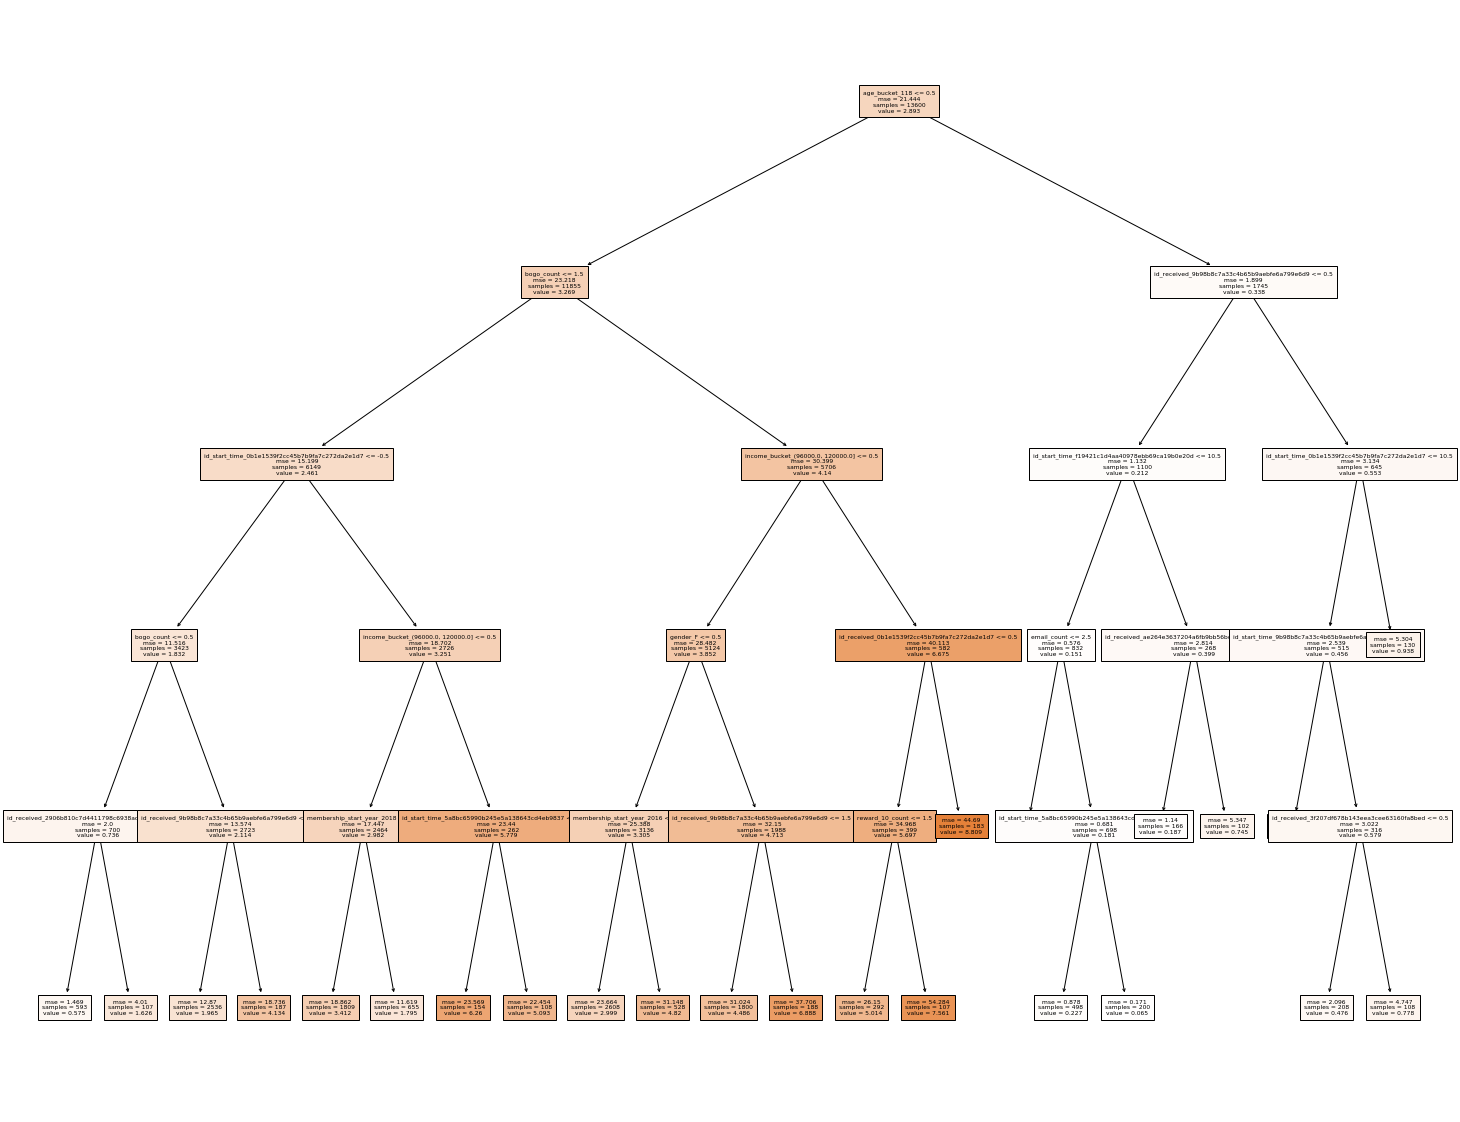

In [365]:
fig = plt.subplots(figsize = (25,20))
plt.title('DecisionTreeRegressor on grouped datat by person and by offer')
tree.plot_tree(dtr, filled=True, feature_names=train_features, fontsize = 6)
plt.savefig('RegressionPerson.png', dpi=100)

In [366]:
print(tree.export_text(dtr,feature_names=train_features ))

|--- age_bucket_118 <= 0.50
|   |--- bogo_count <= 1.50
|   |   |--- id_start_time_0b1e1539f2cc45b7b9fa7c272da2e1d7 <= -0.50
|   |   |   |--- bogo_count <= 0.50
|   |   |   |   |--- id_received_2906b810c7d4411798c6938adc9daaa5 <= 1.50
|   |   |   |   |   |--- value: [0.58]
|   |   |   |   |--- id_received_2906b810c7d4411798c6938adc9daaa5 >  1.50
|   |   |   |   |   |--- value: [1.63]
|   |   |   |--- bogo_count >  0.50
|   |   |   |   |--- id_received_9b98b8c7a33c4b65b9aebfe6a799e6d9 <= 1.50
|   |   |   |   |   |--- value: [1.96]
|   |   |   |   |--- id_received_9b98b8c7a33c4b65b9aebfe6a799e6d9 >  1.50
|   |   |   |   |   |--- value: [4.13]
|   |   |--- id_start_time_0b1e1539f2cc45b7b9fa7c272da2e1d7 >  -0.50
|   |   |   |--- income_bucket_(96000.0, 120000.0] <= 0.50
|   |   |   |   |--- membership_start_year_2018 <= 0.50
|   |   |   |   |   |--- value: [3.41]
|   |   |   |   |--- membership_start_year_2018 >  0.50
|   |   |   |   |   |--- value: [1.80]
|   |   |   |--- income_bucket_(9

### Try to  improve the model by predicitng intermediate steps and by using them as new features

In [ ]:
help_steps = ['has_reward', 'has_passive_reward']
final = 'passive_reward_amount'
train_evaluate_intermediate_step(train_features, target_features,help_steps, final,'StarbucksCleanedDataPerson', model = 'RandomForestRegressor')

In [ ]:
help_steps = ['has_reward', 'has_active_reward']
final = 'passive_reward_amount'
train_evaluate_intermediate_step(train_features, target_features,help_steps, final,'StarbucksCleanedDataPerson', model = 'RandomForestRegressor')

In [ ]:
#Should I create a dummy with offer id?
train_features =['reward_0_count', 'reward_2_count', 'reward_3_count', 'reward_5_count','reward_10_count', 'gender_F',
               'gender_M', 'gender_O', 'gender_nan', 'age_bucket_0', 'age_bucket_1',
               'age_bucket_2', 'age_bucket_3', 'age_bucket_4', 'age_bucket_5',
                 'age_bucket_6', 'age_bucket_7', 'age_bucket_8', 'age_bucket_9',
                 'age_bucket_118',
                 'income_bucket_(29999.999, 38000.0]',
                 'income_bucket_(38000.0, 46000.0]',
                 'income_bucket_(46000.0, 53000.0]','income_bucket_(53000.0, 59000.0]',
                 'income_bucket_(59000.0, 65000.0]','income_bucket_(65000.0, 71000.0]',
                 'income_bucket_(71000.0, 77000.0]',
                 'income_bucket_(77000.0, 86000.0]',
                 'income_bucket_(86000.0, 97000.0]',
                'income_bucket_(97000.0, 120000.0]', 'income_bucket_nan',
               'difficulty_0_count','difficulty_5_count','difficulty_7_count','difficulty_10_count','difficulty_20_count',
               'membership_start_year_2013', 'membership_start_year_2014',
               'membership_start_year_2015', 'membership_start_year_2016',
               'membership_start_year_2017', 'membership_start_year_2018']

target_features = ['passive_sum', 'active_sum',
       'active_reward_amount', 'passive_reward_amount',
       'has_passive_reward', 'has_active_reward', 'has_reward']

In [ ]:
help_steps = ['has_reward', 'has_passive_reward']
final = 'passive_reward_amount'
train_evaluate_intermediate_step(train_features, target_features,help_steps, final, 'StarbucksCleanedDataPersonOffer', model = 'RandomForestRegressor')

In [ ]:
help_steps = ['has_reward', 'has_active_reward']
final = 'passive_reward_amount'
train_evaluate_intermediate_step(train_features, target_features,help_steps, final, 'StarbucksCleanedDataPersonOffer', model = 'RandomForestRegressor')

In [325]:
train_evaluate(train_features, 'passive_reward_amount', 'StarbucksCleanedDataPersonOffer', model = 'DecisionTreeRegressor')

Regression prediction  ['passive_reward_amount']
{'clf__criterion': 'mse', 'clf__max_depth': 10, 'clf__max_features': None, 'clf__min_samples_leaf': 100}
R^2 Sscore of model:  0.13555984104655905


GridSearchCV(estimator=Pipeline(steps=[('clf',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'clf__criterion': ['mse', 'friedman_mse'],
                         'clf__max_depth': [3, 5, 10],
                         'clf__max_features': [None, 20, 10],
                         'clf__min_samples_leaf': [4128, 1000, 100]})

In [372]:
TREE_PARAS = {'criterion': 'mse', 
             'max_depth': 5, 
            'max_features': None, 
            'min_samples_leaf': 100}
dtree = DecisionTreeRegressor(**TREE_PARAS)
X, Y= load_data('StarbucksCleanedDataPersonOffer', train_features, 'passive_reward_amount')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
dtree.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=100)

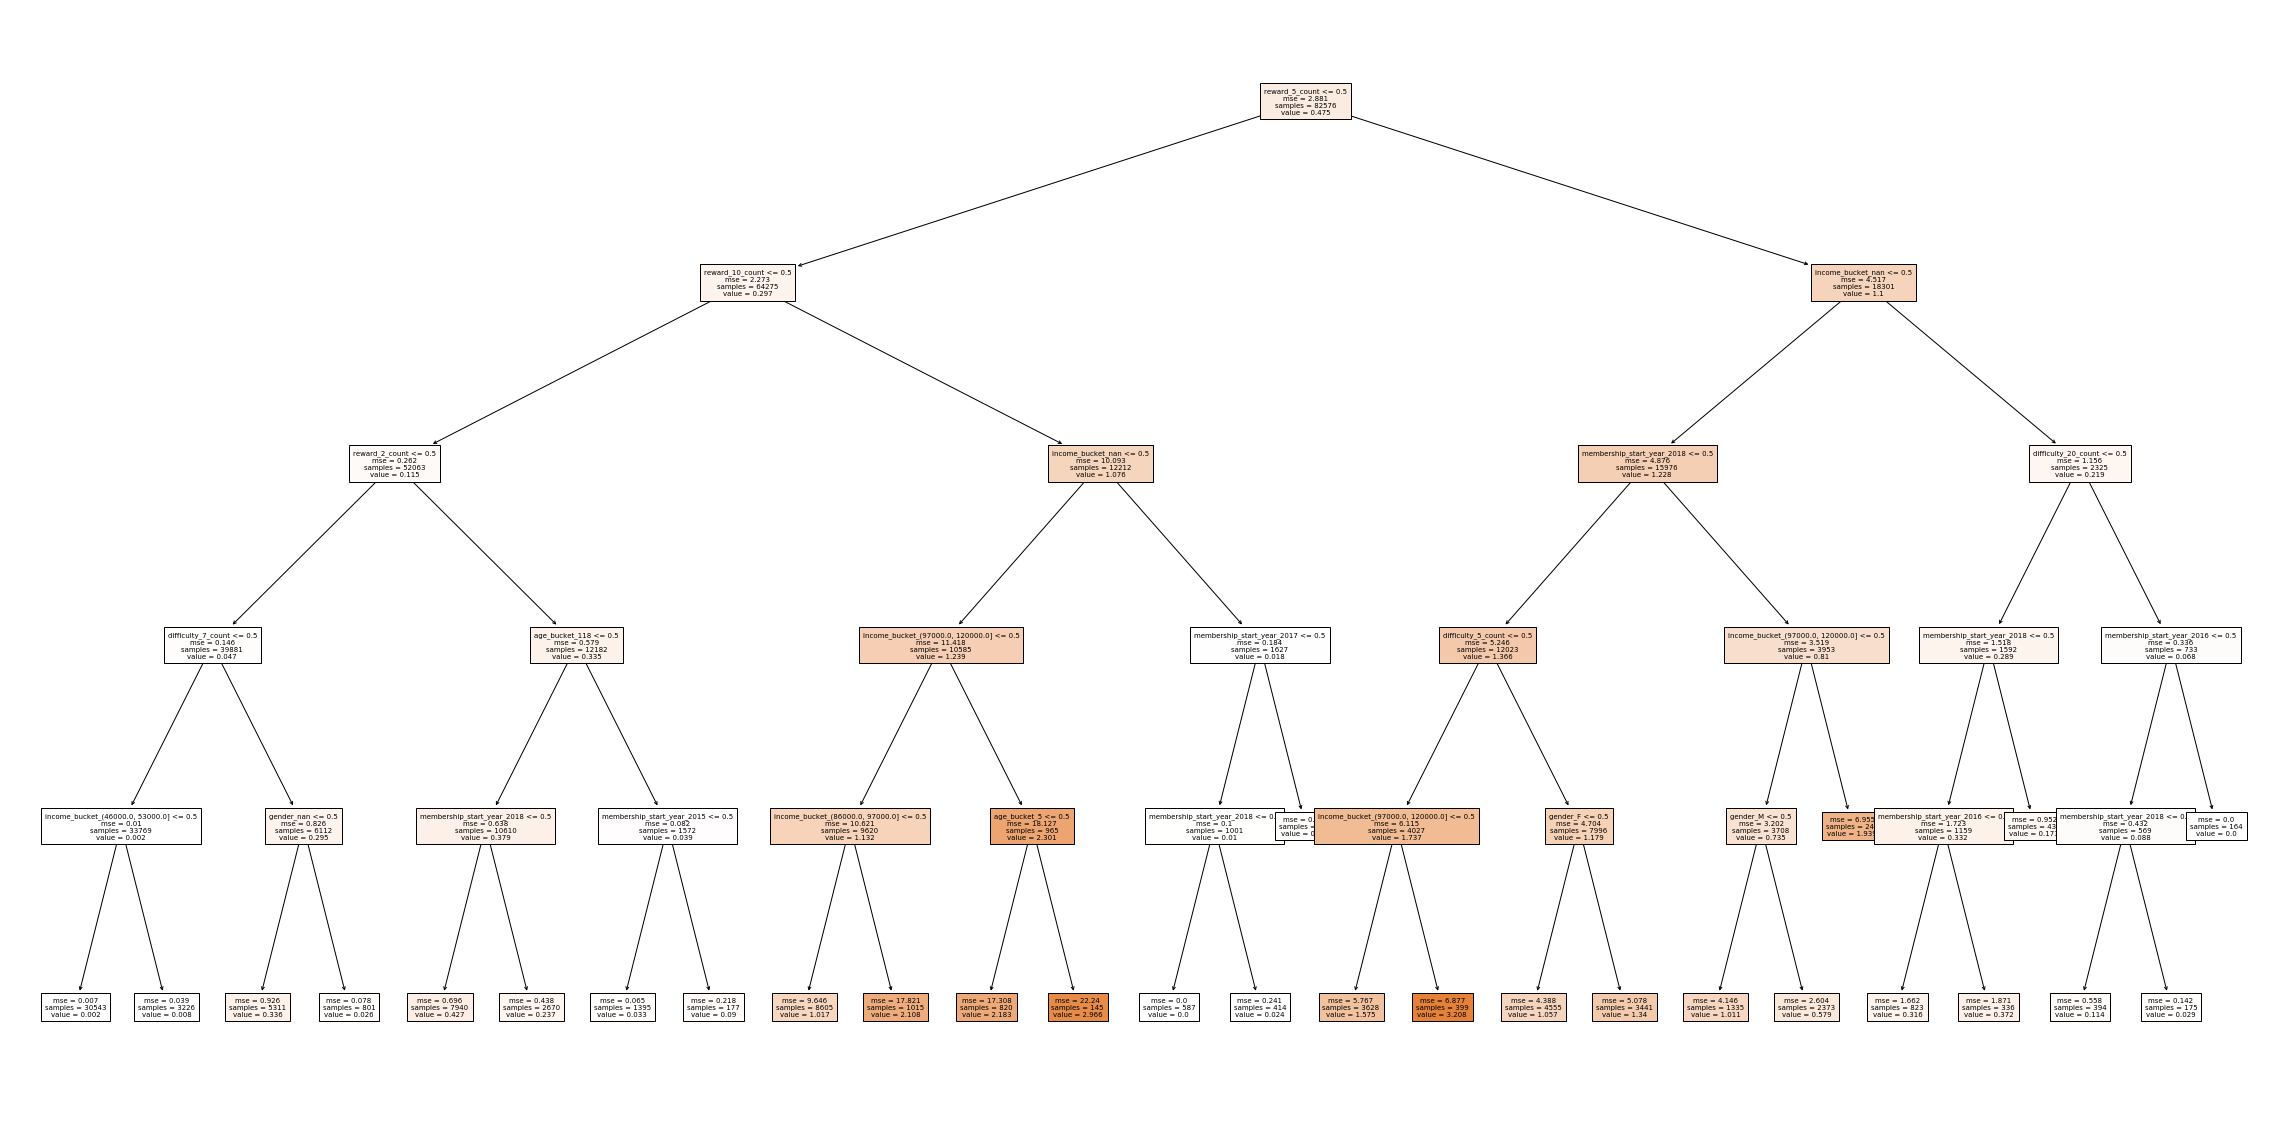

In [373]:
fig = plt.subplots(figsize = (40,20))
plt.title('DecisionTreeRegressor on grouped datat by person and by offer')
tree.plot_tree(dtree, filled=True, feature_names=train_features, fontsize = 7)
plt.savefig('RegressionPersonOffer.png')#, dpi=100

In [375]:
print(tree.export_text(dtree,feature_names=train_features ))

|--- reward_5_count <= 0.50
|   |--- reward_10_count <= 0.50
|   |   |--- reward_2_count <= 0.50
|   |   |   |--- difficulty_7_count <= 0.50
|   |   |   |   |--- income_bucket_(46000.0, 53000.0] <= 0.50
|   |   |   |   |   |--- value: [0.00]
|   |   |   |   |--- income_bucket_(46000.0, 53000.0] >  0.50
|   |   |   |   |   |--- value: [0.01]
|   |   |   |--- difficulty_7_count >  0.50
|   |   |   |   |--- gender_nan <= 0.50
|   |   |   |   |   |--- value: [0.34]
|   |   |   |   |--- gender_nan >  0.50
|   |   |   |   |   |--- value: [0.03]
|   |   |--- reward_2_count >  0.50
|   |   |   |--- age_bucket_118 <= 0.50
|   |   |   |   |--- membership_start_year_2018 <= 0.50
|   |   |   |   |   |--- value: [0.43]
|   |   |   |   |--- membership_start_year_2018 >  0.50
|   |   |   |   |   |--- value: [0.24]
|   |   |   |--- age_bucket_118 >  0.50
|   |   |   |   |--- membership_start_year_2015 <= 0.50
|   |   |   |   |   |--- value: [0.03]
|   |   |   |   |--- membership_start_year_2015 >  0.5

In [ ]:

fig = plt.subplots(figsize = (30,20))
sorted_idx = dtree.feature_importances_.argsort()
plt.barh([train_features[i] for i in sorted_idx], dtree.feature_importances_[sorted_idx])
ax.set_title("Feature importances")


In [376]:

#X_train.loc[:,'leaf'] = dtree.apply(X_train[train_features])

# Findings

Both Dataframes enable us to run a decision tree and to identify the groups with the highest loss.
The highest passive losses are generated by the people with the highest income. Apparently they do not view the offer and purchase anyway 

1. **Decision tree grouped by person**
* Example 1: Certain leaves have very high passive rewards per person (6Dollar - 8Dollar)
    * e.g. age_bucket not like 118 (which means the age is known)
    * bogo_count>=2 (which mens that the person received at least 2 bogo offers during the testing period)
    * income_bucket is > = (96000-12000) (which means that it is high income customers)
    * Id received = 0b1e1539f2cc45b7b9fa7c272da2e1d7 (Discount offer with 20 difficulty and 10 duration)
    
* Example 2: 
    * age_bucket not like 118 (which means the age is known)
    * bogo_count>=2 (which mens that the person received at least 2 bogo offers during the testing period)
    * income_bucket is < = (96000-12000) (which means that it is high income customers)
    * Is female
    * Received 9b98b8c7a33c4b65b9aebfe6a799e6d9 (bogo offer with 5 difficulty and 7 duration)

2. **Decision tree grouped by person and offer**
* Example 1: 
    * Offer is not reward_5 offer
    * Offer is reward_10 offer
    * Income bucket is known
    * Income is > = (96000-12000)


In [378]:
portfolio[['id', 'offer_type', 'reward', 'duration', 'difficulty']].drop_duplicates()

id     offer_type  reward  duration  \
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10         7   
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10         5   
2  3f207df678b143eea3cee63160fa8bed  informational       0         4   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5         7   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5        10   
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount       3         7   
6  fafdcd668e3743c1bb461111dcafc2a4       discount       2        10   
7  5a8bc65990b245e5a138643cd4eb9837  informational       0         3   
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo       5         5   
9  2906b810c7d4411798c6938adc9daaa5       discount       2         7   

   difficulty  
0          10  
1          10  
2           0  
3           5  
4          20  
5           7  
6          10  
7           0  
8           5  
9          10

## Appendix

In [193]:
X, Y= load_data('StarbucksCleanedData',  'has_reward')

In [196]:
Y

person  independent_transaction  \
0       0011e0d4e6b944f998e987f904e8c1e5                     0.00   
1       0011e0d4e6b944f998e987f904e8c1e5                    31.99   
2       0020ccbbb6d84e358d3414a3ff76cffd                     0.00   
3       0020ccbbb6d84e358d3414a3ff76cffd                     7.47   
4       005500a7188546ff8a767329a2f7c76a                     0.00   
...                                  ...                      ...   
103216  ffeaa02452ef451082a0361c3ca62ef5                    59.74   
103217  ffecb1f8543f4bf7bade023de366d6bf                     0.00   
103218  fff3ba4757bd42088c044ca26d73817a                     0.00   
103219  fff3ba4757bd42088c044ca26d73817a                     0.00   
103220  fffad4f4828548d1b5583907f2e9906b                    33.42   

        active_transaction  passive_transaction  active_reward  passive_reward  
0                 1.378125              0.00000            5.0             0.0  
1                 0.000000              0.00000            0.0             0.0  
2                10.320000              0.00000            5.0             0.0  
3                 0.000000              0.00000            0.0             0.0  
4                 0.000000              1.12875            0.0             5.0  
...                    ...                  ...            ...             ...  
103216           19.990000              0.00000            0.0             0.0  
103217            0.000000              0.00000            0.0             0.0  
103218            0.000000              0.00000            0.0             0.0  
103219          414.310000              2.22875            0.0             0.0  
103220            5.630000              0.00000            0.0             0.0  

[103221 rows x 6 columns]

In [230]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [231]:

X_train_copy.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 72254 entries, 58800 to 67778
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   valid_offers_simul        72254 non-null  int64  
 1   gender                    64761 non-null  object 
 2   age_bucket                72254 non-null  int64  
 3   became_member_on          72254 non-null  int64  
 4   income                    64761 non-null  float64
 5   offer_id                  72254 non-null  object 
 6   start_time                72254 non-null  float64
 7   offer_received            72254 non-null  float64
 8   social                    72254 non-null  float64
 9   email                     72254 non-null  float64
 10  mobile                    72254 non-null  float64
 11  web                       72254 non-null  float64
 12  offer_type_bogo           72254 non-null  float64
 13  offer_type_discount       72254 non-null  float64
 14  of

In [232]:

X_train_copy.gender = X_train.gender.fillna('unknown')
X_train_copy.income = X_train.income.fillna(X_train.income.mean())
X_test_copy.gender = X_test.gender.fillna('unknown')
X_test_copy.income = X_test.income.fillna(X_test.income.mean())

In [220]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y['passive_reward'], test_size=0.3)
model = CatBoostRegressor(cat_features = ['gender','age_bucket','offer_id'])
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train_copy, 
                                       y=Y_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7838108	test: 1.7363064	best: 1.7363064 (0)	total: 191ms	remaining: 3m 11s
1:	learn: 1.7801465	test: 1.7327478	best: 1.7327478 (1)	total: 232ms	remaining: 1m 55s
2:	learn: 1.7766856	test: 1.7294052	best: 1.7294052 (2)	total: 269ms	remaining: 1m 29s
3:	learn: 1.7734289	test: 1.7262615	best: 1.7262615 (3)	total: 308ms	remaining: 1m 16s
4:	learn: 1.7703584	test: 1.7233056	best: 1.7233056 (4)	total: 346ms	remaining: 1m 8s
5:	learn: 1.7674676	test: 1.7205235	best: 1.7205235 (5)	total: 365ms	remaining: 1m
6:	learn: 1.7647292	test: 1.7179122	best: 1.7179122 (6)	total: 413ms	remaining: 58.6s
7:	learn: 1.7621574	test: 1.7154476	best: 1.7154476 (7)	total: 459ms	remaining: 57s
8:	learn: 1.7597361	test: 1.7131368	best: 1.7131368 (8)	total: 502ms	remaining: 55.3s
9:	learn: 1.7574515	test: 1.7109595	best: 1.7109595 (9)	total: 541ms	remaining: 53.6s
10:	learn: 1.7552984	test: 1.7089195	best: 1.7089195 (10)	total: 581ms	remaining: 52.2s
11:	learn: 1.7532753	test: 1.7070004	best: 1.7070004 

96:	learn: 1.7206149	test: 1.6785307	best: 1.6785307 (96)	total: 3.34s	remaining: 31.1s
97:	learn: 1.7206039	test: 1.6785311	best: 1.6785307 (96)	total: 3.35s	remaining: 30.8s
98:	learn: 1.7205936	test: 1.6785318	best: 1.6785307 (96)	total: 3.36s	remaining: 30.6s
99:	learn: 1.7205796	test: 1.6785324	best: 1.6785307 (96)	total: 3.39s	remaining: 30.5s
100:	learn: 1.7205692	test: 1.6785332	best: 1.6785307 (96)	total: 3.42s	remaining: 30.4s
101:	learn: 1.7205559	test: 1.6785341	best: 1.6785307 (96)	total: 3.45s	remaining: 30.4s
102:	learn: 1.7205434	test: 1.6785359	best: 1.6785307 (96)	total: 3.49s	remaining: 30.4s
103:	learn: 1.7205216	test: 1.6785464	best: 1.6785307 (96)	total: 3.53s	remaining: 30.4s
104:	learn: 1.7205117	test: 1.6785486	best: 1.6785307 (96)	total: 3.56s	remaining: 30.4s
105:	learn: 1.7205050	test: 1.6785508	best: 1.6785307 (96)	total: 3.57s	remaining: 30.1s
106:	learn: 1.7204987	test: 1.6785532	best: 1.6785307 (96)	total: 3.58s	remaining: 29.9s
107:	learn: 1.7204691	tes

192:	learn: 1.7199551	test: 1.6786991	best: 1.6785307 (96)	total: 6.43s	remaining: 26.9s
193:	learn: 1.7199203	test: 1.6787129	best: 1.6785307 (96)	total: 6.47s	remaining: 26.9s
194:	learn: 1.7199180	test: 1.6787122	best: 1.6785307 (96)	total: 6.51s	remaining: 26.9s
195:	learn: 1.7199058	test: 1.6787127	best: 1.6785307 (96)	total: 6.54s	remaining: 26.8s
196:	learn: 1.7198855	test: 1.6787118	best: 1.6785307 (96)	total: 6.59s	remaining: 26.9s
197:	learn: 1.7198801	test: 1.6787117	best: 1.6785307 (96)	total: 6.63s	remaining: 26.9s
198:	learn: 1.7198577	test: 1.6787088	best: 1.6785307 (96)	total: 6.68s	remaining: 26.9s
199:	learn: 1.7198560	test: 1.6787125	best: 1.6785307 (96)	total: 6.72s	remaining: 26.9s
200:	learn: 1.7198542	test: 1.6787131	best: 1.6785307 (96)	total: 6.76s	remaining: 26.9s
201:	learn: 1.7198504	test: 1.6787132	best: 1.6785307 (96)	total: 6.8s	remaining: 26.8s
202:	learn: 1.7198503	test: 1.6787137	best: 1.6785307 (96)	total: 6.81s	remaining: 26.7s
203:	learn: 1.7198472	

286:	learn: 1.7193860	test: 1.6787229	best: 1.6785307 (96)	total: 9.61s	remaining: 23.9s
287:	learn: 1.7193680	test: 1.6787279	best: 1.6785307 (96)	total: 9.65s	remaining: 23.8s
288:	learn: 1.7193680	test: 1.6787280	best: 1.6785307 (96)	total: 9.66s	remaining: 23.8s
289:	learn: 1.7193535	test: 1.6787280	best: 1.6785307 (96)	total: 9.69s	remaining: 23.7s
290:	learn: 1.7193513	test: 1.6787243	best: 1.6785307 (96)	total: 9.73s	remaining: 23.7s
291:	learn: 1.7193467	test: 1.6787217	best: 1.6785307 (96)	total: 9.77s	remaining: 23.7s
292:	learn: 1.7193399	test: 1.6787213	best: 1.6785307 (96)	total: 9.8s	remaining: 23.7s
293:	learn: 1.7193126	test: 1.6787258	best: 1.6785307 (96)	total: 9.85s	remaining: 23.7s
294:	learn: 1.7193003	test: 1.6787274	best: 1.6785307 (96)	total: 9.89s	remaining: 23.6s
295:	learn: 1.7192998	test: 1.6787256	best: 1.6785307 (96)	total: 9.91s	remaining: 23.6s
296:	learn: 1.7192947	test: 1.6787254	best: 1.6785307 (96)	total: 9.95s	remaining: 23.5s
297:	learn: 1.7192936	

381:	learn: 1.7186657	test: 1.6787114	best: 1.6785307 (96)	total: 12.8s	remaining: 20.6s
382:	learn: 1.7186530	test: 1.6787016	best: 1.6785307 (96)	total: 12.8s	remaining: 20.6s
383:	learn: 1.7186440	test: 1.6786970	best: 1.6785307 (96)	total: 12.8s	remaining: 20.6s
384:	learn: 1.7186291	test: 1.6786956	best: 1.6785307 (96)	total: 12.9s	remaining: 20.6s
385:	learn: 1.7186210	test: 1.6786938	best: 1.6785307 (96)	total: 12.9s	remaining: 20.5s
386:	learn: 1.7186114	test: 1.6787049	best: 1.6785307 (96)	total: 13s	remaining: 20.5s
387:	learn: 1.7185989	test: 1.6787005	best: 1.6785307 (96)	total: 13s	remaining: 20.5s
388:	learn: 1.7185742	test: 1.6787067	best: 1.6785307 (96)	total: 13s	remaining: 20.5s
389:	learn: 1.7185458	test: 1.6787228	best: 1.6785307 (96)	total: 13.1s	remaining: 20.5s
390:	learn: 1.7185330	test: 1.6787273	best: 1.6785307 (96)	total: 13.1s	remaining: 20.4s
391:	learn: 1.7185291	test: 1.6787272	best: 1.6785307 (96)	total: 13.1s	remaining: 20.4s
392:	learn: 1.7185209	test:

478:	learn: 1.7176104	test: 1.6787690	best: 1.6785307 (96)	total: 16.6s	remaining: 18.1s
479:	learn: 1.7175882	test: 1.6787840	best: 1.6785307 (96)	total: 16.7s	remaining: 18.1s
480:	learn: 1.7175758	test: 1.6787813	best: 1.6785307 (96)	total: 16.7s	remaining: 18s
481:	learn: 1.7175541	test: 1.6787971	best: 1.6785307 (96)	total: 16.8s	remaining: 18s
482:	learn: 1.7175471	test: 1.6787988	best: 1.6785307 (96)	total: 16.8s	remaining: 18s
483:	learn: 1.7175344	test: 1.6788127	best: 1.6785307 (96)	total: 16.9s	remaining: 18s
484:	learn: 1.7175299	test: 1.6788164	best: 1.6785307 (96)	total: 16.9s	remaining: 18s
485:	learn: 1.7175256	test: 1.6788200	best: 1.6785307 (96)	total: 17s	remaining: 17.9s
486:	learn: 1.7175222	test: 1.6788217	best: 1.6785307 (96)	total: 17s	remaining: 17.9s
487:	learn: 1.7175067	test: 1.6788186	best: 1.6785307 (96)	total: 17.1s	remaining: 17.9s
488:	learn: 1.7175017	test: 1.6788189	best: 1.6785307 (96)	total: 17.1s	remaining: 17.9s
489:	learn: 1.7174936	test: 1.67881

575:	learn: 1.7164983	test: 1.6789936	best: 1.6785307 (96)	total: 21s	remaining: 15.4s
576:	learn: 1.7164957	test: 1.6789924	best: 1.6785307 (96)	total: 21s	remaining: 15.4s
577:	learn: 1.7164891	test: 1.6789941	best: 1.6785307 (96)	total: 21.1s	remaining: 15.4s
578:	learn: 1.7164706	test: 1.6790005	best: 1.6785307 (96)	total: 21.1s	remaining: 15.3s
579:	learn: 1.7164590	test: 1.6789981	best: 1.6785307 (96)	total: 21.1s	remaining: 15.3s
580:	learn: 1.7164559	test: 1.6789974	best: 1.6785307 (96)	total: 21.2s	remaining: 15.3s
581:	learn: 1.7164522	test: 1.6789982	best: 1.6785307 (96)	total: 21.2s	remaining: 15.2s
582:	learn: 1.7164462	test: 1.6789969	best: 1.6785307 (96)	total: 21.3s	remaining: 15.2s
583:	learn: 1.7164415	test: 1.6789956	best: 1.6785307 (96)	total: 21.3s	remaining: 15.2s
584:	learn: 1.7164291	test: 1.6789991	best: 1.6785307 (96)	total: 21.3s	remaining: 15.1s
585:	learn: 1.7164052	test: 1.6790000	best: 1.6785307 (96)	total: 21.4s	remaining: 15.1s
586:	learn: 1.7164042	tes

670:	learn: 1.7156220	test: 1.6790957	best: 1.6785307 (96)	total: 24.8s	remaining: 12.2s
671:	learn: 1.7156148	test: 1.6790947	best: 1.6785307 (96)	total: 24.8s	remaining: 12.1s
672:	learn: 1.7155969	test: 1.6791175	best: 1.6785307 (96)	total: 24.9s	remaining: 12.1s
673:	learn: 1.7155905	test: 1.6791169	best: 1.6785307 (96)	total: 24.9s	remaining: 12.1s
674:	learn: 1.7155689	test: 1.6791252	best: 1.6785307 (96)	total: 25s	remaining: 12s
675:	learn: 1.7155615	test: 1.6791319	best: 1.6785307 (96)	total: 25s	remaining: 12s
676:	learn: 1.7155577	test: 1.6791308	best: 1.6785307 (96)	total: 25s	remaining: 11.9s
677:	learn: 1.7155419	test: 1.6791322	best: 1.6785307 (96)	total: 25.1s	remaining: 11.9s
678:	learn: 1.7155226	test: 1.6791204	best: 1.6785307 (96)	total: 25.1s	remaining: 11.9s
679:	learn: 1.7155174	test: 1.6791183	best: 1.6785307 (96)	total: 25.1s	remaining: 11.8s
680:	learn: 1.7155019	test: 1.6791058	best: 1.6785307 (96)	total: 25.2s	remaining: 11.8s
681:	learn: 1.7154894	test: 1.6

767:	learn: 1.7147244	test: 1.6792484	best: 1.6785307 (96)	total: 28.9s	remaining: 8.73s
768:	learn: 1.7147224	test: 1.6792497	best: 1.6785307 (96)	total: 28.9s	remaining: 8.69s
769:	learn: 1.7147146	test: 1.6792463	best: 1.6785307 (96)	total: 29s	remaining: 8.66s
770:	learn: 1.7146990	test: 1.6792491	best: 1.6785307 (96)	total: 29s	remaining: 8.62s
771:	learn: 1.7146798	test: 1.6792645	best: 1.6785307 (96)	total: 29.1s	remaining: 8.58s
772:	learn: 1.7146783	test: 1.6792635	best: 1.6785307 (96)	total: 29.1s	remaining: 8.54s
773:	learn: 1.7146668	test: 1.6792654	best: 1.6785307 (96)	total: 29.1s	remaining: 8.51s
774:	learn: 1.7146615	test: 1.6792672	best: 1.6785307 (96)	total: 29.2s	remaining: 8.47s
775:	learn: 1.7146498	test: 1.6792686	best: 1.6785307 (96)	total: 29.2s	remaining: 8.43s
776:	learn: 1.7146449	test: 1.6792662	best: 1.6785307 (96)	total: 29.2s	remaining: 8.39s
777:	learn: 1.7146314	test: 1.6792731	best: 1.6785307 (96)	total: 29.3s	remaining: 8.36s
778:	learn: 1.7146241	tes

861:	learn: 1.7139144	test: 1.6793385	best: 1.6785307 (96)	total: 32.6s	remaining: 5.22s
862:	learn: 1.7139126	test: 1.6793372	best: 1.6785307 (96)	total: 32.6s	remaining: 5.18s
863:	learn: 1.7138979	test: 1.6793398	best: 1.6785307 (96)	total: 32.7s	remaining: 5.14s
864:	learn: 1.7138967	test: 1.6793388	best: 1.6785307 (96)	total: 32.7s	remaining: 5.11s
865:	learn: 1.7138914	test: 1.6793456	best: 1.6785307 (96)	total: 32.8s	remaining: 5.07s
866:	learn: 1.7138799	test: 1.6793443	best: 1.6785307 (96)	total: 32.8s	remaining: 5.04s
867:	learn: 1.7138727	test: 1.6793393	best: 1.6785307 (96)	total: 32.9s	remaining: 5s
868:	learn: 1.7138652	test: 1.6793390	best: 1.6785307 (96)	total: 32.9s	remaining: 4.96s
869:	learn: 1.7138603	test: 1.6793395	best: 1.6785307 (96)	total: 33s	remaining: 4.93s
870:	learn: 1.7138473	test: 1.6793402	best: 1.6785307 (96)	total: 33s	remaining: 4.89s
871:	learn: 1.7138396	test: 1.6793382	best: 1.6785307 (96)	total: 33.1s	remaining: 4.85s
872:	learn: 1.7138352	test: 

955:	learn: 1.7131835	test: 1.6793681	best: 1.6785307 (96)	total: 36.5s	remaining: 1.68s
956:	learn: 1.7131818	test: 1.6793665	best: 1.6785307 (96)	total: 36.5s	remaining: 1.64s
957:	learn: 1.7131626	test: 1.6793737	best: 1.6785307 (96)	total: 36.6s	remaining: 1.6s
958:	learn: 1.7131578	test: 1.6793732	best: 1.6785307 (96)	total: 36.6s	remaining: 1.56s
959:	learn: 1.7131566	test: 1.6793748	best: 1.6785307 (96)	total: 36.6s	remaining: 1.52s
960:	learn: 1.7131399	test: 1.6793764	best: 1.6785307 (96)	total: 36.7s	remaining: 1.49s
961:	learn: 1.7131373	test: 1.6793771	best: 1.6785307 (96)	total: 36.7s	remaining: 1.45s
962:	learn: 1.7131268	test: 1.6793843	best: 1.6785307 (96)	total: 36.7s	remaining: 1.41s
963:	learn: 1.7131194	test: 1.6793843	best: 1.6785307 (96)	total: 36.8s	remaining: 1.37s
964:	learn: 1.7131062	test: 1.6793827	best: 1.6785307 (96)	total: 36.8s	remaining: 1.33s
965:	learn: 1.7131009	test: 1.6793847	best: 1.6785307 (96)	total: 36.8s	remaining: 1.29s
966:	learn: 1.7130923	

51:	learn: 1.7199554	test: 1.6787278	best: 1.6785445 (29)	total: 1.68s	remaining: 30.6s
52:	learn: 1.7199471	test: 1.6787325	best: 1.6785445 (29)	total: 1.72s	remaining: 30.7s
53:	learn: 1.7199310	test: 1.6787238	best: 1.6785445 (29)	total: 1.75s	remaining: 30.7s
54:	learn: 1.7199220	test: 1.6787257	best: 1.6785445 (29)	total: 1.79s	remaining: 30.7s
55:	learn: 1.7199116	test: 1.6787280	best: 1.6785445 (29)	total: 1.82s	remaining: 30.7s
56:	learn: 1.7198795	test: 1.6787323	best: 1.6785445 (29)	total: 1.86s	remaining: 30.7s
57:	learn: 1.7198449	test: 1.6787530	best: 1.6785445 (29)	total: 1.9s	remaining: 30.8s
58:	learn: 1.7197901	test: 1.6787544	best: 1.6785445 (29)	total: 1.94s	remaining: 30.9s
59:	learn: 1.7197901	test: 1.6787558	best: 1.6785445 (29)	total: 1.95s	remaining: 30.5s
60:	learn: 1.7197470	test: 1.6787394	best: 1.6785445 (29)	total: 1.98s	remaining: 30.5s
61:	learn: 1.7197204	test: 1.6787321	best: 1.6785445 (29)	total: 2.01s	remaining: 30.4s
62:	learn: 1.7196826	test: 1.6787

145:	learn: 1.7175756	test: 1.6788194	best: 1.6785445 (29)	total: 4.76s	remaining: 27.9s
146:	learn: 1.7175238	test: 1.6788214	best: 1.6785445 (29)	total: 4.8s	remaining: 27.9s
147:	learn: 1.7174864	test: 1.6788112	best: 1.6785445 (29)	total: 4.84s	remaining: 27.8s
148:	learn: 1.7174265	test: 1.6788219	best: 1.6785445 (29)	total: 4.87s	remaining: 27.8s
149:	learn: 1.7173449	test: 1.6788715	best: 1.6785445 (29)	total: 4.91s	remaining: 27.8s
150:	learn: 1.7173138	test: 1.6788681	best: 1.6785445 (29)	total: 4.95s	remaining: 27.8s
151:	learn: 1.7172469	test: 1.6788621	best: 1.6785445 (29)	total: 4.99s	remaining: 27.8s
152:	learn: 1.7172311	test: 1.6788739	best: 1.6785445 (29)	total: 5.01s	remaining: 27.8s
153:	learn: 1.7171706	test: 1.6788857	best: 1.6785445 (29)	total: 5.04s	remaining: 27.7s
154:	learn: 1.7171562	test: 1.6788860	best: 1.6785445 (29)	total: 5.08s	remaining: 27.7s
155:	learn: 1.7171256	test: 1.6788822	best: 1.6785445 (29)	total: 5.12s	remaining: 27.7s
156:	learn: 1.7170765	

239:	learn: 1.7143692	test: 1.6790654	best: 1.6785445 (29)	total: 8.43s	remaining: 26.7s
240:	learn: 1.7143285	test: 1.6790591	best: 1.6785445 (29)	total: 8.46s	remaining: 26.7s
241:	learn: 1.7142971	test: 1.6790540	best: 1.6785445 (29)	total: 8.5s	remaining: 26.6s
242:	learn: 1.7142735	test: 1.6790506	best: 1.6785445 (29)	total: 8.53s	remaining: 26.6s
243:	learn: 1.7142334	test: 1.6790587	best: 1.6785445 (29)	total: 8.56s	remaining: 26.5s
244:	learn: 1.7142112	test: 1.6790611	best: 1.6785445 (29)	total: 8.61s	remaining: 26.5s
245:	learn: 1.7141973	test: 1.6790512	best: 1.6785445 (29)	total: 8.65s	remaining: 26.5s
246:	learn: 1.7141020	test: 1.6790325	best: 1.6785445 (29)	total: 8.69s	remaining: 26.5s
247:	learn: 1.7140825	test: 1.6790275	best: 1.6785445 (29)	total: 8.72s	remaining: 26.4s
248:	learn: 1.7140564	test: 1.6790419	best: 1.6785445 (29)	total: 8.76s	remaining: 26.4s
249:	learn: 1.7140526	test: 1.6790419	best: 1.6785445 (29)	total: 8.79s	remaining: 26.4s
250:	learn: 1.7140162	

336:	learn: 1.7117876	test: 1.6793810	best: 1.6785445 (29)	total: 12.4s	remaining: 24.4s
337:	learn: 1.7117382	test: 1.6793879	best: 1.6785445 (29)	total: 12.5s	remaining: 24.4s
338:	learn: 1.7116572	test: 1.6793504	best: 1.6785445 (29)	total: 12.5s	remaining: 24.4s
339:	learn: 1.7116180	test: 1.6793333	best: 1.6785445 (29)	total: 12.6s	remaining: 24.4s
340:	learn: 1.7116031	test: 1.6793170	best: 1.6785445 (29)	total: 12.6s	remaining: 24.3s
341:	learn: 1.7115602	test: 1.6793185	best: 1.6785445 (29)	total: 12.6s	remaining: 24.3s
342:	learn: 1.7115440	test: 1.6793167	best: 1.6785445 (29)	total: 12.7s	remaining: 24.3s
343:	learn: 1.7114915	test: 1.6793576	best: 1.6785445 (29)	total: 12.7s	remaining: 24.3s
344:	learn: 1.7114770	test: 1.6793564	best: 1.6785445 (29)	total: 12.8s	remaining: 24.2s
345:	learn: 1.7114599	test: 1.6793480	best: 1.6785445 (29)	total: 12.8s	remaining: 24.2s
346:	learn: 1.7114536	test: 1.6793497	best: 1.6785445 (29)	total: 12.8s	remaining: 24.2s
347:	learn: 1.7114236

432:	learn: 1.7091889	test: 1.6794961	best: 1.6785445 (29)	total: 16.4s	remaining: 21.4s
433:	learn: 1.7091790	test: 1.6794967	best: 1.6785445 (29)	total: 16.4s	remaining: 21.4s
434:	learn: 1.7091683	test: 1.6795068	best: 1.6785445 (29)	total: 16.4s	remaining: 21.4s
435:	learn: 1.7091256	test: 1.6794775	best: 1.6785445 (29)	total: 16.5s	remaining: 21.3s
436:	learn: 1.7091115	test: 1.6794732	best: 1.6785445 (29)	total: 16.5s	remaining: 21.3s
437:	learn: 1.7091002	test: 1.6794681	best: 1.6785445 (29)	total: 16.6s	remaining: 21.2s
438:	learn: 1.7090825	test: 1.6794720	best: 1.6785445 (29)	total: 16.6s	remaining: 21.2s
439:	learn: 1.7090267	test: 1.6795222	best: 1.6785445 (29)	total: 16.6s	remaining: 21.2s
440:	learn: 1.7090156	test: 1.6795214	best: 1.6785445 (29)	total: 16.7s	remaining: 21.1s
441:	learn: 1.7090136	test: 1.6795217	best: 1.6785445 (29)	total: 16.7s	remaining: 21.1s
442:	learn: 1.7089957	test: 1.6795308	best: 1.6785445 (29)	total: 16.7s	remaining: 21s
443:	learn: 1.7089777	t

526:	learn: 1.7066994	test: 1.6800872	best: 1.6785445 (29)	total: 20.3s	remaining: 18.2s
527:	learn: 1.7066625	test: 1.6800908	best: 1.6785445 (29)	total: 20.4s	remaining: 18.2s
528:	learn: 1.7066217	test: 1.6801011	best: 1.6785445 (29)	total: 20.4s	remaining: 18.2s
529:	learn: 1.7066074	test: 1.6801104	best: 1.6785445 (29)	total: 20.4s	remaining: 18.1s
530:	learn: 1.7065664	test: 1.6801521	best: 1.6785445 (29)	total: 20.5s	remaining: 18.1s
531:	learn: 1.7065577	test: 1.6801640	best: 1.6785445 (29)	total: 20.5s	remaining: 18s
532:	learn: 1.7065463	test: 1.6801655	best: 1.6785445 (29)	total: 20.6s	remaining: 18s
533:	learn: 1.7065329	test: 1.6801627	best: 1.6785445 (29)	total: 20.6s	remaining: 18s
534:	learn: 1.7065210	test: 1.6801617	best: 1.6785445 (29)	total: 20.6s	remaining: 17.9s
535:	learn: 1.7065046	test: 1.6801619	best: 1.6785445 (29)	total: 20.7s	remaining: 17.9s
536:	learn: 1.7064924	test: 1.6801644	best: 1.6785445 (29)	total: 20.7s	remaining: 17.9s
537:	learn: 1.7064678	test:

620:	learn: 1.7043255	test: 1.6805490	best: 1.6785445 (29)	total: 24.1s	remaining: 14.7s
621:	learn: 1.7043198	test: 1.6805562	best: 1.6785445 (29)	total: 24.1s	remaining: 14.7s
622:	learn: 1.7043131	test: 1.6805557	best: 1.6785445 (29)	total: 24.2s	remaining: 14.6s
623:	learn: 1.7043099	test: 1.6805583	best: 1.6785445 (29)	total: 24.2s	remaining: 14.6s
624:	learn: 1.7043075	test: 1.6805578	best: 1.6785445 (29)	total: 24.2s	remaining: 14.5s
625:	learn: 1.7042954	test: 1.6805535	best: 1.6785445 (29)	total: 24.3s	remaining: 14.5s
626:	learn: 1.7042769	test: 1.6805677	best: 1.6785445 (29)	total: 24.3s	remaining: 14.5s
627:	learn: 1.7042266	test: 1.6805927	best: 1.6785445 (29)	total: 24.4s	remaining: 14.4s
628:	learn: 1.7042066	test: 1.6805740	best: 1.6785445 (29)	total: 24.4s	remaining: 14.4s
629:	learn: 1.7041773	test: 1.6805880	best: 1.6785445 (29)	total: 24.4s	remaining: 14.3s
630:	learn: 1.7041134	test: 1.6805896	best: 1.6785445 (29)	total: 24.5s	remaining: 14.3s
631:	learn: 1.7040815

714:	learn: 1.7020430	test: 1.6805965	best: 1.6785445 (29)	total: 27.8s	remaining: 11.1s
715:	learn: 1.7020323	test: 1.6805881	best: 1.6785445 (29)	total: 27.9s	remaining: 11.1s
716:	learn: 1.7020306	test: 1.6805877	best: 1.6785445 (29)	total: 27.9s	remaining: 11s
717:	learn: 1.7020194	test: 1.6805750	best: 1.6785445 (29)	total: 28s	remaining: 11s
718:	learn: 1.7019940	test: 1.6805840	best: 1.6785445 (29)	total: 28s	remaining: 10.9s
719:	learn: 1.7019836	test: 1.6805830	best: 1.6785445 (29)	total: 28s	remaining: 10.9s
720:	learn: 1.7019228	test: 1.6806406	best: 1.6785445 (29)	total: 28.1s	remaining: 10.9s
721:	learn: 1.7019146	test: 1.6806446	best: 1.6785445 (29)	total: 28.1s	remaining: 10.8s
722:	learn: 1.7018891	test: 1.6806439	best: 1.6785445 (29)	total: 28.1s	remaining: 10.8s
723:	learn: 1.7018786	test: 1.6806377	best: 1.6785445 (29)	total: 28.2s	remaining: 10.7s
724:	learn: 1.7018634	test: 1.6806603	best: 1.6785445 (29)	total: 28.2s	remaining: 10.7s
725:	learn: 1.7018282	test: 1.6

808:	learn: 1.6998976	test: 1.6809967	best: 1.6785445 (29)	total: 31.5s	remaining: 7.43s
809:	learn: 1.6998644	test: 1.6809435	best: 1.6785445 (29)	total: 31.5s	remaining: 7.39s
810:	learn: 1.6998491	test: 1.6809418	best: 1.6785445 (29)	total: 31.6s	remaining: 7.36s
811:	learn: 1.6998147	test: 1.6809397	best: 1.6785445 (29)	total: 31.6s	remaining: 7.32s
812:	learn: 1.6997979	test: 1.6809308	best: 1.6785445 (29)	total: 31.6s	remaining: 7.27s
813:	learn: 1.6997902	test: 1.6809276	best: 1.6785445 (29)	total: 31.7s	remaining: 7.24s
814:	learn: 1.6997596	test: 1.6809156	best: 1.6785445 (29)	total: 31.7s	remaining: 7.2s
815:	learn: 1.6997071	test: 1.6809114	best: 1.6785445 (29)	total: 31.7s	remaining: 7.16s
816:	learn: 1.6996655	test: 1.6809539	best: 1.6785445 (29)	total: 31.8s	remaining: 7.12s
817:	learn: 1.6996641	test: 1.6809540	best: 1.6785445 (29)	total: 31.8s	remaining: 7.08s
818:	learn: 1.6996357	test: 1.6809356	best: 1.6785445 (29)	total: 31.9s	remaining: 7.04s
819:	learn: 1.6996238	

903:	learn: 1.6978613	test: 1.6812856	best: 1.6785445 (29)	total: 35s	remaining: 3.72s
904:	learn: 1.6978504	test: 1.6813053	best: 1.6785445 (29)	total: 35.1s	remaining: 3.68s
905:	learn: 1.6978391	test: 1.6812987	best: 1.6785445 (29)	total: 35.1s	remaining: 3.64s
906:	learn: 1.6977954	test: 1.6813078	best: 1.6785445 (29)	total: 35.1s	remaining: 3.6s
907:	learn: 1.6977827	test: 1.6812994	best: 1.6785445 (29)	total: 35.2s	remaining: 3.56s
908:	learn: 1.6977796	test: 1.6812976	best: 1.6785445 (29)	total: 35.2s	remaining: 3.53s
909:	learn: 1.6977570	test: 1.6812907	best: 1.6785445 (29)	total: 35.3s	remaining: 3.49s
910:	learn: 1.6977276	test: 1.6813038	best: 1.6785445 (29)	total: 35.3s	remaining: 3.45s
911:	learn: 1.6977213	test: 1.6813036	best: 1.6785445 (29)	total: 35.3s	remaining: 3.41s
912:	learn: 1.6977032	test: 1.6813095	best: 1.6785445 (29)	total: 35.4s	remaining: 3.37s
913:	learn: 1.6976910	test: 1.6813073	best: 1.6785445 (29)	total: 35.4s	remaining: 3.33s
914:	learn: 1.6976745	te

999:	learn: 1.6959838	test: 1.6817169	best: 1.6785445 (29)	total: 38.8s	remaining: 0us

bestTest = 1.678544456
bestIteration = 29

1:	loss: 1.6785445	best: 1.6785307 (0)	total: 1m 17s	remaining: 18m 9s
0:	learn: 1.7838124	test: 1.7363079	best: 1.7363079 (0)	total: 38.8ms	remaining: 38.7s
1:	learn: 1.7801490	test: 1.7327503	best: 1.7327503 (1)	total: 76.7ms	remaining: 38.3s
2:	learn: 1.7766894	test: 1.7294089	best: 1.7294089 (2)	total: 112ms	remaining: 37.2s
3:	learn: 1.7734333	test: 1.7262658	best: 1.7262658 (3)	total: 150ms	remaining: 37.5s
4:	learn: 1.7703643	test: 1.7233110	best: 1.7233110 (4)	total: 193ms	remaining: 38.5s
5:	learn: 1.7674733	test: 1.7205288	best: 1.7205288 (5)	total: 214ms	remaining: 35.5s
6:	learn: 1.7647357	test: 1.7179182	best: 1.7179182 (6)	total: 254ms	remaining: 36s
7:	learn: 1.7621642	test: 1.7154540	best: 1.7154540 (7)	total: 295ms	remaining: 36.5s
8:	learn: 1.7597435	test: 1.7131437	best: 1.7131437 (8)	total: 333ms	remaining: 36.7s
9:	learn: 1.7574594	test

98:	learn: 1.7206271	test: 1.6785084	best: 1.6785073 (96)	total: 3.02s	remaining: 27.5s
99:	learn: 1.7206085	test: 1.6785094	best: 1.6785073 (96)	total: 3.05s	remaining: 27.4s
100:	learn: 1.7205898	test: 1.6785090	best: 1.6785073 (96)	total: 3.07s	remaining: 27.4s
101:	learn: 1.7205791	test: 1.6785102	best: 1.6785073 (96)	total: 3.1s	remaining: 27.3s
102:	learn: 1.7205682	test: 1.6785127	best: 1.6785073 (96)	total: 3.13s	remaining: 27.2s
103:	learn: 1.7205599	test: 1.6785146	best: 1.6785073 (96)	total: 3.15s	remaining: 27.2s
104:	learn: 1.7205475	test: 1.6785163	best: 1.6785073 (96)	total: 3.18s	remaining: 27.1s
105:	learn: 1.7205382	test: 1.6785173	best: 1.6785073 (96)	total: 3.21s	remaining: 27.1s
106:	learn: 1.7205304	test: 1.6785198	best: 1.6785073 (96)	total: 3.25s	remaining: 27.1s
107:	learn: 1.7205215	test: 1.6785194	best: 1.6785073 (96)	total: 3.28s	remaining: 27.1s
108:	learn: 1.7205088	test: 1.6785191	best: 1.6785073 (96)	total: 3.31s	remaining: 27.1s
109:	learn: 1.7204982	te

191:	learn: 1.7199849	test: 1.6786275	best: 1.6785073 (96)	total: 5.78s	remaining: 24.3s
192:	learn: 1.7199752	test: 1.6786218	best: 1.6785073 (96)	total: 5.82s	remaining: 24.3s
193:	learn: 1.7199610	test: 1.6786218	best: 1.6785073 (96)	total: 5.85s	remaining: 24.3s
194:	learn: 1.7199578	test: 1.6786210	best: 1.6785073 (96)	total: 5.89s	remaining: 24.3s
195:	learn: 1.7199484	test: 1.6786286	best: 1.6785073 (96)	total: 5.92s	remaining: 24.3s
196:	learn: 1.7199475	test: 1.6786298	best: 1.6785073 (96)	total: 5.95s	remaining: 24.3s
197:	learn: 1.7199357	test: 1.6786303	best: 1.6785073 (96)	total: 5.99s	remaining: 24.3s
198:	learn: 1.7199352	test: 1.6786301	best: 1.6785073 (96)	total: 6.02s	remaining: 24.2s
199:	learn: 1.7199331	test: 1.6786277	best: 1.6785073 (96)	total: 6.05s	remaining: 24.2s
200:	learn: 1.7199271	test: 1.6786292	best: 1.6785073 (96)	total: 6.08s	remaining: 24.2s
201:	learn: 1.7199230	test: 1.6786300	best: 1.6785073 (96)	total: 6.11s	remaining: 24.1s
202:	learn: 1.7199194

287:	learn: 1.7194926	test: 1.6786638	best: 1.6785073 (96)	total: 8.79s	remaining: 21.7s
288:	learn: 1.7194791	test: 1.6786598	best: 1.6785073 (96)	total: 8.83s	remaining: 21.7s
289:	learn: 1.7194776	test: 1.6786621	best: 1.6785073 (96)	total: 8.86s	remaining: 21.7s
290:	learn: 1.7194679	test: 1.6786611	best: 1.6785073 (96)	total: 8.88s	remaining: 21.6s
291:	learn: 1.7194592	test: 1.6786613	best: 1.6785073 (96)	total: 8.91s	remaining: 21.6s
292:	learn: 1.7194537	test: 1.6786605	best: 1.6785073 (96)	total: 8.94s	remaining: 21.6s
293:	learn: 1.7194512	test: 1.6786586	best: 1.6785073 (96)	total: 8.97s	remaining: 21.6s
294:	learn: 1.7194503	test: 1.6786587	best: 1.6785073 (96)	total: 9s	remaining: 21.5s
295:	learn: 1.7194407	test: 1.6786582	best: 1.6785073 (96)	total: 9.03s	remaining: 21.5s
296:	learn: 1.7194391	test: 1.6786609	best: 1.6785073 (96)	total: 9.06s	remaining: 21.5s
297:	learn: 1.7194390	test: 1.6786609	best: 1.6785073 (96)	total: 9.09s	remaining: 21.4s
298:	learn: 1.7194302	te

380:	learn: 1.7189922	test: 1.6786269	best: 1.6785073 (96)	total: 11.8s	remaining: 19.1s
381:	learn: 1.7189874	test: 1.6786233	best: 1.6785073 (96)	total: 11.8s	remaining: 19.1s
382:	learn: 1.7189868	test: 1.6786227	best: 1.6785073 (96)	total: 11.8s	remaining: 19s
383:	learn: 1.7189769	test: 1.6786262	best: 1.6785073 (96)	total: 11.9s	remaining: 19s
384:	learn: 1.7189533	test: 1.6786295	best: 1.6785073 (96)	total: 11.9s	remaining: 19s
385:	learn: 1.7189361	test: 1.6786426	best: 1.6785073 (96)	total: 11.9s	remaining: 19s
386:	learn: 1.7189356	test: 1.6786427	best: 1.6785073 (96)	total: 12s	remaining: 19s
387:	learn: 1.7189240	test: 1.6786456	best: 1.6785073 (96)	total: 12s	remaining: 18.9s
388:	learn: 1.7189210	test: 1.6786464	best: 1.6785073 (96)	total: 12s	remaining: 18.9s
389:	learn: 1.7189122	test: 1.6786424	best: 1.6785073 (96)	total: 12.1s	remaining: 18.9s
390:	learn: 1.7189036	test: 1.6786348	best: 1.6785073 (96)	total: 12.1s	remaining: 18.9s
391:	learn: 1.7188863	test: 1.6786394

474:	learn: 1.7181737	test: 1.6786522	best: 1.6785073 (96)	total: 15s	remaining: 16.6s
475:	learn: 1.7181550	test: 1.6786565	best: 1.6785073 (96)	total: 15s	remaining: 16.6s
476:	learn: 1.7181505	test: 1.6786567	best: 1.6785073 (96)	total: 15.1s	remaining: 16.5s
477:	learn: 1.7181382	test: 1.6786510	best: 1.6785073 (96)	total: 15.1s	remaining: 16.5s
478:	learn: 1.7181276	test: 1.6786484	best: 1.6785073 (96)	total: 15.2s	remaining: 16.5s
479:	learn: 1.7181193	test: 1.6786478	best: 1.6785073 (96)	total: 15.2s	remaining: 16.5s
480:	learn: 1.7181046	test: 1.6786498	best: 1.6785073 (96)	total: 15.2s	remaining: 16.4s
481:	learn: 1.7180972	test: 1.6786485	best: 1.6785073 (96)	total: 15.3s	remaining: 16.4s
482:	learn: 1.7180860	test: 1.6786535	best: 1.6785073 (96)	total: 15.3s	remaining: 16.4s
483:	learn: 1.7180729	test: 1.6786492	best: 1.6785073 (96)	total: 15.4s	remaining: 16.4s
484:	learn: 1.7180717	test: 1.6786470	best: 1.6785073 (96)	total: 15.4s	remaining: 16.4s
485:	learn: 1.7180594	tes

569:	learn: 1.7172931	test: 1.6787966	best: 1.6785073 (96)	total: 18.7s	remaining: 14.1s
570:	learn: 1.7172805	test: 1.6787991	best: 1.6785073 (96)	total: 18.8s	remaining: 14.1s
571:	learn: 1.7172782	test: 1.6787996	best: 1.6785073 (96)	total: 18.8s	remaining: 14.1s
572:	learn: 1.7172756	test: 1.6788004	best: 1.6785073 (96)	total: 18.8s	remaining: 14s
573:	learn: 1.7172635	test: 1.6788058	best: 1.6785073 (96)	total: 18.9s	remaining: 14s
574:	learn: 1.7172397	test: 1.6787960	best: 1.6785073 (96)	total: 18.9s	remaining: 14s
575:	learn: 1.7172308	test: 1.6787940	best: 1.6785073 (96)	total: 18.9s	remaining: 13.9s
576:	learn: 1.7172270	test: 1.6787947	best: 1.6785073 (96)	total: 19s	remaining: 13.9s
577:	learn: 1.7172265	test: 1.6787947	best: 1.6785073 (96)	total: 19s	remaining: 13.9s
578:	learn: 1.7172133	test: 1.6787973	best: 1.6785073 (96)	total: 19s	remaining: 13.9s
579:	learn: 1.7172108	test: 1.6787999	best: 1.6785073 (96)	total: 19.1s	remaining: 13.8s
580:	learn: 1.7172070	test: 1.678

666:	learn: 1.7164911	test: 1.6788649	best: 1.6785073 (96)	total: 22.2s	remaining: 11.1s
667:	learn: 1.7164788	test: 1.6788662	best: 1.6785073 (96)	total: 22.2s	remaining: 11s
668:	learn: 1.7164577	test: 1.6788680	best: 1.6785073 (96)	total: 22.3s	remaining: 11s
669:	learn: 1.7164408	test: 1.6788834	best: 1.6785073 (96)	total: 22.3s	remaining: 11s
670:	learn: 1.7164184	test: 1.6789017	best: 1.6785073 (96)	total: 22.3s	remaining: 11s
671:	learn: 1.7164146	test: 1.6789013	best: 1.6785073 (96)	total: 22.4s	remaining: 10.9s
672:	learn: 1.7164124	test: 1.6789011	best: 1.6785073 (96)	total: 22.4s	remaining: 10.9s
673:	learn: 1.7164019	test: 1.6789050	best: 1.6785073 (96)	total: 22.5s	remaining: 10.9s
674:	learn: 1.7163951	test: 1.6789030	best: 1.6785073 (96)	total: 22.5s	remaining: 10.8s
675:	learn: 1.7163737	test: 1.6789001	best: 1.6785073 (96)	total: 22.5s	remaining: 10.8s
676:	learn: 1.7163678	test: 1.6788994	best: 1.6785073 (96)	total: 22.6s	remaining: 10.8s
677:	learn: 1.7163514	test: 1

761:	learn: 1.7156948	test: 1.6790532	best: 1.6785073 (96)	total: 25.7s	remaining: 8.02s
762:	learn: 1.7156931	test: 1.6790528	best: 1.6785073 (96)	total: 25.7s	remaining: 7.98s
763:	learn: 1.7156919	test: 1.6790533	best: 1.6785073 (96)	total: 25.7s	remaining: 7.95s
764:	learn: 1.7156892	test: 1.6790525	best: 1.6785073 (96)	total: 25.8s	remaining: 7.92s
765:	learn: 1.7156859	test: 1.6790525	best: 1.6785073 (96)	total: 25.8s	remaining: 7.88s
766:	learn: 1.7156725	test: 1.6790502	best: 1.6785073 (96)	total: 25.8s	remaining: 7.85s
767:	learn: 1.7156648	test: 1.6790500	best: 1.6785073 (96)	total: 25.9s	remaining: 7.82s
768:	learn: 1.7156531	test: 1.6790527	best: 1.6785073 (96)	total: 25.9s	remaining: 7.78s
769:	learn: 1.7156410	test: 1.6790619	best: 1.6785073 (96)	total: 25.9s	remaining: 7.75s
770:	learn: 1.7156400	test: 1.6790633	best: 1.6785073 (96)	total: 26s	remaining: 7.71s
771:	learn: 1.7156362	test: 1.6790625	best: 1.6785073 (96)	total: 26s	remaining: 7.68s
772:	learn: 1.7156311	tes

857:	learn: 1.7148815	test: 1.6790939	best: 1.6785073 (96)	total: 29.2s	remaining: 4.84s
858:	learn: 1.7148770	test: 1.6790932	best: 1.6785073 (96)	total: 29.3s	remaining: 4.8s
859:	learn: 1.7148602	test: 1.6790951	best: 1.6785073 (96)	total: 29.3s	remaining: 4.77s
860:	learn: 1.7148469	test: 1.6790970	best: 1.6785073 (96)	total: 29.3s	remaining: 4.74s
861:	learn: 1.7148406	test: 1.6790926	best: 1.6785073 (96)	total: 29.4s	remaining: 4.7s
862:	learn: 1.7148377	test: 1.6790923	best: 1.6785073 (96)	total: 29.4s	remaining: 4.67s
863:	learn: 1.7148178	test: 1.6790889	best: 1.6785073 (96)	total: 29.5s	remaining: 4.64s
864:	learn: 1.7148075	test: 1.6790906	best: 1.6785073 (96)	total: 29.5s	remaining: 4.6s
865:	learn: 1.7147913	test: 1.6790787	best: 1.6785073 (96)	total: 29.5s	remaining: 4.57s
866:	learn: 1.7147805	test: 1.6790770	best: 1.6785073 (96)	total: 29.6s	remaining: 4.54s
867:	learn: 1.7147710	test: 1.6790773	best: 1.6785073 (96)	total: 29.6s	remaining: 4.5s
868:	learn: 1.7147669	tes

953:	learn: 1.7142262	test: 1.6791457	best: 1.6785073 (96)	total: 32.7s	remaining: 1.58s
954:	learn: 1.7142179	test: 1.6791473	best: 1.6785073 (96)	total: 32.8s	remaining: 1.54s
955:	learn: 1.7142041	test: 1.6791446	best: 1.6785073 (96)	total: 32.8s	remaining: 1.51s
956:	learn: 1.7142017	test: 1.6791446	best: 1.6785073 (96)	total: 32.9s	remaining: 1.48s
957:	learn: 1.7141998	test: 1.6791447	best: 1.6785073 (96)	total: 32.9s	remaining: 1.44s
958:	learn: 1.7141945	test: 1.6791442	best: 1.6785073 (96)	total: 32.9s	remaining: 1.41s
959:	learn: 1.7141853	test: 1.6791434	best: 1.6785073 (96)	total: 33s	remaining: 1.37s
960:	learn: 1.7141702	test: 1.6791447	best: 1.6785073 (96)	total: 33s	remaining: 1.34s
961:	learn: 1.7141660	test: 1.6791437	best: 1.6785073 (96)	total: 33s	remaining: 1.3s
962:	learn: 1.7141580	test: 1.6791455	best: 1.6785073 (96)	total: 33.1s	remaining: 1.27s
963:	learn: 1.7141523	test: 1.6791453	best: 1.6785073 (96)	total: 33.1s	remaining: 1.24s
964:	learn: 1.7141331	test: 

48:	learn: 1.7201156	test: 1.6786894	best: 1.6785347 (27)	total: 1.51s	remaining: 29.3s
49:	learn: 1.7200959	test: 1.6786961	best: 1.6785347 (27)	total: 1.55s	remaining: 29.4s
50:	learn: 1.7200827	test: 1.6786934	best: 1.6785347 (27)	total: 1.58s	remaining: 29.5s
51:	learn: 1.7200799	test: 1.6786891	best: 1.6785347 (27)	total: 1.61s	remaining: 29.3s
52:	learn: 1.7200728	test: 1.6786918	best: 1.6785347 (27)	total: 1.63s	remaining: 29.2s
53:	learn: 1.7200423	test: 1.6786863	best: 1.6785347 (27)	total: 1.67s	remaining: 29.2s
54:	learn: 1.7200340	test: 1.6786879	best: 1.6785347 (27)	total: 1.7s	remaining: 29.1s
55:	learn: 1.7200223	test: 1.6786900	best: 1.6785347 (27)	total: 1.73s	remaining: 29.1s
56:	learn: 1.7200222	test: 1.6786920	best: 1.6785347 (27)	total: 1.75s	remaining: 29s
57:	learn: 1.7200218	test: 1.6786939	best: 1.6785347 (27)	total: 1.77s	remaining: 28.7s
58:	learn: 1.7199978	test: 1.6786864	best: 1.6785347 (27)	total: 1.81s	remaining: 28.8s
59:	learn: 1.7199714	test: 1.678684

143:	learn: 1.7181339	test: 1.6788847	best: 1.6785347 (27)	total: 4.66s	remaining: 27.7s
144:	learn: 1.7181224	test: 1.6788959	best: 1.6785347 (27)	total: 4.69s	remaining: 27.6s
145:	learn: 1.7181125	test: 1.6789065	best: 1.6785347 (27)	total: 4.71s	remaining: 27.6s
146:	learn: 1.7180458	test: 1.6789529	best: 1.6785347 (27)	total: 4.75s	remaining: 27.6s
147:	learn: 1.7180331	test: 1.6789572	best: 1.6785347 (27)	total: 4.79s	remaining: 27.6s
148:	learn: 1.7180044	test: 1.6789532	best: 1.6785347 (27)	total: 4.83s	remaining: 27.6s
149:	learn: 1.7179978	test: 1.6789529	best: 1.6785347 (27)	total: 4.87s	remaining: 27.6s
150:	learn: 1.7179585	test: 1.6789120	best: 1.6785347 (27)	total: 4.9s	remaining: 27.6s
151:	learn: 1.7178897	test: 1.6789302	best: 1.6785347 (27)	total: 4.94s	remaining: 27.5s
152:	learn: 1.7178632	test: 1.6789260	best: 1.6785347 (27)	total: 4.96s	remaining: 27.5s
153:	learn: 1.7178290	test: 1.6789383	best: 1.6785347 (27)	total: 5s	remaining: 27.5s
154:	learn: 1.7177895	tes

237:	learn: 1.7156942	test: 1.6793049	best: 1.6785347 (27)	total: 8.03s	remaining: 25.7s
238:	learn: 1.7156644	test: 1.6793034	best: 1.6785347 (27)	total: 8.07s	remaining: 25.7s
239:	learn: 1.7156286	test: 1.6793245	best: 1.6785347 (27)	total: 8.11s	remaining: 25.7s
240:	learn: 1.7156122	test: 1.6793382	best: 1.6785347 (27)	total: 8.15s	remaining: 25.7s
241:	learn: 1.7156030	test: 1.6793396	best: 1.6785347 (27)	total: 8.18s	remaining: 25.6s
242:	learn: 1.7155991	test: 1.6793342	best: 1.6785347 (27)	total: 8.21s	remaining: 25.6s
243:	learn: 1.7155954	test: 1.6793358	best: 1.6785347 (27)	total: 8.25s	remaining: 25.6s
244:	learn: 1.7155383	test: 1.6792918	best: 1.6785347 (27)	total: 8.29s	remaining: 25.5s
245:	learn: 1.7155233	test: 1.6792946	best: 1.6785347 (27)	total: 8.31s	remaining: 25.5s
246:	learn: 1.7154743	test: 1.6792583	best: 1.6785347 (27)	total: 8.35s	remaining: 25.5s
247:	learn: 1.7154474	test: 1.6792406	best: 1.6785347 (27)	total: 8.38s	remaining: 25.4s
248:	learn: 1.7154055

334:	learn: 1.7132719	test: 1.6794154	best: 1.6785347 (27)	total: 11.5s	remaining: 22.8s
335:	learn: 1.7132551	test: 1.6794168	best: 1.6785347 (27)	total: 11.5s	remaining: 22.8s
336:	learn: 1.7131935	test: 1.6794647	best: 1.6785347 (27)	total: 11.6s	remaining: 22.8s
337:	learn: 1.7131843	test: 1.6794611	best: 1.6785347 (27)	total: 11.6s	remaining: 22.8s
338:	learn: 1.7131319	test: 1.6794768	best: 1.6785347 (27)	total: 11.6s	remaining: 22.7s
339:	learn: 1.7131283	test: 1.6794769	best: 1.6785347 (27)	total: 11.7s	remaining: 22.7s
340:	learn: 1.7131174	test: 1.6794777	best: 1.6785347 (27)	total: 11.7s	remaining: 22.6s
341:	learn: 1.7130968	test: 1.6794777	best: 1.6785347 (27)	total: 11.7s	remaining: 22.6s
342:	learn: 1.7130853	test: 1.6794837	best: 1.6785347 (27)	total: 11.8s	remaining: 22.6s
343:	learn: 1.7130842	test: 1.6794806	best: 1.6785347 (27)	total: 11.8s	remaining: 22.5s
344:	learn: 1.7130540	test: 1.6795231	best: 1.6785347 (27)	total: 11.8s	remaining: 22.5s
345:	learn: 1.7130191

428:	learn: 1.7109864	test: 1.6795742	best: 1.6785347 (27)	total: 15s	remaining: 19.9s
429:	learn: 1.7109824	test: 1.6795747	best: 1.6785347 (27)	total: 15s	remaining: 19.9s
430:	learn: 1.7109126	test: 1.6795617	best: 1.6785347 (27)	total: 15.1s	remaining: 19.9s
431:	learn: 1.7109043	test: 1.6795655	best: 1.6785347 (27)	total: 15.1s	remaining: 19.8s
432:	learn: 1.7109003	test: 1.6795651	best: 1.6785347 (27)	total: 15.1s	remaining: 19.8s
433:	learn: 1.7108601	test: 1.6795589	best: 1.6785347 (27)	total: 15.2s	remaining: 19.8s
434:	learn: 1.7108439	test: 1.6795562	best: 1.6785347 (27)	total: 15.2s	remaining: 19.7s
435:	learn: 1.7108327	test: 1.6795613	best: 1.6785347 (27)	total: 15.2s	remaining: 19.7s
436:	learn: 1.7108291	test: 1.6795608	best: 1.6785347 (27)	total: 15.3s	remaining: 19.7s
437:	learn: 1.7108222	test: 1.6795630	best: 1.6785347 (27)	total: 15.3s	remaining: 19.6s
438:	learn: 1.7108111	test: 1.6795636	best: 1.6785347 (27)	total: 15.4s	remaining: 19.6s
439:	learn: 1.7107796	tes

521:	learn: 1.7091257	test: 1.6797398	best: 1.6785347 (27)	total: 18.5s	remaining: 16.9s
522:	learn: 1.7090994	test: 1.6797541	best: 1.6785347 (27)	total: 18.5s	remaining: 16.9s
523:	learn: 1.7090825	test: 1.6797442	best: 1.6785347 (27)	total: 18.5s	remaining: 16.8s
524:	learn: 1.7090637	test: 1.6797487	best: 1.6785347 (27)	total: 18.6s	remaining: 16.8s
525:	learn: 1.7090381	test: 1.6797555	best: 1.6785347 (27)	total: 18.6s	remaining: 16.8s
526:	learn: 1.7089966	test: 1.6797448	best: 1.6785347 (27)	total: 18.6s	remaining: 16.7s
527:	learn: 1.7089279	test: 1.6797300	best: 1.6785347 (27)	total: 18.7s	remaining: 16.7s
528:	learn: 1.7089123	test: 1.6797547	best: 1.6785347 (27)	total: 18.7s	remaining: 16.7s
529:	learn: 1.7089056	test: 1.6797543	best: 1.6785347 (27)	total: 18.8s	remaining: 16.6s
530:	learn: 1.7088825	test: 1.6797487	best: 1.6785347 (27)	total: 18.8s	remaining: 16.6s
531:	learn: 1.7088704	test: 1.6797483	best: 1.6785347 (27)	total: 18.8s	remaining: 16.6s
532:	learn: 1.7088493

618:	learn: 1.7069114	test: 1.6800877	best: 1.6785347 (27)	total: 22.2s	remaining: 13.7s
619:	learn: 1.7069018	test: 1.6800882	best: 1.6785347 (27)	total: 22.2s	remaining: 13.6s
620:	learn: 1.7068891	test: 1.6800973	best: 1.6785347 (27)	total: 22.3s	remaining: 13.6s
621:	learn: 1.7068823	test: 1.6800958	best: 1.6785347 (27)	total: 22.3s	remaining: 13.5s
622:	learn: 1.7068650	test: 1.6800904	best: 1.6785347 (27)	total: 22.3s	remaining: 13.5s
623:	learn: 1.7068545	test: 1.6801014	best: 1.6785347 (27)	total: 22.4s	remaining: 13.5s
624:	learn: 1.7068341	test: 1.6801148	best: 1.6785347 (27)	total: 22.4s	remaining: 13.5s
625:	learn: 1.7068263	test: 1.6801150	best: 1.6785347 (27)	total: 22.4s	remaining: 13.4s
626:	learn: 1.7068156	test: 1.6801117	best: 1.6785347 (27)	total: 22.5s	remaining: 13.4s
627:	learn: 1.7068087	test: 1.6801108	best: 1.6785347 (27)	total: 22.5s	remaining: 13.3s
628:	learn: 1.7067999	test: 1.6801130	best: 1.6785347 (27)	total: 22.6s	remaining: 13.3s
629:	learn: 1.7067848

712:	learn: 1.7052390	test: 1.6802706	best: 1.6785347 (27)	total: 26s	remaining: 10.5s
713:	learn: 1.7052318	test: 1.6802686	best: 1.6785347 (27)	total: 26.1s	remaining: 10.4s
714:	learn: 1.7052140	test: 1.6802606	best: 1.6785347 (27)	total: 26.1s	remaining: 10.4s
715:	learn: 1.7051653	test: 1.6802669	best: 1.6785347 (27)	total: 26.1s	remaining: 10.4s
716:	learn: 1.7051446	test: 1.6802836	best: 1.6785347 (27)	total: 26.2s	remaining: 10.3s
717:	learn: 1.7051189	test: 1.6802874	best: 1.6785347 (27)	total: 26.2s	remaining: 10.3s
718:	learn: 1.7051164	test: 1.6802875	best: 1.6785347 (27)	total: 26.2s	remaining: 10.3s
719:	learn: 1.7050751	test: 1.6803114	best: 1.6785347 (27)	total: 26.3s	remaining: 10.2s
720:	learn: 1.7050727	test: 1.6803139	best: 1.6785347 (27)	total: 26.3s	remaining: 10.2s
721:	learn: 1.7050107	test: 1.6803188	best: 1.6785347 (27)	total: 26.3s	remaining: 10.1s
722:	learn: 1.7049810	test: 1.6803165	best: 1.6785347 (27)	total: 26.4s	remaining: 10.1s
723:	learn: 1.7049795	t

809:	learn: 1.7031040	test: 1.6805352	best: 1.6785347 (27)	total: 29.9s	remaining: 7.01s
810:	learn: 1.7030965	test: 1.6805419	best: 1.6785347 (27)	total: 29.9s	remaining: 6.97s
811:	learn: 1.7030885	test: 1.6805447	best: 1.6785347 (27)	total: 29.9s	remaining: 6.93s
812:	learn: 1.7030761	test: 1.6805577	best: 1.6785347 (27)	total: 30s	remaining: 6.89s
813:	learn: 1.7030378	test: 1.6805878	best: 1.6785347 (27)	total: 30s	remaining: 6.86s
814:	learn: 1.7030025	test: 1.6806048	best: 1.6785347 (27)	total: 30.1s	remaining: 6.82s
815:	learn: 1.7029949	test: 1.6806046	best: 1.6785347 (27)	total: 30.1s	remaining: 6.79s
816:	learn: 1.7029869	test: 1.6806015	best: 1.6785347 (27)	total: 30.1s	remaining: 6.75s
817:	learn: 1.7029677	test: 1.6806150	best: 1.6785347 (27)	total: 30.2s	remaining: 6.71s
818:	learn: 1.7029538	test: 1.6806162	best: 1.6785347 (27)	total: 30.2s	remaining: 6.68s
819:	learn: 1.7029287	test: 1.6806517	best: 1.6785347 (27)	total: 30.3s	remaining: 6.64s
820:	learn: 1.7029263	tes

905:	learn: 1.7013052	test: 1.6808378	best: 1.6785347 (27)	total: 33.8s	remaining: 3.51s
906:	learn: 1.7012855	test: 1.6808334	best: 1.6785347 (27)	total: 33.8s	remaining: 3.47s
907:	learn: 1.7012614	test: 1.6808354	best: 1.6785347 (27)	total: 33.9s	remaining: 3.43s
908:	learn: 1.7012494	test: 1.6808468	best: 1.6785347 (27)	total: 33.9s	remaining: 3.4s
909:	learn: 1.7011919	test: 1.6808506	best: 1.6785347 (27)	total: 34s	remaining: 3.36s
910:	learn: 1.7011209	test: 1.6808638	best: 1.6785347 (27)	total: 34s	remaining: 3.32s
911:	learn: 1.7010984	test: 1.6808646	best: 1.6785347 (27)	total: 34s	remaining: 3.28s
912:	learn: 1.7010936	test: 1.6808647	best: 1.6785347 (27)	total: 34.1s	remaining: 3.25s
913:	learn: 1.7010856	test: 1.6808636	best: 1.6785347 (27)	total: 34.1s	remaining: 3.21s
914:	learn: 1.7010605	test: 1.6808764	best: 1.6785347 (27)	total: 34.1s	remaining: 3.17s
915:	learn: 1.7010301	test: 1.6808925	best: 1.6785347 (27)	total: 34.2s	remaining: 3.13s
916:	learn: 1.7010228	test: 

2:	learn: 1.7766932	test: 1.7294126	best: 1.7294126 (2)	total: 117ms	remaining: 39s
3:	learn: 1.7734378	test: 1.7262701	best: 1.7262701 (3)	total: 156ms	remaining: 38.9s
4:	learn: 1.7703701	test: 1.7233165	best: 1.7233165 (4)	total: 194ms	remaining: 38.7s
5:	learn: 1.7674790	test: 1.7205341	best: 1.7205341 (5)	total: 216ms	remaining: 35.7s
6:	learn: 1.7647421	test: 1.7179242	best: 1.7179242 (6)	total: 259ms	remaining: 36.8s
7:	learn: 1.7621711	test: 1.7154603	best: 1.7154603 (7)	total: 306ms	remaining: 37.9s
8:	learn: 1.7597510	test: 1.7131506	best: 1.7131506 (8)	total: 346ms	remaining: 38s
9:	learn: 1.7574673	test: 1.7109742	best: 1.7109742 (9)	total: 382ms	remaining: 37.8s
10:	learn: 1.7553162	test: 1.7089343	best: 1.7089343 (10)	total: 419ms	remaining: 37.7s
11:	learn: 1.7532924	test: 1.7070145	best: 1.7070145 (11)	total: 437ms	remaining: 36s
12:	learn: 1.7513731	test: 1.7052135	best: 1.7052135 (12)	total: 475ms	remaining: 36.1s
13:	learn: 1.7495615	test: 1.7035296	best: 1.7035296 (

99:	learn: 1.7205858	test: 1.6785096	best: 1.6785060 (92)	total: 3.17s	remaining: 28.5s
100:	learn: 1.7205713	test: 1.6785144	best: 1.6785060 (92)	total: 3.21s	remaining: 28.5s
101:	learn: 1.7205508	test: 1.6785167	best: 1.6785060 (92)	total: 3.24s	remaining: 28.6s
102:	learn: 1.7205406	test: 1.6785163	best: 1.6785060 (92)	total: 3.28s	remaining: 28.5s
103:	learn: 1.7205298	test: 1.6785197	best: 1.6785060 (92)	total: 3.31s	remaining: 28.5s
104:	learn: 1.7205210	test: 1.6785215	best: 1.6785060 (92)	total: 3.34s	remaining: 28.5s
105:	learn: 1.7205139	test: 1.6785237	best: 1.6785060 (92)	total: 3.36s	remaining: 28.3s
106:	learn: 1.7204989	test: 1.6785288	best: 1.6785060 (92)	total: 3.39s	remaining: 28.3s
107:	learn: 1.7204907	test: 1.6785314	best: 1.6785060 (92)	total: 3.42s	remaining: 28.2s
108:	learn: 1.7204752	test: 1.6785342	best: 1.6785060 (92)	total: 3.45s	remaining: 28.2s
109:	learn: 1.7204656	test: 1.6785344	best: 1.6785060 (92)	total: 3.49s	remaining: 28.2s
110:	learn: 1.7204601	

196:	learn: 1.7199750	test: 1.6786626	best: 1.6785060 (92)	total: 6.1s	remaining: 24.9s
197:	learn: 1.7199639	test: 1.6786619	best: 1.6785060 (92)	total: 6.14s	remaining: 24.9s
198:	learn: 1.7199576	test: 1.6786604	best: 1.6785060 (92)	total: 6.17s	remaining: 24.9s
199:	learn: 1.7199565	test: 1.6786611	best: 1.6785060 (92)	total: 6.2s	remaining: 24.8s
200:	learn: 1.7199479	test: 1.6786570	best: 1.6785060 (92)	total: 6.24s	remaining: 24.8s
201:	learn: 1.7199422	test: 1.6786573	best: 1.6785060 (92)	total: 6.27s	remaining: 24.8s
202:	learn: 1.7199309	test: 1.6786565	best: 1.6785060 (92)	total: 6.32s	remaining: 24.8s
203:	learn: 1.7199227	test: 1.6786572	best: 1.6785060 (92)	total: 6.36s	remaining: 24.8s
204:	learn: 1.7199179	test: 1.6786585	best: 1.6785060 (92)	total: 6.39s	remaining: 24.8s
205:	learn: 1.7199176	test: 1.6786590	best: 1.6785060 (92)	total: 6.42s	remaining: 24.7s
206:	learn: 1.7199052	test: 1.6786654	best: 1.6785060 (92)	total: 6.45s	remaining: 24.7s
207:	learn: 1.7199036	t

293:	learn: 1.7195275	test: 1.6786592	best: 1.6785060 (92)	total: 9.3s	remaining: 22.3s
294:	learn: 1.7195221	test: 1.6786595	best: 1.6785060 (92)	total: 9.34s	remaining: 22.3s
295:	learn: 1.7195220	test: 1.6786586	best: 1.6785060 (92)	total: 9.38s	remaining: 22.3s
296:	learn: 1.7195214	test: 1.6786586	best: 1.6785060 (92)	total: 9.44s	remaining: 22.3s
297:	learn: 1.7195180	test: 1.6786554	best: 1.6785060 (92)	total: 9.49s	remaining: 22.3s
298:	learn: 1.7195118	test: 1.6786582	best: 1.6785060 (92)	total: 9.54s	remaining: 22.4s
299:	learn: 1.7195074	test: 1.6786598	best: 1.6785060 (92)	total: 9.58s	remaining: 22.4s
300:	learn: 1.7195022	test: 1.6786605	best: 1.6785060 (92)	total: 9.63s	remaining: 22.4s
301:	learn: 1.7194996	test: 1.6786610	best: 1.6785060 (92)	total: 9.69s	remaining: 22.4s
302:	learn: 1.7194983	test: 1.6786606	best: 1.6785060 (92)	total: 9.72s	remaining: 22.4s
303:	learn: 1.7194953	test: 1.6786599	best: 1.6785060 (92)	total: 9.78s	remaining: 22.4s
304:	learn: 1.7194872	

390:	learn: 1.7189767	test: 1.6786312	best: 1.6785060 (92)	total: 13.9s	remaining: 21.6s
391:	learn: 1.7189655	test: 1.6786354	best: 1.6785060 (92)	total: 13.9s	remaining: 21.6s
392:	learn: 1.7189648	test: 1.6786354	best: 1.6785060 (92)	total: 14s	remaining: 21.6s
393:	learn: 1.7189544	test: 1.6786364	best: 1.6785060 (92)	total: 14s	remaining: 21.6s
394:	learn: 1.7189444	test: 1.6786378	best: 1.6785060 (92)	total: 14.1s	remaining: 21.5s
395:	learn: 1.7189378	test: 1.6786311	best: 1.6785060 (92)	total: 14.1s	remaining: 21.5s
396:	learn: 1.7189338	test: 1.6786313	best: 1.6785060 (92)	total: 14.1s	remaining: 21.5s
397:	learn: 1.7189275	test: 1.6786294	best: 1.6785060 (92)	total: 14.2s	remaining: 21.4s
398:	learn: 1.7189236	test: 1.6786296	best: 1.6785060 (92)	total: 14.2s	remaining: 21.4s
399:	learn: 1.7189017	test: 1.6786255	best: 1.6785060 (92)	total: 14.3s	remaining: 21.4s
400:	learn: 1.7189007	test: 1.6786254	best: 1.6785060 (92)	total: 14.3s	remaining: 21.4s
401:	learn: 1.7188784	tes

487:	learn: 1.7182567	test: 1.6786624	best: 1.6785060 (92)	total: 17.9s	remaining: 18.8s
488:	learn: 1.7182567	test: 1.6786625	best: 1.6785060 (92)	total: 18s	remaining: 18.8s
489:	learn: 1.7182565	test: 1.6786625	best: 1.6785060 (92)	total: 18s	remaining: 18.8s
490:	learn: 1.7182384	test: 1.6786671	best: 1.6785060 (92)	total: 18.1s	remaining: 18.7s
491:	learn: 1.7182384	test: 1.6786671	best: 1.6785060 (92)	total: 18.1s	remaining: 18.7s
492:	learn: 1.7182374	test: 1.6786678	best: 1.6785060 (92)	total: 18.1s	remaining: 18.6s
493:	learn: 1.7182178	test: 1.6786656	best: 1.6785060 (92)	total: 18.2s	remaining: 18.6s
494:	learn: 1.7182105	test: 1.6786640	best: 1.6785060 (92)	total: 18.2s	remaining: 18.6s
495:	learn: 1.7181918	test: 1.6786736	best: 1.6785060 (92)	total: 18.3s	remaining: 18.6s
496:	learn: 1.7181874	test: 1.6786690	best: 1.6785060 (92)	total: 18.3s	remaining: 18.5s
497:	learn: 1.7181836	test: 1.6786675	best: 1.6785060 (92)	total: 18.3s	remaining: 18.5s
498:	learn: 1.7181779	tes

580:	learn: 1.7176765	test: 1.6787140	best: 1.6785060 (92)	total: 22.1s	remaining: 15.9s
581:	learn: 1.7176763	test: 1.6787140	best: 1.6785060 (92)	total: 22.1s	remaining: 15.9s
582:	learn: 1.7176729	test: 1.6787151	best: 1.6785060 (92)	total: 22.2s	remaining: 15.8s
583:	learn: 1.7176699	test: 1.6787175	best: 1.6785060 (92)	total: 22.2s	remaining: 15.8s
584:	learn: 1.7176663	test: 1.6787159	best: 1.6785060 (92)	total: 22.3s	remaining: 15.8s
585:	learn: 1.7176608	test: 1.6787157	best: 1.6785060 (92)	total: 22.3s	remaining: 15.8s
586:	learn: 1.7176569	test: 1.6787159	best: 1.6785060 (92)	total: 22.4s	remaining: 15.7s
587:	learn: 1.7176385	test: 1.6787322	best: 1.6785060 (92)	total: 22.4s	remaining: 15.7s
588:	learn: 1.7176268	test: 1.6787421	best: 1.6785060 (92)	total: 22.5s	remaining: 15.7s
589:	learn: 1.7176256	test: 1.6787422	best: 1.6785060 (92)	total: 22.6s	remaining: 15.7s
590:	learn: 1.7176207	test: 1.6787435	best: 1.6785060 (92)	total: 22.6s	remaining: 15.6s
591:	learn: 1.7176078

676:	learn: 1.7169510	test: 1.6787695	best: 1.6785060 (92)	total: 26.4s	remaining: 12.6s
677:	learn: 1.7169394	test: 1.6787695	best: 1.6785060 (92)	total: 26.4s	remaining: 12.6s
678:	learn: 1.7169298	test: 1.6787628	best: 1.6785060 (92)	total: 26.5s	remaining: 12.5s
679:	learn: 1.7169298	test: 1.6787627	best: 1.6785060 (92)	total: 26.5s	remaining: 12.5s
680:	learn: 1.7169236	test: 1.6787654	best: 1.6785060 (92)	total: 26.6s	remaining: 12.4s
681:	learn: 1.7169212	test: 1.6787669	best: 1.6785060 (92)	total: 26.6s	remaining: 12.4s
682:	learn: 1.7169126	test: 1.6787652	best: 1.6785060 (92)	total: 26.7s	remaining: 12.4s
683:	learn: 1.7169125	test: 1.6787653	best: 1.6785060 (92)	total: 26.7s	remaining: 12.3s
684:	learn: 1.7169049	test: 1.6787647	best: 1.6785060 (92)	total: 26.7s	remaining: 12.3s
685:	learn: 1.7168990	test: 1.6787675	best: 1.6785060 (92)	total: 26.8s	remaining: 12.3s
686:	learn: 1.7168942	test: 1.6787662	best: 1.6785060 (92)	total: 26.8s	remaining: 12.2s
687:	learn: 1.7168884

773:	learn: 1.7162751	test: 1.6788819	best: 1.6785060 (92)	total: 30.1s	remaining: 8.78s
774:	learn: 1.7162724	test: 1.6788811	best: 1.6785060 (92)	total: 30.1s	remaining: 8.73s
775:	learn: 1.7162674	test: 1.6788785	best: 1.6785060 (92)	total: 30.1s	remaining: 8.7s
776:	learn: 1.7162657	test: 1.6788808	best: 1.6785060 (92)	total: 30.2s	remaining: 8.65s
777:	learn: 1.7162505	test: 1.6788832	best: 1.6785060 (92)	total: 30.2s	remaining: 8.61s
778:	learn: 1.7162503	test: 1.6788832	best: 1.6785060 (92)	total: 30.2s	remaining: 8.57s
779:	learn: 1.7162469	test: 1.6788848	best: 1.6785060 (92)	total: 30.3s	remaining: 8.53s
780:	learn: 1.7162469	test: 1.6788848	best: 1.6785060 (92)	total: 30.3s	remaining: 8.49s
781:	learn: 1.7162420	test: 1.6788869	best: 1.6785060 (92)	total: 30.3s	remaining: 8.45s
782:	learn: 1.7162375	test: 1.6788858	best: 1.6785060 (92)	total: 30.4s	remaining: 8.41s
783:	learn: 1.7162311	test: 1.6788840	best: 1.6785060 (92)	total: 30.4s	remaining: 8.37s
784:	learn: 1.7162294	

870:	learn: 1.7157493	test: 1.6790068	best: 1.6785060 (92)	total: 33.5s	remaining: 4.97s
871:	learn: 1.7157470	test: 1.6790057	best: 1.6785060 (92)	total: 33.6s	remaining: 4.93s
872:	learn: 1.7157470	test: 1.6790056	best: 1.6785060 (92)	total: 33.6s	remaining: 4.89s
873:	learn: 1.7157443	test: 1.6790072	best: 1.6785060 (92)	total: 33.6s	remaining: 4.85s
874:	learn: 1.7157404	test: 1.6790091	best: 1.6785060 (92)	total: 33.7s	remaining: 4.81s
875:	learn: 1.7157392	test: 1.6790098	best: 1.6785060 (92)	total: 33.7s	remaining: 4.77s
876:	learn: 1.7157228	test: 1.6790145	best: 1.6785060 (92)	total: 33.7s	remaining: 4.73s
877:	learn: 1.7156994	test: 1.6790167	best: 1.6785060 (92)	total: 33.8s	remaining: 4.69s
878:	learn: 1.7156914	test: 1.6790134	best: 1.6785060 (92)	total: 33.8s	remaining: 4.65s
879:	learn: 1.7156913	test: 1.6790134	best: 1.6785060 (92)	total: 33.8s	remaining: 4.62s
880:	learn: 1.7156700	test: 1.6790133	best: 1.6785060 (92)	total: 33.9s	remaining: 4.58s
881:	learn: 1.7156649

963:	learn: 1.7151903	test: 1.6790364	best: 1.6785060 (92)	total: 37s	remaining: 1.38s
964:	learn: 1.7151884	test: 1.6790360	best: 1.6785060 (92)	total: 37.1s	remaining: 1.34s
965:	learn: 1.7151863	test: 1.6790359	best: 1.6785060 (92)	total: 37.1s	remaining: 1.3s
966:	learn: 1.7151823	test: 1.6790386	best: 1.6785060 (92)	total: 37.1s	remaining: 1.27s
967:	learn: 1.7151656	test: 1.6790432	best: 1.6785060 (92)	total: 37.2s	remaining: 1.23s
968:	learn: 1.7151637	test: 1.6790429	best: 1.6785060 (92)	total: 37.2s	remaining: 1.19s
969:	learn: 1.7151540	test: 1.6790427	best: 1.6785060 (92)	total: 37.2s	remaining: 1.15s
970:	learn: 1.7151497	test: 1.6790458	best: 1.6785060 (92)	total: 37.3s	remaining: 1.11s
971:	learn: 1.7151438	test: 1.6790468	best: 1.6785060 (92)	total: 37.3s	remaining: 1.07s
972:	learn: 1.7151367	test: 1.6790471	best: 1.6785060 (92)	total: 37.3s	remaining: 1.04s
973:	learn: 1.7151364	test: 1.6790463	best: 1.6785060 (92)	total: 37.4s	remaining: 998ms
974:	learn: 1.7151216	te

61:	learn: 1.7199042	test: 1.6786783	best: 1.6785341 (27)	total: 1.98s	remaining: 30s
62:	learn: 1.7199009	test: 1.6786807	best: 1.6785341 (27)	total: 2.01s	remaining: 29.9s
63:	learn: 1.7198962	test: 1.6786726	best: 1.6785341 (27)	total: 2.03s	remaining: 29.7s
64:	learn: 1.7198728	test: 1.6786663	best: 1.6785341 (27)	total: 2.07s	remaining: 29.7s
65:	learn: 1.7198160	test: 1.6786655	best: 1.6785341 (27)	total: 2.1s	remaining: 29.8s
66:	learn: 1.7197899	test: 1.6786721	best: 1.6785341 (27)	total: 2.14s	remaining: 29.8s
67:	learn: 1.7197801	test: 1.6786713	best: 1.6785341 (27)	total: 2.17s	remaining: 29.8s
68:	learn: 1.7197766	test: 1.6786732	best: 1.6785341 (27)	total: 2.21s	remaining: 29.8s
69:	learn: 1.7197701	test: 1.6786732	best: 1.6785341 (27)	total: 2.23s	remaining: 29.7s
70:	learn: 1.7197512	test: 1.6786713	best: 1.6785341 (27)	total: 2.27s	remaining: 29.7s
71:	learn: 1.7197326	test: 1.6786721	best: 1.6785341 (27)	total: 2.3s	remaining: 29.6s
72:	learn: 1.7197278	test: 1.6786707

157:	learn: 1.7178684	test: 1.6788345	best: 1.6785341 (27)	total: 5.13s	remaining: 27.3s
158:	learn: 1.7178682	test: 1.6788346	best: 1.6785341 (27)	total: 5.16s	remaining: 27.3s
159:	learn: 1.7178681	test: 1.6788347	best: 1.6785341 (27)	total: 5.18s	remaining: 27.2s
160:	learn: 1.7178428	test: 1.6788457	best: 1.6785341 (27)	total: 5.22s	remaining: 27.2s
161:	learn: 1.7178264	test: 1.6788465	best: 1.6785341 (27)	total: 5.25s	remaining: 27.2s
162:	learn: 1.7177975	test: 1.6788486	best: 1.6785341 (27)	total: 5.28s	remaining: 27.1s
163:	learn: 1.7177974	test: 1.6788494	best: 1.6785341 (27)	total: 5.32s	remaining: 27.1s
164:	learn: 1.7177941	test: 1.6788579	best: 1.6785341 (27)	total: 5.34s	remaining: 27.1s
165:	learn: 1.7177904	test: 1.6788575	best: 1.6785341 (27)	total: 5.37s	remaining: 27s
166:	learn: 1.7177637	test: 1.6788510	best: 1.6785341 (27)	total: 5.41s	remaining: 27s
167:	learn: 1.7177242	test: 1.6788402	best: 1.6785341 (27)	total: 5.45s	remaining: 27s
168:	learn: 1.7177217	test:

251:	learn: 1.7159030	test: 1.6791015	best: 1.6785341 (27)	total: 8.47s	remaining: 25.2s
252:	learn: 1.7158839	test: 1.6790859	best: 1.6785341 (27)	total: 8.51s	remaining: 25.1s
253:	learn: 1.7158425	test: 1.6790792	best: 1.6785341 (27)	total: 8.55s	remaining: 25.1s
254:	learn: 1.7158242	test: 1.6790684	best: 1.6785341 (27)	total: 8.61s	remaining: 25.2s
255:	learn: 1.7157609	test: 1.6791160	best: 1.6785341 (27)	total: 8.68s	remaining: 25.2s
256:	learn: 1.7157537	test: 1.6791122	best: 1.6785341 (27)	total: 8.72s	remaining: 25.2s
257:	learn: 1.7157292	test: 1.6791336	best: 1.6785341 (27)	total: 8.76s	remaining: 25.2s
258:	learn: 1.7157229	test: 1.6791301	best: 1.6785341 (27)	total: 8.79s	remaining: 25.1s
259:	learn: 1.7157228	test: 1.6791302	best: 1.6785341 (27)	total: 8.82s	remaining: 25.1s
260:	learn: 1.7157227	test: 1.6791301	best: 1.6785341 (27)	total: 8.85s	remaining: 25.1s
261:	learn: 1.7157204	test: 1.6791304	best: 1.6785341 (27)	total: 8.89s	remaining: 25s
262:	learn: 1.7156863	t

345:	learn: 1.7138095	test: 1.6793922	best: 1.6785341 (27)	total: 12s	remaining: 22.6s
346:	learn: 1.7137771	test: 1.6793930	best: 1.6785341 (27)	total: 12s	remaining: 22.6s
347:	learn: 1.7137742	test: 1.6793929	best: 1.6785341 (27)	total: 12s	remaining: 22.5s
348:	learn: 1.7137248	test: 1.6793565	best: 1.6785341 (27)	total: 12.1s	remaining: 22.5s
349:	learn: 1.7136828	test: 1.6793573	best: 1.6785341 (27)	total: 12.1s	remaining: 22.5s
350:	learn: 1.7136595	test: 1.6793666	best: 1.6785341 (27)	total: 12.1s	remaining: 22.4s
351:	learn: 1.7136508	test: 1.6793691	best: 1.6785341 (27)	total: 12.2s	remaining: 22.4s
352:	learn: 1.7136273	test: 1.6793917	best: 1.6785341 (27)	total: 12.2s	remaining: 22.4s
353:	learn: 1.7136217	test: 1.6793933	best: 1.6785341 (27)	total: 12.2s	remaining: 22.3s
354:	learn: 1.7136180	test: 1.6793942	best: 1.6785341 (27)	total: 12.3s	remaining: 22.3s
355:	learn: 1.7135441	test: 1.6794614	best: 1.6785341 (27)	total: 12.3s	remaining: 22.3s
356:	learn: 1.7135344	test:

439:	learn: 1.7118495	test: 1.6798288	best: 1.6785341 (27)	total: 15.9s	remaining: 20.2s
440:	learn: 1.7118398	test: 1.6798291	best: 1.6785341 (27)	total: 16s	remaining: 20.2s
441:	learn: 1.7118190	test: 1.6798388	best: 1.6785341 (27)	total: 16s	remaining: 20.2s
442:	learn: 1.7117888	test: 1.6798557	best: 1.6785341 (27)	total: 16s	remaining: 20.2s
443:	learn: 1.7117572	test: 1.6799018	best: 1.6785341 (27)	total: 16.1s	remaining: 20.1s
444:	learn: 1.7117475	test: 1.6799021	best: 1.6785341 (27)	total: 16.1s	remaining: 20.1s
445:	learn: 1.7117308	test: 1.6798781	best: 1.6785341 (27)	total: 16.2s	remaining: 20.1s
446:	learn: 1.7117154	test: 1.6798769	best: 1.6785341 (27)	total: 16.2s	remaining: 20.1s
447:	learn: 1.7116831	test: 1.6798689	best: 1.6785341 (27)	total: 16.3s	remaining: 20s
448:	learn: 1.7116783	test: 1.6798666	best: 1.6785341 (27)	total: 16.3s	remaining: 20s
449:	learn: 1.7116688	test: 1.6798677	best: 1.6785341 (27)	total: 16.4s	remaining: 20s
450:	learn: 1.7116286	test: 1.679

532:	learn: 1.7100955	test: 1.6799078	best: 1.6785341 (27)	total: 19.9s	remaining: 17.4s
533:	learn: 1.7100739	test: 1.6799072	best: 1.6785341 (27)	total: 19.9s	remaining: 17.4s
534:	learn: 1.7100586	test: 1.6799006	best: 1.6785341 (27)	total: 20s	remaining: 17.4s
535:	learn: 1.7100522	test: 1.6798840	best: 1.6785341 (27)	total: 20s	remaining: 17.3s
536:	learn: 1.7100404	test: 1.6798881	best: 1.6785341 (27)	total: 20.1s	remaining: 17.3s
537:	learn: 1.7100283	test: 1.6798875	best: 1.6785341 (27)	total: 20.1s	remaining: 17.3s
538:	learn: 1.7099942	test: 1.6798894	best: 1.6785341 (27)	total: 20.2s	remaining: 17.2s
539:	learn: 1.7099789	test: 1.6798916	best: 1.6785341 (27)	total: 20.2s	remaining: 17.2s
540:	learn: 1.7099176	test: 1.6798816	best: 1.6785341 (27)	total: 20.2s	remaining: 17.2s
541:	learn: 1.7099145	test: 1.6798819	best: 1.6785341 (27)	total: 20.3s	remaining: 17.1s
542:	learn: 1.7099028	test: 1.6798789	best: 1.6785341 (27)	total: 20.3s	remaining: 17.1s
543:	learn: 1.7098958	tes

627:	learn: 1.7081733	test: 1.6800828	best: 1.6785341 (27)	total: 24.1s	remaining: 14.3s
628:	learn: 1.7081712	test: 1.6800829	best: 1.6785341 (27)	total: 24.1s	remaining: 14.2s
629:	learn: 1.7081640	test: 1.6800816	best: 1.6785341 (27)	total: 24.2s	remaining: 14.2s
630:	learn: 1.7081343	test: 1.6800904	best: 1.6785341 (27)	total: 24.2s	remaining: 14.2s
631:	learn: 1.7081175	test: 1.6800978	best: 1.6785341 (27)	total: 24.3s	remaining: 14.1s
632:	learn: 1.7081113	test: 1.6800972	best: 1.6785341 (27)	total: 24.3s	remaining: 14.1s
633:	learn: 1.7080756	test: 1.6801137	best: 1.6785341 (27)	total: 24.3s	remaining: 14.1s
634:	learn: 1.7080570	test: 1.6801131	best: 1.6785341 (27)	total: 24.4s	remaining: 14s
635:	learn: 1.7080518	test: 1.6801098	best: 1.6785341 (27)	total: 24.4s	remaining: 14s
636:	learn: 1.7080503	test: 1.6801101	best: 1.6785341 (27)	total: 24.5s	remaining: 14s
637:	learn: 1.7080336	test: 1.6801113	best: 1.6785341 (27)	total: 24.5s	remaining: 13.9s
638:	learn: 1.7080292	test:

724:	learn: 1.7062682	test: 1.6805247	best: 1.6785341 (27)	total: 28.3s	remaining: 10.7s
725:	learn: 1.7062528	test: 1.6805314	best: 1.6785341 (27)	total: 28.3s	remaining: 10.7s
726:	learn: 1.7062448	test: 1.6805276	best: 1.6785341 (27)	total: 28.3s	remaining: 10.6s
727:	learn: 1.7062398	test: 1.6805370	best: 1.6785341 (27)	total: 28.4s	remaining: 10.6s
728:	learn: 1.7061786	test: 1.6805234	best: 1.6785341 (27)	total: 28.4s	remaining: 10.6s
729:	learn: 1.7061251	test: 1.6804650	best: 1.6785341 (27)	total: 28.4s	remaining: 10.5s
730:	learn: 1.7061219	test: 1.6804644	best: 1.6785341 (27)	total: 28.5s	remaining: 10.5s
731:	learn: 1.7061151	test: 1.6804573	best: 1.6785341 (27)	total: 28.5s	remaining: 10.4s
732:	learn: 1.7061119	test: 1.6804568	best: 1.6785341 (27)	total: 28.5s	remaining: 10.4s
733:	learn: 1.7060841	test: 1.6804455	best: 1.6785341 (27)	total: 28.6s	remaining: 10.4s
734:	learn: 1.7060386	test: 1.6804476	best: 1.6785341 (27)	total: 28.6s	remaining: 10.3s
735:	learn: 1.7060281

818:	learn: 1.7045825	test: 1.6804999	best: 1.6785341 (27)	total: 32.5s	remaining: 7.18s
819:	learn: 1.7045383	test: 1.6805278	best: 1.6785341 (27)	total: 32.5s	remaining: 7.14s
820:	learn: 1.7045315	test: 1.6805312	best: 1.6785341 (27)	total: 32.6s	remaining: 7.11s
821:	learn: 1.7045129	test: 1.6805232	best: 1.6785341 (27)	total: 32.6s	remaining: 7.07s
822:	learn: 1.7044806	test: 1.6805403	best: 1.6785341 (27)	total: 32.7s	remaining: 7.03s
823:	learn: 1.7044611	test: 1.6805412	best: 1.6785341 (27)	total: 32.7s	remaining: 6.99s
824:	learn: 1.7044535	test: 1.6805407	best: 1.6785341 (27)	total: 32.8s	remaining: 6.95s
825:	learn: 1.7044420	test: 1.6805605	best: 1.6785341 (27)	total: 32.8s	remaining: 6.91s
826:	learn: 1.7044339	test: 1.6805653	best: 1.6785341 (27)	total: 32.8s	remaining: 6.87s
827:	learn: 1.7044228	test: 1.6805659	best: 1.6785341 (27)	total: 32.9s	remaining: 6.83s
828:	learn: 1.7044140	test: 1.6805646	best: 1.6785341 (27)	total: 32.9s	remaining: 6.79s
829:	learn: 1.7044086

914:	learn: 1.7030955	test: 1.6808534	best: 1.6785341 (27)	total: 36.6s	remaining: 3.4s
915:	learn: 1.7030911	test: 1.6808525	best: 1.6785341 (27)	total: 36.6s	remaining: 3.36s
916:	learn: 1.7030744	test: 1.6808649	best: 1.6785341 (27)	total: 36.6s	remaining: 3.32s
917:	learn: 1.7030712	test: 1.6808647	best: 1.6785341 (27)	total: 36.7s	remaining: 3.27s
918:	learn: 1.7030650	test: 1.6808650	best: 1.6785341 (27)	total: 36.7s	remaining: 3.23s
919:	learn: 1.7030425	test: 1.6808706	best: 1.6785341 (27)	total: 36.8s	remaining: 3.2s
920:	learn: 1.7030347	test: 1.6808780	best: 1.6785341 (27)	total: 36.8s	remaining: 3.16s
921:	learn: 1.7030320	test: 1.6808710	best: 1.6785341 (27)	total: 36.8s	remaining: 3.12s
922:	learn: 1.7030154	test: 1.6808683	best: 1.6785341 (27)	total: 36.9s	remaining: 3.08s
923:	learn: 1.7030094	test: 1.6808724	best: 1.6785341 (27)	total: 36.9s	remaining: 3.04s
924:	learn: 1.7029989	test: 1.6808810	best: 1.6785341 (27)	total: 37s	remaining: 3s
925:	learn: 1.7029757	test: 

10:	learn: 1.7553248	test: 1.7089417	best: 1.7089417 (10)	total: 422ms	remaining: 37.9s
11:	learn: 1.7533007	test: 1.7070216	best: 1.7070216 (11)	total: 444ms	remaining: 36.5s
12:	learn: 1.7513817	test: 1.7052208	best: 1.7052208 (12)	total: 482ms	remaining: 36.6s
13:	learn: 1.7495706	test: 1.7035372	best: 1.7035372 (13)	total: 524ms	remaining: 36.9s
14:	learn: 1.7478761	test: 1.7019410	best: 1.7019410 (14)	total: 563ms	remaining: 36.9s
15:	learn: 1.7462767	test: 1.7004454	best: 1.7004454 (15)	total: 603ms	remaining: 37.1s
16:	learn: 1.7447687	test: 1.6990334	best: 1.6990334 (16)	total: 653ms	remaining: 37.8s
17:	learn: 1.7433539	test: 1.6977144	best: 1.6977144 (17)	total: 697ms	remaining: 38s
18:	learn: 1.7420234	test: 1.6964793	best: 1.6964793 (18)	total: 746ms	remaining: 38.5s
19:	learn: 1.7407653	test: 1.6953193	best: 1.6953193 (19)	total: 791ms	remaining: 38.8s
20:	learn: 1.7395856	test: 1.6942289	best: 1.6942289 (20)	total: 830ms	remaining: 38.7s
21:	learn: 1.7384749	test: 1.69320

108:	learn: 1.7205418	test: 1.6785422	best: 1.6785230 (95)	total: 3.82s	remaining: 31.3s
109:	learn: 1.7205360	test: 1.6785448	best: 1.6785230 (95)	total: 3.85s	remaining: 31.2s
110:	learn: 1.7205171	test: 1.6785507	best: 1.6785230 (95)	total: 3.9s	remaining: 31.2s
111:	learn: 1.7205124	test: 1.6785535	best: 1.6785230 (95)	total: 3.92s	remaining: 31.1s
112:	learn: 1.7205080	test: 1.6785564	best: 1.6785230 (95)	total: 3.93s	remaining: 30.8s
113:	learn: 1.7205039	test: 1.6785594	best: 1.6785230 (95)	total: 3.94s	remaining: 30.6s
114:	learn: 1.7204977	test: 1.6785602	best: 1.6785230 (95)	total: 3.98s	remaining: 30.6s
115:	learn: 1.7204902	test: 1.6785582	best: 1.6785230 (95)	total: 4.02s	remaining: 30.6s
116:	learn: 1.7204855	test: 1.6785609	best: 1.6785230 (95)	total: 4.05s	remaining: 30.6s
117:	learn: 1.7204722	test: 1.6785681	best: 1.6785230 (95)	total: 4.08s	remaining: 30.5s
118:	learn: 1.7204688	test: 1.6785710	best: 1.6785230 (95)	total: 4.11s	remaining: 30.5s
119:	learn: 1.7204645	

201:	learn: 1.7200795	test: 1.6786478	best: 1.6785230 (95)	total: 6.78s	remaining: 26.8s
202:	learn: 1.7200778	test: 1.6786486	best: 1.6785230 (95)	total: 6.8s	remaining: 26.7s
203:	learn: 1.7200771	test: 1.6786493	best: 1.6785230 (95)	total: 6.83s	remaining: 26.7s
204:	learn: 1.7200753	test: 1.6786476	best: 1.6785230 (95)	total: 6.85s	remaining: 26.6s
205:	learn: 1.7200647	test: 1.6786505	best: 1.6785230 (95)	total: 6.88s	remaining: 26.5s
206:	learn: 1.7200614	test: 1.6786480	best: 1.6785230 (95)	total: 6.91s	remaining: 26.5s
207:	learn: 1.7200581	test: 1.6786486	best: 1.6785230 (95)	total: 6.94s	remaining: 26.4s
208:	learn: 1.7200575	test: 1.6786497	best: 1.6785230 (95)	total: 6.98s	remaining: 26.4s
209:	learn: 1.7200573	test: 1.6786502	best: 1.6785230 (95)	total: 7s	remaining: 26.3s
210:	learn: 1.7200568	test: 1.6786504	best: 1.6785230 (95)	total: 7.02s	remaining: 26.3s
211:	learn: 1.7200543	test: 1.6786515	best: 1.6785230 (95)	total: 7.06s	remaining: 26.2s
212:	learn: 1.7200542	tes

295:	learn: 1.7197081	test: 1.6786388	best: 1.6785230 (95)	total: 9.71s	remaining: 23.1s
296:	learn: 1.7197021	test: 1.6786325	best: 1.6785230 (95)	total: 9.76s	remaining: 23.1s
297:	learn: 1.7197001	test: 1.6786312	best: 1.6785230 (95)	total: 9.79s	remaining: 23.1s
298:	learn: 1.7196990	test: 1.6786302	best: 1.6785230 (95)	total: 9.83s	remaining: 23s
299:	learn: 1.7196960	test: 1.6786302	best: 1.6785230 (95)	total: 9.86s	remaining: 23s
300:	learn: 1.7196952	test: 1.6786299	best: 1.6785230 (95)	total: 9.88s	remaining: 23s
301:	learn: 1.7196815	test: 1.6786291	best: 1.6785230 (95)	total: 9.93s	remaining: 22.9s
302:	learn: 1.7196783	test: 1.6786276	best: 1.6785230 (95)	total: 9.96s	remaining: 22.9s
303:	learn: 1.7196768	test: 1.6786276	best: 1.6785230 (95)	total: 9.99s	remaining: 22.9s
304:	learn: 1.7196759	test: 1.6786277	best: 1.6785230 (95)	total: 10s	remaining: 22.8s
305:	learn: 1.7196684	test: 1.6786159	best: 1.6785230 (95)	total: 10.1s	remaining: 22.8s
306:	learn: 1.7196608	test: 1

390:	learn: 1.7192516	test: 1.6785614	best: 1.6785230 (95)	total: 12.9s	remaining: 20.1s
391:	learn: 1.7192399	test: 1.6785579	best: 1.6785230 (95)	total: 12.9s	remaining: 20.1s
392:	learn: 1.7192395	test: 1.6785582	best: 1.6785230 (95)	total: 13s	remaining: 20s
393:	learn: 1.7192360	test: 1.6785585	best: 1.6785230 (95)	total: 13s	remaining: 20s
394:	learn: 1.7192351	test: 1.6785585	best: 1.6785230 (95)	total: 13s	remaining: 20s
395:	learn: 1.7192351	test: 1.6785589	best: 1.6785230 (95)	total: 13.1s	remaining: 19.9s
396:	learn: 1.7192241	test: 1.6785611	best: 1.6785230 (95)	total: 13.1s	remaining: 19.9s
397:	learn: 1.7192173	test: 1.6785604	best: 1.6785230 (95)	total: 13.1s	remaining: 19.9s
398:	learn: 1.7191978	test: 1.6785456	best: 1.6785230 (95)	total: 13.2s	remaining: 19.8s
399:	learn: 1.7191940	test: 1.6785461	best: 1.6785230 (95)	total: 13.2s	remaining: 19.8s
400:	learn: 1.7191939	test: 1.6785452	best: 1.6785230 (95)	total: 13.2s	remaining: 19.8s
401:	learn: 1.7191764	test: 1.678

487:	learn: 1.7187051	test: 1.6785683	best: 1.6785230 (95)	total: 16.5s	remaining: 17.4s
488:	learn: 1.7186900	test: 1.6785672	best: 1.6785230 (95)	total: 16.6s	remaining: 17.3s
489:	learn: 1.7186869	test: 1.6785690	best: 1.6785230 (95)	total: 16.6s	remaining: 17.3s
490:	learn: 1.7186869	test: 1.6785691	best: 1.6785230 (95)	total: 16.7s	remaining: 17.3s
491:	learn: 1.7186734	test: 1.6785680	best: 1.6785230 (95)	total: 16.7s	remaining: 17.2s
492:	learn: 1.7186705	test: 1.6785698	best: 1.6785230 (95)	total: 16.7s	remaining: 17.2s
493:	learn: 1.7186620	test: 1.6785704	best: 1.6785230 (95)	total: 16.8s	remaining: 17.2s
494:	learn: 1.7186619	test: 1.6785704	best: 1.6785230 (95)	total: 16.8s	remaining: 17.1s
495:	learn: 1.7186591	test: 1.6785722	best: 1.6785230 (95)	total: 16.8s	remaining: 17.1s
496:	learn: 1.7186471	test: 1.6785811	best: 1.6785230 (95)	total: 16.9s	remaining: 17.1s
497:	learn: 1.7186413	test: 1.6785832	best: 1.6785230 (95)	total: 16.9s	remaining: 17s
498:	learn: 1.7186226	t

580:	learn: 1.7180279	test: 1.6787031	best: 1.6785230 (95)	total: 19.8s	remaining: 14.2s
581:	learn: 1.7180279	test: 1.6787031	best: 1.6785230 (95)	total: 19.8s	remaining: 14.2s
582:	learn: 1.7180279	test: 1.6787032	best: 1.6785230 (95)	total: 19.8s	remaining: 14.2s
583:	learn: 1.7180250	test: 1.6787026	best: 1.6785230 (95)	total: 19.8s	remaining: 14.1s
584:	learn: 1.7180159	test: 1.6786947	best: 1.6785230 (95)	total: 19.9s	remaining: 14.1s
585:	learn: 1.7180079	test: 1.6786961	best: 1.6785230 (95)	total: 19.9s	remaining: 14.1s
586:	learn: 1.7180079	test: 1.6786962	best: 1.6785230 (95)	total: 19.9s	remaining: 14s
587:	learn: 1.7179960	test: 1.6786832	best: 1.6785230 (95)	total: 20s	remaining: 14s
588:	learn: 1.7179888	test: 1.6786825	best: 1.6785230 (95)	total: 20s	remaining: 14s
589:	learn: 1.7179848	test: 1.6786842	best: 1.6785230 (95)	total: 20.1s	remaining: 13.9s
590:	learn: 1.7179667	test: 1.6786902	best: 1.6785230 (95)	total: 20.1s	remaining: 13.9s
591:	learn: 1.7179660	test: 1.6

675:	learn: 1.7174148	test: 1.6787752	best: 1.6785230 (95)	total: 23.3s	remaining: 11.2s
676:	learn: 1.7174144	test: 1.6787752	best: 1.6785230 (95)	total: 23.4s	remaining: 11.2s
677:	learn: 1.7174095	test: 1.6787739	best: 1.6785230 (95)	total: 23.4s	remaining: 11.1s
678:	learn: 1.7173942	test: 1.6787684	best: 1.6785230 (95)	total: 23.4s	remaining: 11.1s
679:	learn: 1.7173825	test: 1.6787717	best: 1.6785230 (95)	total: 23.5s	remaining: 11.1s
680:	learn: 1.7173824	test: 1.6787718	best: 1.6785230 (95)	total: 23.5s	remaining: 11s
681:	learn: 1.7173766	test: 1.6787741	best: 1.6785230 (95)	total: 23.6s	remaining: 11s
682:	learn: 1.7173758	test: 1.6787741	best: 1.6785230 (95)	total: 23.6s	remaining: 11s
683:	learn: 1.7173718	test: 1.6787755	best: 1.6785230 (95)	total: 23.7s	remaining: 10.9s
684:	learn: 1.7173703	test: 1.6787771	best: 1.6785230 (95)	total: 23.7s	remaining: 10.9s
685:	learn: 1.7173697	test: 1.6787772	best: 1.6785230 (95)	total: 23.7s	remaining: 10.9s
686:	learn: 1.7173472	test:

769:	learn: 1.7169220	test: 1.6788593	best: 1.6785230 (95)	total: 26.6s	remaining: 7.96s
770:	learn: 1.7169093	test: 1.6788604	best: 1.6785230 (95)	total: 26.7s	remaining: 7.92s
771:	learn: 1.7169071	test: 1.6788605	best: 1.6785230 (95)	total: 26.7s	remaining: 7.89s
772:	learn: 1.7168913	test: 1.6788614	best: 1.6785230 (95)	total: 26.8s	remaining: 7.86s
773:	learn: 1.7168886	test: 1.6788613	best: 1.6785230 (95)	total: 26.8s	remaining: 7.82s
774:	learn: 1.7168713	test: 1.6788657	best: 1.6785230 (95)	total: 26.8s	remaining: 7.79s
775:	learn: 1.7168688	test: 1.6788648	best: 1.6785230 (95)	total: 26.9s	remaining: 7.76s
776:	learn: 1.7168514	test: 1.6788644	best: 1.6785230 (95)	total: 26.9s	remaining: 7.72s
777:	learn: 1.7168380	test: 1.6788576	best: 1.6785230 (95)	total: 26.9s	remaining: 7.69s
778:	learn: 1.7168273	test: 1.6788546	best: 1.6785230 (95)	total: 27s	remaining: 7.65s
779:	learn: 1.7168272	test: 1.6788546	best: 1.6785230 (95)	total: 27s	remaining: 7.62s
780:	learn: 1.7168247	tes

862:	learn: 1.7163420	test: 1.6789846	best: 1.6785230 (95)	total: 29.9s	remaining: 4.75s
863:	learn: 1.7163399	test: 1.6789859	best: 1.6785230 (95)	total: 29.9s	remaining: 4.71s
864:	learn: 1.7163391	test: 1.6789875	best: 1.6785230 (95)	total: 30s	remaining: 4.68s
865:	learn: 1.7163360	test: 1.6789866	best: 1.6785230 (95)	total: 30s	remaining: 4.64s
866:	learn: 1.7163338	test: 1.6789874	best: 1.6785230 (95)	total: 30s	remaining: 4.61s
867:	learn: 1.7163259	test: 1.6789885	best: 1.6785230 (95)	total: 30.1s	remaining: 4.57s
868:	learn: 1.7163102	test: 1.6789853	best: 1.6785230 (95)	total: 30.1s	remaining: 4.54s
869:	learn: 1.7163079	test: 1.6789862	best: 1.6785230 (95)	total: 30.1s	remaining: 4.5s
870:	learn: 1.7163057	test: 1.6789865	best: 1.6785230 (95)	total: 30.2s	remaining: 4.47s
871:	learn: 1.7163043	test: 1.6789867	best: 1.6785230 (95)	total: 30.2s	remaining: 4.43s
872:	learn: 1.7163001	test: 1.6789872	best: 1.6785230 (95)	total: 30.2s	remaining: 4.4s
873:	learn: 1.7162982	test: 1

958:	learn: 1.7157313	test: 1.6790557	best: 1.6785230 (95)	total: 33.3s	remaining: 1.42s
959:	learn: 1.7157301	test: 1.6790554	best: 1.6785230 (95)	total: 33.3s	remaining: 1.39s
960:	learn: 1.7157283	test: 1.6790549	best: 1.6785230 (95)	total: 33.4s	remaining: 1.35s
961:	learn: 1.7157257	test: 1.6790557	best: 1.6785230 (95)	total: 33.4s	remaining: 1.32s
962:	learn: 1.7157113	test: 1.6790436	best: 1.6785230 (95)	total: 33.4s	remaining: 1.28s
963:	learn: 1.7156871	test: 1.6790425	best: 1.6785230 (95)	total: 33.5s	remaining: 1.25s
964:	learn: 1.7156794	test: 1.6790409	best: 1.6785230 (95)	total: 33.5s	remaining: 1.22s
965:	learn: 1.7156773	test: 1.6790406	best: 1.6785230 (95)	total: 33.6s	remaining: 1.18s
966:	learn: 1.7156589	test: 1.6790405	best: 1.6785230 (95)	total: 33.6s	remaining: 1.15s
967:	learn: 1.7156566	test: 1.6790421	best: 1.6785230 (95)	total: 33.6s	remaining: 1.11s
968:	learn: 1.7156466	test: 1.6790429	best: 1.6785230 (95)	total: 33.7s	remaining: 1.08s
969:	learn: 1.7156393

51:	learn: 1.7201188	test: 1.6786611	best: 1.6785336 (27)	total: 1.61s	remaining: 29.5s
52:	learn: 1.7200896	test: 1.6786631	best: 1.6785336 (27)	total: 1.66s	remaining: 29.7s
53:	learn: 1.7200812	test: 1.6786640	best: 1.6785336 (27)	total: 1.69s	remaining: 29.6s
54:	learn: 1.7200733	test: 1.6786668	best: 1.6785336 (27)	total: 1.72s	remaining: 29.5s
55:	learn: 1.7200582	test: 1.6786633	best: 1.6785336 (27)	total: 1.75s	remaining: 29.5s
56:	learn: 1.7200483	test: 1.6786668	best: 1.6785336 (27)	total: 1.78s	remaining: 29.4s
57:	learn: 1.7200389	test: 1.6786679	best: 1.6785336 (27)	total: 1.81s	remaining: 29.4s
58:	learn: 1.7200265	test: 1.6786758	best: 1.6785336 (27)	total: 1.84s	remaining: 29.4s
59:	learn: 1.7200230	test: 1.6786834	best: 1.6785336 (27)	total: 1.88s	remaining: 29.5s
60:	learn: 1.7200158	test: 1.6786860	best: 1.6785336 (27)	total: 1.91s	remaining: 29.4s
61:	learn: 1.7200029	test: 1.6786879	best: 1.6785336 (27)	total: 1.93s	remaining: 29.3s
62:	learn: 1.7199699	test: 1.678

144:	learn: 1.7186497	test: 1.6787057	best: 1.6785336 (27)	total: 4.55s	remaining: 26.8s
145:	learn: 1.7186486	test: 1.6787055	best: 1.6785336 (27)	total: 4.58s	remaining: 26.8s
146:	learn: 1.7186267	test: 1.6787044	best: 1.6785336 (27)	total: 4.63s	remaining: 26.8s
147:	learn: 1.7186155	test: 1.6787049	best: 1.6785336 (27)	total: 4.66s	remaining: 26.8s
148:	learn: 1.7186137	test: 1.6787046	best: 1.6785336 (27)	total: 4.69s	remaining: 26.8s
149:	learn: 1.7186121	test: 1.6787043	best: 1.6785336 (27)	total: 4.72s	remaining: 26.8s
150:	learn: 1.7185699	test: 1.6787355	best: 1.6785336 (27)	total: 4.76s	remaining: 26.8s
151:	learn: 1.7185644	test: 1.6787373	best: 1.6785336 (27)	total: 4.79s	remaining: 26.7s
152:	learn: 1.7185609	test: 1.6787299	best: 1.6785336 (27)	total: 4.82s	remaining: 26.7s
153:	learn: 1.7185276	test: 1.6787264	best: 1.6785336 (27)	total: 4.85s	remaining: 26.6s
154:	learn: 1.7185183	test: 1.6787325	best: 1.6785336 (27)	total: 4.88s	remaining: 26.6s
155:	learn: 1.7184698

239:	learn: 1.7166848	test: 1.6788919	best: 1.6785336 (27)	total: 7.86s	remaining: 24.9s
240:	learn: 1.7166722	test: 1.6788849	best: 1.6785336 (27)	total: 7.9s	remaining: 24.9s
241:	learn: 1.7166715	test: 1.6788842	best: 1.6785336 (27)	total: 7.93s	remaining: 24.8s
242:	learn: 1.7166658	test: 1.6788865	best: 1.6785336 (27)	total: 7.96s	remaining: 24.8s
243:	learn: 1.7166401	test: 1.6789305	best: 1.6785336 (27)	total: 8s	remaining: 24.8s
244:	learn: 1.7166088	test: 1.6789637	best: 1.6785336 (27)	total: 8.04s	remaining: 24.8s
245:	learn: 1.7166081	test: 1.6789632	best: 1.6785336 (27)	total: 8.07s	remaining: 24.7s
246:	learn: 1.7165849	test: 1.6789762	best: 1.6785336 (27)	total: 8.1s	remaining: 24.7s
247:	learn: 1.7165288	test: 1.6790198	best: 1.6785336 (27)	total: 8.14s	remaining: 24.7s
248:	learn: 1.7164478	test: 1.6790832	best: 1.6785336 (27)	total: 8.17s	remaining: 24.7s
249:	learn: 1.7164274	test: 1.6790775	best: 1.6785336 (27)	total: 8.23s	remaining: 24.7s
250:	learn: 1.7164193	test

337:	learn: 1.7145787	test: 1.6792734	best: 1.6785336 (27)	total: 11.4s	remaining: 22.3s
338:	learn: 1.7145549	test: 1.6792654	best: 1.6785336 (27)	total: 11.4s	remaining: 22.3s
339:	learn: 1.7145546	test: 1.6792652	best: 1.6785336 (27)	total: 11.5s	remaining: 22.2s
340:	learn: 1.7145326	test: 1.6792728	best: 1.6785336 (27)	total: 11.5s	remaining: 22.2s
341:	learn: 1.7145113	test: 1.6792794	best: 1.6785336 (27)	total: 11.5s	remaining: 22.2s
342:	learn: 1.7145074	test: 1.6792731	best: 1.6785336 (27)	total: 11.6s	remaining: 22.2s
343:	learn: 1.7145050	test: 1.6792700	best: 1.6785336 (27)	total: 11.6s	remaining: 22.1s
344:	learn: 1.7144647	test: 1.6792697	best: 1.6785336 (27)	total: 11.6s	remaining: 22.1s
345:	learn: 1.7144632	test: 1.6792699	best: 1.6785336 (27)	total: 11.7s	remaining: 22.1s
346:	learn: 1.7144598	test: 1.6792672	best: 1.6785336 (27)	total: 11.7s	remaining: 22s
347:	learn: 1.7144202	test: 1.6792775	best: 1.6785336 (27)	total: 11.7s	remaining: 22s
348:	learn: 1.7144182	tes

432:	learn: 1.7125108	test: 1.6796462	best: 1.6785336 (27)	total: 14.9s	remaining: 19.5s
433:	learn: 1.7124689	test: 1.6796542	best: 1.6785336 (27)	total: 15s	remaining: 19.5s
434:	learn: 1.7124666	test: 1.6796521	best: 1.6785336 (27)	total: 15s	remaining: 19.5s
435:	learn: 1.7124476	test: 1.6796558	best: 1.6785336 (27)	total: 15s	remaining: 19.5s
436:	learn: 1.7124059	test: 1.6796687	best: 1.6785336 (27)	total: 15.1s	remaining: 19.4s
437:	learn: 1.7123552	test: 1.6796661	best: 1.6785336 (27)	total: 15.1s	remaining: 19.4s
438:	learn: 1.7123480	test: 1.6796669	best: 1.6785336 (27)	total: 15.2s	remaining: 19.4s
439:	learn: 1.7123428	test: 1.6796652	best: 1.6785336 (27)	total: 15.2s	remaining: 19.3s
440:	learn: 1.7123239	test: 1.6796601	best: 1.6785336 (27)	total: 15.2s	remaining: 19.3s
441:	learn: 1.7122873	test: 1.6796675	best: 1.6785336 (27)	total: 15.3s	remaining: 19.3s
442:	learn: 1.7122429	test: 1.6796813	best: 1.6785336 (27)	total: 15.3s	remaining: 19.2s
443:	learn: 1.7122397	test:

525:	learn: 1.7108263	test: 1.6799018	best: 1.6785336 (27)	total: 18.5s	remaining: 16.6s
526:	learn: 1.7108006	test: 1.6798970	best: 1.6785336 (27)	total: 18.5s	remaining: 16.6s
527:	learn: 1.7107530	test: 1.6798895	best: 1.6785336 (27)	total: 18.6s	remaining: 16.6s
528:	learn: 1.7107465	test: 1.6798855	best: 1.6785336 (27)	total: 18.6s	remaining: 16.6s
529:	learn: 1.7107387	test: 1.6798831	best: 1.6785336 (27)	total: 18.7s	remaining: 16.6s
530:	learn: 1.7107272	test: 1.6798775	best: 1.6785336 (27)	total: 18.7s	remaining: 16.5s
531:	learn: 1.7106822	test: 1.6798882	best: 1.6785336 (27)	total: 18.8s	remaining: 16.5s
532:	learn: 1.7106705	test: 1.6798854	best: 1.6785336 (27)	total: 18.8s	remaining: 16.5s
533:	learn: 1.7106604	test: 1.6798851	best: 1.6785336 (27)	total: 18.8s	remaining: 16.4s
534:	learn: 1.7106513	test: 1.6798853	best: 1.6785336 (27)	total: 18.9s	remaining: 16.4s
535:	learn: 1.7106024	test: 1.6798776	best: 1.6785336 (27)	total: 18.9s	remaining: 16.4s
536:	learn: 1.7105873

618:	learn: 1.7092214	test: 1.6799374	best: 1.6785336 (27)	total: 22s	remaining: 13.6s
619:	learn: 1.7092193	test: 1.6799369	best: 1.6785336 (27)	total: 22.1s	remaining: 13.5s
620:	learn: 1.7091830	test: 1.6799696	best: 1.6785336 (27)	total: 22.1s	remaining: 13.5s
621:	learn: 1.7091409	test: 1.6799837	best: 1.6785336 (27)	total: 22.1s	remaining: 13.4s
622:	learn: 1.7091289	test: 1.6799818	best: 1.6785336 (27)	total: 22.2s	remaining: 13.4s
623:	learn: 1.7091100	test: 1.6799848	best: 1.6785336 (27)	total: 22.2s	remaining: 13.4s
624:	learn: 1.7090786	test: 1.6799837	best: 1.6785336 (27)	total: 22.2s	remaining: 13.3s
625:	learn: 1.7090524	test: 1.6799830	best: 1.6785336 (27)	total: 22.3s	remaining: 13.3s
626:	learn: 1.7089924	test: 1.6800243	best: 1.6785336 (27)	total: 22.3s	remaining: 13.3s
627:	learn: 1.7089768	test: 1.6800309	best: 1.6785336 (27)	total: 22.4s	remaining: 13.2s
628:	learn: 1.7089615	test: 1.6800348	best: 1.6785336 (27)	total: 22.4s	remaining: 13.2s
629:	learn: 1.7089554	t

711:	learn: 1.7075722	test: 1.6801056	best: 1.6785336 (27)	total: 25.5s	remaining: 10.3s
712:	learn: 1.7075408	test: 1.6801035	best: 1.6785336 (27)	total: 25.6s	remaining: 10.3s
713:	learn: 1.7075400	test: 1.6801053	best: 1.6785336 (27)	total: 25.6s	remaining: 10.3s
714:	learn: 1.7075241	test: 1.6801108	best: 1.6785336 (27)	total: 25.7s	remaining: 10.2s
715:	learn: 1.7074953	test: 1.6801185	best: 1.6785336 (27)	total: 25.7s	remaining: 10.2s
716:	learn: 1.7074517	test: 1.6800997	best: 1.6785336 (27)	total: 25.7s	remaining: 10.2s
717:	learn: 1.7074491	test: 1.6800942	best: 1.6785336 (27)	total: 25.8s	remaining: 10.1s
718:	learn: 1.7074484	test: 1.6800942	best: 1.6785336 (27)	total: 25.8s	remaining: 10.1s
719:	learn: 1.7074430	test: 1.6800932	best: 1.6785336 (27)	total: 25.8s	remaining: 10.1s
720:	learn: 1.7074115	test: 1.6800932	best: 1.6785336 (27)	total: 25.9s	remaining: 10s
721:	learn: 1.7074062	test: 1.6800943	best: 1.6785336 (27)	total: 25.9s	remaining: 9.98s
722:	learn: 1.7073829	t

806:	learn: 1.7059552	test: 1.6802962	best: 1.6785336 (27)	total: 29.3s	remaining: 7.01s
807:	learn: 1.7059099	test: 1.6802897	best: 1.6785336 (27)	total: 29.4s	remaining: 6.97s
808:	learn: 1.7059036	test: 1.6803042	best: 1.6785336 (27)	total: 29.4s	remaining: 6.94s
809:	learn: 1.7058937	test: 1.6803108	best: 1.6785336 (27)	total: 29.4s	remaining: 6.9s
810:	learn: 1.7058796	test: 1.6803106	best: 1.6785336 (27)	total: 29.5s	remaining: 6.87s
811:	learn: 1.7058773	test: 1.6803114	best: 1.6785336 (27)	total: 29.5s	remaining: 6.83s
812:	learn: 1.7058757	test: 1.6803119	best: 1.6785336 (27)	total: 29.5s	remaining: 6.8s
813:	learn: 1.7058684	test: 1.6803160	best: 1.6785336 (27)	total: 29.6s	remaining: 6.76s
814:	learn: 1.7058501	test: 1.6803000	best: 1.6785336 (27)	total: 29.6s	remaining: 6.73s
815:	learn: 1.7058310	test: 1.6803049	best: 1.6785336 (27)	total: 29.7s	remaining: 6.69s
816:	learn: 1.7058014	test: 1.6803056	best: 1.6785336 (27)	total: 29.7s	remaining: 6.66s
817:	learn: 1.7057859	t

903:	learn: 1.7040111	test: 1.6804494	best: 1.6785336 (27)	total: 33.1s	remaining: 3.51s
904:	learn: 1.7040090	test: 1.6804494	best: 1.6785336 (27)	total: 33.1s	remaining: 3.47s
905:	learn: 1.7040033	test: 1.6804491	best: 1.6785336 (27)	total: 33.1s	remaining: 3.44s
906:	learn: 1.7039980	test: 1.6804512	best: 1.6785336 (27)	total: 33.2s	remaining: 3.4s
907:	learn: 1.7039878	test: 1.6804456	best: 1.6785336 (27)	total: 33.2s	remaining: 3.36s
908:	learn: 1.7039748	test: 1.6804502	best: 1.6785336 (27)	total: 33.2s	remaining: 3.33s
909:	learn: 1.7039705	test: 1.6804553	best: 1.6785336 (27)	total: 33.3s	remaining: 3.29s
910:	learn: 1.7039348	test: 1.6804538	best: 1.6785336 (27)	total: 33.3s	remaining: 3.26s
911:	learn: 1.7039192	test: 1.6804396	best: 1.6785336 (27)	total: 33.4s	remaining: 3.22s
912:	learn: 1.7038918	test: 1.6804415	best: 1.6785336 (27)	total: 33.4s	remaining: 3.18s
913:	learn: 1.7038688	test: 1.6804606	best: 1.6785336 (27)	total: 33.4s	remaining: 3.15s
914:	learn: 1.7038343	


bestTest = 1.678533647
bestIteration = 27

7:	loss: 1.6785336	best: 1.6785060 (4)	total: 5m 1s	remaining: 13m 49s
0:	learn: 1.7838171	test: 1.7363125	best: 1.7363125 (0)	total: 43.6ms	remaining: 43.6s
1:	learn: 1.7801568	test: 1.7327578	best: 1.7327578 (1)	total: 81ms	remaining: 40.4s
2:	learn: 1.7767008	test: 1.7294200	best: 1.7294200 (2)	total: 117ms	remaining: 38.8s
3:	learn: 1.7734467	test: 1.7262786	best: 1.7262786 (3)	total: 156ms	remaining: 38.8s
4:	learn: 1.7703817	test: 1.7233273	best: 1.7233273 (4)	total: 195ms	remaining: 38.8s
5:	learn: 1.7674903	test: 1.7205447	best: 1.7205447 (5)	total: 218ms	remaining: 36.2s
6:	learn: 1.7647549	test: 1.7179361	best: 1.7179361 (6)	total: 258ms	remaining: 36.6s
7:	learn: 1.7621847	test: 1.7154730	best: 1.7154730 (7)	total: 295ms	remaining: 36.6s
8:	learn: 1.7597658	test: 1.7131643	best: 1.7131643 (8)	total: 333ms	remaining: 36.7s
9:	learn: 1.7574830	test: 1.7109888	best: 1.7109888 (9)	total: 369ms	remaining: 36.6s
10:	learn: 1.7553333	test

97:	learn: 1.7206602	test: 1.6785224	best: 1.6785219 (95)	total: 2.99s	remaining: 27.5s
98:	learn: 1.7206498	test: 1.6785231	best: 1.6785219 (95)	total: 3s	remaining: 27.3s
99:	learn: 1.7206399	test: 1.6785241	best: 1.6785219 (95)	total: 3.02s	remaining: 27.2s
100:	learn: 1.7206307	test: 1.6785254	best: 1.6785219 (95)	total: 3.04s	remaining: 27s
101:	learn: 1.7206189	test: 1.6785264	best: 1.6785219 (95)	total: 3.06s	remaining: 27s
102:	learn: 1.7206081	test: 1.6785285	best: 1.6785219 (95)	total: 3.1s	remaining: 27s
103:	learn: 1.7205912	test: 1.6785297	best: 1.6785219 (95)	total: 3.13s	remaining: 27s
104:	learn: 1.7205824	test: 1.6785331	best: 1.6785219 (95)	total: 3.16s	remaining: 27s
105:	learn: 1.7205756	test: 1.6785353	best: 1.6785219 (95)	total: 3.17s	remaining: 26.8s
106:	learn: 1.7205693	test: 1.6785377	best: 1.6785219 (95)	total: 3.18s	remaining: 26.6s
107:	learn: 1.7205613	test: 1.6785387	best: 1.6785219 (95)	total: 3.22s	remaining: 26.6s
108:	learn: 1.7205517	test: 1.6785411	

190:	learn: 1.7201895	test: 1.6786945	best: 1.6785219 (95)	total: 5.7s	remaining: 24.2s
191:	learn: 1.7201882	test: 1.6786953	best: 1.6785219 (95)	total: 5.74s	remaining: 24.2s
192:	learn: 1.7201844	test: 1.6787000	best: 1.6785219 (95)	total: 5.77s	remaining: 24.1s
193:	learn: 1.7201840	test: 1.6787002	best: 1.6785219 (95)	total: 5.81s	remaining: 24.1s
194:	learn: 1.7201804	test: 1.6787001	best: 1.6785219 (95)	total: 5.83s	remaining: 24.1s
195:	learn: 1.7201799	test: 1.6787007	best: 1.6785219 (95)	total: 5.86s	remaining: 24s
196:	learn: 1.7201789	test: 1.6787012	best: 1.6785219 (95)	total: 5.9s	remaining: 24.1s
197:	learn: 1.7201679	test: 1.6787008	best: 1.6785219 (95)	total: 5.93s	remaining: 24s
198:	learn: 1.7201620	test: 1.6787014	best: 1.6785219 (95)	total: 5.96s	remaining: 24s
199:	learn: 1.7201512	test: 1.6786937	best: 1.6785219 (95)	total: 6s	remaining: 24s
200:	learn: 1.7201478	test: 1.6786963	best: 1.6785219 (95)	total: 6.03s	remaining: 24s
201:	learn: 1.7201477	test: 1.678697

289:	learn: 1.7198594	test: 1.6786979	best: 1.6785219 (95)	total: 8.71s	remaining: 21.3s
290:	learn: 1.7198541	test: 1.6786981	best: 1.6785219 (95)	total: 8.74s	remaining: 21.3s
291:	learn: 1.7198508	test: 1.6786981	best: 1.6785219 (95)	total: 8.77s	remaining: 21.3s
292:	learn: 1.7198508	test: 1.6786981	best: 1.6785219 (95)	total: 8.78s	remaining: 21.2s
293:	learn: 1.7198501	test: 1.6786983	best: 1.6785219 (95)	total: 8.81s	remaining: 21.1s
294:	learn: 1.7198499	test: 1.6786984	best: 1.6785219 (95)	total: 8.84s	remaining: 21.1s
295:	learn: 1.7198466	test: 1.6786931	best: 1.6785219 (95)	total: 8.87s	remaining: 21.1s
296:	learn: 1.7198305	test: 1.6786956	best: 1.6785219 (95)	total: 8.91s	remaining: 21.1s
297:	learn: 1.7198305	test: 1.6786957	best: 1.6785219 (95)	total: 8.93s	remaining: 21s
298:	learn: 1.7198267	test: 1.6786934	best: 1.6785219 (95)	total: 8.96s	remaining: 21s
299:	learn: 1.7198120	test: 1.6787054	best: 1.6785219 (95)	total: 9s	remaining: 21s
300:	learn: 1.7198033	test: 1.

386:	learn: 1.7194430	test: 1.6787353	best: 1.6785219 (95)	total: 11.7s	remaining: 18.6s
387:	learn: 1.7194389	test: 1.6787356	best: 1.6785219 (95)	total: 11.8s	remaining: 18.6s
388:	learn: 1.7194304	test: 1.6787303	best: 1.6785219 (95)	total: 11.8s	remaining: 18.5s
389:	learn: 1.7194300	test: 1.6787302	best: 1.6785219 (95)	total: 11.8s	remaining: 18.5s
390:	learn: 1.7194230	test: 1.6787282	best: 1.6785219 (95)	total: 11.9s	remaining: 18.5s
391:	learn: 1.7194118	test: 1.6787430	best: 1.6785219 (95)	total: 11.9s	remaining: 18.4s
392:	learn: 1.7194059	test: 1.6787443	best: 1.6785219 (95)	total: 11.9s	remaining: 18.4s
393:	learn: 1.7194055	test: 1.6787436	best: 1.6785219 (95)	total: 12s	remaining: 18.4s
394:	learn: 1.7194055	test: 1.6787436	best: 1.6785219 (95)	total: 12s	remaining: 18.3s
395:	learn: 1.7193943	test: 1.6787463	best: 1.6785219 (95)	total: 12s	remaining: 18.3s
396:	learn: 1.7193913	test: 1.6787447	best: 1.6785219 (95)	total: 12s	remaining: 18.3s
397:	learn: 1.7193863	test: 1

484:	learn: 1.7189032	test: 1.6787678	best: 1.6785219 (95)	total: 14.9s	remaining: 15.8s
485:	learn: 1.7189002	test: 1.6787694	best: 1.6785219 (95)	total: 14.9s	remaining: 15.8s
486:	learn: 1.7188974	test: 1.6787696	best: 1.6785219 (95)	total: 14.9s	remaining: 15.7s
487:	learn: 1.7188761	test: 1.6787711	best: 1.6785219 (95)	total: 15s	remaining: 15.7s
488:	learn: 1.7188552	test: 1.6787563	best: 1.6785219 (95)	total: 15s	remaining: 15.7s
489:	learn: 1.7188443	test: 1.6787547	best: 1.6785219 (95)	total: 15s	remaining: 15.6s
490:	learn: 1.7188436	test: 1.6787547	best: 1.6785219 (95)	total: 15.1s	remaining: 15.6s
491:	learn: 1.7188406	test: 1.6787550	best: 1.6785219 (95)	total: 15.1s	remaining: 15.6s
492:	learn: 1.7188200	test: 1.6787545	best: 1.6785219 (95)	total: 15.1s	remaining: 15.6s
493:	learn: 1.7188197	test: 1.6787545	best: 1.6785219 (95)	total: 15.2s	remaining: 15.5s
494:	learn: 1.7188064	test: 1.6787528	best: 1.6785219 (95)	total: 15.2s	remaining: 15.5s
495:	learn: 1.7188013	test:

578:	learn: 1.7182825	test: 1.6787893	best: 1.6785219 (95)	total: 18.1s	remaining: 13.1s
579:	learn: 1.7182751	test: 1.6787922	best: 1.6785219 (95)	total: 18.1s	remaining: 13.1s
580:	learn: 1.7182724	test: 1.6787928	best: 1.6785219 (95)	total: 18.1s	remaining: 13.1s
581:	learn: 1.7182679	test: 1.6787943	best: 1.6785219 (95)	total: 18.2s	remaining: 13.1s
582:	learn: 1.7182578	test: 1.6788031	best: 1.6785219 (95)	total: 18.2s	remaining: 13s
583:	learn: 1.7182578	test: 1.6788031	best: 1.6785219 (95)	total: 18.2s	remaining: 13s
584:	learn: 1.7182578	test: 1.6788031	best: 1.6785219 (95)	total: 18.3s	remaining: 13s
585:	learn: 1.7182507	test: 1.6788060	best: 1.6785219 (95)	total: 18.3s	remaining: 12.9s
586:	learn: 1.7182506	test: 1.6788060	best: 1.6785219 (95)	total: 18.3s	remaining: 12.9s
587:	learn: 1.7182483	test: 1.6788063	best: 1.6785219 (95)	total: 18.4s	remaining: 12.9s
588:	learn: 1.7182464	test: 1.6788078	best: 1.6785219 (95)	total: 18.4s	remaining: 12.8s
589:	learn: 1.7182456	test:

675:	learn: 1.7177477	test: 1.6788487	best: 1.6785219 (95)	total: 21.3s	remaining: 10.2s
676:	learn: 1.7177461	test: 1.6788487	best: 1.6785219 (95)	total: 21.3s	remaining: 10.2s
677:	learn: 1.7177448	test: 1.6788501	best: 1.6785219 (95)	total: 21.3s	remaining: 10.1s
678:	learn: 1.7177440	test: 1.6788512	best: 1.6785219 (95)	total: 21.4s	remaining: 10.1s
679:	learn: 1.7177269	test: 1.6788631	best: 1.6785219 (95)	total: 21.4s	remaining: 10.1s
680:	learn: 1.7177268	test: 1.6788632	best: 1.6785219 (95)	total: 21.4s	remaining: 10s
681:	learn: 1.7177193	test: 1.6788567	best: 1.6785219 (95)	total: 21.5s	remaining: 10s
682:	learn: 1.7177083	test: 1.6788600	best: 1.6785219 (95)	total: 21.5s	remaining: 9.97s
683:	learn: 1.7177014	test: 1.6788609	best: 1.6785219 (95)	total: 21.5s	remaining: 9.94s
684:	learn: 1.7176909	test: 1.6788642	best: 1.6785219 (95)	total: 21.5s	remaining: 9.91s
685:	learn: 1.7176897	test: 1.6788656	best: 1.6785219 (95)	total: 21.6s	remaining: 9.87s
686:	learn: 1.7176879	tes

770:	learn: 1.7173177	test: 1.6789180	best: 1.6785219 (95)	total: 24.4s	remaining: 7.24s
771:	learn: 1.7173169	test: 1.6789182	best: 1.6785219 (95)	total: 24.4s	remaining: 7.21s
772:	learn: 1.7173031	test: 1.6789160	best: 1.6785219 (95)	total: 24.4s	remaining: 7.18s
773:	learn: 1.7173014	test: 1.6789154	best: 1.6785219 (95)	total: 24.5s	remaining: 7.15s
774:	learn: 1.7173009	test: 1.6789158	best: 1.6785219 (95)	total: 24.5s	remaining: 7.12s
775:	learn: 1.7173000	test: 1.6789172	best: 1.6785219 (95)	total: 24.5s	remaining: 7.08s
776:	learn: 1.7172975	test: 1.6789163	best: 1.6785219 (95)	total: 24.6s	remaining: 7.05s
777:	learn: 1.7172922	test: 1.6789158	best: 1.6785219 (95)	total: 24.6s	remaining: 7.03s
778:	learn: 1.7172899	test: 1.6789163	best: 1.6785219 (95)	total: 24.7s	remaining: 7s
779:	learn: 1.7172891	test: 1.6789176	best: 1.6785219 (95)	total: 24.7s	remaining: 6.97s
780:	learn: 1.7172789	test: 1.6789170	best: 1.6785219 (95)	total: 24.8s	remaining: 6.94s
781:	learn: 1.7172780	te

868:	learn: 1.7168495	test: 1.6789724	best: 1.6785219 (95)	total: 27.7s	remaining: 4.18s
869:	learn: 1.7168324	test: 1.6789790	best: 1.6785219 (95)	total: 27.8s	remaining: 4.15s
870:	learn: 1.7168178	test: 1.6789616	best: 1.6785219 (95)	total: 27.8s	remaining: 4.12s
871:	learn: 1.7168161	test: 1.6789621	best: 1.6785219 (95)	total: 27.8s	remaining: 4.08s
872:	learn: 1.7168068	test: 1.6789711	best: 1.6785219 (95)	total: 27.9s	remaining: 4.05s
873:	learn: 1.7168066	test: 1.6789709	best: 1.6785219 (95)	total: 27.9s	remaining: 4.02s
874:	learn: 1.7168027	test: 1.6789705	best: 1.6785219 (95)	total: 27.9s	remaining: 3.99s
875:	learn: 1.7167868	test: 1.6789673	best: 1.6785219 (95)	total: 28s	remaining: 3.96s
876:	learn: 1.7167854	test: 1.6789671	best: 1.6785219 (95)	total: 28s	remaining: 3.93s
877:	learn: 1.7167840	test: 1.6789665	best: 1.6785219 (95)	total: 28s	remaining: 3.9s
878:	learn: 1.7167840	test: 1.6789665	best: 1.6785219 (95)	total: 28.1s	remaining: 3.86s
879:	learn: 1.7167834	test: 

964:	learn: 1.7163245	test: 1.6790660	best: 1.6785219 (95)	total: 31.1s	remaining: 1.13s
965:	learn: 1.7163225	test: 1.6790674	best: 1.6785219 (95)	total: 31.1s	remaining: 1.09s
966:	learn: 1.7163165	test: 1.6790691	best: 1.6785219 (95)	total: 31.1s	remaining: 1.06s
967:	learn: 1.7163140	test: 1.6790697	best: 1.6785219 (95)	total: 31.2s	remaining: 1.03s
968:	learn: 1.7163135	test: 1.6790696	best: 1.6785219 (95)	total: 31.2s	remaining: 998ms
969:	learn: 1.7163112	test: 1.6790701	best: 1.6785219 (95)	total: 31.2s	remaining: 966ms
970:	learn: 1.7163038	test: 1.6790705	best: 1.6785219 (95)	total: 31.3s	remaining: 934ms
971:	learn: 1.7162961	test: 1.6790708	best: 1.6785219 (95)	total: 31.3s	remaining: 902ms
972:	learn: 1.7162955	test: 1.6790721	best: 1.6785219 (95)	total: 31.4s	remaining: 870ms
973:	learn: 1.7162936	test: 1.6790714	best: 1.6785219 (95)	total: 31.4s	remaining: 838ms
974:	learn: 1.7162865	test: 1.6790730	best: 1.6785219 (95)	total: 31.4s	remaining: 806ms
975:	learn: 1.7162663

61:	learn: 1.7200434	test: 1.6787330	best: 1.6785332 (27)	total: 1.9s	remaining: 28.8s
62:	learn: 1.7200052	test: 1.6787346	best: 1.6785332 (27)	total: 1.94s	remaining: 28.9s
63:	learn: 1.7199867	test: 1.6787309	best: 1.6785332 (27)	total: 1.97s	remaining: 28.9s
64:	learn: 1.7199580	test: 1.6787334	best: 1.6785332 (27)	total: 2.01s	remaining: 28.9s
65:	learn: 1.7199580	test: 1.6787342	best: 1.6785332 (27)	total: 2.02s	remaining: 28.6s
66:	learn: 1.7199314	test: 1.6787342	best: 1.6785332 (27)	total: 2.05s	remaining: 28.5s
67:	learn: 1.7199279	test: 1.6787350	best: 1.6785332 (27)	total: 2.08s	remaining: 28.5s
68:	learn: 1.7199078	test: 1.6787251	best: 1.6785332 (27)	total: 2.12s	remaining: 28.6s
69:	learn: 1.7198946	test: 1.6787138	best: 1.6785332 (27)	total: 2.16s	remaining: 28.7s
70:	learn: 1.7198683	test: 1.6787148	best: 1.6785332 (27)	total: 2.19s	remaining: 28.7s
71:	learn: 1.7198274	test: 1.6787189	best: 1.6785332 (27)	total: 2.22s	remaining: 28.6s
72:	learn: 1.7197920	test: 1.6787

158:	learn: 1.7181234	test: 1.6787057	best: 1.6785332 (27)	total: 5.13s	remaining: 27.2s
159:	learn: 1.7180795	test: 1.6787503	best: 1.6785332 (27)	total: 5.17s	remaining: 27.2s
160:	learn: 1.7180209	test: 1.6788109	best: 1.6785332 (27)	total: 5.21s	remaining: 27.2s
161:	learn: 1.7180197	test: 1.6788110	best: 1.6785332 (27)	total: 5.24s	remaining: 27.1s
162:	learn: 1.7179992	test: 1.6788178	best: 1.6785332 (27)	total: 5.28s	remaining: 27.1s
163:	learn: 1.7179934	test: 1.6788182	best: 1.6785332 (27)	total: 5.33s	remaining: 27.2s
164:	learn: 1.7179425	test: 1.6788117	best: 1.6785332 (27)	total: 5.36s	remaining: 27.1s
165:	learn: 1.7179179	test: 1.6788041	best: 1.6785332 (27)	total: 5.4s	remaining: 27.1s
166:	learn: 1.7179154	test: 1.6788056	best: 1.6785332 (27)	total: 5.43s	remaining: 27.1s
167:	learn: 1.7178590	test: 1.6788072	best: 1.6785332 (27)	total: 5.47s	remaining: 27.1s
168:	learn: 1.7178193	test: 1.6787976	best: 1.6785332 (27)	total: 5.51s	remaining: 27.1s
169:	learn: 1.7177847	

251:	learn: 1.7164784	test: 1.6790109	best: 1.6785332 (27)	total: 8.38s	remaining: 24.9s
252:	learn: 1.7164711	test: 1.6790108	best: 1.6785332 (27)	total: 8.41s	remaining: 24.8s
253:	learn: 1.7164164	test: 1.6790104	best: 1.6785332 (27)	total: 8.44s	remaining: 24.8s
254:	learn: 1.7163554	test: 1.6790549	best: 1.6785332 (27)	total: 8.48s	remaining: 24.8s
255:	learn: 1.7163471	test: 1.6790642	best: 1.6785332 (27)	total: 8.51s	remaining: 24.7s
256:	learn: 1.7163450	test: 1.6790627	best: 1.6785332 (27)	total: 8.54s	remaining: 24.7s
257:	learn: 1.7163433	test: 1.6790634	best: 1.6785332 (27)	total: 8.57s	remaining: 24.6s
258:	learn: 1.7163291	test: 1.6790627	best: 1.6785332 (27)	total: 8.6s	remaining: 24.6s
259:	learn: 1.7163143	test: 1.6790696	best: 1.6785332 (27)	total: 8.64s	remaining: 24.6s
260:	learn: 1.7163077	test: 1.6790708	best: 1.6785332 (27)	total: 8.67s	remaining: 24.5s
261:	learn: 1.7162879	test: 1.6790799	best: 1.6785332 (27)	total: 8.7s	remaining: 24.5s
262:	learn: 1.7162808	t

347:	learn: 1.7147662	test: 1.6792567	best: 1.6785332 (27)	total: 11.6s	remaining: 21.8s
348:	learn: 1.7147025	test: 1.6793140	best: 1.6785332 (27)	total: 11.7s	remaining: 21.8s
349:	learn: 1.7146716	test: 1.6793025	best: 1.6785332 (27)	total: 11.7s	remaining: 21.7s
350:	learn: 1.7146578	test: 1.6793119	best: 1.6785332 (27)	total: 11.7s	remaining: 21.7s
351:	learn: 1.7146578	test: 1.6793119	best: 1.6785332 (27)	total: 11.8s	remaining: 21.7s
352:	learn: 1.7146525	test: 1.6793136	best: 1.6785332 (27)	total: 11.8s	remaining: 21.6s
353:	learn: 1.7146406	test: 1.6793100	best: 1.6785332 (27)	total: 11.9s	remaining: 21.6s
354:	learn: 1.7146131	test: 1.6793051	best: 1.6785332 (27)	total: 11.9s	remaining: 21.6s
355:	learn: 1.7146090	test: 1.6793034	best: 1.6785332 (27)	total: 11.9s	remaining: 21.6s
356:	learn: 1.7145693	test: 1.6793220	best: 1.6785332 (27)	total: 12s	remaining: 21.5s
357:	learn: 1.7145680	test: 1.6793217	best: 1.6785332 (27)	total: 12s	remaining: 21.5s
358:	learn: 1.7145540	tes

442:	learn: 1.7131745	test: 1.6793379	best: 1.6785332 (27)	total: 14.9s	remaining: 18.8s
443:	learn: 1.7131565	test: 1.6793303	best: 1.6785332 (27)	total: 15s	remaining: 18.8s
444:	learn: 1.7131452	test: 1.6793426	best: 1.6785332 (27)	total: 15s	remaining: 18.7s
445:	learn: 1.7131261	test: 1.6793552	best: 1.6785332 (27)	total: 15.1s	remaining: 18.7s
446:	learn: 1.7131230	test: 1.6793552	best: 1.6785332 (27)	total: 15.1s	remaining: 18.7s
447:	learn: 1.7131103	test: 1.6793694	best: 1.6785332 (27)	total: 15.1s	remaining: 18.7s
448:	learn: 1.7130696	test: 1.6794059	best: 1.6785332 (27)	total: 15.2s	remaining: 18.6s
449:	learn: 1.7130610	test: 1.6794034	best: 1.6785332 (27)	total: 15.2s	remaining: 18.6s
450:	learn: 1.7130577	test: 1.6794025	best: 1.6785332 (27)	total: 15.2s	remaining: 18.6s
451:	learn: 1.7130467	test: 1.6794048	best: 1.6785332 (27)	total: 15.3s	remaining: 18.5s
452:	learn: 1.7130193	test: 1.6794139	best: 1.6785332 (27)	total: 15.3s	remaining: 18.5s
453:	learn: 1.7130147	tes

538:	learn: 1.7115077	test: 1.6795423	best: 1.6785332 (27)	total: 18.4s	remaining: 15.8s
539:	learn: 1.7115011	test: 1.6795543	best: 1.6785332 (27)	total: 18.5s	remaining: 15.7s
540:	learn: 1.7114741	test: 1.6795573	best: 1.6785332 (27)	total: 18.5s	remaining: 15.7s
541:	learn: 1.7114256	test: 1.6794524	best: 1.6785332 (27)	total: 18.5s	remaining: 15.7s
542:	learn: 1.7114230	test: 1.6794522	best: 1.6785332 (27)	total: 18.6s	remaining: 15.6s
543:	learn: 1.7114073	test: 1.6794618	best: 1.6785332 (27)	total: 18.6s	remaining: 15.6s
544:	learn: 1.7114005	test: 1.6794644	best: 1.6785332 (27)	total: 18.6s	remaining: 15.6s
545:	learn: 1.7113365	test: 1.6794733	best: 1.6785332 (27)	total: 18.7s	remaining: 15.5s
546:	learn: 1.7113338	test: 1.6794754	best: 1.6785332 (27)	total: 18.7s	remaining: 15.5s
547:	learn: 1.7113205	test: 1.6794782	best: 1.6785332 (27)	total: 18.8s	remaining: 15.5s
548:	learn: 1.7113111	test: 1.6794806	best: 1.6785332 (27)	total: 18.8s	remaining: 15.4s
549:	learn: 1.7112676

635:	learn: 1.7098523	test: 1.6796614	best: 1.6785332 (27)	total: 22s	remaining: 12.6s
636:	learn: 1.7098311	test: 1.6796400	best: 1.6785332 (27)	total: 22s	remaining: 12.5s
637:	learn: 1.7098137	test: 1.6796384	best: 1.6785332 (27)	total: 22s	remaining: 12.5s
638:	learn: 1.7097680	test: 1.6796507	best: 1.6785332 (27)	total: 22.1s	remaining: 12.5s
639:	learn: 1.7097191	test: 1.6796601	best: 1.6785332 (27)	total: 22.1s	remaining: 12.4s
640:	learn: 1.7096887	test: 1.6796727	best: 1.6785332 (27)	total: 22.1s	remaining: 12.4s
641:	learn: 1.7096615	test: 1.6797152	best: 1.6785332 (27)	total: 22.2s	remaining: 12.4s
642:	learn: 1.7096548	test: 1.6797121	best: 1.6785332 (27)	total: 22.2s	remaining: 12.3s
643:	learn: 1.7096421	test: 1.6797106	best: 1.6785332 (27)	total: 22.3s	remaining: 12.3s
644:	learn: 1.7096391	test: 1.6797111	best: 1.6785332 (27)	total: 22.3s	remaining: 12.3s
645:	learn: 1.7096167	test: 1.6797099	best: 1.6785332 (27)	total: 22.3s	remaining: 12.2s
646:	learn: 1.7096052	test:

731:	learn: 1.7082913	test: 1.6798105	best: 1.6785332 (27)	total: 25.5s	remaining: 9.34s
732:	learn: 1.7082879	test: 1.6798096	best: 1.6785332 (27)	total: 25.5s	remaining: 9.3s
733:	learn: 1.7082675	test: 1.6798101	best: 1.6785332 (27)	total: 25.6s	remaining: 9.27s
734:	learn: 1.7082612	test: 1.6798111	best: 1.6785332 (27)	total: 25.6s	remaining: 9.23s
735:	learn: 1.7082260	test: 1.6798231	best: 1.6785332 (27)	total: 25.7s	remaining: 9.2s
736:	learn: 1.7081791	test: 1.6798089	best: 1.6785332 (27)	total: 25.7s	remaining: 9.17s
737:	learn: 1.7081381	test: 1.6798216	best: 1.6785332 (27)	total: 25.7s	remaining: 9.13s
738:	learn: 1.7081348	test: 1.6798155	best: 1.6785332 (27)	total: 25.8s	remaining: 9.1s
739:	learn: 1.7081133	test: 1.6798214	best: 1.6785332 (27)	total: 25.8s	remaining: 9.06s
740:	learn: 1.7081043	test: 1.6798211	best: 1.6785332 (27)	total: 25.8s	remaining: 9.03s
741:	learn: 1.7080929	test: 1.6798198	best: 1.6785332 (27)	total: 25.9s	remaining: 8.99s
742:	learn: 1.7080812	te

828:	learn: 1.7064579	test: 1.6799159	best: 1.6785332 (27)	total: 29.2s	remaining: 6.02s
829:	learn: 1.7064456	test: 1.6799180	best: 1.6785332 (27)	total: 29.2s	remaining: 5.99s
830:	learn: 1.7064040	test: 1.6798889	best: 1.6785332 (27)	total: 29.3s	remaining: 5.95s
831:	learn: 1.7063590	test: 1.6799015	best: 1.6785332 (27)	total: 29.3s	remaining: 5.92s
832:	learn: 1.7063483	test: 1.6798933	best: 1.6785332 (27)	total: 29.4s	remaining: 5.89s
833:	learn: 1.7063362	test: 1.6798983	best: 1.6785332 (27)	total: 29.4s	remaining: 5.85s
834:	learn: 1.7063246	test: 1.6798967	best: 1.6785332 (27)	total: 29.4s	remaining: 5.82s
835:	learn: 1.7063231	test: 1.6798941	best: 1.6785332 (27)	total: 29.5s	remaining: 5.78s
836:	learn: 1.7063226	test: 1.6798941	best: 1.6785332 (27)	total: 29.5s	remaining: 5.75s
837:	learn: 1.7062873	test: 1.6798760	best: 1.6785332 (27)	total: 29.5s	remaining: 5.71s
838:	learn: 1.7062737	test: 1.6798860	best: 1.6785332 (27)	total: 29.6s	remaining: 5.68s
839:	learn: 1.7062681

923:	learn: 1.7049281	test: 1.6800271	best: 1.6785332 (27)	total: 32.8s	remaining: 2.7s
924:	learn: 1.7048953	test: 1.6800443	best: 1.6785332 (27)	total: 32.8s	remaining: 2.66s
925:	learn: 1.7048911	test: 1.6800419	best: 1.6785332 (27)	total: 32.8s	remaining: 2.62s
926:	learn: 1.7048747	test: 1.6800407	best: 1.6785332 (27)	total: 32.9s	remaining: 2.59s
927:	learn: 1.7048717	test: 1.6800415	best: 1.6785332 (27)	total: 32.9s	remaining: 2.55s
928:	learn: 1.7048594	test: 1.6800451	best: 1.6785332 (27)	total: 33s	remaining: 2.52s
929:	learn: 1.7048568	test: 1.6800446	best: 1.6785332 (27)	total: 33s	remaining: 2.48s
930:	learn: 1.7048547	test: 1.6800422	best: 1.6785332 (27)	total: 33s	remaining: 2.45s
931:	learn: 1.7048381	test: 1.6800498	best: 1.6785332 (27)	total: 33.1s	remaining: 2.41s
932:	learn: 1.7048321	test: 1.6800554	best: 1.6785332 (27)	total: 33.1s	remaining: 2.38s
933:	learn: 1.7048164	test: 1.6800460	best: 1.6785332 (27)	total: 33.1s	remaining: 2.34s
934:	learn: 1.7048148	test: 

19:	learn: 1.7406399	test: 1.6952973	best: 1.6952973 (19)	total: 943ms	remaining: 46.2s
20:	learn: 1.7394480	test: 1.6942131	best: 1.6942131 (20)	total: 1.01s	remaining: 46.9s
21:	learn: 1.7383300	test: 1.6931930	best: 1.6931930 (21)	total: 1.06s	remaining: 47s
22:	learn: 1.7372622	test: 1.6922288	best: 1.6922288 (22)	total: 1.16s	remaining: 49.4s
23:	learn: 1.7362619	test: 1.6913230	best: 1.6913230 (23)	total: 1.23s	remaining: 50s
24:	learn: 1.7353287	test: 1.6904746	best: 1.6904746 (24)	total: 1.29s	remaining: 50.4s
25:	learn: 1.7344568	test: 1.6896835	best: 1.6896835 (25)	total: 1.3s	remaining: 48.8s
26:	learn: 1.7336059	test: 1.6889376	best: 1.6889376 (26)	total: 1.37s	remaining: 49.3s
27:	learn: 1.7328163	test: 1.6882445	best: 1.6882445 (27)	total: 1.43s	remaining: 49.6s
28:	learn: 1.7320620	test: 1.6875910	best: 1.6875910 (28)	total: 1.48s	remaining: 49.5s
29:	learn: 1.7313624	test: 1.6869840	best: 1.6869840 (29)	total: 1.54s	remaining: 49.8s
30:	learn: 1.7306972	test: 1.6864053	

113:	learn: 1.7199047	test: 1.6785459	best: 1.6785100 (95)	total: 5.21s	remaining: 40.5s
114:	learn: 1.7198518	test: 1.6785485	best: 1.6785100 (95)	total: 5.31s	remaining: 40.8s
115:	learn: 1.7198481	test: 1.6785515	best: 1.6785100 (95)	total: 5.33s	remaining: 40.7s
116:	learn: 1.7198352	test: 1.6785495	best: 1.6785100 (95)	total: 5.38s	remaining: 40.6s
117:	learn: 1.7198310	test: 1.6785527	best: 1.6785100 (95)	total: 5.41s	remaining: 40.4s
118:	learn: 1.7198265	test: 1.6785558	best: 1.6785100 (95)	total: 5.45s	remaining: 40.4s
119:	learn: 1.7198236	test: 1.6785589	best: 1.6785100 (95)	total: 5.46s	remaining: 40.1s
120:	learn: 1.7198069	test: 1.6785573	best: 1.6785100 (95)	total: 5.52s	remaining: 40.1s
121:	learn: 1.7198043	test: 1.6785603	best: 1.6785100 (95)	total: 5.53s	remaining: 39.8s
122:	learn: 1.7197753	test: 1.6785658	best: 1.6785100 (95)	total: 5.58s	remaining: 39.8s
123:	learn: 1.7197545	test: 1.6785677	best: 1.6785100 (95)	total: 5.63s	remaining: 39.8s
124:	learn: 1.7197068

208:	learn: 1.7186603	test: 1.6787247	best: 1.6785100 (95)	total: 9.42s	remaining: 35.7s
209:	learn: 1.7186570	test: 1.6787263	best: 1.6785100 (95)	total: 9.46s	remaining: 35.6s
210:	learn: 1.7186321	test: 1.6787271	best: 1.6785100 (95)	total: 9.5s	remaining: 35.5s
211:	learn: 1.7186161	test: 1.6787212	best: 1.6785100 (95)	total: 9.55s	remaining: 35.5s
212:	learn: 1.7186065	test: 1.6787137	best: 1.6785100 (95)	total: 9.6s	remaining: 35.5s
213:	learn: 1.7186061	test: 1.6787131	best: 1.6785100 (95)	total: 9.63s	remaining: 35.4s
214:	learn: 1.7186052	test: 1.6787134	best: 1.6785100 (95)	total: 9.66s	remaining: 35.3s
215:	learn: 1.7185922	test: 1.6787150	best: 1.6785100 (95)	total: 9.71s	remaining: 35.3s
216:	learn: 1.7185810	test: 1.6787177	best: 1.6785100 (95)	total: 9.76s	remaining: 35.2s
217:	learn: 1.7185794	test: 1.6787183	best: 1.6785100 (95)	total: 9.79s	remaining: 35.1s
218:	learn: 1.7185626	test: 1.6787192	best: 1.6785100 (95)	total: 9.84s	remaining: 35.1s
219:	learn: 1.7185625	t

303:	learn: 1.7171728	test: 1.6787374	best: 1.6785100 (95)	total: 13.8s	remaining: 31.5s
304:	learn: 1.7171663	test: 1.6787350	best: 1.6785100 (95)	total: 13.8s	remaining: 31.6s
305:	learn: 1.7171512	test: 1.6787254	best: 1.6785100 (95)	total: 13.9s	remaining: 31.5s
306:	learn: 1.7171426	test: 1.6787255	best: 1.6785100 (95)	total: 14s	remaining: 31.6s
307:	learn: 1.7171420	test: 1.6787259	best: 1.6785100 (95)	total: 14s	remaining: 31.5s
308:	learn: 1.7171420	test: 1.6787259	best: 1.6785100 (95)	total: 14s	remaining: 31.4s
309:	learn: 1.7171321	test: 1.6787266	best: 1.6785100 (95)	total: 14.1s	remaining: 31.3s
310:	learn: 1.7171215	test: 1.6787277	best: 1.6785100 (95)	total: 14.1s	remaining: 31.3s
311:	learn: 1.7171198	test: 1.6787275	best: 1.6785100 (95)	total: 14.2s	remaining: 31.3s
312:	learn: 1.7171027	test: 1.6787270	best: 1.6785100 (95)	total: 14.2s	remaining: 31.2s
313:	learn: 1.7170978	test: 1.6787308	best: 1.6785100 (95)	total: 14.3s	remaining: 31.1s
314:	learn: 1.7170884	test:

398:	learn: 1.7154731	test: 1.6787851	best: 1.6785100 (95)	total: 19.3s	remaining: 29.1s
399:	learn: 1.7154717	test: 1.6787847	best: 1.6785100 (95)	total: 19.4s	remaining: 29s
400:	learn: 1.7154578	test: 1.6787849	best: 1.6785100 (95)	total: 19.4s	remaining: 29s
401:	learn: 1.7154478	test: 1.6787829	best: 1.6785100 (95)	total: 19.4s	remaining: 28.9s
402:	learn: 1.7154007	test: 1.6788045	best: 1.6785100 (95)	total: 19.5s	remaining: 28.9s
403:	learn: 1.7153679	test: 1.6788087	best: 1.6785100 (95)	total: 19.6s	remaining: 28.9s
404:	learn: 1.7153364	test: 1.6788050	best: 1.6785100 (95)	total: 19.7s	remaining: 28.9s
405:	learn: 1.7153354	test: 1.6788068	best: 1.6785100 (95)	total: 19.7s	remaining: 28.9s
406:	learn: 1.7153123	test: 1.6788164	best: 1.6785100 (95)	total: 19.8s	remaining: 28.8s
407:	learn: 1.7152836	test: 1.6788242	best: 1.6785100 (95)	total: 19.9s	remaining: 28.8s
408:	learn: 1.7152664	test: 1.6788142	best: 1.6785100 (95)	total: 19.9s	remaining: 28.8s
409:	learn: 1.7152267	tes

493:	learn: 1.7129636	test: 1.6789985	best: 1.6785100 (95)	total: 24.7s	remaining: 25.3s
494:	learn: 1.7129432	test: 1.6789951	best: 1.6785100 (95)	total: 24.8s	remaining: 25.3s
495:	learn: 1.7129069	test: 1.6789967	best: 1.6785100 (95)	total: 24.8s	remaining: 25.2s
496:	learn: 1.7128684	test: 1.6789994	best: 1.6785100 (95)	total: 24.9s	remaining: 25.2s
497:	learn: 1.7128491	test: 1.6789964	best: 1.6785100 (95)	total: 24.9s	remaining: 25.1s
498:	learn: 1.7128100	test: 1.6789944	best: 1.6785100 (95)	total: 25s	remaining: 25.1s
499:	learn: 1.7127942	test: 1.6790059	best: 1.6785100 (95)	total: 25.1s	remaining: 25.1s
500:	learn: 1.7127869	test: 1.6790079	best: 1.6785100 (95)	total: 25.1s	remaining: 25s
501:	learn: 1.7127653	test: 1.6790090	best: 1.6785100 (95)	total: 25.2s	remaining: 25s
502:	learn: 1.7127156	test: 1.6790073	best: 1.6785100 (95)	total: 25.2s	remaining: 24.9s
503:	learn: 1.7126965	test: 1.6789982	best: 1.6785100 (95)	total: 25.3s	remaining: 24.9s
504:	learn: 1.7126683	test:

587:	learn: 1.7102750	test: 1.6792336	best: 1.6785100 (95)	total: 30.1s	remaining: 21.1s
588:	learn: 1.7102507	test: 1.6792349	best: 1.6785100 (95)	total: 30.1s	remaining: 21s
589:	learn: 1.7102207	test: 1.6792370	best: 1.6785100 (95)	total: 30.2s	remaining: 21s
590:	learn: 1.7102142	test: 1.6792367	best: 1.6785100 (95)	total: 30.2s	remaining: 20.9s
591:	learn: 1.7101888	test: 1.6792400	best: 1.6785100 (95)	total: 30.3s	remaining: 20.9s
592:	learn: 1.7101676	test: 1.6792380	best: 1.6785100 (95)	total: 30.3s	remaining: 20.8s
593:	learn: 1.7101586	test: 1.6792361	best: 1.6785100 (95)	total: 30.4s	remaining: 20.8s
594:	learn: 1.7101472	test: 1.6792351	best: 1.6785100 (95)	total: 30.4s	remaining: 20.7s
595:	learn: 1.7101209	test: 1.6792330	best: 1.6785100 (95)	total: 30.5s	remaining: 20.7s
596:	learn: 1.7100960	test: 1.6792468	best: 1.6785100 (95)	total: 30.5s	remaining: 20.6s
597:	learn: 1.7100748	test: 1.6792479	best: 1.6785100 (95)	total: 30.6s	remaining: 20.6s
598:	learn: 1.7100559	tes

682:	learn: 1.7080157	test: 1.6794019	best: 1.6785100 (95)	total: 35.7s	remaining: 16.6s
683:	learn: 1.7080017	test: 1.6794009	best: 1.6785100 (95)	total: 35.8s	remaining: 16.5s
684:	learn: 1.7079939	test: 1.6793993	best: 1.6785100 (95)	total: 35.8s	remaining: 16.5s
685:	learn: 1.7079733	test: 1.6794058	best: 1.6785100 (95)	total: 35.9s	remaining: 16.4s
686:	learn: 1.7079610	test: 1.6794102	best: 1.6785100 (95)	total: 35.9s	remaining: 16.4s
687:	learn: 1.7079416	test: 1.6794091	best: 1.6785100 (95)	total: 36s	remaining: 16.3s
688:	learn: 1.7079205	test: 1.6794128	best: 1.6785100 (95)	total: 36s	remaining: 16.3s
689:	learn: 1.7079096	test: 1.6794145	best: 1.6785100 (95)	total: 36.1s	remaining: 16.2s
690:	learn: 1.7078838	test: 1.6794239	best: 1.6785100 (95)	total: 36.1s	remaining: 16.2s
691:	learn: 1.7078354	test: 1.6793200	best: 1.6785100 (95)	total: 36.2s	remaining: 16.1s
692:	learn: 1.7078174	test: 1.6793347	best: 1.6785100 (95)	total: 36.3s	remaining: 16.1s
693:	learn: 1.7078049	tes

775:	learn: 1.7056314	test: 1.6795783	best: 1.6785100 (95)	total: 41.1s	remaining: 11.9s
776:	learn: 1.7055688	test: 1.6795785	best: 1.6785100 (95)	total: 41.2s	remaining: 11.8s
777:	learn: 1.7055190	test: 1.6795820	best: 1.6785100 (95)	total: 41.3s	remaining: 11.8s
778:	learn: 1.7054947	test: 1.6795907	best: 1.6785100 (95)	total: 41.3s	remaining: 11.7s
779:	learn: 1.7054730	test: 1.6795914	best: 1.6785100 (95)	total: 41.4s	remaining: 11.7s
780:	learn: 1.7054080	test: 1.6796120	best: 1.6785100 (95)	total: 41.5s	remaining: 11.6s
781:	learn: 1.7053942	test: 1.6796154	best: 1.6785100 (95)	total: 41.5s	remaining: 11.6s
782:	learn: 1.7053750	test: 1.6796160	best: 1.6785100 (95)	total: 41.6s	remaining: 11.5s
783:	learn: 1.7053721	test: 1.6796161	best: 1.6785100 (95)	total: 41.7s	remaining: 11.5s
784:	learn: 1.7053450	test: 1.6796394	best: 1.6785100 (95)	total: 41.7s	remaining: 11.4s
785:	learn: 1.7053311	test: 1.6796459	best: 1.6785100 (95)	total: 41.8s	remaining: 11.4s
786:	learn: 1.7052937

868:	learn: 1.7033611	test: 1.6798490	best: 1.6785100 (95)	total: 47.9s	remaining: 7.21s
869:	learn: 1.7033186	test: 1.6798288	best: 1.6785100 (95)	total: 47.9s	remaining: 7.16s
870:	learn: 1.7033136	test: 1.6798293	best: 1.6785100 (95)	total: 48s	remaining: 7.11s
871:	learn: 1.7032438	test: 1.6798330	best: 1.6785100 (95)	total: 48.1s	remaining: 7.06s
872:	learn: 1.7032228	test: 1.6798295	best: 1.6785100 (95)	total: 48.2s	remaining: 7.01s
873:	learn: 1.7031766	test: 1.6798363	best: 1.6785100 (95)	total: 48.3s	remaining: 6.96s
874:	learn: 1.7031602	test: 1.6798261	best: 1.6785100 (95)	total: 48.4s	remaining: 6.91s
875:	learn: 1.7031375	test: 1.6798080	best: 1.6785100 (95)	total: 48.5s	remaining: 6.86s
876:	learn: 1.7031194	test: 1.6798149	best: 1.6785100 (95)	total: 48.6s	remaining: 6.81s
877:	learn: 1.7030992	test: 1.6798179	best: 1.6785100 (95)	total: 48.7s	remaining: 6.77s
878:	learn: 1.7030781	test: 1.6798191	best: 1.6785100 (95)	total: 48.8s	remaining: 6.72s
879:	learn: 1.7030634	t

964:	learn: 1.7013193	test: 1.6799863	best: 1.6785100 (95)	total: 54.6s	remaining: 1.98s
965:	learn: 1.7012909	test: 1.6799955	best: 1.6785100 (95)	total: 54.6s	remaining: 1.92s
966:	learn: 1.7012705	test: 1.6799981	best: 1.6785100 (95)	total: 54.7s	remaining: 1.87s
967:	learn: 1.7012382	test: 1.6800011	best: 1.6785100 (95)	total: 54.7s	remaining: 1.81s
968:	learn: 1.7012243	test: 1.6800010	best: 1.6785100 (95)	total: 54.8s	remaining: 1.75s
969:	learn: 1.7012161	test: 1.6800072	best: 1.6785100 (95)	total: 54.9s	remaining: 1.7s
970:	learn: 1.7011976	test: 1.6800104	best: 1.6785100 (95)	total: 54.9s	remaining: 1.64s
971:	learn: 1.7011741	test: 1.6800057	best: 1.6785100 (95)	total: 55s	remaining: 1.58s
972:	learn: 1.7011512	test: 1.6800137	best: 1.6785100 (95)	total: 55s	remaining: 1.53s
973:	learn: 1.7011324	test: 1.6800030	best: 1.6785100 (95)	total: 55.1s	remaining: 1.47s
974:	learn: 1.7011154	test: 1.6800030	best: 1.6785100 (95)	total: 55.2s	remaining: 1.41s
975:	learn: 1.7010736	test

60:	learn: 1.7186119	test: 1.6785794	best: 1.6785293 (25)	total: 2.51s	remaining: 38.6s
61:	learn: 1.7186095	test: 1.6785787	best: 1.6785293 (25)	total: 2.54s	remaining: 38.5s
62:	learn: 1.7185668	test: 1.6785575	best: 1.6785293 (25)	total: 2.6s	remaining: 38.6s
63:	learn: 1.7185329	test: 1.6785644	best: 1.6785293 (25)	total: 2.66s	remaining: 38.9s
64:	learn: 1.7185096	test: 1.6785685	best: 1.6785293 (25)	total: 2.71s	remaining: 39s
65:	learn: 1.7184443	test: 1.6785706	best: 1.6785293 (25)	total: 2.77s	remaining: 39.2s
66:	learn: 1.7184267	test: 1.6785654	best: 1.6785293 (25)	total: 2.81s	remaining: 39.2s
67:	learn: 1.7183382	test: 1.6785945	best: 1.6785293 (25)	total: 2.86s	remaining: 39.2s
68:	learn: 1.7182996	test: 1.6786160	best: 1.6785293 (25)	total: 2.91s	remaining: 39.3s
69:	learn: 1.7181914	test: 1.6786610	best: 1.6785293 (25)	total: 2.98s	remaining: 39.6s
70:	learn: 1.7181812	test: 1.6786603	best: 1.6785293 (25)	total: 3.02s	remaining: 39.5s
71:	learn: 1.7181564	test: 1.678656

154:	learn: 1.7121003	test: 1.6789101	best: 1.6784513 (111)	total: 7.41s	remaining: 40.4s
155:	learn: 1.7120306	test: 1.6789093	best: 1.6784513 (111)	total: 7.47s	remaining: 40.4s
156:	learn: 1.7119862	test: 1.6789168	best: 1.6784513 (111)	total: 7.52s	remaining: 40.4s
157:	learn: 1.7118112	test: 1.6789528	best: 1.6784513 (111)	total: 7.58s	remaining: 40.4s
158:	learn: 1.7115732	test: 1.6789713	best: 1.6784513 (111)	total: 7.63s	remaining: 40.4s
159:	learn: 1.7115046	test: 1.6789721	best: 1.6784513 (111)	total: 7.69s	remaining: 40.4s
160:	learn: 1.7113733	test: 1.6789571	best: 1.6784513 (111)	total: 7.75s	remaining: 40.4s
161:	learn: 1.7112516	test: 1.6789553	best: 1.6784513 (111)	total: 7.8s	remaining: 40.4s
162:	learn: 1.7111553	test: 1.6790075	best: 1.6784513 (111)	total: 7.87s	remaining: 40.4s
163:	learn: 1.7110351	test: 1.6790840	best: 1.6784513 (111)	total: 7.93s	remaining: 40.4s
164:	learn: 1.7109063	test: 1.6791215	best: 1.6784513 (111)	total: 7.98s	remaining: 40.4s
165:	learn:

246:	learn: 1.7043161	test: 1.6798851	best: 1.6784513 (111)	total: 12.7s	remaining: 38.8s
247:	learn: 1.7042778	test: 1.6798936	best: 1.6784513 (111)	total: 12.8s	remaining: 38.8s
248:	learn: 1.7041355	test: 1.6799182	best: 1.6784513 (111)	total: 12.8s	remaining: 38.7s
249:	learn: 1.7040622	test: 1.6799182	best: 1.6784513 (111)	total: 12.9s	remaining: 38.7s
250:	learn: 1.7039595	test: 1.6799388	best: 1.6784513 (111)	total: 13s	remaining: 38.7s
251:	learn: 1.7038572	test: 1.6799461	best: 1.6784513 (111)	total: 13s	remaining: 38.7s
252:	learn: 1.7036653	test: 1.6799973	best: 1.6784513 (111)	total: 13.1s	remaining: 38.6s
253:	learn: 1.7035902	test: 1.6800136	best: 1.6784513 (111)	total: 13.1s	remaining: 38.6s
254:	learn: 1.7034906	test: 1.6800180	best: 1.6784513 (111)	total: 13.2s	remaining: 38.6s
255:	learn: 1.7034054	test: 1.6800105	best: 1.6784513 (111)	total: 13.3s	remaining: 38.5s
256:	learn: 1.7033552	test: 1.6800063	best: 1.6784513 (111)	total: 13.3s	remaining: 38.5s
257:	learn: 1.

341:	learn: 1.6963516	test: 1.6810260	best: 1.6784513 (111)	total: 18.2s	remaining: 35.1s
342:	learn: 1.6962896	test: 1.6810360	best: 1.6784513 (111)	total: 18.3s	remaining: 35.1s
343:	learn: 1.6962595	test: 1.6810608	best: 1.6784513 (111)	total: 18.4s	remaining: 35s
344:	learn: 1.6962436	test: 1.6810672	best: 1.6784513 (111)	total: 18.4s	remaining: 35s
345:	learn: 1.6961518	test: 1.6811026	best: 1.6784513 (111)	total: 18.5s	remaining: 34.9s
346:	learn: 1.6961267	test: 1.6811178	best: 1.6784513 (111)	total: 18.5s	remaining: 34.9s
347:	learn: 1.6960556	test: 1.6811550	best: 1.6784513 (111)	total: 18.6s	remaining: 34.9s
348:	learn: 1.6959616	test: 1.6811447	best: 1.6784513 (111)	total: 18.6s	remaining: 34.8s
349:	learn: 1.6959310	test: 1.6811636	best: 1.6784513 (111)	total: 18.7s	remaining: 34.7s
350:	learn: 1.6958674	test: 1.6811902	best: 1.6784513 (111)	total: 18.8s	remaining: 34.7s
351:	learn: 1.6958098	test: 1.6812115	best: 1.6784513 (111)	total: 18.8s	remaining: 34.7s
352:	learn: 1.

436:	learn: 1.6895267	test: 1.6818653	best: 1.6784513 (111)	total: 23.9s	remaining: 30.8s
437:	learn: 1.6894836	test: 1.6818696	best: 1.6784513 (111)	total: 24s	remaining: 30.7s
438:	learn: 1.6894322	test: 1.6818735	best: 1.6784513 (111)	total: 24s	remaining: 30.7s
439:	learn: 1.6893110	test: 1.6819081	best: 1.6784513 (111)	total: 24.1s	remaining: 30.6s
440:	learn: 1.6892946	test: 1.6819223	best: 1.6784513 (111)	total: 24.1s	remaining: 30.6s
441:	learn: 1.6891823	test: 1.6819489	best: 1.6784513 (111)	total: 24.2s	remaining: 30.6s
442:	learn: 1.6890841	test: 1.6819662	best: 1.6784513 (111)	total: 24.3s	remaining: 30.5s
443:	learn: 1.6890804	test: 1.6819677	best: 1.6784513 (111)	total: 24.3s	remaining: 30.4s
444:	learn: 1.6889911	test: 1.6819707	best: 1.6784513 (111)	total: 24.4s	remaining: 30.4s
445:	learn: 1.6889406	test: 1.6819878	best: 1.6784513 (111)	total: 24.4s	remaining: 30.3s
446:	learn: 1.6888915	test: 1.6820035	best: 1.6784513 (111)	total: 24.5s	remaining: 30.3s
447:	learn: 1.

528:	learn: 1.6829056	test: 1.6824999	best: 1.6784513 (111)	total: 29.5s	remaining: 26.2s
529:	learn: 1.6828631	test: 1.6825234	best: 1.6784513 (111)	total: 29.5s	remaining: 26.2s
530:	learn: 1.6828524	test: 1.6825174	best: 1.6784513 (111)	total: 29.6s	remaining: 26.1s
531:	learn: 1.6828236	test: 1.6825166	best: 1.6784513 (111)	total: 29.6s	remaining: 26.1s
532:	learn: 1.6828118	test: 1.6825043	best: 1.6784513 (111)	total: 29.7s	remaining: 26s
533:	learn: 1.6827456	test: 1.6825259	best: 1.6784513 (111)	total: 29.8s	remaining: 26s
534:	learn: 1.6826719	test: 1.6825186	best: 1.6784513 (111)	total: 29.8s	remaining: 25.9s
535:	learn: 1.6826269	test: 1.6825448	best: 1.6784513 (111)	total: 29.9s	remaining: 25.9s
536:	learn: 1.6825768	test: 1.6825390	best: 1.6784513 (111)	total: 29.9s	remaining: 25.8s
537:	learn: 1.6825183	test: 1.6825271	best: 1.6784513 (111)	total: 30s	remaining: 25.8s
538:	learn: 1.6824352	test: 1.6825465	best: 1.6784513 (111)	total: 30.1s	remaining: 25.7s
539:	learn: 1.68

620:	learn: 1.6770094	test: 1.6829369	best: 1.6784513 (111)	total: 35s	remaining: 21.4s
621:	learn: 1.6769356	test: 1.6829653	best: 1.6784513 (111)	total: 35.1s	remaining: 21.3s
622:	learn: 1.6768666	test: 1.6829674	best: 1.6784513 (111)	total: 35.1s	remaining: 21.3s
623:	learn: 1.6768415	test: 1.6829720	best: 1.6784513 (111)	total: 35.2s	remaining: 21.2s
624:	learn: 1.6767961	test: 1.6830058	best: 1.6784513 (111)	total: 35.3s	remaining: 21.2s
625:	learn: 1.6767680	test: 1.6830071	best: 1.6784513 (111)	total: 35.3s	remaining: 21.1s
626:	learn: 1.6766843	test: 1.6829913	best: 1.6784513 (111)	total: 35.4s	remaining: 21.1s
627:	learn: 1.6766421	test: 1.6829845	best: 1.6784513 (111)	total: 35.5s	remaining: 21s
628:	learn: 1.6765516	test: 1.6829767	best: 1.6784513 (111)	total: 35.5s	remaining: 21s
629:	learn: 1.6765047	test: 1.6829836	best: 1.6784513 (111)	total: 35.6s	remaining: 20.9s
630:	learn: 1.6764453	test: 1.6829937	best: 1.6784513 (111)	total: 35.7s	remaining: 20.9s
631:	learn: 1.67

712:	learn: 1.6723058	test: 1.6836138	best: 1.6784513 (111)	total: 40.5s	remaining: 16.3s
713:	learn: 1.6722508	test: 1.6836274	best: 1.6784513 (111)	total: 40.6s	remaining: 16.3s
714:	learn: 1.6722088	test: 1.6836256	best: 1.6784513 (111)	total: 40.7s	remaining: 16.2s
715:	learn: 1.6720835	test: 1.6836460	best: 1.6784513 (111)	total: 40.7s	remaining: 16.2s
716:	learn: 1.6720705	test: 1.6836483	best: 1.6784513 (111)	total: 40.8s	remaining: 16.1s
717:	learn: 1.6719838	test: 1.6836651	best: 1.6784513 (111)	total: 40.8s	remaining: 16s
718:	learn: 1.6719321	test: 1.6836564	best: 1.6784513 (111)	total: 40.9s	remaining: 16s
719:	learn: 1.6718964	test: 1.6836536	best: 1.6784513 (111)	total: 40.9s	remaining: 15.9s
720:	learn: 1.6718121	test: 1.6836631	best: 1.6784513 (111)	total: 41s	remaining: 15.9s
721:	learn: 1.6717451	test: 1.6837222	best: 1.6784513 (111)	total: 41.1s	remaining: 15.8s
722:	learn: 1.6716663	test: 1.6837473	best: 1.6784513 (111)	total: 41.1s	remaining: 15.8s
723:	learn: 1.67

806:	learn: 1.6657639	test: 1.6843590	best: 1.6784513 (111)	total: 46.2s	remaining: 11.1s
807:	learn: 1.6656990	test: 1.6843565	best: 1.6784513 (111)	total: 46.3s	remaining: 11s
808:	learn: 1.6656598	test: 1.6843691	best: 1.6784513 (111)	total: 46.3s	remaining: 10.9s
809:	learn: 1.6655949	test: 1.6843305	best: 1.6784513 (111)	total: 46.4s	remaining: 10.9s
810:	learn: 1.6655381	test: 1.6843444	best: 1.6784513 (111)	total: 46.5s	remaining: 10.8s
811:	learn: 1.6655123	test: 1.6843470	best: 1.6784513 (111)	total: 46.5s	remaining: 10.8s
812:	learn: 1.6654809	test: 1.6843606	best: 1.6784513 (111)	total: 46.6s	remaining: 10.7s
813:	learn: 1.6654712	test: 1.6843607	best: 1.6784513 (111)	total: 46.7s	remaining: 10.7s
814:	learn: 1.6653046	test: 1.6843818	best: 1.6784513 (111)	total: 46.7s	remaining: 10.6s
815:	learn: 1.6652061	test: 1.6844295	best: 1.6784513 (111)	total: 46.8s	remaining: 10.5s
816:	learn: 1.6651785	test: 1.6844316	best: 1.6784513 (111)	total: 46.8s	remaining: 10.5s
817:	learn: 

899:	learn: 1.6593874	test: 1.6855290	best: 1.6784513 (111)	total: 51.8s	remaining: 5.75s
900:	learn: 1.6593668	test: 1.6855428	best: 1.6784513 (111)	total: 51.8s	remaining: 5.69s
901:	learn: 1.6593010	test: 1.6855333	best: 1.6784513 (111)	total: 51.9s	remaining: 5.64s
902:	learn: 1.6592337	test: 1.6855265	best: 1.6784513 (111)	total: 51.9s	remaining: 5.58s
903:	learn: 1.6591994	test: 1.6855194	best: 1.6784513 (111)	total: 52s	remaining: 5.52s
904:	learn: 1.6591638	test: 1.6855207	best: 1.6784513 (111)	total: 52.1s	remaining: 5.46s
905:	learn: 1.6591295	test: 1.6855192	best: 1.6784513 (111)	total: 52.1s	remaining: 5.41s
906:	learn: 1.6590457	test: 1.6855059	best: 1.6784513 (111)	total: 52.2s	remaining: 5.35s
907:	learn: 1.6590303	test: 1.6854964	best: 1.6784513 (111)	total: 52.2s	remaining: 5.29s
908:	learn: 1.6590095	test: 1.6855101	best: 1.6784513 (111)	total: 52.3s	remaining: 5.24s
909:	learn: 1.6589431	test: 1.6855160	best: 1.6784513 (111)	total: 52.4s	remaining: 5.18s
910:	learn: 

994:	learn: 1.6530680	test: 1.6862729	best: 1.6784513 (111)	total: 57.5s	remaining: 289ms
995:	learn: 1.6529420	test: 1.6862718	best: 1.6784513 (111)	total: 57.6s	remaining: 231ms
996:	learn: 1.6528783	test: 1.6863048	best: 1.6784513 (111)	total: 57.7s	remaining: 174ms
997:	learn: 1.6527207	test: 1.6863052	best: 1.6784513 (111)	total: 57.7s	remaining: 116ms
998:	learn: 1.6526493	test: 1.6863072	best: 1.6784513 (111)	total: 57.8s	remaining: 57.8ms
999:	learn: 1.6526155	test: 1.6862999	best: 1.6784513 (111)	total: 57.8s	remaining: 0us

bestTest = 1.678451318
bestIteration = 111

11:	loss: 1.6784513	best: 1.6784513 (11)	total: 8m 5s	remaining: 12m 8s
0:	learn: 1.7837965	test: 1.7363015	best: 1.7363015 (0)	total: 58.7ms	remaining: 58.6s
1:	learn: 1.7801333	test: 1.7327461	best: 1.7327461 (1)	total: 77.8ms	remaining: 38.8s
2:	learn: 1.7766801	test: 1.7294102	best: 1.7294102 (2)	total: 141ms	remaining: 46.7s
3:	learn: 1.7734084	test: 1.7262767	best: 1.7262767 (3)	total: 208ms	remaining: 51.7

88:	learn: 1.7203749	test: 1.6784973	best: 1.6784973 (88)	total: 3.57s	remaining: 36.5s
89:	learn: 1.7203468	test: 1.6784939	best: 1.6784939 (89)	total: 3.61s	remaining: 36.5s
90:	learn: 1.7203265	test: 1.6784886	best: 1.6784886 (90)	total: 3.66s	remaining: 36.5s
91:	learn: 1.7202879	test: 1.6784799	best: 1.6784799 (91)	total: 3.71s	remaining: 36.6s
92:	learn: 1.7202702	test: 1.6784783	best: 1.6784783 (92)	total: 3.74s	remaining: 36.5s
93:	learn: 1.7202480	test: 1.6784760	best: 1.6784760 (93)	total: 3.79s	remaining: 36.6s
94:	learn: 1.7202280	test: 1.6784727	best: 1.6784727 (94)	total: 3.84s	remaining: 36.6s
95:	learn: 1.7202152	test: 1.6784733	best: 1.6784727 (94)	total: 3.87s	remaining: 36.4s
96:	learn: 1.7202021	test: 1.6784721	best: 1.6784721 (96)	total: 3.89s	remaining: 36.2s
97:	learn: 1.7201608	test: 1.6784776	best: 1.6784721 (96)	total: 3.96s	remaining: 36.4s
98:	learn: 1.7201503	test: 1.6784783	best: 1.6784721 (96)	total: 3.98s	remaining: 36.2s
99:	learn: 1.7201125	test: 1.678

182:	learn: 1.7191416	test: 1.6786664	best: 1.6784672 (101)	total: 7.47s	remaining: 33.4s
183:	learn: 1.7191416	test: 1.6786672	best: 1.6784672 (101)	total: 7.49s	remaining: 33.2s
184:	learn: 1.7191409	test: 1.6786677	best: 1.6784672 (101)	total: 7.51s	remaining: 33.1s
185:	learn: 1.7191038	test: 1.6786720	best: 1.6784672 (101)	total: 7.56s	remaining: 33.1s
186:	learn: 1.7190888	test: 1.6786766	best: 1.6784672 (101)	total: 7.61s	remaining: 33.1s
187:	learn: 1.7190847	test: 1.6786746	best: 1.6784672 (101)	total: 7.68s	remaining: 33.2s
188:	learn: 1.7190847	test: 1.6786752	best: 1.6784672 (101)	total: 7.69s	remaining: 33s
189:	learn: 1.7190525	test: 1.6786721	best: 1.6784672 (101)	total: 7.75s	remaining: 33s
190:	learn: 1.7190486	test: 1.6786737	best: 1.6784672 (101)	total: 7.79s	remaining: 33s
191:	learn: 1.7190285	test: 1.6786770	best: 1.6784672 (101)	total: 7.84s	remaining: 33s
192:	learn: 1.7190227	test: 1.6786782	best: 1.6784672 (101)	total: 7.9s	remaining: 33s
193:	learn: 1.7190227

274:	learn: 1.7179661	test: 1.6787158	best: 1.6784672 (101)	total: 11.7s	remaining: 30.7s
275:	learn: 1.7179474	test: 1.6787144	best: 1.6784672 (101)	total: 11.7s	remaining: 30.7s
276:	learn: 1.7179309	test: 1.6787145	best: 1.6784672 (101)	total: 11.8s	remaining: 30.7s
277:	learn: 1.7179230	test: 1.6787135	best: 1.6784672 (101)	total: 11.8s	remaining: 30.7s
278:	learn: 1.7178917	test: 1.6787243	best: 1.6784672 (101)	total: 11.9s	remaining: 30.7s
279:	learn: 1.7178905	test: 1.6787239	best: 1.6784672 (101)	total: 11.9s	remaining: 30.6s
280:	learn: 1.7178905	test: 1.6787239	best: 1.6784672 (101)	total: 11.9s	remaining: 30.5s
281:	learn: 1.7178727	test: 1.6787297	best: 1.6784672 (101)	total: 12s	remaining: 30.6s
282:	learn: 1.7178402	test: 1.6787318	best: 1.6784672 (101)	total: 12.1s	remaining: 30.6s
283:	learn: 1.7178244	test: 1.6787249	best: 1.6784672 (101)	total: 12.1s	remaining: 30.6s
284:	learn: 1.7178244	test: 1.6787249	best: 1.6784672 (101)	total: 12.2s	remaining: 30.5s
285:	learn: 

368:	learn: 1.7165760	test: 1.6787164	best: 1.6784672 (101)	total: 16.1s	remaining: 27.5s
369:	learn: 1.7165504	test: 1.6787170	best: 1.6784672 (101)	total: 16.1s	remaining: 27.5s
370:	learn: 1.7165466	test: 1.6787169	best: 1.6784672 (101)	total: 16.2s	remaining: 27.4s
371:	learn: 1.7165229	test: 1.6787082	best: 1.6784672 (101)	total: 16.2s	remaining: 27.4s
372:	learn: 1.7165004	test: 1.6787045	best: 1.6784672 (101)	total: 16.3s	remaining: 27.4s
373:	learn: 1.7164785	test: 1.6787059	best: 1.6784672 (101)	total: 16.3s	remaining: 27.4s
374:	learn: 1.7164612	test: 1.6787093	best: 1.6784672 (101)	total: 16.4s	remaining: 27.3s
375:	learn: 1.7164374	test: 1.6787077	best: 1.6784672 (101)	total: 16.5s	remaining: 27.3s
376:	learn: 1.7164216	test: 1.6787061	best: 1.6784672 (101)	total: 16.5s	remaining: 27.3s
377:	learn: 1.7163959	test: 1.6787074	best: 1.6784672 (101)	total: 16.6s	remaining: 27.3s
378:	learn: 1.7163649	test: 1.6787086	best: 1.6784672 (101)	total: 16.6s	remaining: 27.3s
379:	learn

462:	learn: 1.7145201	test: 1.6786892	best: 1.6784672 (101)	total: 21.2s	remaining: 24.6s
463:	learn: 1.7145069	test: 1.6786893	best: 1.6784672 (101)	total: 21.3s	remaining: 24.6s
464:	learn: 1.7144774	test: 1.6786982	best: 1.6784672 (101)	total: 21.4s	remaining: 24.6s
465:	learn: 1.7144059	test: 1.6787139	best: 1.6784672 (101)	total: 21.4s	remaining: 24.5s
466:	learn: 1.7143503	test: 1.6786995	best: 1.6784672 (101)	total: 21.5s	remaining: 24.5s
467:	learn: 1.7143370	test: 1.6786980	best: 1.6784672 (101)	total: 21.5s	remaining: 24.5s
468:	learn: 1.7143128	test: 1.6787058	best: 1.6784672 (101)	total: 21.6s	remaining: 24.4s
469:	learn: 1.7142846	test: 1.6786958	best: 1.6784672 (101)	total: 21.6s	remaining: 24.4s
470:	learn: 1.7142815	test: 1.6786979	best: 1.6784672 (101)	total: 21.7s	remaining: 24.4s
471:	learn: 1.7142674	test: 1.6786960	best: 1.6784672 (101)	total: 21.7s	remaining: 24.3s
472:	learn: 1.7142578	test: 1.6786956	best: 1.6784672 (101)	total: 21.8s	remaining: 24.3s
473:	learn

556:	learn: 1.7123794	test: 1.6788850	best: 1.6784672 (101)	total: 26.8s	remaining: 21.3s
557:	learn: 1.7123211	test: 1.6788806	best: 1.6784672 (101)	total: 26.9s	remaining: 21.3s
558:	learn: 1.7122973	test: 1.6788790	best: 1.6784672 (101)	total: 26.9s	remaining: 21.3s
559:	learn: 1.7122613	test: 1.6788904	best: 1.6784672 (101)	total: 27s	remaining: 21.2s
560:	learn: 1.7122288	test: 1.6788897	best: 1.6784672 (101)	total: 27.1s	remaining: 21.2s
561:	learn: 1.7121917	test: 1.6789027	best: 1.6784672 (101)	total: 27.1s	remaining: 21.1s
562:	learn: 1.7121846	test: 1.6789010	best: 1.6784672 (101)	total: 27.2s	remaining: 21.1s
563:	learn: 1.7121676	test: 1.6789038	best: 1.6784672 (101)	total: 27.2s	remaining: 21.1s
564:	learn: 1.7120951	test: 1.6789118	best: 1.6784672 (101)	total: 27.3s	remaining: 21s
565:	learn: 1.7120893	test: 1.6789113	best: 1.6784672 (101)	total: 27.3s	remaining: 21s
566:	learn: 1.7120839	test: 1.6789106	best: 1.6784672 (101)	total: 27.4s	remaining: 20.9s
567:	learn: 1.71

651:	learn: 1.7103822	test: 1.6790058	best: 1.6784672 (101)	total: 32.2s	remaining: 17.2s
652:	learn: 1.7103597	test: 1.6790079	best: 1.6784672 (101)	total: 32.3s	remaining: 17.2s
653:	learn: 1.7103090	test: 1.6790364	best: 1.6784672 (101)	total: 32.4s	remaining: 17.1s
654:	learn: 1.7102965	test: 1.6790455	best: 1.6784672 (101)	total: 32.4s	remaining: 17.1s
655:	learn: 1.7102922	test: 1.6790464	best: 1.6784672 (101)	total: 32.5s	remaining: 17s
656:	learn: 1.7102477	test: 1.6790593	best: 1.6784672 (101)	total: 32.5s	remaining: 17s
657:	learn: 1.7101899	test: 1.6790740	best: 1.6784672 (101)	total: 32.6s	remaining: 16.9s
658:	learn: 1.7101592	test: 1.6790702	best: 1.6784672 (101)	total: 32.7s	remaining: 16.9s
659:	learn: 1.7101384	test: 1.6790793	best: 1.6784672 (101)	total: 32.7s	remaining: 16.9s
660:	learn: 1.7101224	test: 1.6790768	best: 1.6784672 (101)	total: 32.8s	remaining: 16.8s
661:	learn: 1.7101002	test: 1.6790787	best: 1.6784672 (101)	total: 32.8s	remaining: 16.8s
662:	learn: 1.

745:	learn: 1.7084491	test: 1.6792151	best: 1.6784672 (101)	total: 37.8s	remaining: 12.9s
746:	learn: 1.7084164	test: 1.6792073	best: 1.6784672 (101)	total: 37.8s	remaining: 12.8s
747:	learn: 1.7084056	test: 1.6792088	best: 1.6784672 (101)	total: 37.9s	remaining: 12.8s
748:	learn: 1.7083646	test: 1.6792226	best: 1.6784672 (101)	total: 37.9s	remaining: 12.7s
749:	learn: 1.7083469	test: 1.6792231	best: 1.6784672 (101)	total: 38s	remaining: 12.7s
750:	learn: 1.7083270	test: 1.6792249	best: 1.6784672 (101)	total: 38s	remaining: 12.6s
751:	learn: 1.7082922	test: 1.6792254	best: 1.6784672 (101)	total: 38.1s	remaining: 12.6s
752:	learn: 1.7082878	test: 1.6792245	best: 1.6784672 (101)	total: 38.1s	remaining: 12.5s
753:	learn: 1.7082809	test: 1.6792240	best: 1.6784672 (101)	total: 38.2s	remaining: 12.5s
754:	learn: 1.7082691	test: 1.6792174	best: 1.6784672 (101)	total: 38.3s	remaining: 12.4s
755:	learn: 1.7082426	test: 1.6792191	best: 1.6784672 (101)	total: 38.3s	remaining: 12.4s
756:	learn: 1.

837:	learn: 1.7067286	test: 1.6793765	best: 1.6784672 (101)	total: 43.1s	remaining: 8.33s
838:	learn: 1.7066874	test: 1.6793993	best: 1.6784672 (101)	total: 43.1s	remaining: 8.28s
839:	learn: 1.7066858	test: 1.6793996	best: 1.6784672 (101)	total: 43.2s	remaining: 8.23s
840:	learn: 1.7066754	test: 1.6794022	best: 1.6784672 (101)	total: 43.2s	remaining: 8.18s
841:	learn: 1.7066492	test: 1.6794047	best: 1.6784672 (101)	total: 43.3s	remaining: 8.13s
842:	learn: 1.7066173	test: 1.6794074	best: 1.6784672 (101)	total: 43.4s	remaining: 8.08s
843:	learn: 1.7065427	test: 1.6794330	best: 1.6784672 (101)	total: 43.4s	remaining: 8.03s
844:	learn: 1.7064862	test: 1.6794429	best: 1.6784672 (101)	total: 43.5s	remaining: 7.98s
845:	learn: 1.7064784	test: 1.6794433	best: 1.6784672 (101)	total: 43.6s	remaining: 7.93s
846:	learn: 1.7064431	test: 1.6794412	best: 1.6784672 (101)	total: 43.6s	remaining: 7.88s
847:	learn: 1.7064245	test: 1.6794473	best: 1.6784672 (101)	total: 43.7s	remaining: 7.83s
848:	learn

931:	learn: 1.7048358	test: 1.6794403	best: 1.6784672 (101)	total: 48.8s	remaining: 3.56s
932:	learn: 1.7048047	test: 1.6794401	best: 1.6784672 (101)	total: 48.8s	remaining: 3.5s
933:	learn: 1.7047861	test: 1.6794395	best: 1.6784672 (101)	total: 48.9s	remaining: 3.45s
934:	learn: 1.7047753	test: 1.6794387	best: 1.6784672 (101)	total: 48.9s	remaining: 3.4s
935:	learn: 1.7047629	test: 1.6794462	best: 1.6784672 (101)	total: 49s	remaining: 3.35s
936:	learn: 1.7047615	test: 1.6794464	best: 1.6784672 (101)	total: 49s	remaining: 3.3s
937:	learn: 1.7047585	test: 1.6794443	best: 1.6784672 (101)	total: 49.1s	remaining: 3.24s
938:	learn: 1.7047568	test: 1.6794439	best: 1.6784672 (101)	total: 49.1s	remaining: 3.19s
939:	learn: 1.7047466	test: 1.6794470	best: 1.6784672 (101)	total: 49.2s	remaining: 3.14s
940:	learn: 1.7047013	test: 1.6794551	best: 1.6784672 (101)	total: 49.2s	remaining: 3.09s
941:	learn: 1.7046627	test: 1.6794229	best: 1.6784672 (101)	total: 49.3s	remaining: 3.03s
942:	learn: 1.704

25:	learn: 1.7205031	test: 1.6785160	best: 1.6785160 (25)	total: 975ms	remaining: 36.5s
26:	learn: 1.7204488	test: 1.6785088	best: 1.6785088 (26)	total: 986ms	remaining: 35.5s
27:	learn: 1.7204042	test: 1.6785074	best: 1.6785074 (27)	total: 1s	remaining: 34.8s
28:	learn: 1.7203672	test: 1.6785101	best: 1.6785074 (27)	total: 1.03s	remaining: 34.6s
29:	learn: 1.7203383	test: 1.6785159	best: 1.6785074 (27)	total: 1.04s	remaining: 33.8s
30:	learn: 1.7202296	test: 1.6785570	best: 1.6785074 (27)	total: 1.09s	remaining: 34.2s
31:	learn: 1.7202106	test: 1.6785662	best: 1.6785074 (27)	total: 1.1s	remaining: 33.4s
32:	learn: 1.7201914	test: 1.6785761	best: 1.6785074 (27)	total: 1.12s	remaining: 32.9s
33:	learn: 1.7201696	test: 1.6785852	best: 1.6785074 (27)	total: 1.18s	remaining: 33.6s
34:	learn: 1.7201526	test: 1.6785951	best: 1.6785074 (27)	total: 1.21s	remaining: 33.5s
35:	learn: 1.7200894	test: 1.6785932	best: 1.6785074 (27)	total: 1.27s	remaining: 34.1s
36:	learn: 1.7200465	test: 1.6786035

121:	learn: 1.7157787	test: 1.6790513	best: 1.6785074 (27)	total: 5.36s	remaining: 38.6s
122:	learn: 1.7157283	test: 1.6790588	best: 1.6785074 (27)	total: 5.42s	remaining: 38.6s
123:	learn: 1.7156536	test: 1.6790979	best: 1.6785074 (27)	total: 5.48s	remaining: 38.7s
124:	learn: 1.7155397	test: 1.6790943	best: 1.6785074 (27)	total: 5.54s	remaining: 38.8s
125:	learn: 1.7155223	test: 1.6791007	best: 1.6785074 (27)	total: 5.6s	remaining: 38.8s
126:	learn: 1.7155083	test: 1.6791046	best: 1.6785074 (27)	total: 5.65s	remaining: 38.8s
127:	learn: 1.7154471	test: 1.6791234	best: 1.6785074 (27)	total: 5.71s	remaining: 38.9s
128:	learn: 1.7153623	test: 1.6791775	best: 1.6785074 (27)	total: 5.77s	remaining: 39s
129:	learn: 1.7153036	test: 1.6791799	best: 1.6785074 (27)	total: 5.84s	remaining: 39.1s
130:	learn: 1.7151714	test: 1.6792113	best: 1.6785074 (27)	total: 5.89s	remaining: 39.1s
131:	learn: 1.7151117	test: 1.6791991	best: 1.6785074 (27)	total: 5.95s	remaining: 39.1s
132:	learn: 1.7151031	te

214:	learn: 1.7092033	test: 1.6798790	best: 1.6785074 (27)	total: 10.7s	remaining: 39.1s
215:	learn: 1.7090943	test: 1.6798903	best: 1.6785074 (27)	total: 10.8s	remaining: 39.1s
216:	learn: 1.7090026	test: 1.6798430	best: 1.6785074 (27)	total: 10.8s	remaining: 39.1s
217:	learn: 1.7088995	test: 1.6798531	best: 1.6785074 (27)	total: 10.9s	remaining: 39s
218:	learn: 1.7088301	test: 1.6798271	best: 1.6785074 (27)	total: 10.9s	remaining: 39s
219:	learn: 1.7086377	test: 1.6798724	best: 1.6785074 (27)	total: 11s	remaining: 39s
220:	learn: 1.7086149	test: 1.6798819	best: 1.6785074 (27)	total: 11.1s	remaining: 39s
221:	learn: 1.7085251	test: 1.6798358	best: 1.6785074 (27)	total: 11.1s	remaining: 38.9s
222:	learn: 1.7085044	test: 1.6798413	best: 1.6785074 (27)	total: 11.2s	remaining: 38.9s
223:	learn: 1.7084791	test: 1.6798622	best: 1.6785074 (27)	total: 11.2s	remaining: 38.9s
224:	learn: 1.7083720	test: 1.6798969	best: 1.6785074 (27)	total: 11.3s	remaining: 38.9s
225:	learn: 1.7083342	test: 1.6

310:	learn: 1.7034114	test: 1.6804643	best: 1.6785074 (27)	total: 16.2s	remaining: 35.9s
311:	learn: 1.7033499	test: 1.6804556	best: 1.6785074 (27)	total: 16.3s	remaining: 35.9s
312:	learn: 1.7033006	test: 1.6804444	best: 1.6785074 (27)	total: 16.3s	remaining: 35.9s
313:	learn: 1.7031826	test: 1.6804944	best: 1.6785074 (27)	total: 16.4s	remaining: 35.8s
314:	learn: 1.7030210	test: 1.6805217	best: 1.6785074 (27)	total: 16.5s	remaining: 35.8s
315:	learn: 1.7028738	test: 1.6805421	best: 1.6785074 (27)	total: 16.5s	remaining: 35.8s
316:	learn: 1.7028371	test: 1.6805649	best: 1.6785074 (27)	total: 16.6s	remaining: 35.7s
317:	learn: 1.7027159	test: 1.6805610	best: 1.6785074 (27)	total: 16.6s	remaining: 35.7s
318:	learn: 1.7027122	test: 1.6805601	best: 1.6785074 (27)	total: 16.7s	remaining: 35.6s
319:	learn: 1.7026695	test: 1.6805660	best: 1.6785074 (27)	total: 16.8s	remaining: 35.6s
320:	learn: 1.7026586	test: 1.6805732	best: 1.6785074 (27)	total: 16.8s	remaining: 35.6s
321:	learn: 1.7026085

405:	learn: 1.6968093	test: 1.6812629	best: 1.6785074 (27)	total: 21.8s	remaining: 31.9s
406:	learn: 1.6966439	test: 1.6812619	best: 1.6785074 (27)	total: 21.9s	remaining: 31.8s
407:	learn: 1.6966313	test: 1.6812639	best: 1.6785074 (27)	total: 21.9s	remaining: 31.8s
408:	learn: 1.6966064	test: 1.6812813	best: 1.6785074 (27)	total: 22s	remaining: 31.7s
409:	learn: 1.6965941	test: 1.6812848	best: 1.6785074 (27)	total: 22s	remaining: 31.7s
410:	learn: 1.6965877	test: 1.6812770	best: 1.6785074 (27)	total: 22.1s	remaining: 31.6s
411:	learn: 1.6965667	test: 1.6812782	best: 1.6785074 (27)	total: 22.1s	remaining: 31.6s
412:	learn: 1.6964845	test: 1.6812462	best: 1.6785074 (27)	total: 22.2s	remaining: 31.5s
413:	learn: 1.6964522	test: 1.6812488	best: 1.6785074 (27)	total: 22.2s	remaining: 31.5s
414:	learn: 1.6964284	test: 1.6812604	best: 1.6785074 (27)	total: 22.3s	remaining: 31.4s
415:	learn: 1.6963876	test: 1.6812808	best: 1.6785074 (27)	total: 22.4s	remaining: 31.4s
416:	learn: 1.6963524	tes

499:	learn: 1.6910122	test: 1.6815364	best: 1.6785074 (27)	total: 27.3s	remaining: 27.3s
500:	learn: 1.6909581	test: 1.6815707	best: 1.6785074 (27)	total: 27.4s	remaining: 27.3s
501:	learn: 1.6909345	test: 1.6815703	best: 1.6785074 (27)	total: 27.4s	remaining: 27.2s
502:	learn: 1.6909072	test: 1.6815803	best: 1.6785074 (27)	total: 27.5s	remaining: 27.2s
503:	learn: 1.6908879	test: 1.6815862	best: 1.6785074 (27)	total: 27.5s	remaining: 27.1s
504:	learn: 1.6908372	test: 1.6816040	best: 1.6785074 (27)	total: 27.6s	remaining: 27.1s
505:	learn: 1.6907906	test: 1.6816209	best: 1.6785074 (27)	total: 27.7s	remaining: 27s
506:	learn: 1.6907478	test: 1.6816223	best: 1.6785074 (27)	total: 27.7s	remaining: 27s
507:	learn: 1.6907094	test: 1.6815986	best: 1.6785074 (27)	total: 27.8s	remaining: 26.9s
508:	learn: 1.6906616	test: 1.6815934	best: 1.6785074 (27)	total: 27.8s	remaining: 26.9s
509:	learn: 1.6906297	test: 1.6815961	best: 1.6785074 (27)	total: 27.9s	remaining: 26.8s
510:	learn: 1.6905661	tes

593:	learn: 1.6858658	test: 1.6820493	best: 1.6785074 (27)	total: 32.8s	remaining: 22.4s
594:	learn: 1.6857651	test: 1.6820399	best: 1.6785074 (27)	total: 32.8s	remaining: 22.3s
595:	learn: 1.6856452	test: 1.6820393	best: 1.6785074 (27)	total: 32.9s	remaining: 22.3s
596:	learn: 1.6856015	test: 1.6820815	best: 1.6785074 (27)	total: 33s	remaining: 22.2s
597:	learn: 1.6855417	test: 1.6820923	best: 1.6785074 (27)	total: 33s	remaining: 22.2s
598:	learn: 1.6854655	test: 1.6821033	best: 1.6785074 (27)	total: 33.1s	remaining: 22.1s
599:	learn: 1.6854158	test: 1.6821061	best: 1.6785074 (27)	total: 33.1s	remaining: 22.1s
600:	learn: 1.6852337	test: 1.6821552	best: 1.6785074 (27)	total: 33.2s	remaining: 22s
601:	learn: 1.6851755	test: 1.6821670	best: 1.6785074 (27)	total: 33.3s	remaining: 22s
602:	learn: 1.6851492	test: 1.6821670	best: 1.6785074 (27)	total: 33.3s	remaining: 21.9s
603:	learn: 1.6850948	test: 1.6821655	best: 1.6785074 (27)	total: 33.4s	remaining: 21.9s
604:	learn: 1.6850598	test: 1

686:	learn: 1.6808428	test: 1.6827370	best: 1.6785074 (27)	total: 38.6s	remaining: 17.6s
687:	learn: 1.6808061	test: 1.6827560	best: 1.6785074 (27)	total: 38.6s	remaining: 17.5s
688:	learn: 1.6807751	test: 1.6827683	best: 1.6785074 (27)	total: 38.7s	remaining: 17.5s
689:	learn: 1.6807301	test: 1.6827867	best: 1.6785074 (27)	total: 38.8s	remaining: 17.4s
690:	learn: 1.6806521	test: 1.6827890	best: 1.6785074 (27)	total: 38.8s	remaining: 17.4s
691:	learn: 1.6805856	test: 1.6827745	best: 1.6785074 (27)	total: 38.9s	remaining: 17.3s
692:	learn: 1.6804878	test: 1.6827432	best: 1.6785074 (27)	total: 38.9s	remaining: 17.3s
693:	learn: 1.6804717	test: 1.6827481	best: 1.6785074 (27)	total: 39s	remaining: 17.2s
694:	learn: 1.6804571	test: 1.6827507	best: 1.6785074 (27)	total: 39.1s	remaining: 17.1s
695:	learn: 1.6803734	test: 1.6827378	best: 1.6785074 (27)	total: 39.1s	remaining: 17.1s
696:	learn: 1.6803285	test: 1.6827561	best: 1.6785074 (27)	total: 39.2s	remaining: 17s
697:	learn: 1.6801251	tes

782:	learn: 1.6758067	test: 1.6832141	best: 1.6785074 (27)	total: 44.2s	remaining: 12.2s
783:	learn: 1.6757860	test: 1.6832088	best: 1.6785074 (27)	total: 44.2s	remaining: 12.2s
784:	learn: 1.6757213	test: 1.6832597	best: 1.6785074 (27)	total: 44.3s	remaining: 12.1s
785:	learn: 1.6756751	test: 1.6832574	best: 1.6785074 (27)	total: 44.4s	remaining: 12.1s
786:	learn: 1.6756661	test: 1.6832638	best: 1.6785074 (27)	total: 44.4s	remaining: 12s
787:	learn: 1.6755441	test: 1.6832633	best: 1.6785074 (27)	total: 44.5s	remaining: 12s
788:	learn: 1.6754055	test: 1.6833154	best: 1.6785074 (27)	total: 44.5s	remaining: 11.9s
789:	learn: 1.6753307	test: 1.6832852	best: 1.6785074 (27)	total: 44.6s	remaining: 11.9s
790:	learn: 1.6752930	test: 1.6832795	best: 1.6785074 (27)	total: 44.7s	remaining: 11.8s
791:	learn: 1.6752623	test: 1.6832855	best: 1.6785074 (27)	total: 44.7s	remaining: 11.7s
792:	learn: 1.6752451	test: 1.6832966	best: 1.6785074 (27)	total: 44.8s	remaining: 11.7s
793:	learn: 1.6752250	tes

876:	learn: 1.6706355	test: 1.6841204	best: 1.6785074 (27)	total: 49.9s	remaining: 7s
877:	learn: 1.6705072	test: 1.6841490	best: 1.6785074 (27)	total: 50s	remaining: 6.95s
878:	learn: 1.6704020	test: 1.6841787	best: 1.6785074 (27)	total: 50s	remaining: 6.89s
879:	learn: 1.6703844	test: 1.6841767	best: 1.6785074 (27)	total: 50.1s	remaining: 6.83s
880:	learn: 1.6703813	test: 1.6841807	best: 1.6785074 (27)	total: 50.2s	remaining: 6.77s
881:	learn: 1.6702958	test: 1.6841604	best: 1.6785074 (27)	total: 50.2s	remaining: 6.72s
882:	learn: 1.6702460	test: 1.6841249	best: 1.6785074 (27)	total: 50.3s	remaining: 6.66s
883:	learn: 1.6702076	test: 1.6841298	best: 1.6785074 (27)	total: 50.3s	remaining: 6.6s
884:	learn: 1.6701336	test: 1.6841661	best: 1.6785074 (27)	total: 50.4s	remaining: 6.55s
885:	learn: 1.6699911	test: 1.6841621	best: 1.6785074 (27)	total: 50.4s	remaining: 6.49s
886:	learn: 1.6699750	test: 1.6841750	best: 1.6785074 (27)	total: 50.5s	remaining: 6.43s
887:	learn: 1.6698908	test: 1

969:	learn: 1.6658258	test: 1.6844440	best: 1.6785074 (27)	total: 55.5s	remaining: 1.72s
970:	learn: 1.6657979	test: 1.6844584	best: 1.6785074 (27)	total: 55.5s	remaining: 1.66s
971:	learn: 1.6657522	test: 1.6844197	best: 1.6785074 (27)	total: 55.6s	remaining: 1.6s
972:	learn: 1.6657459	test: 1.6844180	best: 1.6785074 (27)	total: 55.7s	remaining: 1.54s
973:	learn: 1.6657149	test: 1.6844178	best: 1.6785074 (27)	total: 55.7s	remaining: 1.49s
974:	learn: 1.6656801	test: 1.6844436	best: 1.6785074 (27)	total: 55.8s	remaining: 1.43s
975:	learn: 1.6656471	test: 1.6844262	best: 1.6785074 (27)	total: 55.9s	remaining: 1.37s
976:	learn: 1.6655553	test: 1.6844275	best: 1.6785074 (27)	total: 55.9s	remaining: 1.32s
977:	learn: 1.6655072	test: 1.6844331	best: 1.6785074 (27)	total: 56s	remaining: 1.26s
978:	learn: 1.6654092	test: 1.6844508	best: 1.6785074 (27)	total: 56s	remaining: 1.2s
979:	learn: 1.6653926	test: 1.6844522	best: 1.6785074 (27)	total: 56.1s	remaining: 1.14s
980:	learn: 1.6653635	test:

64:	learn: 1.7215248	test: 1.6790091	best: 1.6790091 (64)	total: 2.62s	remaining: 37.6s
65:	learn: 1.7214464	test: 1.6789606	best: 1.6789606 (65)	total: 2.64s	remaining: 37.4s
66:	learn: 1.7213691	test: 1.6789136	best: 1.6789136 (66)	total: 2.69s	remaining: 37.5s
67:	learn: 1.7212989	test: 1.6788735	best: 1.6788735 (67)	total: 2.73s	remaining: 37.4s
68:	learn: 1.7212325	test: 1.6788376	best: 1.6788376 (68)	total: 2.76s	remaining: 37.2s
69:	learn: 1.7211707	test: 1.6788013	best: 1.6788013 (69)	total: 2.79s	remaining: 37.1s
70:	learn: 1.7211121	test: 1.6787657	best: 1.6787657 (70)	total: 2.82s	remaining: 36.9s
71:	learn: 1.7210575	test: 1.6787367	best: 1.6787367 (71)	total: 2.86s	remaining: 36.9s
72:	learn: 1.7210058	test: 1.6787108	best: 1.6787108 (72)	total: 2.89s	remaining: 36.7s
73:	learn: 1.7209553	test: 1.6786861	best: 1.6786861 (73)	total: 2.93s	remaining: 36.7s
74:	learn: 1.7208886	test: 1.6786616	best: 1.6786616 (74)	total: 2.98s	remaining: 36.7s
75:	learn: 1.7208439	test: 1.678

159:	learn: 1.7195856	test: 1.6786863	best: 1.6785005 (93)	total: 6.25s	remaining: 32.8s
160:	learn: 1.7195676	test: 1.6786826	best: 1.6785005 (93)	total: 6.3s	remaining: 32.9s
161:	learn: 1.7195601	test: 1.6786850	best: 1.6785005 (93)	total: 6.35s	remaining: 32.9s
162:	learn: 1.7195309	test: 1.6786870	best: 1.6785005 (93)	total: 6.4s	remaining: 32.9s
163:	learn: 1.7195280	test: 1.6786883	best: 1.6785005 (93)	total: 6.43s	remaining: 32.8s
164:	learn: 1.7195184	test: 1.6786895	best: 1.6785005 (93)	total: 6.47s	remaining: 32.8s
165:	learn: 1.7194982	test: 1.6786934	best: 1.6785005 (93)	total: 6.52s	remaining: 32.8s
166:	learn: 1.7194947	test: 1.6786948	best: 1.6785005 (93)	total: 6.55s	remaining: 32.7s
167:	learn: 1.7194838	test: 1.6786998	best: 1.6785005 (93)	total: 6.61s	remaining: 32.7s
168:	learn: 1.7194663	test: 1.6787006	best: 1.6785005 (93)	total: 6.66s	remaining: 32.8s
169:	learn: 1.7194662	test: 1.6787018	best: 1.6785005 (93)	total: 6.69s	remaining: 32.7s
170:	learn: 1.7194494	t

258:	learn: 1.7185964	test: 1.6786973	best: 1.6785005 (93)	total: 10.4s	remaining: 29.8s
259:	learn: 1.7185944	test: 1.6786973	best: 1.6785005 (93)	total: 10.4s	remaining: 29.7s
260:	learn: 1.7185739	test: 1.6787032	best: 1.6785005 (93)	total: 10.5s	remaining: 29.7s
261:	learn: 1.7185453	test: 1.6786997	best: 1.6785005 (93)	total: 10.5s	remaining: 29.7s
262:	learn: 1.7185061	test: 1.6786908	best: 1.6785005 (93)	total: 10.6s	remaining: 29.7s
263:	learn: 1.7185052	test: 1.6786910	best: 1.6785005 (93)	total: 10.6s	remaining: 29.6s
264:	learn: 1.7185049	test: 1.6786910	best: 1.6785005 (93)	total: 10.7s	remaining: 29.6s
265:	learn: 1.7185049	test: 1.6786911	best: 1.6785005 (93)	total: 10.7s	remaining: 29.4s
266:	learn: 1.7184892	test: 1.6786927	best: 1.6785005 (93)	total: 10.7s	remaining: 29.4s
267:	learn: 1.7184186	test: 1.6786927	best: 1.6785005 (93)	total: 10.8s	remaining: 29.4s
268:	learn: 1.7184120	test: 1.6786907	best: 1.6785005 (93)	total: 10.8s	remaining: 29.4s
269:	learn: 1.7184120

352:	learn: 1.7175588	test: 1.6787483	best: 1.6785005 (93)	total: 14.4s	remaining: 26.4s
353:	learn: 1.7175380	test: 1.6787475	best: 1.6785005 (93)	total: 14.5s	remaining: 26.4s
354:	learn: 1.7175368	test: 1.6787475	best: 1.6785005 (93)	total: 14.5s	remaining: 26.3s
355:	learn: 1.7175140	test: 1.6787531	best: 1.6785005 (93)	total: 14.6s	remaining: 26.3s
356:	learn: 1.7175139	test: 1.6787527	best: 1.6785005 (93)	total: 14.6s	remaining: 26.3s
357:	learn: 1.7175138	test: 1.6787526	best: 1.6785005 (93)	total: 14.6s	remaining: 26.2s
358:	learn: 1.7175082	test: 1.6787537	best: 1.6785005 (93)	total: 14.6s	remaining: 26.1s
359:	learn: 1.7174935	test: 1.6787547	best: 1.6785005 (93)	total: 14.7s	remaining: 26.1s
360:	learn: 1.7174854	test: 1.6787468	best: 1.6785005 (93)	total: 14.7s	remaining: 26.1s
361:	learn: 1.7174834	test: 1.6787462	best: 1.6785005 (93)	total: 14.8s	remaining: 26s
362:	learn: 1.7174820	test: 1.6787454	best: 1.6785005 (93)	total: 14.8s	remaining: 26s
363:	learn: 1.7174684	tes

447:	learn: 1.7160413	test: 1.6788586	best: 1.6785005 (93)	total: 19.1s	remaining: 23.6s
448:	learn: 1.7160312	test: 1.6788512	best: 1.6785005 (93)	total: 19.2s	remaining: 23.5s
449:	learn: 1.7160016	test: 1.6788533	best: 1.6785005 (93)	total: 19.2s	remaining: 23.5s
450:	learn: 1.7160006	test: 1.6788529	best: 1.6785005 (93)	total: 19.3s	remaining: 23.5s
451:	learn: 1.7159659	test: 1.6788565	best: 1.6785005 (93)	total: 19.3s	remaining: 23.4s
452:	learn: 1.7159490	test: 1.6788547	best: 1.6785005 (93)	total: 19.4s	remaining: 23.4s
453:	learn: 1.7159343	test: 1.6788586	best: 1.6785005 (93)	total: 19.4s	remaining: 23.4s
454:	learn: 1.7159243	test: 1.6788599	best: 1.6785005 (93)	total: 19.5s	remaining: 23.3s
455:	learn: 1.7159060	test: 1.6788607	best: 1.6785005 (93)	total: 19.5s	remaining: 23.3s
456:	learn: 1.7158839	test: 1.6788665	best: 1.6785005 (93)	total: 19.6s	remaining: 23.3s
457:	learn: 1.7158789	test: 1.6788697	best: 1.6785005 (93)	total: 19.6s	remaining: 23.2s
458:	learn: 1.7158644

541:	learn: 1.7142935	test: 1.6789679	best: 1.6785005 (93)	total: 24.2s	remaining: 20.5s
542:	learn: 1.7142889	test: 1.6789686	best: 1.6785005 (93)	total: 24.3s	remaining: 20.4s
543:	learn: 1.7142820	test: 1.6789695	best: 1.6785005 (93)	total: 24.3s	remaining: 20.4s
544:	learn: 1.7142613	test: 1.6789724	best: 1.6785005 (93)	total: 24.4s	remaining: 20.4s
545:	learn: 1.7142544	test: 1.6789721	best: 1.6785005 (93)	total: 24.4s	remaining: 20.3s
546:	learn: 1.7142188	test: 1.6789606	best: 1.6785005 (93)	total: 24.5s	remaining: 20.3s
547:	learn: 1.7142151	test: 1.6789618	best: 1.6785005 (93)	total: 24.6s	remaining: 20.3s
548:	learn: 1.7142086	test: 1.6789635	best: 1.6785005 (93)	total: 24.6s	remaining: 20.2s
549:	learn: 1.7141690	test: 1.6789736	best: 1.6785005 (93)	total: 24.7s	remaining: 20.2s
550:	learn: 1.7141674	test: 1.6789733	best: 1.6785005 (93)	total: 24.7s	remaining: 20.1s
551:	learn: 1.7141650	test: 1.6789721	best: 1.6785005 (93)	total: 24.8s	remaining: 20.1s
552:	learn: 1.7141545

636:	learn: 1.7126848	test: 1.6790437	best: 1.6785005 (93)	total: 29.7s	remaining: 16.9s
637:	learn: 1.7126806	test: 1.6790436	best: 1.6785005 (93)	total: 29.7s	remaining: 16.9s
638:	learn: 1.7126745	test: 1.6790440	best: 1.6785005 (93)	total: 29.8s	remaining: 16.8s
639:	learn: 1.7126394	test: 1.6790529	best: 1.6785005 (93)	total: 29.8s	remaining: 16.8s
640:	learn: 1.7126274	test: 1.6790519	best: 1.6785005 (93)	total: 29.9s	remaining: 16.7s
641:	learn: 1.7126214	test: 1.6790528	best: 1.6785005 (93)	total: 29.9s	remaining: 16.7s
642:	learn: 1.7125522	test: 1.6790574	best: 1.6785005 (93)	total: 30s	remaining: 16.6s
643:	learn: 1.7125465	test: 1.6790598	best: 1.6785005 (93)	total: 30.1s	remaining: 16.6s
644:	learn: 1.7125200	test: 1.6790555	best: 1.6785005 (93)	total: 30.1s	remaining: 16.6s
645:	learn: 1.7124878	test: 1.6790686	best: 1.6785005 (93)	total: 30.2s	remaining: 16.6s
646:	learn: 1.7124750	test: 1.6790707	best: 1.6785005 (93)	total: 30.3s	remaining: 16.5s
647:	learn: 1.7124466	t

733:	learn: 1.7109792	test: 1.6792557	best: 1.6785005 (93)	total: 35.1s	remaining: 12.7s
734:	learn: 1.7109263	test: 1.6792536	best: 1.6785005 (93)	total: 35.2s	remaining: 12.7s
735:	learn: 1.7109260	test: 1.6792536	best: 1.6785005 (93)	total: 35.2s	remaining: 12.6s
736:	learn: 1.7109183	test: 1.6792398	best: 1.6785005 (93)	total: 35.3s	remaining: 12.6s
737:	learn: 1.7109038	test: 1.6792393	best: 1.6785005 (93)	total: 35.4s	remaining: 12.6s
738:	learn: 1.7108683	test: 1.6792463	best: 1.6785005 (93)	total: 35.4s	remaining: 12.5s
739:	learn: 1.7108509	test: 1.6792465	best: 1.6785005 (93)	total: 35.5s	remaining: 12.5s
740:	learn: 1.7108375	test: 1.6792454	best: 1.6785005 (93)	total: 35.5s	remaining: 12.4s
741:	learn: 1.7108030	test: 1.6792411	best: 1.6785005 (93)	total: 35.6s	remaining: 12.4s
742:	learn: 1.7107944	test: 1.6792402	best: 1.6785005 (93)	total: 35.6s	remaining: 12.3s
743:	learn: 1.7107442	test: 1.6792213	best: 1.6785005 (93)	total: 35.7s	remaining: 12.3s
744:	learn: 1.7107124

827:	learn: 1.7092684	test: 1.6793673	best: 1.6785005 (93)	total: 40.3s	remaining: 8.38s
828:	learn: 1.7092622	test: 1.6793679	best: 1.6785005 (93)	total: 40.4s	remaining: 8.33s
829:	learn: 1.7092295	test: 1.6793748	best: 1.6785005 (93)	total: 40.4s	remaining: 8.28s
830:	learn: 1.7092255	test: 1.6793687	best: 1.6785005 (93)	total: 40.5s	remaining: 8.24s
831:	learn: 1.7092218	test: 1.6793707	best: 1.6785005 (93)	total: 40.5s	remaining: 8.19s
832:	learn: 1.7092061	test: 1.6793649	best: 1.6785005 (93)	total: 40.6s	remaining: 8.14s
833:	learn: 1.7091992	test: 1.6793664	best: 1.6785005 (93)	total: 40.7s	remaining: 8.09s
834:	learn: 1.7091621	test: 1.6793699	best: 1.6785005 (93)	total: 40.7s	remaining: 8.05s
835:	learn: 1.7091227	test: 1.6793904	best: 1.6785005 (93)	total: 40.8s	remaining: 8s
836:	learn: 1.7090912	test: 1.6793864	best: 1.6785005 (93)	total: 40.8s	remaining: 7.95s
837:	learn: 1.7090884	test: 1.6793861	best: 1.6785005 (93)	total: 40.9s	remaining: 7.9s
838:	learn: 1.7090864	tes

921:	learn: 1.7079436	test: 1.6795122	best: 1.6785005 (93)	total: 45.5s	remaining: 3.85s
922:	learn: 1.7079340	test: 1.6795120	best: 1.6785005 (93)	total: 45.6s	remaining: 3.8s
923:	learn: 1.7079081	test: 1.6795229	best: 1.6785005 (93)	total: 45.7s	remaining: 3.75s
924:	learn: 1.7079007	test: 1.6795247	best: 1.6785005 (93)	total: 45.7s	remaining: 3.71s
925:	learn: 1.7078803	test: 1.6795291	best: 1.6785005 (93)	total: 45.8s	remaining: 3.66s
926:	learn: 1.7078641	test: 1.6795287	best: 1.6785005 (93)	total: 45.8s	remaining: 3.61s
927:	learn: 1.7078583	test: 1.6795323	best: 1.6785005 (93)	total: 45.9s	remaining: 3.56s
928:	learn: 1.7078460	test: 1.6795372	best: 1.6785005 (93)	total: 45.9s	remaining: 3.51s
929:	learn: 1.7078437	test: 1.6795370	best: 1.6785005 (93)	total: 46s	remaining: 3.46s
930:	learn: 1.7078291	test: 1.6795344	best: 1.6785005 (93)	total: 46s	remaining: 3.41s
931:	learn: 1.7077980	test: 1.6795331	best: 1.6785005 (93)	total: 46.1s	remaining: 3.36s
932:	learn: 1.7077881	test

15:	learn: 1.7228076	test: 1.6797703	best: 1.6797703 (15)	total: 680ms	remaining: 41.8s
16:	learn: 1.7223608	test: 1.6794551	best: 1.6794551 (16)	total: 717ms	remaining: 41.5s
17:	learn: 1.7219996	test: 1.6792101	best: 1.6792101 (17)	total: 728ms	remaining: 39.7s
18:	learn: 1.7217070	test: 1.6790229	best: 1.6790229 (18)	total: 739ms	remaining: 38.2s
19:	learn: 1.7214633	test: 1.6788819	best: 1.6788819 (19)	total: 775ms	remaining: 38s
20:	learn: 1.7211972	test: 1.6787570	best: 1.6787570 (20)	total: 823ms	remaining: 38.4s
21:	learn: 1.7210406	test: 1.6786795	best: 1.6786795 (21)	total: 857ms	remaining: 38.1s
22:	learn: 1.7208128	test: 1.6786227	best: 1.6786227 (22)	total: 910ms	remaining: 38.6s
23:	learn: 1.7206122	test: 1.6785865	best: 1.6785865 (23)	total: 966ms	remaining: 39.3s
24:	learn: 1.7205025	test: 1.6785673	best: 1.6785673 (24)	total: 1.02s	remaining: 39.8s
25:	learn: 1.7204352	test: 1.6785523	best: 1.6785523 (25)	total: 1.03s	remaining: 38.7s
26:	learn: 1.7203802	test: 1.67854

109:	learn: 1.7177439	test: 1.6788146	best: 1.6785268 (28)	total: 4.64s	remaining: 37.5s
110:	learn: 1.7176753	test: 1.6788331	best: 1.6785268 (28)	total: 4.7s	remaining: 37.6s
111:	learn: 1.7175604	test: 1.6788074	best: 1.6785268 (28)	total: 4.76s	remaining: 37.7s
112:	learn: 1.7175390	test: 1.6788167	best: 1.6785268 (28)	total: 4.8s	remaining: 37.7s
113:	learn: 1.7174786	test: 1.6788192	best: 1.6785268 (28)	total: 4.85s	remaining: 37.7s
114:	learn: 1.7174784	test: 1.6788183	best: 1.6785268 (28)	total: 4.89s	remaining: 37.6s
115:	learn: 1.7173555	test: 1.6787848	best: 1.6785268 (28)	total: 4.94s	remaining: 37.7s
116:	learn: 1.7172398	test: 1.6787657	best: 1.6785268 (28)	total: 4.99s	remaining: 37.7s
117:	learn: 1.7171084	test: 1.6787759	best: 1.6785268 (28)	total: 5.05s	remaining: 37.8s
118:	learn: 1.7169881	test: 1.6787509	best: 1.6785268 (28)	total: 5.11s	remaining: 37.9s
119:	learn: 1.7169560	test: 1.6787427	best: 1.6785268 (28)	total: 5.16s	remaining: 37.9s
120:	learn: 1.7169016	t

202:	learn: 1.7113189	test: 1.6794168	best: 1.6785268 (28)	total: 9.94s	remaining: 39s
203:	learn: 1.7112303	test: 1.6794149	best: 1.6785268 (28)	total: 9.99s	remaining: 39s
204:	learn: 1.7111918	test: 1.6794202	best: 1.6785268 (28)	total: 10s	remaining: 39s
205:	learn: 1.7110846	test: 1.6794451	best: 1.6785268 (28)	total: 10.1s	remaining: 38.9s
206:	learn: 1.7110065	test: 1.6794427	best: 1.6785268 (28)	total: 10.2s	remaining: 38.9s
207:	learn: 1.7109911	test: 1.6794196	best: 1.6785268 (28)	total: 10.2s	remaining: 38.9s
208:	learn: 1.7109885	test: 1.6794191	best: 1.6785268 (28)	total: 10.3s	remaining: 38.8s
209:	learn: 1.7109730	test: 1.6794200	best: 1.6785268 (28)	total: 10.3s	remaining: 38.8s
210:	learn: 1.7109321	test: 1.6794380	best: 1.6785268 (28)	total: 10.4s	remaining: 38.8s
211:	learn: 1.7108414	test: 1.6794559	best: 1.6785268 (28)	total: 10.4s	remaining: 38.8s
212:	learn: 1.7107801	test: 1.6794569	best: 1.6785268 (28)	total: 10.5s	remaining: 38.7s
213:	learn: 1.7107014	test: 1

296:	learn: 1.7060903	test: 1.6795986	best: 1.6785268 (28)	total: 15.3s	remaining: 36.3s
297:	learn: 1.7060531	test: 1.6796077	best: 1.6785268 (28)	total: 15.4s	remaining: 36.3s
298:	learn: 1.7059307	test: 1.6796531	best: 1.6785268 (28)	total: 15.5s	remaining: 36.2s
299:	learn: 1.7059169	test: 1.6796577	best: 1.6785268 (28)	total: 15.5s	remaining: 36.2s
300:	learn: 1.7058251	test: 1.6796743	best: 1.6785268 (28)	total: 15.6s	remaining: 36.2s
301:	learn: 1.7057928	test: 1.6796807	best: 1.6785268 (28)	total: 15.6s	remaining: 36.1s
302:	learn: 1.7057712	test: 1.6796847	best: 1.6785268 (28)	total: 15.7s	remaining: 36.1s
303:	learn: 1.7056656	test: 1.6796557	best: 1.6785268 (28)	total: 15.8s	remaining: 36.1s
304:	learn: 1.7055435	test: 1.6796606	best: 1.6785268 (28)	total: 15.8s	remaining: 36.1s
305:	learn: 1.7055297	test: 1.6796599	best: 1.6785268 (28)	total: 15.9s	remaining: 36s
306:	learn: 1.7055052	test: 1.6796606	best: 1.6785268 (28)	total: 15.9s	remaining: 36s
307:	learn: 1.7054317	tes

391:	learn: 1.7010103	test: 1.6800382	best: 1.6785268 (28)	total: 21.6s	remaining: 33.5s
392:	learn: 1.7009702	test: 1.6800527	best: 1.6785268 (28)	total: 21.7s	remaining: 33.5s
393:	learn: 1.7008633	test: 1.6800862	best: 1.6785268 (28)	total: 21.7s	remaining: 33.4s
394:	learn: 1.7007930	test: 1.6801034	best: 1.6785268 (28)	total: 21.8s	remaining: 33.3s
395:	learn: 1.7007777	test: 1.6800993	best: 1.6785268 (28)	total: 21.8s	remaining: 33.3s
396:	learn: 1.7007173	test: 1.6801247	best: 1.6785268 (28)	total: 21.9s	remaining: 33.3s
397:	learn: 1.7006789	test: 1.6801243	best: 1.6785268 (28)	total: 21.9s	remaining: 33.2s
398:	learn: 1.7005662	test: 1.6801174	best: 1.6785268 (28)	total: 22s	remaining: 33.1s
399:	learn: 1.7005195	test: 1.6801330	best: 1.6785268 (28)	total: 22.1s	remaining: 33.1s
400:	learn: 1.7005014	test: 1.6801273	best: 1.6785268 (28)	total: 22.1s	remaining: 33.1s
401:	learn: 1.7004781	test: 1.6801256	best: 1.6785268 (28)	total: 22.2s	remaining: 33s
402:	learn: 1.7003307	tes

486:	learn: 1.6951554	test: 1.6807612	best: 1.6785268 (28)	total: 27.2s	remaining: 28.7s
487:	learn: 1.6950696	test: 1.6807594	best: 1.6785268 (28)	total: 27.3s	remaining: 28.6s
488:	learn: 1.6950362	test: 1.6807682	best: 1.6785268 (28)	total: 27.4s	remaining: 28.6s
489:	learn: 1.6949979	test: 1.6808015	best: 1.6785268 (28)	total: 27.4s	remaining: 28.5s
490:	learn: 1.6949870	test: 1.6808002	best: 1.6785268 (28)	total: 27.5s	remaining: 28.5s
491:	learn: 1.6949491	test: 1.6808032	best: 1.6785268 (28)	total: 27.5s	remaining: 28.4s
492:	learn: 1.6949403	test: 1.6808032	best: 1.6785268 (28)	total: 27.6s	remaining: 28.4s
493:	learn: 1.6948996	test: 1.6808193	best: 1.6785268 (28)	total: 27.7s	remaining: 28.3s
494:	learn: 1.6948506	test: 1.6808184	best: 1.6785268 (28)	total: 27.7s	remaining: 28.3s
495:	learn: 1.6948025	test: 1.6808161	best: 1.6785268 (28)	total: 27.8s	remaining: 28.2s
496:	learn: 1.6947755	test: 1.6807999	best: 1.6785268 (28)	total: 27.8s	remaining: 28.2s
497:	learn: 1.6947530

579:	learn: 1.6910537	test: 1.6813176	best: 1.6785268 (28)	total: 33.1s	remaining: 24s
580:	learn: 1.6909742	test: 1.6813475	best: 1.6785268 (28)	total: 33.1s	remaining: 23.9s
581:	learn: 1.6909256	test: 1.6813746	best: 1.6785268 (28)	total: 33.2s	remaining: 23.8s
582:	learn: 1.6907977	test: 1.6813214	best: 1.6785268 (28)	total: 33.3s	remaining: 23.8s
583:	learn: 1.6906295	test: 1.6813563	best: 1.6785268 (28)	total: 33.3s	remaining: 23.7s
584:	learn: 1.6905998	test: 1.6813617	best: 1.6785268 (28)	total: 33.4s	remaining: 23.7s
585:	learn: 1.6905758	test: 1.6813767	best: 1.6785268 (28)	total: 33.5s	remaining: 23.6s
586:	learn: 1.6905192	test: 1.6813878	best: 1.6785268 (28)	total: 33.5s	remaining: 23.6s
587:	learn: 1.6904500	test: 1.6814188	best: 1.6785268 (28)	total: 33.6s	remaining: 23.5s
588:	learn: 1.6904288	test: 1.6814375	best: 1.6785268 (28)	total: 33.7s	remaining: 23.5s
589:	learn: 1.6903772	test: 1.6814278	best: 1.6785268 (28)	total: 33.7s	remaining: 23.4s
590:	learn: 1.6901486	t

672:	learn: 1.6862376	test: 1.6819184	best: 1.6785268 (28)	total: 38.7s	remaining: 18.8s
673:	learn: 1.6861835	test: 1.6819196	best: 1.6785268 (28)	total: 38.8s	remaining: 18.8s
674:	learn: 1.6861439	test: 1.6819303	best: 1.6785268 (28)	total: 38.8s	remaining: 18.7s
675:	learn: 1.6861080	test: 1.6819122	best: 1.6785268 (28)	total: 38.9s	remaining: 18.6s
676:	learn: 1.6860640	test: 1.6819083	best: 1.6785268 (28)	total: 38.9s	remaining: 18.6s
677:	learn: 1.6860480	test: 1.6819072	best: 1.6785268 (28)	total: 39s	remaining: 18.5s
678:	learn: 1.6860265	test: 1.6818931	best: 1.6785268 (28)	total: 39.1s	remaining: 18.5s
679:	learn: 1.6859311	test: 1.6818871	best: 1.6785268 (28)	total: 39.1s	remaining: 18.4s
680:	learn: 1.6858732	test: 1.6818926	best: 1.6785268 (28)	total: 39.2s	remaining: 18.4s
681:	learn: 1.6858044	test: 1.6819054	best: 1.6785268 (28)	total: 39.3s	remaining: 18.3s
682:	learn: 1.6857491	test: 1.6819515	best: 1.6785268 (28)	total: 39.3s	remaining: 18.2s
683:	learn: 1.6856595	t

767:	learn: 1.6816610	test: 1.6823693	best: 1.6785268 (28)	total: 44.4s	remaining: 13.4s
768:	learn: 1.6816160	test: 1.6823524	best: 1.6785268 (28)	total: 44.4s	remaining: 13.3s
769:	learn: 1.6815896	test: 1.6823527	best: 1.6785268 (28)	total: 44.5s	remaining: 13.3s
770:	learn: 1.6814919	test: 1.6823750	best: 1.6785268 (28)	total: 44.5s	remaining: 13.2s
771:	learn: 1.6814448	test: 1.6823809	best: 1.6785268 (28)	total: 44.6s	remaining: 13.2s
772:	learn: 1.6814241	test: 1.6823766	best: 1.6785268 (28)	total: 44.6s	remaining: 13.1s
773:	learn: 1.6813859	test: 1.6823734	best: 1.6785268 (28)	total: 44.7s	remaining: 13.1s
774:	learn: 1.6813488	test: 1.6823711	best: 1.6785268 (28)	total: 44.8s	remaining: 13s
775:	learn: 1.6813201	test: 1.6823742	best: 1.6785268 (28)	total: 44.8s	remaining: 12.9s
776:	learn: 1.6813128	test: 1.6823734	best: 1.6785268 (28)	total: 44.9s	remaining: 12.9s
777:	learn: 1.6812818	test: 1.6823771	best: 1.6785268 (28)	total: 44.9s	remaining: 12.8s
778:	learn: 1.6812066	t

862:	learn: 1.6772653	test: 1.6832211	best: 1.6785268 (28)	total: 50s	remaining: 7.94s
863:	learn: 1.6772476	test: 1.6832248	best: 1.6785268 (28)	total: 50.1s	remaining: 7.88s
864:	learn: 1.6772367	test: 1.6832248	best: 1.6785268 (28)	total: 50.1s	remaining: 7.82s
865:	learn: 1.6772186	test: 1.6832335	best: 1.6785268 (28)	total: 50.2s	remaining: 7.77s
866:	learn: 1.6772088	test: 1.6832378	best: 1.6785268 (28)	total: 50.3s	remaining: 7.71s
867:	learn: 1.6771843	test: 1.6832355	best: 1.6785268 (28)	total: 50.3s	remaining: 7.65s
868:	learn: 1.6771689	test: 1.6832410	best: 1.6785268 (28)	total: 50.4s	remaining: 7.59s
869:	learn: 1.6771129	test: 1.6832524	best: 1.6785268 (28)	total: 50.5s	remaining: 7.54s
870:	learn: 1.6770639	test: 1.6832597	best: 1.6785268 (28)	total: 50.5s	remaining: 7.48s
871:	learn: 1.6770441	test: 1.6832687	best: 1.6785268 (28)	total: 50.6s	remaining: 7.43s
872:	learn: 1.6769729	test: 1.6832938	best: 1.6785268 (28)	total: 50.6s	remaining: 7.37s
873:	learn: 1.6769655	t

956:	learn: 1.6733081	test: 1.6837532	best: 1.6785268 (28)	total: 55.8s	remaining: 2.51s
957:	learn: 1.6732937	test: 1.6837575	best: 1.6785268 (28)	total: 55.9s	remaining: 2.45s
958:	learn: 1.6732444	test: 1.6837497	best: 1.6785268 (28)	total: 55.9s	remaining: 2.39s
959:	learn: 1.6731663	test: 1.6837553	best: 1.6785268 (28)	total: 56s	remaining: 2.33s
960:	learn: 1.6731370	test: 1.6837503	best: 1.6785268 (28)	total: 56s	remaining: 2.27s
961:	learn: 1.6730105	test: 1.6837757	best: 1.6785268 (28)	total: 56.1s	remaining: 2.22s
962:	learn: 1.6730103	test: 1.6837758	best: 1.6785268 (28)	total: 56.1s	remaining: 2.16s
963:	learn: 1.6729917	test: 1.6837773	best: 1.6785268 (28)	total: 56.2s	remaining: 2.1s
964:	learn: 1.6729677	test: 1.6837738	best: 1.6785268 (28)	total: 56.3s	remaining: 2.04s
965:	learn: 1.6729215	test: 1.6837729	best: 1.6785268 (28)	total: 56.3s	remaining: 1.98s
966:	learn: 1.6727984	test: 1.6838175	best: 1.6785268 (28)	total: 56.4s	remaining: 1.92s
967:	learn: 1.6727620	test

51:	learn: 1.7232072	test: 1.6801385	best: 1.6801385 (51)	total: 2.13s	remaining: 38.8s
52:	learn: 1.7230325	test: 1.6800105	best: 1.6800105 (52)	total: 2.19s	remaining: 39.1s
53:	learn: 1.7228446	test: 1.6798922	best: 1.6798922 (53)	total: 2.24s	remaining: 39.2s
54:	learn: 1.7226871	test: 1.6797747	best: 1.6797747 (54)	total: 2.29s	remaining: 39.3s
55:	learn: 1.7225426	test: 1.6796698	best: 1.6796698 (55)	total: 2.31s	remaining: 39s
56:	learn: 1.7223970	test: 1.6795663	best: 1.6795663 (56)	total: 2.37s	remaining: 39.3s
57:	learn: 1.7222644	test: 1.6794703	best: 1.6794703 (57)	total: 2.43s	remaining: 39.4s
58:	learn: 1.7221462	test: 1.6793875	best: 1.6793875 (58)	total: 2.44s	remaining: 38.9s
59:	learn: 1.7220324	test: 1.6793109	best: 1.6793109 (59)	total: 2.49s	remaining: 39s
60:	learn: 1.7219243	test: 1.6792404	best: 1.6792404 (60)	total: 2.54s	remaining: 39.1s
61:	learn: 1.7218098	test: 1.6791802	best: 1.6791802 (61)	total: 2.58s	remaining: 39.1s
62:	learn: 1.7217171	test: 1.6791192

146:	learn: 1.7197191	test: 1.6785838	best: 1.6784937 (96)	total: 6.01s	remaining: 34.9s
147:	learn: 1.7197118	test: 1.6785870	best: 1.6784937 (96)	total: 6.06s	remaining: 34.9s
148:	learn: 1.7196871	test: 1.6785945	best: 1.6784937 (96)	total: 6.11s	remaining: 34.9s
149:	learn: 1.7196614	test: 1.6786001	best: 1.6784937 (96)	total: 6.17s	remaining: 34.9s
150:	learn: 1.7196602	test: 1.6786015	best: 1.6784937 (96)	total: 6.2s	remaining: 34.8s
151:	learn: 1.7196465	test: 1.6786051	best: 1.6784937 (96)	total: 6.24s	remaining: 34.8s
152:	learn: 1.7196461	test: 1.6786069	best: 1.6784937 (96)	total: 6.26s	remaining: 34.7s
153:	learn: 1.7196308	test: 1.6786106	best: 1.6784937 (96)	total: 6.3s	remaining: 34.6s
154:	learn: 1.7196304	test: 1.6786123	best: 1.6784937 (96)	total: 6.32s	remaining: 34.5s
155:	learn: 1.7196291	test: 1.6786144	best: 1.6784937 (96)	total: 6.35s	remaining: 34.3s
156:	learn: 1.7196286	test: 1.6786160	best: 1.6784937 (96)	total: 6.37s	remaining: 34.2s
157:	learn: 1.7196092	t

239:	learn: 1.7187834	test: 1.6786504	best: 1.6784937 (96)	total: 10.1s	remaining: 32s
240:	learn: 1.7187768	test: 1.6786493	best: 1.6784937 (96)	total: 10.2s	remaining: 32s
241:	learn: 1.7187750	test: 1.6786496	best: 1.6784937 (96)	total: 10.2s	remaining: 31.9s
242:	learn: 1.7187699	test: 1.6786498	best: 1.6784937 (96)	total: 10.2s	remaining: 31.9s
243:	learn: 1.7187446	test: 1.6786467	best: 1.6784937 (96)	total: 10.3s	remaining: 31.9s
244:	learn: 1.7187355	test: 1.6786465	best: 1.6784937 (96)	total: 10.4s	remaining: 31.9s
245:	learn: 1.7187125	test: 1.6786599	best: 1.6784937 (96)	total: 10.4s	remaining: 31.9s
246:	learn: 1.7187099	test: 1.6786600	best: 1.6784937 (96)	total: 10.5s	remaining: 31.9s
247:	learn: 1.7187068	test: 1.6786605	best: 1.6784937 (96)	total: 10.5s	remaining: 31.8s
248:	learn: 1.7187066	test: 1.6786606	best: 1.6784937 (96)	total: 10.5s	remaining: 31.7s
249:	learn: 1.7187064	test: 1.6786603	best: 1.6784937 (96)	total: 10.5s	remaining: 31.6s
250:	learn: 1.7187064	tes

336:	learn: 1.7179830	test: 1.6786099	best: 1.6784937 (96)	total: 14.2s	remaining: 27.9s
337:	learn: 1.7179371	test: 1.6786193	best: 1.6784937 (96)	total: 14.3s	remaining: 27.9s
338:	learn: 1.7179354	test: 1.6786190	best: 1.6784937 (96)	total: 14.3s	remaining: 27.9s
339:	learn: 1.7179353	test: 1.6786190	best: 1.6784937 (96)	total: 14.3s	remaining: 27.8s
340:	learn: 1.7179317	test: 1.6786191	best: 1.6784937 (96)	total: 14.4s	remaining: 27.7s
341:	learn: 1.7178963	test: 1.6786076	best: 1.6784937 (96)	total: 14.4s	remaining: 27.7s
342:	learn: 1.7178961	test: 1.6786074	best: 1.6784937 (96)	total: 14.4s	remaining: 27.7s
343:	learn: 1.7178951	test: 1.6786073	best: 1.6784937 (96)	total: 14.5s	remaining: 27.6s
344:	learn: 1.7178870	test: 1.6786023	best: 1.6784937 (96)	total: 14.5s	remaining: 27.6s
345:	learn: 1.7178740	test: 1.6786009	best: 1.6784937 (96)	total: 14.6s	remaining: 27.6s
346:	learn: 1.7178637	test: 1.6785994	best: 1.6784937 (96)	total: 14.7s	remaining: 27.6s
347:	learn: 1.7178634

429:	learn: 1.7166702	test: 1.6786284	best: 1.6784937 (96)	total: 19s	remaining: 25.1s
430:	learn: 1.7166702	test: 1.6786284	best: 1.6784937 (96)	total: 19s	remaining: 25.1s
431:	learn: 1.7166326	test: 1.6786199	best: 1.6784937 (96)	total: 19s	remaining: 25s
432:	learn: 1.7166075	test: 1.6786205	best: 1.6784937 (96)	total: 19.1s	remaining: 25s
433:	learn: 1.7165971	test: 1.6786079	best: 1.6784937 (96)	total: 19.2s	remaining: 25s
434:	learn: 1.7165732	test: 1.6786043	best: 1.6784937 (96)	total: 19.2s	remaining: 24.9s
435:	learn: 1.7165531	test: 1.6786030	best: 1.6784937 (96)	total: 19.3s	remaining: 24.9s
436:	learn: 1.7165369	test: 1.6786013	best: 1.6784937 (96)	total: 19.3s	remaining: 24.9s
437:	learn: 1.7165353	test: 1.6786016	best: 1.6784937 (96)	total: 19.4s	remaining: 24.9s
438:	learn: 1.7165331	test: 1.6785980	best: 1.6784937 (96)	total: 19.4s	remaining: 24.8s
439:	learn: 1.7165118	test: 1.6786024	best: 1.6784937 (96)	total: 19.5s	remaining: 24.8s
440:	learn: 1.7165089	test: 1.678

522:	learn: 1.7154341	test: 1.6787264	best: 1.6784937 (96)	total: 23.9s	remaining: 21.8s
523:	learn: 1.7154341	test: 1.6787264	best: 1.6784937 (96)	total: 23.9s	remaining: 21.7s
524:	learn: 1.7154107	test: 1.6787231	best: 1.6784937 (96)	total: 24s	remaining: 21.7s
525:	learn: 1.7154091	test: 1.6787229	best: 1.6784937 (96)	total: 24s	remaining: 21.6s
526:	learn: 1.7153741	test: 1.6787200	best: 1.6784937 (96)	total: 24.1s	remaining: 21.6s
527:	learn: 1.7153541	test: 1.6787209	best: 1.6784937 (96)	total: 24.1s	remaining: 21.6s
528:	learn: 1.7153541	test: 1.6787210	best: 1.6784937 (96)	total: 24.2s	remaining: 21.5s
529:	learn: 1.7153387	test: 1.6787184	best: 1.6784937 (96)	total: 24.2s	remaining: 21.5s
530:	learn: 1.7153161	test: 1.6787185	best: 1.6784937 (96)	total: 24.3s	remaining: 21.4s
531:	learn: 1.7153041	test: 1.6787221	best: 1.6784937 (96)	total: 24.3s	remaining: 21.4s
532:	learn: 1.7153038	test: 1.6787219	best: 1.6784937 (96)	total: 24.4s	remaining: 21.4s
533:	learn: 1.7152873	tes

618:	learn: 1.7138942	test: 1.6788593	best: 1.6784937 (96)	total: 29.1s	remaining: 17.9s
619:	learn: 1.7138871	test: 1.6788619	best: 1.6784937 (96)	total: 29.1s	remaining: 17.8s
620:	learn: 1.7138830	test: 1.6788652	best: 1.6784937 (96)	total: 29.2s	remaining: 17.8s
621:	learn: 1.7138610	test: 1.6788697	best: 1.6784937 (96)	total: 29.2s	remaining: 17.8s
622:	learn: 1.7138479	test: 1.6788764	best: 1.6784937 (96)	total: 29.3s	remaining: 17.7s
623:	learn: 1.7138249	test: 1.6788825	best: 1.6784937 (96)	total: 29.3s	remaining: 17.7s
624:	learn: 1.7138046	test: 1.6788801	best: 1.6784937 (96)	total: 29.4s	remaining: 17.6s
625:	learn: 1.7138045	test: 1.6788802	best: 1.6784937 (96)	total: 29.4s	remaining: 17.6s
626:	learn: 1.7138012	test: 1.6788815	best: 1.6784937 (96)	total: 29.5s	remaining: 17.5s
627:	learn: 1.7137946	test: 1.6788822	best: 1.6784937 (96)	total: 29.5s	remaining: 17.5s
628:	learn: 1.7137822	test: 1.6788857	best: 1.6784937 (96)	total: 29.6s	remaining: 17.4s
629:	learn: 1.7137798

713:	learn: 1.7124426	test: 1.6790110	best: 1.6784937 (96)	total: 34.3s	remaining: 13.7s
714:	learn: 1.7124110	test: 1.6790175	best: 1.6784937 (96)	total: 34.4s	remaining: 13.7s
715:	learn: 1.7123869	test: 1.6790185	best: 1.6784937 (96)	total: 34.4s	remaining: 13.7s
716:	learn: 1.7123790	test: 1.6790183	best: 1.6784937 (96)	total: 34.5s	remaining: 13.6s
717:	learn: 1.7123673	test: 1.6790217	best: 1.6784937 (96)	total: 34.5s	remaining: 13.6s
718:	learn: 1.7123483	test: 1.6790189	best: 1.6784937 (96)	total: 34.6s	remaining: 13.5s
719:	learn: 1.7123454	test: 1.6790210	best: 1.6784937 (96)	total: 34.6s	remaining: 13.5s
720:	learn: 1.7123059	test: 1.6790238	best: 1.6784937 (96)	total: 34.7s	remaining: 13.4s
721:	learn: 1.7123030	test: 1.6790230	best: 1.6784937 (96)	total: 34.8s	remaining: 13.4s
722:	learn: 1.7122966	test: 1.6790222	best: 1.6784937 (96)	total: 34.8s	remaining: 13.3s
723:	learn: 1.7122812	test: 1.6790148	best: 1.6784937 (96)	total: 34.9s	remaining: 13.3s
724:	learn: 1.7122744

810:	learn: 1.7109558	test: 1.6791181	best: 1.6784937 (96)	total: 39.7s	remaining: 9.25s
811:	learn: 1.7109261	test: 1.6791224	best: 1.6784937 (96)	total: 39.7s	remaining: 9.2s
812:	learn: 1.7109229	test: 1.6791261	best: 1.6784937 (96)	total: 39.8s	remaining: 9.15s
813:	learn: 1.7109129	test: 1.6791253	best: 1.6784937 (96)	total: 39.9s	remaining: 9.11s
814:	learn: 1.7109128	test: 1.6791254	best: 1.6784937 (96)	total: 39.9s	remaining: 9.05s
815:	learn: 1.7108594	test: 1.6791415	best: 1.6784937 (96)	total: 39.9s	remaining: 9.01s
816:	learn: 1.7108272	test: 1.6791641	best: 1.6784937 (96)	total: 40s	remaining: 8.96s
817:	learn: 1.7108088	test: 1.6791681	best: 1.6784937 (96)	total: 40s	remaining: 8.91s
818:	learn: 1.7107524	test: 1.6791739	best: 1.6784937 (96)	total: 40.1s	remaining: 8.86s
819:	learn: 1.7107417	test: 1.6791723	best: 1.6784937 (96)	total: 40.2s	remaining: 8.81s
820:	learn: 1.7107370	test: 1.6791712	best: 1.6784937 (96)	total: 40.2s	remaining: 8.77s
821:	learn: 1.7107307	test

906:	learn: 1.7095025	test: 1.6792752	best: 1.6784937 (96)	total: 45s	remaining: 4.62s
907:	learn: 1.7094951	test: 1.6792763	best: 1.6784937 (96)	total: 45.1s	remaining: 4.57s
908:	learn: 1.7094857	test: 1.6792758	best: 1.6784937 (96)	total: 45.1s	remaining: 4.52s
909:	learn: 1.7094565	test: 1.6792849	best: 1.6784937 (96)	total: 45.2s	remaining: 4.47s
910:	learn: 1.7094530	test: 1.6792814	best: 1.6784937 (96)	total: 45.2s	remaining: 4.42s
911:	learn: 1.7094383	test: 1.6792839	best: 1.6784937 (96)	total: 45.3s	remaining: 4.37s
912:	learn: 1.7094349	test: 1.6792835	best: 1.6784937 (96)	total: 45.4s	remaining: 4.32s
913:	learn: 1.7094289	test: 1.6792777	best: 1.6784937 (96)	total: 45.4s	remaining: 4.27s
914:	learn: 1.7094118	test: 1.6792847	best: 1.6784937 (96)	total: 45.5s	remaining: 4.22s
915:	learn: 1.7093976	test: 1.6792839	best: 1.6784937 (96)	total: 45.5s	remaining: 4.17s
916:	learn: 1.7093770	test: 1.6792713	best: 1.6784937 (96)	total: 45.6s	remaining: 4.13s
917:	learn: 1.7093698	t

0:	learn: 1.7751381	test: 1.7279413	best: 1.7279413 (0)	total: 60ms	remaining: 59.9s
1:	learn: 1.7649260	test: 1.7180986	best: 1.7180986 (1)	total: 84.3ms	remaining: 42.1s
2:	learn: 1.7566172	test: 1.7101780	best: 1.7101780 (2)	total: 147ms	remaining: 48.9s
3:	learn: 1.7498080	test: 1.7038098	best: 1.7038098 (3)	total: 206ms	remaining: 51.3s
4:	learn: 1.7443051	test: 1.6986496	best: 1.6986496 (4)	total: 240ms	remaining: 47.7s
5:	learn: 1.7398255	test: 1.6944951	best: 1.6944951 (5)	total: 258ms	remaining: 42.8s
6:	learn: 1.7361964	test: 1.6911642	best: 1.6911642 (6)	total: 284ms	remaining: 40.2s
7:	learn: 1.7332157	test: 1.6885079	best: 1.6885079 (7)	total: 344ms	remaining: 42.7s
8:	learn: 1.7308199	test: 1.6863724	best: 1.6863724 (8)	total: 365ms	remaining: 40.2s
9:	learn: 1.7288544	test: 1.6846555	best: 1.6846555 (9)	total: 423ms	remaining: 41.8s
10:	learn: 1.7272813	test: 1.6833023	best: 1.6833023 (10)	total: 433ms	remaining: 38.9s
11:	learn: 1.7259849	test: 1.6822273	best: 1.6822273

95:	learn: 1.7184898	test: 1.6788227	best: 1.6785381 (27)	total: 3.95s	remaining: 37.2s
96:	learn: 1.7184586	test: 1.6788225	best: 1.6785381 (27)	total: 4s	remaining: 37.2s
97:	learn: 1.7184512	test: 1.6788186	best: 1.6785381 (27)	total: 4.02s	remaining: 37s
98:	learn: 1.7184510	test: 1.6788188	best: 1.6785381 (27)	total: 4.05s	remaining: 36.8s
99:	learn: 1.7183099	test: 1.6788347	best: 1.6785381 (27)	total: 4.09s	remaining: 36.8s
100:	learn: 1.7182395	test: 1.6788405	best: 1.6785381 (27)	total: 4.16s	remaining: 37s
101:	learn: 1.7181602	test: 1.6788529	best: 1.6785381 (27)	total: 4.21s	remaining: 37s
102:	learn: 1.7180957	test: 1.6788294	best: 1.6785381 (27)	total: 4.26s	remaining: 37.1s
103:	learn: 1.7179939	test: 1.6788324	best: 1.6785381 (27)	total: 4.32s	remaining: 37.2s
104:	learn: 1.7179939	test: 1.6788323	best: 1.6785381 (27)	total: 4.35s	remaining: 37.1s
105:	learn: 1.7179445	test: 1.6788471	best: 1.6785381 (27)	total: 4.4s	remaining: 37.1s
106:	learn: 1.7179440	test: 1.678846

189:	learn: 1.7138715	test: 1.6791493	best: 1.6785381 (27)	total: 8.73s	remaining: 37.2s
190:	learn: 1.7137624	test: 1.6791630	best: 1.6785381 (27)	total: 8.78s	remaining: 37.2s
191:	learn: 1.7136923	test: 1.6791563	best: 1.6785381 (27)	total: 8.84s	remaining: 37.2s
192:	learn: 1.7136757	test: 1.6791646	best: 1.6785381 (27)	total: 8.9s	remaining: 37.2s
193:	learn: 1.7134504	test: 1.6791805	best: 1.6785381 (27)	total: 8.96s	remaining: 37.2s
194:	learn: 1.7134487	test: 1.6791806	best: 1.6785381 (27)	total: 8.99s	remaining: 37.1s
195:	learn: 1.7134210	test: 1.6791828	best: 1.6785381 (27)	total: 9.05s	remaining: 37.1s
196:	learn: 1.7133992	test: 1.6791842	best: 1.6785381 (27)	total: 9.11s	remaining: 37.1s
197:	learn: 1.7132976	test: 1.6791824	best: 1.6785381 (27)	total: 9.18s	remaining: 37.2s
198:	learn: 1.7132968	test: 1.6791825	best: 1.6785381 (27)	total: 9.22s	remaining: 37.1s
199:	learn: 1.7132964	test: 1.6791827	best: 1.6785381 (27)	total: 9.26s	remaining: 37s
200:	learn: 1.7132922	te

284:	learn: 1.7086449	test: 1.6799631	best: 1.6785381 (27)	total: 13.8s	remaining: 34.7s
285:	learn: 1.7086323	test: 1.6799641	best: 1.6785381 (27)	total: 13.9s	remaining: 34.6s
286:	learn: 1.7086174	test: 1.6799650	best: 1.6785381 (27)	total: 13.9s	remaining: 34.6s
287:	learn: 1.7085133	test: 1.6799875	best: 1.6785381 (27)	total: 14s	remaining: 34.6s
288:	learn: 1.7084197	test: 1.6799938	best: 1.6785381 (27)	total: 14s	remaining: 34.6s
289:	learn: 1.7083929	test: 1.6800181	best: 1.6785381 (27)	total: 14.1s	remaining: 34.5s
290:	learn: 1.7083309	test: 1.6800451	best: 1.6785381 (27)	total: 14.1s	remaining: 34.5s
291:	learn: 1.7082666	test: 1.6800440	best: 1.6785381 (27)	total: 14.2s	remaining: 34.4s
292:	learn: 1.7081480	test: 1.6800722	best: 1.6785381 (27)	total: 14.3s	remaining: 34.5s
293:	learn: 1.7080322	test: 1.6800828	best: 1.6785381 (27)	total: 14.4s	remaining: 34.5s
294:	learn: 1.7080289	test: 1.6800842	best: 1.6785381 (27)	total: 14.4s	remaining: 34.4s
295:	learn: 1.7080012	tes

379:	learn: 1.7032169	test: 1.6803448	best: 1.6785381 (27)	total: 19.4s	remaining: 31.7s
380:	learn: 1.7030797	test: 1.6803714	best: 1.6785381 (27)	total: 19.5s	remaining: 31.6s
381:	learn: 1.7029770	test: 1.6803671	best: 1.6785381 (27)	total: 19.5s	remaining: 31.6s
382:	learn: 1.7028450	test: 1.6803793	best: 1.6785381 (27)	total: 19.6s	remaining: 31.5s
383:	learn: 1.7027682	test: 1.6803838	best: 1.6785381 (27)	total: 19.6s	remaining: 31.5s
384:	learn: 1.7026066	test: 1.6803812	best: 1.6785381 (27)	total: 19.7s	remaining: 31.5s
385:	learn: 1.7025564	test: 1.6803952	best: 1.6785381 (27)	total: 19.8s	remaining: 31.4s
386:	learn: 1.7025503	test: 1.6803978	best: 1.6785381 (27)	total: 19.8s	remaining: 31.4s
387:	learn: 1.7024609	test: 1.6804085	best: 1.6785381 (27)	total: 19.9s	remaining: 31.4s
388:	learn: 1.7023677	test: 1.6804593	best: 1.6785381 (27)	total: 19.9s	remaining: 31.3s
389:	learn: 1.7021763	test: 1.6804783	best: 1.6785381 (27)	total: 20s	remaining: 31.3s
390:	learn: 1.7021427	t

472:	learn: 1.6971540	test: 1.6809903	best: 1.6785381 (27)	total: 24.8s	remaining: 27.6s
473:	learn: 1.6971226	test: 1.6809893	best: 1.6785381 (27)	total: 24.8s	remaining: 27.6s
474:	learn: 1.6970856	test: 1.6809764	best: 1.6785381 (27)	total: 24.9s	remaining: 27.5s
475:	learn: 1.6969453	test: 1.6810087	best: 1.6785381 (27)	total: 24.9s	remaining: 27.5s
476:	learn: 1.6968792	test: 1.6809440	best: 1.6785381 (27)	total: 25s	remaining: 27.4s
477:	learn: 1.6967755	test: 1.6809115	best: 1.6785381 (27)	total: 25.1s	remaining: 27.4s
478:	learn: 1.6967680	test: 1.6808906	best: 1.6785381 (27)	total: 25.1s	remaining: 27.3s
479:	learn: 1.6966984	test: 1.6808560	best: 1.6785381 (27)	total: 25.2s	remaining: 27.3s
480:	learn: 1.6966234	test: 1.6808810	best: 1.6785381 (27)	total: 25.3s	remaining: 27.3s
481:	learn: 1.6965894	test: 1.6808906	best: 1.6785381 (27)	total: 25.3s	remaining: 27.2s
482:	learn: 1.6965311	test: 1.6809156	best: 1.6785381 (27)	total: 25.4s	remaining: 27.2s
483:	learn: 1.6964539	t

565:	learn: 1.6930498	test: 1.6813195	best: 1.6785381 (27)	total: 30.1s	remaining: 23.1s
566:	learn: 1.6930411	test: 1.6813228	best: 1.6785381 (27)	total: 30.2s	remaining: 23.1s
567:	learn: 1.6930188	test: 1.6813375	best: 1.6785381 (27)	total: 30.3s	remaining: 23s
568:	learn: 1.6929983	test: 1.6813473	best: 1.6785381 (27)	total: 30.3s	remaining: 23s
569:	learn: 1.6929561	test: 1.6813574	best: 1.6785381 (27)	total: 30.4s	remaining: 22.9s
570:	learn: 1.6928558	test: 1.6814182	best: 1.6785381 (27)	total: 30.4s	remaining: 22.9s
571:	learn: 1.6928433	test: 1.6814190	best: 1.6785381 (27)	total: 30.5s	remaining: 22.8s
572:	learn: 1.6927977	test: 1.6814261	best: 1.6785381 (27)	total: 30.6s	remaining: 22.8s
573:	learn: 1.6927714	test: 1.6814260	best: 1.6785381 (27)	total: 30.6s	remaining: 22.7s
574:	learn: 1.6927489	test: 1.6814326	best: 1.6785381 (27)	total: 30.7s	remaining: 22.7s
575:	learn: 1.6927469	test: 1.6814329	best: 1.6785381 (27)	total: 30.7s	remaining: 22.6s
576:	learn: 1.6927461	tes

658:	learn: 1.6884001	test: 1.6820564	best: 1.6785381 (27)	total: 35.6s	remaining: 18.4s
659:	learn: 1.6883664	test: 1.6820626	best: 1.6785381 (27)	total: 35.7s	remaining: 18.4s
660:	learn: 1.6883171	test: 1.6820559	best: 1.6785381 (27)	total: 35.7s	remaining: 18.3s
661:	learn: 1.6882529	test: 1.6820351	best: 1.6785381 (27)	total: 35.8s	remaining: 18.3s
662:	learn: 1.6882415	test: 1.6820334	best: 1.6785381 (27)	total: 35.9s	remaining: 18.2s
663:	learn: 1.6881531	test: 1.6820548	best: 1.6785381 (27)	total: 35.9s	remaining: 18.2s
664:	learn: 1.6881507	test: 1.6820560	best: 1.6785381 (27)	total: 36s	remaining: 18.1s
665:	learn: 1.6881166	test: 1.6820644	best: 1.6785381 (27)	total: 36s	remaining: 18.1s
666:	learn: 1.6880285	test: 1.6820614	best: 1.6785381 (27)	total: 36.1s	remaining: 18s
667:	learn: 1.6880196	test: 1.6820536	best: 1.6785381 (27)	total: 36.1s	remaining: 18s
668:	learn: 1.6879669	test: 1.6820472	best: 1.6785381 (27)	total: 36.2s	remaining: 17.9s
669:	learn: 1.6879556	test: 1

752:	learn: 1.6842228	test: 1.6823152	best: 1.6785381 (27)	total: 41.1s	remaining: 13.5s
753:	learn: 1.6841781	test: 1.6822850	best: 1.6785381 (27)	total: 41.1s	remaining: 13.4s
754:	learn: 1.6841498	test: 1.6823223	best: 1.6785381 (27)	total: 41.2s	remaining: 13.4s
755:	learn: 1.6840292	test: 1.6823191	best: 1.6785381 (27)	total: 41.3s	remaining: 13.3s
756:	learn: 1.6839428	test: 1.6823544	best: 1.6785381 (27)	total: 41.3s	remaining: 13.3s
757:	learn: 1.6838886	test: 1.6823788	best: 1.6785381 (27)	total: 41.4s	remaining: 13.2s
758:	learn: 1.6838701	test: 1.6823808	best: 1.6785381 (27)	total: 41.5s	remaining: 13.2s
759:	learn: 1.6838415	test: 1.6824081	best: 1.6785381 (27)	total: 41.6s	remaining: 13.1s
760:	learn: 1.6838395	test: 1.6824082	best: 1.6785381 (27)	total: 41.7s	remaining: 13.1s
761:	learn: 1.6837597	test: 1.6824075	best: 1.6785381 (27)	total: 41.7s	remaining: 13s
762:	learn: 1.6837248	test: 1.6824070	best: 1.6785381 (27)	total: 41.8s	remaining: 13s
763:	learn: 1.6836639	tes

845:	learn: 1.6803508	test: 1.6828105	best: 1.6785381 (27)	total: 47.1s	remaining: 8.58s
846:	learn: 1.6802795	test: 1.6828083	best: 1.6785381 (27)	total: 47.2s	remaining: 8.52s
847:	learn: 1.6802767	test: 1.6828077	best: 1.6785381 (27)	total: 47.2s	remaining: 8.47s
848:	learn: 1.6802236	test: 1.6828077	best: 1.6785381 (27)	total: 47.3s	remaining: 8.41s
849:	learn: 1.6801209	test: 1.6828249	best: 1.6785381 (27)	total: 47.4s	remaining: 8.36s
850:	learn: 1.6800919	test: 1.6828476	best: 1.6785381 (27)	total: 47.4s	remaining: 8.3s
851:	learn: 1.6800650	test: 1.6828466	best: 1.6785381 (27)	total: 47.5s	remaining: 8.25s
852:	learn: 1.6800608	test: 1.6828428	best: 1.6785381 (27)	total: 47.5s	remaining: 8.19s
853:	learn: 1.6799561	test: 1.6828241	best: 1.6785381 (27)	total: 47.6s	remaining: 8.13s
854:	learn: 1.6799267	test: 1.6828248	best: 1.6785381 (27)	total: 47.7s	remaining: 8.08s
855:	learn: 1.6798574	test: 1.6827906	best: 1.6785381 (27)	total: 47.7s	remaining: 8.03s
856:	learn: 1.6798448	

940:	learn: 1.6769027	test: 1.6832640	best: 1.6785381 (27)	total: 52.7s	remaining: 3.3s
941:	learn: 1.6768850	test: 1.6832637	best: 1.6785381 (27)	total: 52.7s	remaining: 3.25s
942:	learn: 1.6768810	test: 1.6832626	best: 1.6785381 (27)	total: 52.8s	remaining: 3.19s
943:	learn: 1.6768743	test: 1.6832614	best: 1.6785381 (27)	total: 52.8s	remaining: 3.13s
944:	learn: 1.6768323	test: 1.6832604	best: 1.6785381 (27)	total: 52.9s	remaining: 3.08s
945:	learn: 1.6767438	test: 1.6832805	best: 1.6785381 (27)	total: 52.9s	remaining: 3.02s
946:	learn: 1.6767385	test: 1.6832794	best: 1.6785381 (27)	total: 53s	remaining: 2.96s
947:	learn: 1.6767283	test: 1.6832957	best: 1.6785381 (27)	total: 53s	remaining: 2.91s
948:	learn: 1.6767209	test: 1.6832923	best: 1.6785381 (27)	total: 53.1s	remaining: 2.85s
949:	learn: 1.6767127	test: 1.6832933	best: 1.6785381 (27)	total: 53.2s	remaining: 2.8s
950:	learn: 1.6767072	test: 1.6832933	best: 1.6785381 (27)	total: 53.2s	remaining: 2.74s
951:	learn: 1.6766532	test:

37:	learn: 1.7272168	test: 1.6833127	best: 1.6833127 (37)	total: 1.66s	remaining: 42s
38:	learn: 1.7268184	test: 1.6829749	best: 1.6829749 (38)	total: 1.69s	remaining: 41.6s
39:	learn: 1.7264212	test: 1.6826519	best: 1.6826519 (39)	total: 1.75s	remaining: 42.1s
40:	learn: 1.7260684	test: 1.6823565	best: 1.6823565 (40)	total: 1.77s	remaining: 41.4s
41:	learn: 1.7257313	test: 1.6820797	best: 1.6820797 (41)	total: 1.83s	remaining: 41.7s
42:	learn: 1.7254095	test: 1.6818174	best: 1.6818174 (42)	total: 1.88s	remaining: 41.9s
43:	learn: 1.7251137	test: 1.6815758	best: 1.6815758 (43)	total: 1.92s	remaining: 41.7s
44:	learn: 1.7248075	test: 1.6813667	best: 1.6813667 (44)	total: 2.01s	remaining: 42.6s
45:	learn: 1.7245461	test: 1.6811562	best: 1.6811562 (45)	total: 2.03s	remaining: 42s
46:	learn: 1.7243010	test: 1.6809601	best: 1.6809601 (46)	total: 2.04s	remaining: 41.3s
47:	learn: 1.7240703	test: 1.6807773	best: 1.6807773 (47)	total: 2.06s	remaining: 40.9s
48:	learn: 1.7238366	test: 1.6806003

134:	learn: 1.7199024	test: 1.6785713	best: 1.6784873 (99)	total: 5.46s	remaining: 35s
135:	learn: 1.7198943	test: 1.6785736	best: 1.6784873 (99)	total: 5.52s	remaining: 35.1s
136:	learn: 1.7198919	test: 1.6785771	best: 1.6784873 (99)	total: 5.56s	remaining: 35s
137:	learn: 1.7198870	test: 1.6785795	best: 1.6784873 (99)	total: 5.61s	remaining: 35.1s
138:	learn: 1.7198828	test: 1.6785818	best: 1.6784873 (99)	total: 5.67s	remaining: 35.1s
139:	learn: 1.7198805	test: 1.6785861	best: 1.6784873 (99)	total: 5.71s	remaining: 35.1s
140:	learn: 1.7198721	test: 1.6785899	best: 1.6784873 (99)	total: 5.77s	remaining: 35.2s
141:	learn: 1.7198693	test: 1.6785916	best: 1.6784873 (99)	total: 5.82s	remaining: 35.2s
142:	learn: 1.7198607	test: 1.6785904	best: 1.6784873 (99)	total: 5.86s	remaining: 35.1s
143:	learn: 1.7198600	test: 1.6785926	best: 1.6784873 (99)	total: 5.88s	remaining: 34.9s
144:	learn: 1.7198474	test: 1.6785882	best: 1.6784873 (99)	total: 5.93s	remaining: 35s
145:	learn: 1.7198385	test:

230:	learn: 1.7190675	test: 1.6786853	best: 1.6784873 (99)	total: 9.46s	remaining: 31.5s
231:	learn: 1.7190675	test: 1.6786855	best: 1.6784873 (99)	total: 9.48s	remaining: 31.4s
232:	learn: 1.7190599	test: 1.6786834	best: 1.6784873 (99)	total: 9.52s	remaining: 31.4s
233:	learn: 1.7190363	test: 1.6786898	best: 1.6784873 (99)	total: 9.58s	remaining: 31.4s
234:	learn: 1.7190291	test: 1.6786881	best: 1.6784873 (99)	total: 9.64s	remaining: 31.4s
235:	learn: 1.7190276	test: 1.6786885	best: 1.6784873 (99)	total: 9.68s	remaining: 31.3s
236:	learn: 1.7190272	test: 1.6786887	best: 1.6784873 (99)	total: 9.71s	remaining: 31.3s
237:	learn: 1.7190109	test: 1.6786895	best: 1.6784873 (99)	total: 9.76s	remaining: 31.2s
238:	learn: 1.7189978	test: 1.6786881	best: 1.6784873 (99)	total: 9.81s	remaining: 31.2s
239:	learn: 1.7189810	test: 1.6786876	best: 1.6784873 (99)	total: 9.87s	remaining: 31.2s
240:	learn: 1.7189792	test: 1.6786860	best: 1.6784873 (99)	total: 9.91s	remaining: 31.2s
241:	learn: 1.7189715

325:	learn: 1.7183980	test: 1.6786978	best: 1.6784873 (99)	total: 13.6s	remaining: 28.2s
326:	learn: 1.7183876	test: 1.6787015	best: 1.6784873 (99)	total: 13.7s	remaining: 28.2s
327:	learn: 1.7183725	test: 1.6787010	best: 1.6784873 (99)	total: 13.7s	remaining: 28.1s
328:	learn: 1.7183381	test: 1.6787029	best: 1.6784873 (99)	total: 13.8s	remaining: 28.1s
329:	learn: 1.7183310	test: 1.6787034	best: 1.6784873 (99)	total: 13.8s	remaining: 28.1s
330:	learn: 1.7183064	test: 1.6787032	best: 1.6784873 (99)	total: 13.9s	remaining: 28.1s
331:	learn: 1.7183020	test: 1.6787016	best: 1.6784873 (99)	total: 14s	remaining: 28.1s
332:	learn: 1.7182972	test: 1.6786976	best: 1.6784873 (99)	total: 14s	remaining: 28.1s
333:	learn: 1.7182894	test: 1.6787034	best: 1.6784873 (99)	total: 14.1s	remaining: 28s
334:	learn: 1.7182791	test: 1.6787011	best: 1.6784873 (99)	total: 14.1s	remaining: 28s
335:	learn: 1.7182719	test: 1.6787005	best: 1.6784873 (99)	total: 14.2s	remaining: 28s
336:	learn: 1.7182466	test: 1.6

419:	learn: 1.7171805	test: 1.6786966	best: 1.6784873 (99)	total: 18.3s	remaining: 25.3s
420:	learn: 1.7171769	test: 1.6786966	best: 1.6784873 (99)	total: 18.4s	remaining: 25.3s
421:	learn: 1.7171675	test: 1.6786950	best: 1.6784873 (99)	total: 18.4s	remaining: 25.3s
422:	learn: 1.7171634	test: 1.6786950	best: 1.6784873 (99)	total: 18.5s	remaining: 25.2s
423:	learn: 1.7171431	test: 1.6786981	best: 1.6784873 (99)	total: 18.5s	remaining: 25.2s
424:	learn: 1.7171431	test: 1.6786983	best: 1.6784873 (99)	total: 18.6s	remaining: 25.1s
425:	learn: 1.7171430	test: 1.6786981	best: 1.6784873 (99)	total: 18.6s	remaining: 25.1s
426:	learn: 1.7171052	test: 1.6787004	best: 1.6784873 (99)	total: 18.7s	remaining: 25s
427:	learn: 1.7171052	test: 1.6787004	best: 1.6784873 (99)	total: 18.7s	remaining: 25s
428:	learn: 1.7170979	test: 1.6786974	best: 1.6784873 (99)	total: 18.7s	remaining: 24.9s
429:	learn: 1.7170799	test: 1.6786936	best: 1.6784873 (99)	total: 18.8s	remaining: 24.9s
430:	learn: 1.7170673	tes

512:	learn: 1.7159774	test: 1.6787657	best: 1.6784873 (99)	total: 23.1s	remaining: 21.9s
513:	learn: 1.7159732	test: 1.6787675	best: 1.6784873 (99)	total: 23.1s	remaining: 21.9s
514:	learn: 1.7159614	test: 1.6787716	best: 1.6784873 (99)	total: 23.2s	remaining: 21.8s
515:	learn: 1.7159539	test: 1.6787706	best: 1.6784873 (99)	total: 23.2s	remaining: 21.8s
516:	learn: 1.7159434	test: 1.6787729	best: 1.6784873 (99)	total: 23.3s	remaining: 21.8s
517:	learn: 1.7159191	test: 1.6787746	best: 1.6784873 (99)	total: 23.3s	remaining: 21.7s
518:	learn: 1.7158980	test: 1.6787706	best: 1.6784873 (99)	total: 23.4s	remaining: 21.7s
519:	learn: 1.7158671	test: 1.6787719	best: 1.6784873 (99)	total: 23.4s	remaining: 21.6s
520:	learn: 1.7158634	test: 1.6787756	best: 1.6784873 (99)	total: 23.5s	remaining: 21.6s
521:	learn: 1.7158564	test: 1.6787661	best: 1.6784873 (99)	total: 23.5s	remaining: 21.5s
522:	learn: 1.7158562	test: 1.6787664	best: 1.6784873 (99)	total: 23.6s	remaining: 21.5s
523:	learn: 1.7158562

605:	learn: 1.7146860	test: 1.6788765	best: 1.6784873 (99)	total: 27.8s	remaining: 18.1s
606:	learn: 1.7146743	test: 1.6788799	best: 1.6784873 (99)	total: 27.8s	remaining: 18s
607:	learn: 1.7146682	test: 1.6788785	best: 1.6784873 (99)	total: 27.9s	remaining: 18s
608:	learn: 1.7146651	test: 1.6788801	best: 1.6784873 (99)	total: 28s	remaining: 17.9s
609:	learn: 1.7146621	test: 1.6788785	best: 1.6784873 (99)	total: 28s	remaining: 17.9s
610:	learn: 1.7146330	test: 1.6788766	best: 1.6784873 (99)	total: 28.1s	remaining: 17.9s
611:	learn: 1.7146303	test: 1.6788764	best: 1.6784873 (99)	total: 28.1s	remaining: 17.8s
612:	learn: 1.7146196	test: 1.6788801	best: 1.6784873 (99)	total: 28.2s	remaining: 17.8s
613:	learn: 1.7146170	test: 1.6788816	best: 1.6784873 (99)	total: 28.2s	remaining: 17.7s
614:	learn: 1.7146091	test: 1.6788800	best: 1.6784873 (99)	total: 28.3s	remaining: 17.7s
615:	learn: 1.7146012	test: 1.6788800	best: 1.6784873 (99)	total: 28.3s	remaining: 17.7s
616:	learn: 1.7146011	test: 1

698:	learn: 1.7136413	test: 1.6789932	best: 1.6784873 (99)	total: 32.5s	remaining: 14s
699:	learn: 1.7136008	test: 1.6789898	best: 1.6784873 (99)	total: 32.6s	remaining: 14s
700:	learn: 1.7136007	test: 1.6789899	best: 1.6784873 (99)	total: 32.6s	remaining: 13.9s
701:	learn: 1.7135970	test: 1.6789910	best: 1.6784873 (99)	total: 32.7s	remaining: 13.9s
702:	learn: 1.7135871	test: 1.6789949	best: 1.6784873 (99)	total: 32.7s	remaining: 13.8s
703:	learn: 1.7135859	test: 1.6789954	best: 1.6784873 (99)	total: 32.8s	remaining: 13.8s
704:	learn: 1.7135537	test: 1.6790064	best: 1.6784873 (99)	total: 32.8s	remaining: 13.7s
705:	learn: 1.7135487	test: 1.6789997	best: 1.6784873 (99)	total: 32.9s	remaining: 13.7s
706:	learn: 1.7135438	test: 1.6789998	best: 1.6784873 (99)	total: 33s	remaining: 13.7s
707:	learn: 1.7135225	test: 1.6789963	best: 1.6784873 (99)	total: 33s	remaining: 13.6s
708:	learn: 1.7135152	test: 1.6789988	best: 1.6784873 (99)	total: 33.1s	remaining: 13.6s
709:	learn: 1.7135120	test: 1

791:	learn: 1.7122614	test: 1.6791139	best: 1.6784873 (99)	total: 37.5s	remaining: 9.85s
792:	learn: 1.7122589	test: 1.6791120	best: 1.6784873 (99)	total: 37.6s	remaining: 9.81s
793:	learn: 1.7122583	test: 1.6791122	best: 1.6784873 (99)	total: 37.6s	remaining: 9.76s
794:	learn: 1.7122508	test: 1.6791151	best: 1.6784873 (99)	total: 37.7s	remaining: 9.71s
795:	learn: 1.7122385	test: 1.6791191	best: 1.6784873 (99)	total: 37.7s	remaining: 9.67s
796:	learn: 1.7122383	test: 1.6791191	best: 1.6784873 (99)	total: 37.8s	remaining: 9.62s
797:	learn: 1.7122139	test: 1.6791185	best: 1.6784873 (99)	total: 37.8s	remaining: 9.57s
798:	learn: 1.7122087	test: 1.6791205	best: 1.6784873 (99)	total: 37.9s	remaining: 9.53s
799:	learn: 1.7121836	test: 1.6791232	best: 1.6784873 (99)	total: 37.9s	remaining: 9.48s
800:	learn: 1.7121546	test: 1.6791227	best: 1.6784873 (99)	total: 38s	remaining: 9.44s
801:	learn: 1.7121541	test: 1.6791226	best: 1.6784873 (99)	total: 38s	remaining: 9.39s
802:	learn: 1.7121411	tes

886:	learn: 1.7109041	test: 1.6792583	best: 1.6784873 (99)	total: 42.6s	remaining: 5.43s
887:	learn: 1.7108960	test: 1.6792619	best: 1.6784873 (99)	total: 42.7s	remaining: 5.38s
888:	learn: 1.7108786	test: 1.6792737	best: 1.6784873 (99)	total: 42.7s	remaining: 5.33s
889:	learn: 1.7108783	test: 1.6792737	best: 1.6784873 (99)	total: 42.8s	remaining: 5.29s
890:	learn: 1.7108632	test: 1.6792774	best: 1.6784873 (99)	total: 42.8s	remaining: 5.24s
891:	learn: 1.7108394	test: 1.6792808	best: 1.6784873 (99)	total: 42.9s	remaining: 5.19s
892:	learn: 1.7108314	test: 1.6792855	best: 1.6784873 (99)	total: 42.9s	remaining: 5.14s
893:	learn: 1.7108299	test: 1.6792869	best: 1.6784873 (99)	total: 43s	remaining: 5.1s
894:	learn: 1.7108057	test: 1.6792841	best: 1.6784873 (99)	total: 43s	remaining: 5.05s
895:	learn: 1.7107980	test: 1.6792855	best: 1.6784873 (99)	total: 43.1s	remaining: 5s
896:	learn: 1.7107641	test: 1.6792971	best: 1.6784873 (99)	total: 43.1s	remaining: 4.95s
897:	learn: 1.7107629	test: 1

979:	learn: 1.7095226	test: 1.6793945	best: 1.6784873 (99)	total: 47.8s	remaining: 975ms
980:	learn: 1.7095129	test: 1.6793953	best: 1.6784873 (99)	total: 47.8s	remaining: 926ms
981:	learn: 1.7095031	test: 1.6793965	best: 1.6784873 (99)	total: 47.8s	remaining: 877ms
982:	learn: 1.7094673	test: 1.6794114	best: 1.6784873 (99)	total: 47.9s	remaining: 828ms
983:	learn: 1.7094638	test: 1.6794083	best: 1.6784873 (99)	total: 47.9s	remaining: 780ms
984:	learn: 1.7094632	test: 1.6794083	best: 1.6784873 (99)	total: 48s	remaining: 731ms
985:	learn: 1.7094628	test: 1.6794077	best: 1.6784873 (99)	total: 48s	remaining: 682ms
986:	learn: 1.7094333	test: 1.6794078	best: 1.6784873 (99)	total: 48.1s	remaining: 633ms
987:	learn: 1.7093979	test: 1.6794086	best: 1.6784873 (99)	total: 48.1s	remaining: 585ms
988:	learn: 1.7093917	test: 1.6794133	best: 1.6784873 (99)	total: 48.2s	remaining: 536ms
989:	learn: 1.7093869	test: 1.6794135	best: 1.6784873 (99)	total: 48.2s	remaining: 487ms
990:	learn: 1.7093788	tes

73:	learn: 1.7187865	test: 1.6790240	best: 1.6785249 (28)	total: 3.11s	remaining: 39s
74:	learn: 1.7187393	test: 1.6790494	best: 1.6785249 (28)	total: 3.17s	remaining: 39.1s
75:	learn: 1.7187019	test: 1.6790592	best: 1.6785249 (28)	total: 3.21s	remaining: 39s
76:	learn: 1.7186972	test: 1.6790580	best: 1.6785249 (28)	total: 3.25s	remaining: 39s
77:	learn: 1.7186417	test: 1.6790635	best: 1.6785249 (28)	total: 3.31s	remaining: 39.2s
78:	learn: 1.7185942	test: 1.6790519	best: 1.6785249 (28)	total: 3.36s	remaining: 39.2s
79:	learn: 1.7185128	test: 1.6791033	best: 1.6785249 (28)	total: 3.42s	remaining: 39.4s
80:	learn: 1.7184551	test: 1.6791113	best: 1.6785249 (28)	total: 3.48s	remaining: 39.5s
81:	learn: 1.7184550	test: 1.6791115	best: 1.6785249 (28)	total: 3.5s	remaining: 39.2s
82:	learn: 1.7184539	test: 1.6791122	best: 1.6785249 (28)	total: 3.55s	remaining: 39.2s
83:	learn: 1.7184532	test: 1.6791115	best: 1.6785249 (28)	total: 3.57s	remaining: 38.9s
84:	learn: 1.7184532	test: 1.6791116	be

167:	learn: 1.7154349	test: 1.6793487	best: 1.6785249 (28)	total: 7.36s	remaining: 36.5s
168:	learn: 1.7154117	test: 1.6793541	best: 1.6785249 (28)	total: 7.42s	remaining: 36.5s
169:	learn: 1.7153207	test: 1.6793801	best: 1.6785249 (28)	total: 7.47s	remaining: 36.5s
170:	learn: 1.7152827	test: 1.6793905	best: 1.6785249 (28)	total: 7.52s	remaining: 36.5s
171:	learn: 1.7152350	test: 1.6794077	best: 1.6785249 (28)	total: 7.58s	remaining: 36.5s
172:	learn: 1.7152027	test: 1.6794026	best: 1.6785249 (28)	total: 7.63s	remaining: 36.5s
173:	learn: 1.7151715	test: 1.6793997	best: 1.6785249 (28)	total: 7.67s	remaining: 36.4s
174:	learn: 1.7151561	test: 1.6793931	best: 1.6785249 (28)	total: 7.73s	remaining: 36.4s
175:	learn: 1.7150051	test: 1.6793969	best: 1.6785249 (28)	total: 7.79s	remaining: 36.5s
176:	learn: 1.7149403	test: 1.6794057	best: 1.6785249 (28)	total: 7.85s	remaining: 36.5s
177:	learn: 1.7148973	test: 1.6794013	best: 1.6785249 (28)	total: 7.9s	remaining: 36.5s
178:	learn: 1.7148259	

263:	learn: 1.7108085	test: 1.6797196	best: 1.6785249 (28)	total: 12.5s	remaining: 34.9s
264:	learn: 1.7107651	test: 1.6797076	best: 1.6785249 (28)	total: 12.6s	remaining: 34.9s
265:	learn: 1.7107571	test: 1.6797103	best: 1.6785249 (28)	total: 12.7s	remaining: 34.9s
266:	learn: 1.7107366	test: 1.6797060	best: 1.6785249 (28)	total: 12.7s	remaining: 34.9s
267:	learn: 1.7107242	test: 1.6797154	best: 1.6785249 (28)	total: 12.8s	remaining: 34.8s
268:	learn: 1.7107125	test: 1.6797150	best: 1.6785249 (28)	total: 12.8s	remaining: 34.8s
269:	learn: 1.7107109	test: 1.6797159	best: 1.6785249 (28)	total: 12.9s	remaining: 34.8s
270:	learn: 1.7107085	test: 1.6797152	best: 1.6785249 (28)	total: 12.9s	remaining: 34.7s
271:	learn: 1.7106380	test: 1.6797057	best: 1.6785249 (28)	total: 13s	remaining: 34.7s
272:	learn: 1.7106040	test: 1.6797138	best: 1.6785249 (28)	total: 13s	remaining: 34.7s
273:	learn: 1.7106014	test: 1.6797134	best: 1.6785249 (28)	total: 13.1s	remaining: 34.6s
274:	learn: 1.7105264	tes

356:	learn: 1.7062503	test: 1.6801673	best: 1.6785249 (28)	total: 17.7s	remaining: 32s
357:	learn: 1.7062324	test: 1.6801697	best: 1.6785249 (28)	total: 17.8s	remaining: 31.9s
358:	learn: 1.7061566	test: 1.6801742	best: 1.6785249 (28)	total: 17.9s	remaining: 31.9s
359:	learn: 1.7061183	test: 1.6801877	best: 1.6785249 (28)	total: 17.9s	remaining: 31.8s
360:	learn: 1.7060436	test: 1.6802093	best: 1.6785249 (28)	total: 18s	remaining: 31.8s
361:	learn: 1.7059957	test: 1.6802150	best: 1.6785249 (28)	total: 18s	remaining: 31.8s
362:	learn: 1.7059892	test: 1.6802186	best: 1.6785249 (28)	total: 18.1s	remaining: 31.7s
363:	learn: 1.7059770	test: 1.6802222	best: 1.6785249 (28)	total: 18.1s	remaining: 31.7s
364:	learn: 1.7059254	test: 1.6802098	best: 1.6785249 (28)	total: 18.2s	remaining: 31.6s
365:	learn: 1.7058911	test: 1.6802052	best: 1.6785249 (28)	total: 18.2s	remaining: 31.6s
366:	learn: 1.7058041	test: 1.6801968	best: 1.6785249 (28)	total: 18.3s	remaining: 31.6s
367:	learn: 1.7058031	test:

450:	learn: 1.7024865	test: 1.6807957	best: 1.6785249 (28)	total: 22.8s	remaining: 27.8s
451:	learn: 1.7024700	test: 1.6807983	best: 1.6785249 (28)	total: 22.9s	remaining: 27.7s
452:	learn: 1.7024527	test: 1.6808018	best: 1.6785249 (28)	total: 22.9s	remaining: 27.7s
453:	learn: 1.7024379	test: 1.6808023	best: 1.6785249 (28)	total: 23s	remaining: 27.6s
454:	learn: 1.7024237	test: 1.6808021	best: 1.6785249 (28)	total: 23.1s	remaining: 27.6s
455:	learn: 1.7024040	test: 1.6808215	best: 1.6785249 (28)	total: 23.1s	remaining: 27.6s
456:	learn: 1.7023199	test: 1.6808107	best: 1.6785249 (28)	total: 23.2s	remaining: 27.5s
457:	learn: 1.7022678	test: 1.6808294	best: 1.6785249 (28)	total: 23.2s	remaining: 27.5s
458:	learn: 1.7022378	test: 1.6808286	best: 1.6785249 (28)	total: 23.3s	remaining: 27.5s
459:	learn: 1.7021667	test: 1.6808181	best: 1.6785249 (28)	total: 23.4s	remaining: 27.4s
460:	learn: 1.7021539	test: 1.6808056	best: 1.6785249 (28)	total: 23.4s	remaining: 27.4s
461:	learn: 1.7021188	t

543:	learn: 1.6985988	test: 1.6812067	best: 1.6785249 (28)	total: 28.1s	remaining: 23.6s
544:	learn: 1.6985037	test: 1.6812314	best: 1.6785249 (28)	total: 28.2s	remaining: 23.5s
545:	learn: 1.6984583	test: 1.6812332	best: 1.6785249 (28)	total: 28.2s	remaining: 23.5s
546:	learn: 1.6984390	test: 1.6812383	best: 1.6785249 (28)	total: 28.3s	remaining: 23.4s
547:	learn: 1.6984045	test: 1.6812392	best: 1.6785249 (28)	total: 28.3s	remaining: 23.4s
548:	learn: 1.6983844	test: 1.6812317	best: 1.6785249 (28)	total: 28.4s	remaining: 23.3s
549:	learn: 1.6983454	test: 1.6812400	best: 1.6785249 (28)	total: 28.5s	remaining: 23.3s
550:	learn: 1.6982980	test: 1.6812271	best: 1.6785249 (28)	total: 28.5s	remaining: 23.2s
551:	learn: 1.6982854	test: 1.6812192	best: 1.6785249 (28)	total: 28.6s	remaining: 23.2s
552:	learn: 1.6982753	test: 1.6812094	best: 1.6785249 (28)	total: 28.6s	remaining: 23.1s
553:	learn: 1.6982242	test: 1.6812386	best: 1.6785249 (28)	total: 28.7s	remaining: 23.1s
554:	learn: 1.6981633

636:	learn: 1.6942802	test: 1.6814293	best: 1.6785249 (28)	total: 33.8s	remaining: 19.2s
637:	learn: 1.6941868	test: 1.6814562	best: 1.6785249 (28)	total: 33.8s	remaining: 19.2s
638:	learn: 1.6941413	test: 1.6814838	best: 1.6785249 (28)	total: 33.9s	remaining: 19.1s
639:	learn: 1.6940358	test: 1.6815717	best: 1.6785249 (28)	total: 34s	remaining: 19.1s
640:	learn: 1.6940311	test: 1.6815718	best: 1.6785249 (28)	total: 34s	remaining: 19s
641:	learn: 1.6939823	test: 1.6815727	best: 1.6785249 (28)	total: 34.1s	remaining: 19s
642:	learn: 1.6938625	test: 1.6815754	best: 1.6785249 (28)	total: 34.1s	remaining: 19s
643:	learn: 1.6938338	test: 1.6815762	best: 1.6785249 (28)	total: 34.2s	remaining: 18.9s
644:	learn: 1.6938209	test: 1.6815790	best: 1.6785249 (28)	total: 34.3s	remaining: 18.9s
645:	learn: 1.6936720	test: 1.6815592	best: 1.6785249 (28)	total: 34.3s	remaining: 18.8s
646:	learn: 1.6936382	test: 1.6815717	best: 1.6785249 (28)	total: 34.4s	remaining: 18.8s
647:	learn: 1.6936294	test: 1.6

730:	learn: 1.6902504	test: 1.6820953	best: 1.6785249 (28)	total: 39.4s	remaining: 14.5s
731:	learn: 1.6901581	test: 1.6821162	best: 1.6785249 (28)	total: 39.5s	remaining: 14.5s
732:	learn: 1.6900811	test: 1.6821222	best: 1.6785249 (28)	total: 39.6s	remaining: 14.4s
733:	learn: 1.6900530	test: 1.6821209	best: 1.6785249 (28)	total: 39.6s	remaining: 14.4s
734:	learn: 1.6900251	test: 1.6821245	best: 1.6785249 (28)	total: 39.7s	remaining: 14.3s
735:	learn: 1.6900157	test: 1.6821303	best: 1.6785249 (28)	total: 39.7s	remaining: 14.3s
736:	learn: 1.6899844	test: 1.6821396	best: 1.6785249 (28)	total: 39.8s	remaining: 14.2s
737:	learn: 1.6899434	test: 1.6821473	best: 1.6785249 (28)	total: 39.9s	remaining: 14.1s
738:	learn: 1.6899407	test: 1.6821472	best: 1.6785249 (28)	total: 39.9s	remaining: 14.1s
739:	learn: 1.6898973	test: 1.6821749	best: 1.6785249 (28)	total: 40s	remaining: 14s
740:	learn: 1.6898280	test: 1.6822224	best: 1.6785249 (28)	total: 40s	remaining: 14s
741:	learn: 1.6897746	test: 1

823:	learn: 1.6866818	test: 1.6823692	best: 1.6785249 (28)	total: 45s	remaining: 9.61s
824:	learn: 1.6866674	test: 1.6823812	best: 1.6785249 (28)	total: 45.1s	remaining: 9.56s
825:	learn: 1.6865988	test: 1.6823777	best: 1.6785249 (28)	total: 45.1s	remaining: 9.51s
826:	learn: 1.6865768	test: 1.6823703	best: 1.6785249 (28)	total: 45.2s	remaining: 9.46s
827:	learn: 1.6865651	test: 1.6823739	best: 1.6785249 (28)	total: 45.3s	remaining: 9.4s
828:	learn: 1.6865621	test: 1.6823736	best: 1.6785249 (28)	total: 45.3s	remaining: 9.35s
829:	learn: 1.6865450	test: 1.6823824	best: 1.6785249 (28)	total: 45.4s	remaining: 9.3s
830:	learn: 1.6864870	test: 1.6824129	best: 1.6785249 (28)	total: 45.4s	remaining: 9.24s
831:	learn: 1.6864653	test: 1.6824115	best: 1.6785249 (28)	total: 45.5s	remaining: 9.19s
832:	learn: 1.6864609	test: 1.6824097	best: 1.6785249 (28)	total: 45.6s	remaining: 9.13s
833:	learn: 1.6864062	test: 1.6824107	best: 1.6785249 (28)	total: 45.6s	remaining: 9.08s
834:	learn: 1.6863819	tes

917:	learn: 1.6826915	test: 1.6830144	best: 1.6785249 (28)	total: 50.5s	remaining: 4.51s
918:	learn: 1.6825923	test: 1.6830330	best: 1.6785249 (28)	total: 50.6s	remaining: 4.46s
919:	learn: 1.6825416	test: 1.6830263	best: 1.6785249 (28)	total: 50.6s	remaining: 4.4s
920:	learn: 1.6825385	test: 1.6830255	best: 1.6785249 (28)	total: 50.7s	remaining: 4.34s
921:	learn: 1.6824712	test: 1.6830816	best: 1.6785249 (28)	total: 50.7s	remaining: 4.29s
922:	learn: 1.6823420	test: 1.6830888	best: 1.6785249 (28)	total: 50.8s	remaining: 4.24s
923:	learn: 1.6822313	test: 1.6830712	best: 1.6785249 (28)	total: 50.8s	remaining: 4.18s
924:	learn: 1.6822176	test: 1.6830706	best: 1.6785249 (28)	total: 50.9s	remaining: 4.13s
925:	learn: 1.6822045	test: 1.6830753	best: 1.6785249 (28)	total: 50.9s	remaining: 4.07s
926:	learn: 1.6821831	test: 1.6830774	best: 1.6785249 (28)	total: 51s	remaining: 4.02s
927:	learn: 1.6821142	test: 1.6831003	best: 1.6785249 (28)	total: 51.1s	remaining: 3.96s
928:	learn: 1.6820261	te

9:	learn: 1.7573559	test: 1.7109815	best: 1.7109815 (9)	total: 455ms	remaining: 45s
10:	learn: 1.7552073	test: 1.7089366	best: 1.7089366 (10)	total: 493ms	remaining: 44.3s
11:	learn: 1.7529131	test: 1.7070253	best: 1.7070253 (11)	total: 598ms	remaining: 49.3s
12:	learn: 1.7510067	test: 1.7052212	best: 1.7052212 (12)	total: 607ms	remaining: 46.1s
13:	learn: 1.7492110	test: 1.7035265	best: 1.7035265 (13)	total: 619ms	remaining: 43.6s
14:	learn: 1.7475071	test: 1.7019194	best: 1.7019194 (14)	total: 704ms	remaining: 46.2s
15:	learn: 1.7459086	test: 1.7004200	best: 1.7004200 (15)	total: 762ms	remaining: 46.9s
16:	learn: 1.7444086	test: 1.6990164	best: 1.6990164 (16)	total: 784ms	remaining: 45.3s
17:	learn: 1.7429880	test: 1.6976900	best: 1.6976900 (17)	total: 853ms	remaining: 46.6s
18:	learn: 1.7416359	test: 1.6964533	best: 1.6964533 (18)	total: 940ms	remaining: 48.5s
19:	learn: 1.7403832	test: 1.6952917	best: 1.6952917 (19)	total: 959ms	remaining: 47s
20:	learn: 1.7391990	test: 1.6941990	b

104:	learn: 1.7191689	test: 1.6785398	best: 1.6785245 (95)	total: 5.16s	remaining: 43.9s
105:	learn: 1.7190066	test: 1.6785391	best: 1.6785245 (95)	total: 5.25s	remaining: 44.3s
106:	learn: 1.7188799	test: 1.6785325	best: 1.6785245 (95)	total: 5.35s	remaining: 44.7s
107:	learn: 1.7188732	test: 1.6785359	best: 1.6785245 (95)	total: 5.41s	remaining: 44.7s
108:	learn: 1.7185625	test: 1.6785303	best: 1.6785245 (95)	total: 5.51s	remaining: 45.1s
109:	learn: 1.7185569	test: 1.6785339	best: 1.6785245 (95)	total: 5.53s	remaining: 44.7s
110:	learn: 1.7185519	test: 1.6785367	best: 1.6785245 (95)	total: 5.54s	remaining: 44.4s
111:	learn: 1.7185472	test: 1.6785395	best: 1.6785245 (95)	total: 5.56s	remaining: 44.1s
112:	learn: 1.7185399	test: 1.6785424	best: 1.6785245 (95)	total: 5.6s	remaining: 44s
113:	learn: 1.7184437	test: 1.6785455	best: 1.6785245 (95)	total: 5.72s	remaining: 44.4s
114:	learn: 1.7183740	test: 1.6785474	best: 1.6785245 (95)	total: 5.84s	remaining: 44.9s
115:	learn: 1.7182114	te

197:	learn: 1.7137679	test: 1.6787809	best: 1.6785245 (95)	total: 12.1s	remaining: 49s
198:	learn: 1.7135770	test: 1.6787857	best: 1.6785245 (95)	total: 12.2s	remaining: 49.2s
199:	learn: 1.7134938	test: 1.6787916	best: 1.6785245 (95)	total: 12.3s	remaining: 49.4s
200:	learn: 1.7134742	test: 1.6787898	best: 1.6785245 (95)	total: 12.5s	remaining: 49.6s
201:	learn: 1.7134726	test: 1.6787893	best: 1.6785245 (95)	total: 12.5s	remaining: 49.4s
202:	learn: 1.7134725	test: 1.6787897	best: 1.6785245 (95)	total: 12.5s	remaining: 49.2s
203:	learn: 1.7134052	test: 1.6787752	best: 1.6785245 (95)	total: 12.6s	remaining: 49.3s
204:	learn: 1.7133865	test: 1.6787740	best: 1.6785245 (95)	total: 12.8s	remaining: 49.5s
205:	learn: 1.7133865	test: 1.6787745	best: 1.6785245 (95)	total: 12.8s	remaining: 49.2s
206:	learn: 1.7133103	test: 1.6787733	best: 1.6785245 (95)	total: 12.9s	remaining: 49.3s
207:	learn: 1.7133103	test: 1.6787738	best: 1.6785245 (95)	total: 12.9s	remaining: 49.1s
208:	learn: 1.7132838	t

290:	learn: 1.7074990	test: 1.6788832	best: 1.6785245 (95)	total: 19.7s	remaining: 48s
291:	learn: 1.7074891	test: 1.6788815	best: 1.6785245 (95)	total: 19.8s	remaining: 47.9s
292:	learn: 1.7074503	test: 1.6788951	best: 1.6785245 (95)	total: 19.8s	remaining: 47.8s
293:	learn: 1.7074449	test: 1.6788950	best: 1.6785245 (95)	total: 19.9s	remaining: 47.7s
294:	learn: 1.7074072	test: 1.6788924	best: 1.6785245 (95)	total: 20s	remaining: 47.7s
295:	learn: 1.7073946	test: 1.6788902	best: 1.6785245 (95)	total: 20s	remaining: 47.6s
296:	learn: 1.7071438	test: 1.6789153	best: 1.6785245 (95)	total: 20.1s	remaining: 47.6s
297:	learn: 1.7071426	test: 1.6789161	best: 1.6785245 (95)	total: 20.1s	remaining: 47.4s
298:	learn: 1.7071420	test: 1.6789161	best: 1.6785245 (95)	total: 20.1s	remaining: 47.2s
299:	learn: 1.7070910	test: 1.6789238	best: 1.6785245 (95)	total: 20.3s	remaining: 47.3s
300:	learn: 1.7070909	test: 1.6789234	best: 1.6785245 (95)	total: 20.3s	remaining: 47.1s
301:	learn: 1.7070268	test:

384:	learn: 1.6987008	test: 1.6790810	best: 1.6785245 (95)	total: 28s	remaining: 44.7s
385:	learn: 1.6984282	test: 1.6791156	best: 1.6785245 (95)	total: 28.1s	remaining: 44.7s
386:	learn: 1.6982815	test: 1.6791248	best: 1.6785245 (95)	total: 28.2s	remaining: 44.7s
387:	learn: 1.6982319	test: 1.6791234	best: 1.6785245 (95)	total: 28.3s	remaining: 44.7s
388:	learn: 1.6980912	test: 1.6791211	best: 1.6785245 (95)	total: 28.4s	remaining: 44.6s
389:	learn: 1.6980456	test: 1.6791205	best: 1.6785245 (95)	total: 28.5s	remaining: 44.6s
390:	learn: 1.6979446	test: 1.6791119	best: 1.6785245 (95)	total: 28.6s	remaining: 44.6s
391:	learn: 1.6977123	test: 1.6791147	best: 1.6785245 (95)	total: 28.8s	remaining: 44.6s
392:	learn: 1.6976689	test: 1.6791020	best: 1.6785245 (95)	total: 28.9s	remaining: 44.6s
393:	learn: 1.6975229	test: 1.6791184	best: 1.6785245 (95)	total: 29s	remaining: 44.6s
394:	learn: 1.6974505	test: 1.6791248	best: 1.6785245 (95)	total: 29.1s	remaining: 44.5s
395:	learn: 1.6973352	tes

478:	learn: 1.6832102	test: 1.6801617	best: 1.6785245 (95)	total: 38.8s	remaining: 42.2s
479:	learn: 1.6830274	test: 1.6801776	best: 1.6785245 (95)	total: 38.9s	remaining: 42.2s
480:	learn: 1.6829048	test: 1.6801994	best: 1.6785245 (95)	total: 39s	remaining: 42.1s
481:	learn: 1.6827612	test: 1.6801926	best: 1.6785245 (95)	total: 39.2s	remaining: 42.1s
482:	learn: 1.6826953	test: 1.6801653	best: 1.6785245 (95)	total: 39.3s	remaining: 42s
483:	learn: 1.6825140	test: 1.6801835	best: 1.6785245 (95)	total: 39.4s	remaining: 42s
484:	learn: 1.6822826	test: 1.6802384	best: 1.6785245 (95)	total: 39.5s	remaining: 42s
485:	learn: 1.6820941	test: 1.6802446	best: 1.6785245 (95)	total: 39.6s	remaining: 41.9s
486:	learn: 1.6820481	test: 1.6802409	best: 1.6785245 (95)	total: 39.7s	remaining: 41.9s
487:	learn: 1.6818553	test: 1.6802412	best: 1.6785245 (95)	total: 39.9s	remaining: 41.8s
488:	learn: 1.6817103	test: 1.6802573	best: 1.6785245 (95)	total: 40s	remaining: 41.8s
489:	learn: 1.6813504	test: 1.6

572:	learn: 1.6701672	test: 1.6808746	best: 1.6785245 (95)	total: 50.4s	remaining: 37.6s
573:	learn: 1.6700365	test: 1.6808703	best: 1.6785245 (95)	total: 50.6s	remaining: 37.5s
574:	learn: 1.6699922	test: 1.6808665	best: 1.6785245 (95)	total: 50.7s	remaining: 37.5s
575:	learn: 1.6698892	test: 1.6808726	best: 1.6785245 (95)	total: 50.8s	remaining: 37.4s
576:	learn: 1.6696554	test: 1.6808828	best: 1.6785245 (95)	total: 50.9s	remaining: 37.3s
577:	learn: 1.6694343	test: 1.6808888	best: 1.6785245 (95)	total: 51s	remaining: 37.3s
578:	learn: 1.6693356	test: 1.6809015	best: 1.6785245 (95)	total: 51.2s	remaining: 37.2s
579:	learn: 1.6692684	test: 1.6809116	best: 1.6785245 (95)	total: 51.3s	remaining: 37.1s
580:	learn: 1.6690441	test: 1.6809062	best: 1.6785245 (95)	total: 51.4s	remaining: 37.1s
581:	learn: 1.6689053	test: 1.6809203	best: 1.6785245 (95)	total: 51.5s	remaining: 37s
582:	learn: 1.6687070	test: 1.6809345	best: 1.6785245 (95)	total: 51.6s	remaining: 36.9s
583:	learn: 1.6685942	tes

665:	learn: 1.6568275	test: 1.6818909	best: 1.6785245 (95)	total: 1m 1s	remaining: 30.9s
666:	learn: 1.6567337	test: 1.6819185	best: 1.6785245 (95)	total: 1m 1s	remaining: 30.8s
667:	learn: 1.6565000	test: 1.6819346	best: 1.6785245 (95)	total: 1m 1s	remaining: 30.7s
668:	learn: 1.6563394	test: 1.6819052	best: 1.6785245 (95)	total: 1m 1s	remaining: 30.6s
669:	learn: 1.6561657	test: 1.6819380	best: 1.6785245 (95)	total: 1m 1s	remaining: 30.5s
670:	learn: 1.6561225	test: 1.6819447	best: 1.6785245 (95)	total: 1m 2s	remaining: 30.5s
671:	learn: 1.6559064	test: 1.6819619	best: 1.6785245 (95)	total: 1m 2s	remaining: 30.4s
672:	learn: 1.6557375	test: 1.6819430	best: 1.6785245 (95)	total: 1m 2s	remaining: 30.3s
673:	learn: 1.6554845	test: 1.6819865	best: 1.6785245 (95)	total: 1m 2s	remaining: 30.2s
674:	learn: 1.6551093	test: 1.6819968	best: 1.6785245 (95)	total: 1m 2s	remaining: 30.1s
675:	learn: 1.6550260	test: 1.6820178	best: 1.6785245 (95)	total: 1m 2s	remaining: 30.1s
676:	learn: 1.6548576

758:	learn: 1.6445687	test: 1.6829367	best: 1.6785245 (95)	total: 1m 12s	remaining: 23.1s
759:	learn: 1.6444840	test: 1.6829685	best: 1.6785245 (95)	total: 1m 12s	remaining: 23s
760:	learn: 1.6443600	test: 1.6830070	best: 1.6785245 (95)	total: 1m 12s	remaining: 22.9s
761:	learn: 1.6442306	test: 1.6830246	best: 1.6785245 (95)	total: 1m 13s	remaining: 22.8s
762:	learn: 1.6439663	test: 1.6830506	best: 1.6785245 (95)	total: 1m 13s	remaining: 22.7s
763:	learn: 1.6438700	test: 1.6830590	best: 1.6785245 (95)	total: 1m 13s	remaining: 22.6s
764:	learn: 1.6436576	test: 1.6830444	best: 1.6785245 (95)	total: 1m 13s	remaining: 22.5s
765:	learn: 1.6435216	test: 1.6830363	best: 1.6785245 (95)	total: 1m 13s	remaining: 22.4s
766:	learn: 1.6434211	test: 1.6830211	best: 1.6785245 (95)	total: 1m 13s	remaining: 22.4s
767:	learn: 1.6433861	test: 1.6830242	best: 1.6785245 (95)	total: 1m 13s	remaining: 22.3s
768:	learn: 1.6432937	test: 1.6830317	best: 1.6785245 (95)	total: 1m 13s	remaining: 22.2s
769:	learn: 

850:	learn: 1.6327889	test: 1.6840050	best: 1.6785245 (95)	total: 1m 23s	remaining: 14.7s
851:	learn: 1.6326000	test: 1.6840092	best: 1.6785245 (95)	total: 1m 23s	remaining: 14.6s
852:	learn: 1.6325527	test: 1.6840089	best: 1.6785245 (95)	total: 1m 24s	remaining: 14.5s
853:	learn: 1.6324772	test: 1.6840416	best: 1.6785245 (95)	total: 1m 24s	remaining: 14.4s
854:	learn: 1.6324464	test: 1.6840420	best: 1.6785245 (95)	total: 1m 24s	remaining: 14.3s
855:	learn: 1.6323815	test: 1.6840294	best: 1.6785245 (95)	total: 1m 24s	remaining: 14.2s
856:	learn: 1.6321114	test: 1.6840128	best: 1.6785245 (95)	total: 1m 24s	remaining: 14.1s
857:	learn: 1.6319841	test: 1.6840236	best: 1.6785245 (95)	total: 1m 24s	remaining: 14s
858:	learn: 1.6319006	test: 1.6840538	best: 1.6785245 (95)	total: 1m 24s	remaining: 13.9s
859:	learn: 1.6318480	test: 1.6840686	best: 1.6785245 (95)	total: 1m 24s	remaining: 13.8s
860:	learn: 1.6317636	test: 1.6840708	best: 1.6785245 (95)	total: 1m 25s	remaining: 13.7s
861:	learn: 

942:	learn: 1.6225497	test: 1.6848008	best: 1.6785245 (95)	total: 1m 35s	remaining: 5.76s
943:	learn: 1.6224970	test: 1.6848079	best: 1.6785245 (95)	total: 1m 35s	remaining: 5.67s
944:	learn: 1.6223959	test: 1.6848110	best: 1.6785245 (95)	total: 1m 35s	remaining: 5.57s
945:	learn: 1.6223107	test: 1.6848061	best: 1.6785245 (95)	total: 1m 35s	remaining: 5.46s
946:	learn: 1.6222327	test: 1.6848059	best: 1.6785245 (95)	total: 1m 35s	remaining: 5.36s
947:	learn: 1.6221244	test: 1.6848252	best: 1.6785245 (95)	total: 1m 35s	remaining: 5.26s
948:	learn: 1.6220493	test: 1.6848305	best: 1.6785245 (95)	total: 1m 36s	remaining: 5.16s
949:	learn: 1.6217690	test: 1.6848130	best: 1.6785245 (95)	total: 1m 36s	remaining: 5.06s
950:	learn: 1.6216745	test: 1.6848309	best: 1.6785245 (95)	total: 1m 36s	remaining: 4.96s
951:	learn: 1.6213383	test: 1.6848318	best: 1.6785245 (95)	total: 1m 36s	remaining: 4.86s
952:	learn: 1.6211214	test: 1.6848645	best: 1.6785245 (95)	total: 1m 36s	remaining: 4.76s
953:	learn

33:	learn: 1.7162578	test: 1.6788236	best: 1.6787771 (28)	total: 2s	remaining: 56.7s
34:	learn: 1.7161798	test: 1.6788258	best: 1.6787771 (28)	total: 2.11s	remaining: 58.1s
35:	learn: 1.7161620	test: 1.6788359	best: 1.6787771 (28)	total: 2.13s	remaining: 57.1s
36:	learn: 1.7161379	test: 1.6788468	best: 1.6787771 (28)	total: 2.22s	remaining: 57.7s
37:	learn: 1.7161326	test: 1.6788568	best: 1.6787771 (28)	total: 2.23s	remaining: 56.4s
38:	learn: 1.7161038	test: 1.6788530	best: 1.6787771 (28)	total: 2.3s	remaining: 56.8s
39:	learn: 1.7155652	test: 1.6788732	best: 1.6787771 (28)	total: 2.41s	remaining: 57.9s
40:	learn: 1.7153461	test: 1.6789147	best: 1.6787771 (28)	total: 2.52s	remaining: 58.9s
41:	learn: 1.7153432	test: 1.6789221	best: 1.6787771 (28)	total: 2.54s	remaining: 57.9s
42:	learn: 1.7151624	test: 1.6789288	best: 1.6787771 (28)	total: 2.65s	remaining: 59.1s
43:	learn: 1.7150087	test: 1.6789483	best: 1.6787771 (28)	total: 2.76s	remaining: 1m
44:	learn: 1.7150021	test: 1.6789541	be

127:	learn: 1.6923036	test: 1.6806367	best: 1.6787771 (28)	total: 10.5s	remaining: 1m 11s
128:	learn: 1.6920166	test: 1.6806527	best: 1.6787771 (28)	total: 10.6s	remaining: 1m 11s
129:	learn: 1.6912037	test: 1.6808104	best: 1.6787771 (28)	total: 10.7s	remaining: 1m 11s
130:	learn: 1.6902967	test: 1.6807656	best: 1.6787771 (28)	total: 10.8s	remaining: 1m 11s
131:	learn: 1.6898435	test: 1.6808005	best: 1.6787771 (28)	total: 10.9s	remaining: 1m 11s
132:	learn: 1.6894230	test: 1.6806283	best: 1.6787771 (28)	total: 11.1s	remaining: 1m 12s
133:	learn: 1.6887837	test: 1.6805885	best: 1.6787771 (28)	total: 11.2s	remaining: 1m 12s
134:	learn: 1.6881311	test: 1.6807203	best: 1.6787771 (28)	total: 11.3s	remaining: 1m 12s
135:	learn: 1.6880512	test: 1.6807372	best: 1.6787771 (28)	total: 11.4s	remaining: 1m 12s
136:	learn: 1.6875587	test: 1.6807982	best: 1.6787771 (28)	total: 11.6s	remaining: 1m 12s
137:	learn: 1.6865441	test: 1.6810048	best: 1.6787771 (28)	total: 11.7s	remaining: 1m 12s
138:	learn

219:	learn: 1.6478625	test: 1.6846754	best: 1.6787771 (28)	total: 21.4s	remaining: 1m 16s
220:	learn: 1.6468251	test: 1.6847652	best: 1.6787771 (28)	total: 21.5s	remaining: 1m 15s
221:	learn: 1.6461472	test: 1.6848555	best: 1.6787771 (28)	total: 21.6s	remaining: 1m 15s
222:	learn: 1.6448892	test: 1.6850566	best: 1.6787771 (28)	total: 21.8s	remaining: 1m 15s
223:	learn: 1.6446587	test: 1.6849814	best: 1.6787771 (28)	total: 21.9s	remaining: 1m 15s
224:	learn: 1.6442464	test: 1.6850375	best: 1.6787771 (28)	total: 22s	remaining: 1m 15s
225:	learn: 1.6438616	test: 1.6850521	best: 1.6787771 (28)	total: 22.1s	remaining: 1m 15s
226:	learn: 1.6435174	test: 1.6851266	best: 1.6787771 (28)	total: 22.2s	remaining: 1m 15s
227:	learn: 1.6433489	test: 1.6851232	best: 1.6787771 (28)	total: 22.4s	remaining: 1m 15s
228:	learn: 1.6430729	test: 1.6851596	best: 1.6787771 (28)	total: 22.5s	remaining: 1m 15s
229:	learn: 1.6426916	test: 1.6851789	best: 1.6787771 (28)	total: 22.6s	remaining: 1m 15s
230:	learn: 

311:	learn: 1.6075597	test: 1.6892593	best: 1.6787771 (28)	total: 32.4s	remaining: 1m 11s
312:	learn: 1.6073305	test: 1.6892680	best: 1.6787771 (28)	total: 32.5s	remaining: 1m 11s
313:	learn: 1.6069209	test: 1.6893424	best: 1.6787771 (28)	total: 32.6s	remaining: 1m 11s
314:	learn: 1.6066853	test: 1.6893545	best: 1.6787771 (28)	total: 32.8s	remaining: 1m 11s
315:	learn: 1.6064993	test: 1.6893475	best: 1.6787771 (28)	total: 32.9s	remaining: 1m 11s
316:	learn: 1.6062443	test: 1.6893919	best: 1.6787771 (28)	total: 33s	remaining: 1m 11s
317:	learn: 1.6058040	test: 1.6896001	best: 1.6787771 (28)	total: 33.1s	remaining: 1m 10s
318:	learn: 1.6055732	test: 1.6896626	best: 1.6787771 (28)	total: 33.2s	remaining: 1m 10s
319:	learn: 1.6054453	test: 1.6897123	best: 1.6787771 (28)	total: 33.3s	remaining: 1m 10s
320:	learn: 1.6051455	test: 1.6899183	best: 1.6787771 (28)	total: 33.5s	remaining: 1m 10s
321:	learn: 1.6048483	test: 1.6899215	best: 1.6787771 (28)	total: 33.6s	remaining: 1m 10s
322:	learn: 

403:	learn: 1.5752787	test: 1.6936204	best: 1.6787771 (28)	total: 43.6s	remaining: 1m 4s
404:	learn: 1.5749492	test: 1.6936754	best: 1.6787771 (28)	total: 43.7s	remaining: 1m 4s
405:	learn: 1.5748094	test: 1.6937303	best: 1.6787771 (28)	total: 43.9s	remaining: 1m 4s
406:	learn: 1.5744321	test: 1.6937760	best: 1.6787771 (28)	total: 44s	remaining: 1m 4s
407:	learn: 1.5742039	test: 1.6938063	best: 1.6787771 (28)	total: 44.1s	remaining: 1m 3s
408:	learn: 1.5737424	test: 1.6937947	best: 1.6787771 (28)	total: 44.2s	remaining: 1m 3s
409:	learn: 1.5727693	test: 1.6938042	best: 1.6787771 (28)	total: 44.3s	remaining: 1m 3s
410:	learn: 1.5724552	test: 1.6937931	best: 1.6787771 (28)	total: 44.4s	remaining: 1m 3s
411:	learn: 1.5719340	test: 1.6939011	best: 1.6787771 (28)	total: 44.6s	remaining: 1m 3s
412:	learn: 1.5718495	test: 1.6938896	best: 1.6787771 (28)	total: 44.7s	remaining: 1m 3s
413:	learn: 1.5716893	test: 1.6938730	best: 1.6787771 (28)	total: 44.8s	remaining: 1m 3s
414:	learn: 1.5711430	t

497:	learn: 1.5432869	test: 1.6967891	best: 1.6787771 (28)	total: 55.1s	remaining: 55.6s
498:	learn: 1.5432225	test: 1.6967770	best: 1.6787771 (28)	total: 55.3s	remaining: 55.5s
499:	learn: 1.5431808	test: 1.6967805	best: 1.6787771 (28)	total: 55.4s	remaining: 55.4s
500:	learn: 1.5424179	test: 1.6969715	best: 1.6787771 (28)	total: 55.5s	remaining: 55.3s
501:	learn: 1.5418565	test: 1.6971418	best: 1.6787771 (28)	total: 55.6s	remaining: 55.2s
502:	learn: 1.5417623	test: 1.6971790	best: 1.6787771 (28)	total: 55.8s	remaining: 55.1s
503:	learn: 1.5414236	test: 1.6971883	best: 1.6787771 (28)	total: 55.9s	remaining: 55s
504:	learn: 1.5410262	test: 1.6972807	best: 1.6787771 (28)	total: 56s	remaining: 54.9s
505:	learn: 1.5408839	test: 1.6973059	best: 1.6787771 (28)	total: 56.1s	remaining: 54.8s
506:	learn: 1.5406746	test: 1.6973164	best: 1.6787771 (28)	total: 56.3s	remaining: 54.7s
507:	learn: 1.5404050	test: 1.6973648	best: 1.6787771 (28)	total: 56.4s	remaining: 54.6s
508:	learn: 1.5401630	tes

591:	learn: 1.5167589	test: 1.6993087	best: 1.6787771 (28)	total: 1m 6s	remaining: 45.9s
592:	learn: 1.5166882	test: 1.6993497	best: 1.6787771 (28)	total: 1m 6s	remaining: 45.8s
593:	learn: 1.5164439	test: 1.6993762	best: 1.6787771 (28)	total: 1m 6s	remaining: 45.7s
594:	learn: 1.5156101	test: 1.6996049	best: 1.6787771 (28)	total: 1m 6s	remaining: 45.6s
595:	learn: 1.5151770	test: 1.6996491	best: 1.6787771 (28)	total: 1m 7s	remaining: 45.5s
596:	learn: 1.5150161	test: 1.6996659	best: 1.6787771 (28)	total: 1m 7s	remaining: 45.3s
597:	learn: 1.5147088	test: 1.6997415	best: 1.6787771 (28)	total: 1m 7s	remaining: 45.2s
598:	learn: 1.5144219	test: 1.6997949	best: 1.6787771 (28)	total: 1m 7s	remaining: 45.1s
599:	learn: 1.5142912	test: 1.6998054	best: 1.6787771 (28)	total: 1m 7s	remaining: 45s
600:	learn: 1.5136759	test: 1.6999475	best: 1.6787771 (28)	total: 1m 7s	remaining: 44.9s
601:	learn: 1.5134939	test: 1.6999838	best: 1.6787771 (28)	total: 1m 7s	remaining: 44.8s
602:	learn: 1.5131773	t

683:	learn: 1.4902311	test: 1.7038151	best: 1.6787771 (28)	total: 1m 18s	remaining: 36.4s
684:	learn: 1.4900923	test: 1.7038696	best: 1.6787771 (28)	total: 1m 18s	remaining: 36.3s
685:	learn: 1.4899444	test: 1.7038544	best: 1.6787771 (28)	total: 1m 19s	remaining: 36.2s
686:	learn: 1.4898587	test: 1.7037690	best: 1.6787771 (28)	total: 1m 19s	remaining: 36.1s
687:	learn: 1.4896939	test: 1.7037649	best: 1.6787771 (28)	total: 1m 19s	remaining: 36s
688:	learn: 1.4893683	test: 1.7038084	best: 1.6787771 (28)	total: 1m 19s	remaining: 35.9s
689:	learn: 1.4891129	test: 1.7037772	best: 1.6787771 (28)	total: 1m 19s	remaining: 35.8s
690:	learn: 1.4889905	test: 1.7037739	best: 1.6787771 (28)	total: 1m 19s	remaining: 35.7s
691:	learn: 1.4887326	test: 1.7038128	best: 1.6787771 (28)	total: 1m 19s	remaining: 35.5s
692:	learn: 1.4885372	test: 1.7038601	best: 1.6787771 (28)	total: 1m 19s	remaining: 35.4s
693:	learn: 1.4884066	test: 1.7039053	best: 1.6787771 (28)	total: 1m 20s	remaining: 35.3s
694:	learn: 

775:	learn: 1.4661227	test: 1.7058462	best: 1.6787771 (28)	total: 1m 30s	remaining: 26.1s
776:	learn: 1.4657816	test: 1.7058456	best: 1.6787771 (28)	total: 1m 30s	remaining: 26s
777:	learn: 1.4654658	test: 1.7059161	best: 1.6787771 (28)	total: 1m 30s	remaining: 25.8s
778:	learn: 1.4652893	test: 1.7059781	best: 1.6787771 (28)	total: 1m 30s	remaining: 25.7s
779:	learn: 1.4652161	test: 1.7060033	best: 1.6787771 (28)	total: 1m 30s	remaining: 25.6s
780:	learn: 1.4647849	test: 1.7061693	best: 1.6787771 (28)	total: 1m 30s	remaining: 25.5s
781:	learn: 1.4645306	test: 1.7060795	best: 1.6787771 (28)	total: 1m 31s	remaining: 25.4s
782:	learn: 1.4642633	test: 1.7060721	best: 1.6787771 (28)	total: 1m 31s	remaining: 25.3s
783:	learn: 1.4640278	test: 1.7061200	best: 1.6787771 (28)	total: 1m 31s	remaining: 25.2s
784:	learn: 1.4638851	test: 1.7060823	best: 1.6787771 (28)	total: 1m 31s	remaining: 25s
785:	learn: 1.4637554	test: 1.7060987	best: 1.6787771 (28)	total: 1m 31s	remaining: 24.9s
786:	learn: 1.

867:	learn: 1.4441453	test: 1.7086438	best: 1.6787771 (28)	total: 1m 42s	remaining: 15.6s
868:	learn: 1.4439009	test: 1.7086518	best: 1.6787771 (28)	total: 1m 42s	remaining: 15.4s
869:	learn: 1.4437049	test: 1.7087147	best: 1.6787771 (28)	total: 1m 42s	remaining: 15.3s
870:	learn: 1.4436440	test: 1.7087293	best: 1.6787771 (28)	total: 1m 42s	remaining: 15.2s
871:	learn: 1.4430909	test: 1.7087089	best: 1.6787771 (28)	total: 1m 42s	remaining: 15.1s
872:	learn: 1.4428776	test: 1.7087133	best: 1.6787771 (28)	total: 1m 43s	remaining: 15s
873:	learn: 1.4427524	test: 1.7087689	best: 1.6787771 (28)	total: 1m 43s	remaining: 14.9s
874:	learn: 1.4426453	test: 1.7087920	best: 1.6787771 (28)	total: 1m 43s	remaining: 14.8s
875:	learn: 1.4423781	test: 1.7087601	best: 1.6787771 (28)	total: 1m 43s	remaining: 14.7s
876:	learn: 1.4421321	test: 1.7088211	best: 1.6787771 (28)	total: 1m 43s	remaining: 14.5s
877:	learn: 1.4418173	test: 1.7087325	best: 1.6787771 (28)	total: 1m 43s	remaining: 14.4s
878:	learn: 

959:	learn: 1.4220092	test: 1.7109202	best: 1.6787771 (28)	total: 1m 54s	remaining: 4.77s
960:	learn: 1.4218353	test: 1.7109557	best: 1.6787771 (28)	total: 1m 54s	remaining: 4.65s
961:	learn: 1.4216491	test: 1.7109745	best: 1.6787771 (28)	total: 1m 54s	remaining: 4.53s
962:	learn: 1.4215529	test: 1.7109730	best: 1.6787771 (28)	total: 1m 54s	remaining: 4.41s
963:	learn: 1.4213907	test: 1.7109202	best: 1.6787771 (28)	total: 1m 54s	remaining: 4.29s
964:	learn: 1.4208400	test: 1.7110036	best: 1.6787771 (28)	total: 1m 55s	remaining: 4.17s
965:	learn: 1.4203800	test: 1.7110198	best: 1.6787771 (28)	total: 1m 55s	remaining: 4.05s
966:	learn: 1.4201919	test: 1.7109992	best: 1.6787771 (28)	total: 1m 55s	remaining: 3.93s
967:	learn: 1.4197739	test: 1.7110670	best: 1.6787771 (28)	total: 1m 55s	remaining: 3.81s
968:	learn: 1.4195576	test: 1.7110904	best: 1.6787771 (28)	total: 1m 55s	remaining: 3.7s
969:	learn: 1.4193351	test: 1.7110715	best: 1.6787771 (28)	total: 1m 55s	remaining: 3.58s
970:	learn:

54:	learn: 1.7226058	test: 1.6797898	best: 1.6797898 (54)	total: 2.56s	remaining: 44s
55:	learn: 1.7224612	test: 1.6796878	best: 1.6796878 (55)	total: 2.6s	remaining: 43.8s
56:	learn: 1.7223230	test: 1.6795920	best: 1.6795920 (56)	total: 2.63s	remaining: 43.5s
57:	learn: 1.7220752	test: 1.6794933	best: 1.6794933 (57)	total: 2.74s	remaining: 44.5s
58:	learn: 1.7219572	test: 1.6794107	best: 1.6794107 (58)	total: 2.75s	remaining: 43.8s
59:	learn: 1.7218387	test: 1.6793328	best: 1.6793328 (59)	total: 2.81s	remaining: 44.1s
60:	learn: 1.7217342	test: 1.6792618	best: 1.6792618 (60)	total: 2.82s	remaining: 43.4s
61:	learn: 1.7216021	test: 1.6791937	best: 1.6791937 (61)	total: 2.92s	remaining: 44.1s
62:	learn: 1.7214935	test: 1.6791362	best: 1.6791362 (62)	total: 3.02s	remaining: 45s
63:	learn: 1.7214029	test: 1.6790805	best: 1.6790805 (63)	total: 3.07s	remaining: 44.9s
64:	learn: 1.7213208	test: 1.6790284	best: 1.6790284 (64)	total: 3.09s	remaining: 44.5s
65:	learn: 1.7212414	test: 1.6789770	

148:	learn: 1.7173166	test: 1.6786072	best: 1.6784498 (105)	total: 7.77s	remaining: 44.4s
149:	learn: 1.7172519	test: 1.6786139	best: 1.6784498 (105)	total: 7.87s	remaining: 44.6s
150:	learn: 1.7172514	test: 1.6786158	best: 1.6784498 (105)	total: 7.88s	remaining: 44.3s
151:	learn: 1.7172014	test: 1.6786215	best: 1.6784498 (105)	total: 7.99s	remaining: 44.5s
152:	learn: 1.7171990	test: 1.6786227	best: 1.6784498 (105)	total: 8.01s	remaining: 44.3s
153:	learn: 1.7170212	test: 1.6786087	best: 1.6784498 (105)	total: 8.11s	remaining: 44.6s
154:	learn: 1.7170202	test: 1.6786104	best: 1.6784498 (105)	total: 8.16s	remaining: 44.5s
155:	learn: 1.7169299	test: 1.6786186	best: 1.6784498 (105)	total: 8.27s	remaining: 44.8s
156:	learn: 1.7168836	test: 1.6786235	best: 1.6784498 (105)	total: 8.38s	remaining: 45s
157:	learn: 1.7168814	test: 1.6786266	best: 1.6784498 (105)	total: 8.4s	remaining: 44.8s
158:	learn: 1.7167865	test: 1.6786237	best: 1.6784498 (105)	total: 8.52s	remaining: 45.1s
159:	learn: 1

244:	learn: 1.7135493	test: 1.6786877	best: 1.6784498 (105)	total: 14s	remaining: 43.1s
245:	learn: 1.7134754	test: 1.6786834	best: 1.6784498 (105)	total: 14.1s	remaining: 43.2s
246:	learn: 1.7134279	test: 1.6786764	best: 1.6784498 (105)	total: 14.2s	remaining: 43.3s
247:	learn: 1.7133374	test: 1.6786767	best: 1.6784498 (105)	total: 14.3s	remaining: 43.4s
248:	learn: 1.7133372	test: 1.6786764	best: 1.6784498 (105)	total: 14.3s	remaining: 43.3s
249:	learn: 1.7133371	test: 1.6786765	best: 1.6784498 (105)	total: 14.4s	remaining: 43.1s
250:	learn: 1.7133137	test: 1.6786788	best: 1.6784498 (105)	total: 14.5s	remaining: 43.1s
251:	learn: 1.7132847	test: 1.6786773	best: 1.6784498 (105)	total: 14.6s	remaining: 43.2s
252:	learn: 1.7132668	test: 1.6786767	best: 1.6784498 (105)	total: 14.6s	remaining: 43.2s
253:	learn: 1.7131954	test: 1.6786881	best: 1.6784498 (105)	total: 14.8s	remaining: 43.4s
254:	learn: 1.7131954	test: 1.6786883	best: 1.6784498 (105)	total: 14.8s	remaining: 43.2s
255:	learn: 

337:	learn: 1.7095333	test: 1.6787701	best: 1.6784498 (105)	total: 21s	remaining: 41.2s
338:	learn: 1.7095333	test: 1.6787701	best: 1.6784498 (105)	total: 21s	remaining: 41s
339:	learn: 1.7095333	test: 1.6787702	best: 1.6784498 (105)	total: 21.1s	remaining: 40.9s
340:	learn: 1.7095314	test: 1.6787696	best: 1.6784498 (105)	total: 21.1s	remaining: 40.8s
341:	learn: 1.7095307	test: 1.6787681	best: 1.6784498 (105)	total: 21.1s	remaining: 40.7s
342:	learn: 1.7095151	test: 1.6787703	best: 1.6784498 (105)	total: 21.2s	remaining: 40.7s
343:	learn: 1.7094223	test: 1.6787779	best: 1.6784498 (105)	total: 21.4s	remaining: 40.7s
344:	learn: 1.7093073	test: 1.6787416	best: 1.6784498 (105)	total: 21.4s	remaining: 40.7s
345:	learn: 1.7092374	test: 1.6787548	best: 1.6784498 (105)	total: 21.6s	remaining: 40.8s
346:	learn: 1.7092365	test: 1.6787547	best: 1.6784498 (105)	total: 21.6s	remaining: 40.6s
347:	learn: 1.7091359	test: 1.6787582	best: 1.6784498 (105)	total: 21.7s	remaining: 40.6s
348:	learn: 1.70

429:	learn: 1.6997755	test: 1.6791585	best: 1.6784498 (105)	total: 30.2s	remaining: 40s
430:	learn: 1.6996880	test: 1.6791599	best: 1.6784498 (105)	total: 30.3s	remaining: 40s
431:	learn: 1.6996118	test: 1.6791679	best: 1.6784498 (105)	total: 30.4s	remaining: 40s
432:	learn: 1.6992347	test: 1.6791397	best: 1.6784498 (105)	total: 30.5s	remaining: 40s
433:	learn: 1.6992057	test: 1.6791447	best: 1.6784498 (105)	total: 30.6s	remaining: 40s
434:	learn: 1.6991938	test: 1.6791456	best: 1.6784498 (105)	total: 30.8s	remaining: 40s
435:	learn: 1.6990445	test: 1.6791681	best: 1.6784498 (105)	total: 30.9s	remaining: 39.9s
436:	learn: 1.6990307	test: 1.6791638	best: 1.6784498 (105)	total: 31s	remaining: 39.9s
437:	learn: 1.6990306	test: 1.6791639	best: 1.6784498 (105)	total: 31s	remaining: 39.8s
438:	learn: 1.6989015	test: 1.6791436	best: 1.6784498 (105)	total: 31.1s	remaining: 39.8s
439:	learn: 1.6987630	test: 1.6791801	best: 1.6784498 (105)	total: 31.3s	remaining: 39.8s
440:	learn: 1.6987146	test

521:	learn: 1.6895149	test: 1.6797529	best: 1.6784498 (105)	total: 40.8s	remaining: 37.4s
522:	learn: 1.6893421	test: 1.6797348	best: 1.6784498 (105)	total: 40.9s	remaining: 37.3s
523:	learn: 1.6892438	test: 1.6797285	best: 1.6784498 (105)	total: 41.1s	remaining: 37.3s
524:	learn: 1.6892220	test: 1.6797274	best: 1.6784498 (105)	total: 41.2s	remaining: 37.3s
525:	learn: 1.6890590	test: 1.6797436	best: 1.6784498 (105)	total: 41.3s	remaining: 37.2s
526:	learn: 1.6889492	test: 1.6798012	best: 1.6784498 (105)	total: 41.4s	remaining: 37.2s
527:	learn: 1.6888883	test: 1.6798160	best: 1.6784498 (105)	total: 41.5s	remaining: 37.1s
528:	learn: 1.6885968	test: 1.6798146	best: 1.6784498 (105)	total: 41.6s	remaining: 37.1s
529:	learn: 1.6884823	test: 1.6797984	best: 1.6784498 (105)	total: 41.8s	remaining: 37s
530:	learn: 1.6883789	test: 1.6798158	best: 1.6784498 (105)	total: 41.9s	remaining: 37s
531:	learn: 1.6883465	test: 1.6798157	best: 1.6784498 (105)	total: 42s	remaining: 37s
532:	learn: 1.6882

613:	learn: 1.6792017	test: 1.6805663	best: 1.6784498 (105)	total: 52.1s	remaining: 32.8s
614:	learn: 1.6790581	test: 1.6805880	best: 1.6784498 (105)	total: 52.2s	remaining: 32.7s
615:	learn: 1.6789670	test: 1.6806089	best: 1.6784498 (105)	total: 52.3s	remaining: 32.6s
616:	learn: 1.6789234	test: 1.6806110	best: 1.6784498 (105)	total: 52.4s	remaining: 32.5s
617:	learn: 1.6788551	test: 1.6806122	best: 1.6784498 (105)	total: 52.5s	remaining: 32.5s
618:	learn: 1.6786661	test: 1.6806324	best: 1.6784498 (105)	total: 52.7s	remaining: 32.4s
619:	learn: 1.6785553	test: 1.6806556	best: 1.6784498 (105)	total: 52.8s	remaining: 32.3s
620:	learn: 1.6784446	test: 1.6806649	best: 1.6784498 (105)	total: 52.9s	remaining: 32.3s
621:	learn: 1.6782584	test: 1.6806530	best: 1.6784498 (105)	total: 53s	remaining: 32.2s
622:	learn: 1.6781576	test: 1.6806699	best: 1.6784498 (105)	total: 53.1s	remaining: 32.1s
623:	learn: 1.6779439	test: 1.6806716	best: 1.6784498 (105)	total: 53.2s	remaining: 32.1s
624:	learn: 

705:	learn: 1.6699571	test: 1.6812573	best: 1.6784498 (105)	total: 1m 2s	remaining: 26.2s
706:	learn: 1.6698883	test: 1.6812558	best: 1.6784498 (105)	total: 1m 3s	remaining: 26.1s
707:	learn: 1.6697666	test: 1.6812592	best: 1.6784498 (105)	total: 1m 3s	remaining: 26.1s
708:	learn: 1.6696977	test: 1.6812612	best: 1.6784498 (105)	total: 1m 3s	remaining: 26s
709:	learn: 1.6694583	test: 1.6812913	best: 1.6784498 (105)	total: 1m 3s	remaining: 25.9s
710:	learn: 1.6693271	test: 1.6813149	best: 1.6784498 (105)	total: 1m 3s	remaining: 25.8s
711:	learn: 1.6692951	test: 1.6813141	best: 1.6784498 (105)	total: 1m 3s	remaining: 25.8s
712:	learn: 1.6692236	test: 1.6813238	best: 1.6784498 (105)	total: 1m 3s	remaining: 25.7s
713:	learn: 1.6691563	test: 1.6813506	best: 1.6784498 (105)	total: 1m 3s	remaining: 25.6s
714:	learn: 1.6691265	test: 1.6813558	best: 1.6784498 (105)	total: 1m 4s	remaining: 25.5s
715:	learn: 1.6690619	test: 1.6813531	best: 1.6784498 (105)	total: 1m 4s	remaining: 25.5s
716:	learn: 

797:	learn: 1.6615619	test: 1.6817747	best: 1.6784498 (105)	total: 1m 14s	remaining: 18.8s
798:	learn: 1.6615437	test: 1.6817753	best: 1.6784498 (105)	total: 1m 14s	remaining: 18.7s
799:	learn: 1.6613981	test: 1.6818001	best: 1.6784498 (105)	total: 1m 14s	remaining: 18.6s
800:	learn: 1.6613616	test: 1.6818016	best: 1.6784498 (105)	total: 1m 14s	remaining: 18.5s
801:	learn: 1.6613030	test: 1.6818046	best: 1.6784498 (105)	total: 1m 14s	remaining: 18.4s
802:	learn: 1.6611258	test: 1.6818108	best: 1.6784498 (105)	total: 1m 14s	remaining: 18.3s
803:	learn: 1.6607872	test: 1.6818400	best: 1.6784498 (105)	total: 1m 14s	remaining: 18.3s
804:	learn: 1.6605613	test: 1.6819483	best: 1.6784498 (105)	total: 1m 15s	remaining: 18.2s
805:	learn: 1.6604839	test: 1.6819512	best: 1.6784498 (105)	total: 1m 15s	remaining: 18.1s
806:	learn: 1.6603770	test: 1.6819651	best: 1.6784498 (105)	total: 1m 15s	remaining: 18s
807:	learn: 1.6602990	test: 1.6819716	best: 1.6784498 (105)	total: 1m 15s	remaining: 17.9s
8

889:	learn: 1.6533569	test: 1.6825007	best: 1.6784498 (105)	total: 1m 25s	remaining: 10.5s
890:	learn: 1.6533334	test: 1.6824998	best: 1.6784498 (105)	total: 1m 25s	remaining: 10.4s
891:	learn: 1.6532014	test: 1.6825194	best: 1.6784498 (105)	total: 1m 25s	remaining: 10.4s
892:	learn: 1.6531844	test: 1.6825232	best: 1.6784498 (105)	total: 1m 25s	remaining: 10.3s
893:	learn: 1.6530783	test: 1.6825373	best: 1.6784498 (105)	total: 1m 25s	remaining: 10.2s
894:	learn: 1.6530088	test: 1.6825465	best: 1.6784498 (105)	total: 1m 25s	remaining: 10.1s
895:	learn: 1.6527755	test: 1.6825756	best: 1.6784498 (105)	total: 1m 26s	remaining: 9.98s
896:	learn: 1.6526661	test: 1.6825879	best: 1.6784498 (105)	total: 1m 26s	remaining: 9.89s
897:	learn: 1.6525813	test: 1.6825943	best: 1.6784498 (105)	total: 1m 26s	remaining: 9.8s
898:	learn: 1.6524289	test: 1.6825937	best: 1.6784498 (105)	total: 1m 26s	remaining: 9.71s
899:	learn: 1.6523988	test: 1.6825993	best: 1.6784498 (105)	total: 1m 26s	remaining: 9.61s


981:	learn: 1.6445741	test: 1.6831795	best: 1.6784498 (105)	total: 1m 36s	remaining: 1.77s
982:	learn: 1.6445236	test: 1.6831876	best: 1.6784498 (105)	total: 1m 36s	remaining: 1.67s
983:	learn: 1.6444798	test: 1.6831929	best: 1.6784498 (105)	total: 1m 36s	remaining: 1.57s
984:	learn: 1.6444262	test: 1.6832105	best: 1.6784498 (105)	total: 1m 36s	remaining: 1.47s
985:	learn: 1.6443375	test: 1.6832259	best: 1.6784498 (105)	total: 1m 36s	remaining: 1.38s
986:	learn: 1.6441350	test: 1.6832564	best: 1.6784498 (105)	total: 1m 37s	remaining: 1.28s
987:	learn: 1.6440649	test: 1.6832650	best: 1.6784498 (105)	total: 1m 37s	remaining: 1.18s
988:	learn: 1.6438372	test: 1.6832819	best: 1.6784498 (105)	total: 1m 37s	remaining: 1.08s
989:	learn: 1.6437948	test: 1.6832613	best: 1.6784498 (105)	total: 1m 37s	remaining: 984ms
990:	learn: 1.6437514	test: 1.6832659	best: 1.6784498 (105)	total: 1m 37s	remaining: 886ms
991:	learn: 1.6436743	test: 1.6832849	best: 1.6784498 (105)	total: 1m 37s	remaining: 788ms

75:	learn: 1.7111502	test: 1.6793955	best: 1.6788299 (21)	total: 5.08s	remaining: 1m 1s
76:	learn: 1.7109658	test: 1.6794299	best: 1.6788299 (21)	total: 5.19s	remaining: 1m 2s
77:	learn: 1.7109395	test: 1.6794167	best: 1.6788299 (21)	total: 5.23s	remaining: 1m 1s
78:	learn: 1.7105980	test: 1.6794127	best: 1.6788299 (21)	total: 5.36s	remaining: 1m 2s
79:	learn: 1.7105799	test: 1.6794207	best: 1.6788299 (21)	total: 5.42s	remaining: 1m 2s
80:	learn: 1.7104889	test: 1.6794110	best: 1.6788299 (21)	total: 5.52s	remaining: 1m 2s
81:	learn: 1.7104880	test: 1.6794113	best: 1.6788299 (21)	total: 5.55s	remaining: 1m 2s
82:	learn: 1.7102776	test: 1.6793900	best: 1.6788299 (21)	total: 5.68s	remaining: 1m 2s
83:	learn: 1.7102768	test: 1.6793911	best: 1.6788299 (21)	total: 5.71s	remaining: 1m 2s
84:	learn: 1.7102765	test: 1.6793911	best: 1.6788299 (21)	total: 5.73s	remaining: 1m 1s
85:	learn: 1.7102765	test: 1.6793913	best: 1.6788299 (21)	total: 5.75s	remaining: 1m 1s
86:	learn: 1.7101859	test: 1.679

168:	learn: 1.6866215	test: 1.6805726	best: 1.6788299 (21)	total: 14.7s	remaining: 1m 12s
169:	learn: 1.6863886	test: 1.6805726	best: 1.6788299 (21)	total: 14.8s	remaining: 1m 12s
170:	learn: 1.6859156	test: 1.6805558	best: 1.6788299 (21)	total: 14.9s	remaining: 1m 12s
171:	learn: 1.6856157	test: 1.6805783	best: 1.6788299 (21)	total: 15s	remaining: 1m 12s
172:	learn: 1.6853347	test: 1.6806247	best: 1.6788299 (21)	total: 15.1s	remaining: 1m 12s
173:	learn: 1.6848052	test: 1.6806030	best: 1.6788299 (21)	total: 15.2s	remaining: 1m 12s
174:	learn: 1.6842837	test: 1.6806575	best: 1.6788299 (21)	total: 15.4s	remaining: 1m 12s
175:	learn: 1.6840796	test: 1.6807054	best: 1.6788299 (21)	total: 15.5s	remaining: 1m 12s
176:	learn: 1.6833873	test: 1.6806890	best: 1.6788299 (21)	total: 15.6s	remaining: 1m 12s
177:	learn: 1.6832076	test: 1.6806808	best: 1.6788299 (21)	total: 15.7s	remaining: 1m 12s
178:	learn: 1.6829619	test: 1.6806860	best: 1.6788299 (21)	total: 15.9s	remaining: 1m 12s
179:	learn: 

260:	learn: 1.6539969	test: 1.6834898	best: 1.6788299 (21)	total: 25.9s	remaining: 1m 13s
261:	learn: 1.6535061	test: 1.6835345	best: 1.6788299 (21)	total: 26s	remaining: 1m 13s
262:	learn: 1.6528964	test: 1.6835380	best: 1.6788299 (21)	total: 26.1s	remaining: 1m 13s
263:	learn: 1.6526871	test: 1.6836166	best: 1.6788299 (21)	total: 26.2s	remaining: 1m 13s
264:	learn: 1.6525261	test: 1.6836413	best: 1.6788299 (21)	total: 26.4s	remaining: 1m 13s
265:	learn: 1.6521435	test: 1.6836122	best: 1.6788299 (21)	total: 26.5s	remaining: 1m 13s
266:	learn: 1.6517268	test: 1.6836761	best: 1.6788299 (21)	total: 26.6s	remaining: 1m 12s
267:	learn: 1.6511208	test: 1.6837051	best: 1.6788299 (21)	total: 26.7s	remaining: 1m 12s
268:	learn: 1.6508067	test: 1.6836609	best: 1.6788299 (21)	total: 26.8s	remaining: 1m 12s
269:	learn: 1.6505802	test: 1.6836657	best: 1.6788299 (21)	total: 27s	remaining: 1m 12s
270:	learn: 1.6504405	test: 1.6836651	best: 1.6788299 (21)	total: 27.1s	remaining: 1m 12s
271:	learn: 1.

352:	learn: 1.6259730	test: 1.6866209	best: 1.6788299 (21)	total: 37.1s	remaining: 1m 7s
353:	learn: 1.6254569	test: 1.6867030	best: 1.6788299 (21)	total: 37.2s	remaining: 1m 7s
354:	learn: 1.6252835	test: 1.6867050	best: 1.6788299 (21)	total: 37.3s	remaining: 1m 7s
355:	learn: 1.6250596	test: 1.6867650	best: 1.6788299 (21)	total: 37.4s	remaining: 1m 7s
356:	learn: 1.6249460	test: 1.6868205	best: 1.6788299 (21)	total: 37.5s	remaining: 1m 7s
357:	learn: 1.6245258	test: 1.6868492	best: 1.6788299 (21)	total: 37.6s	remaining: 1m 7s
358:	learn: 1.6244227	test: 1.6868422	best: 1.6788299 (21)	total: 37.8s	remaining: 1m 7s
359:	learn: 1.6241995	test: 1.6869007	best: 1.6788299 (21)	total: 37.9s	remaining: 1m 7s
360:	learn: 1.6239488	test: 1.6869288	best: 1.6788299 (21)	total: 38.1s	remaining: 1m 7s
361:	learn: 1.6237642	test: 1.6869307	best: 1.6788299 (21)	total: 38.2s	remaining: 1m 7s
362:	learn: 1.6234251	test: 1.6869208	best: 1.6788299 (21)	total: 38.3s	remaining: 1m 7s
363:	learn: 1.6228629

446:	learn: 1.6001257	test: 1.6895981	best: 1.6788299 (21)	total: 48.4s	remaining: 59.8s
447:	learn: 1.5997877	test: 1.6896029	best: 1.6788299 (21)	total: 48.5s	remaining: 59.7s
448:	learn: 1.5993056	test: 1.6897376	best: 1.6788299 (21)	total: 48.6s	remaining: 59.6s
449:	learn: 1.5991970	test: 1.6897636	best: 1.6788299 (21)	total: 48.7s	remaining: 59.5s
450:	learn: 1.5990451	test: 1.6897960	best: 1.6788299 (21)	total: 48.8s	remaining: 59.4s
451:	learn: 1.5986871	test: 1.6899788	best: 1.6788299 (21)	total: 49s	remaining: 59.4s
452:	learn: 1.5985492	test: 1.6899706	best: 1.6788299 (21)	total: 49.1s	remaining: 59.3s
453:	learn: 1.5984403	test: 1.6899846	best: 1.6788299 (21)	total: 49.2s	remaining: 59.2s
454:	learn: 1.5978741	test: 1.6900618	best: 1.6788299 (21)	total: 49.3s	remaining: 59.1s
455:	learn: 1.5974675	test: 1.6901186	best: 1.6788299 (21)	total: 49.4s	remaining: 59s
456:	learn: 1.5973025	test: 1.6901926	best: 1.6788299 (21)	total: 49.6s	remaining: 58.9s
457:	learn: 1.5971251	tes

540:	learn: 1.5770097	test: 1.6924829	best: 1.6788299 (21)	total: 60s	remaining: 50.9s
541:	learn: 1.5768514	test: 1.6925427	best: 1.6788299 (21)	total: 1m	remaining: 50.8s
542:	learn: 1.5766524	test: 1.6924964	best: 1.6788299 (21)	total: 1m	remaining: 50.7s
543:	learn: 1.5764575	test: 1.6924674	best: 1.6788299 (21)	total: 1m	remaining: 50.6s
544:	learn: 1.5763027	test: 1.6924762	best: 1.6788299 (21)	total: 1m	remaining: 50.5s
545:	learn: 1.5762378	test: 1.6924706	best: 1.6788299 (21)	total: 1m	remaining: 50.4s
546:	learn: 1.5760654	test: 1.6924880	best: 1.6788299 (21)	total: 1m	remaining: 50.3s
547:	learn: 1.5756579	test: 1.6925855	best: 1.6788299 (21)	total: 1m	remaining: 50.2s
548:	learn: 1.5755568	test: 1.6925951	best: 1.6788299 (21)	total: 1m 1s	remaining: 50.1s
549:	learn: 1.5752891	test: 1.6926453	best: 1.6788299 (21)	total: 1m 1s	remaining: 50s
550:	learn: 1.5749105	test: 1.6927146	best: 1.6788299 (21)	total: 1m 1s	remaining: 49.9s
551:	learn: 1.5747744	test: 1.6927529	best: 1.

634:	learn: 1.5545739	test: 1.6953361	best: 1.6788299 (21)	total: 1m 11s	remaining: 41.2s
635:	learn: 1.5544760	test: 1.6953550	best: 1.6788299 (21)	total: 1m 11s	remaining: 41.1s
636:	learn: 1.5543391	test: 1.6952503	best: 1.6788299 (21)	total: 1m 11s	remaining: 41s
637:	learn: 1.5542541	test: 1.6952792	best: 1.6788299 (21)	total: 1m 12s	remaining: 40.9s
638:	learn: 1.5541673	test: 1.6952796	best: 1.6788299 (21)	total: 1m 12s	remaining: 40.8s
639:	learn: 1.5536958	test: 1.6953414	best: 1.6788299 (21)	total: 1m 12s	remaining: 40.6s
640:	learn: 1.5532727	test: 1.6953783	best: 1.6788299 (21)	total: 1m 12s	remaining: 40.5s
641:	learn: 1.5532038	test: 1.6953936	best: 1.6788299 (21)	total: 1m 12s	remaining: 40.4s
642:	learn: 1.5530725	test: 1.6954337	best: 1.6788299 (21)	total: 1m 12s	remaining: 40.3s
643:	learn: 1.5525988	test: 1.6955745	best: 1.6788299 (21)	total: 1m 12s	remaining: 40.2s
644:	learn: 1.5524167	test: 1.6955603	best: 1.6788299 (21)	total: 1m 12s	remaining: 40.1s
645:	learn: 

727:	learn: 1.5361354	test: 1.6974689	best: 1.6788299 (21)	total: 1m 23s	remaining: 31.2s
728:	learn: 1.5358639	test: 1.6975858	best: 1.6788299 (21)	total: 1m 23s	remaining: 31.1s
729:	learn: 1.5355178	test: 1.6976343	best: 1.6788299 (21)	total: 1m 23s	remaining: 30.9s
730:	learn: 1.5353236	test: 1.6976539	best: 1.6788299 (21)	total: 1m 23s	remaining: 30.8s
731:	learn: 1.5347508	test: 1.6977382	best: 1.6788299 (21)	total: 1m 23s	remaining: 30.7s
732:	learn: 1.5347175	test: 1.6977374	best: 1.6788299 (21)	total: 1m 23s	remaining: 30.6s
733:	learn: 1.5345200	test: 1.6977368	best: 1.6788299 (21)	total: 1m 24s	remaining: 30.5s
734:	learn: 1.5344430	test: 1.6977442	best: 1.6788299 (21)	total: 1m 24s	remaining: 30.4s
735:	learn: 1.5342154	test: 1.6977616	best: 1.6788299 (21)	total: 1m 24s	remaining: 30.3s
736:	learn: 1.5341773	test: 1.6977599	best: 1.6788299 (21)	total: 1m 24s	remaining: 30.2s
737:	learn: 1.5340812	test: 1.6977428	best: 1.6788299 (21)	total: 1m 24s	remaining: 30s
738:	learn: 

819:	learn: 1.5178159	test: 1.7000057	best: 1.6788299 (21)	total: 1m 34s	remaining: 20.8s
820:	learn: 1.5175738	test: 1.7000300	best: 1.6788299 (21)	total: 1m 34s	remaining: 20.7s
821:	learn: 1.5174214	test: 1.7000234	best: 1.6788299 (21)	total: 1m 34s	remaining: 20.6s
822:	learn: 1.5172826	test: 1.7000107	best: 1.6788299 (21)	total: 1m 35s	remaining: 20.4s
823:	learn: 1.5172120	test: 1.7000139	best: 1.6788299 (21)	total: 1m 35s	remaining: 20.3s
824:	learn: 1.5169580	test: 1.7001323	best: 1.6788299 (21)	total: 1m 35s	remaining: 20.2s
825:	learn: 1.5163694	test: 1.7003144	best: 1.6788299 (21)	total: 1m 35s	remaining: 20.1s
826:	learn: 1.5163305	test: 1.7003114	best: 1.6788299 (21)	total: 1m 35s	remaining: 20s
827:	learn: 1.5160871	test: 1.7003577	best: 1.6788299 (21)	total: 1m 35s	remaining: 19.9s
828:	learn: 1.5160092	test: 1.7003445	best: 1.6788299 (21)	total: 1m 35s	remaining: 19.8s
829:	learn: 1.5155757	test: 1.7003481	best: 1.6788299 (21)	total: 1m 35s	remaining: 19.6s
830:	learn: 

911:	learn: 1.4976552	test: 1.7025921	best: 1.6788299 (21)	total: 1m 46s	remaining: 10.2s
912:	learn: 1.4973111	test: 1.7026281	best: 1.6788299 (21)	total: 1m 46s	remaining: 10.1s
913:	learn: 1.4971537	test: 1.7026355	best: 1.6788299 (21)	total: 1m 46s	remaining: 10s
914:	learn: 1.4971324	test: 1.7026540	best: 1.6788299 (21)	total: 1m 46s	remaining: 9.88s
915:	learn: 1.4970799	test: 1.7026732	best: 1.6788299 (21)	total: 1m 46s	remaining: 9.77s
916:	learn: 1.4968200	test: 1.7027107	best: 1.6788299 (21)	total: 1m 46s	remaining: 9.65s
917:	learn: 1.4967275	test: 1.7027449	best: 1.6788299 (21)	total: 1m 46s	remaining: 9.53s
918:	learn: 1.4964741	test: 1.7027495	best: 1.6788299 (21)	total: 1m 46s	remaining: 9.42s
919:	learn: 1.4963579	test: 1.7025286	best: 1.6788299 (21)	total: 1m 46s	remaining: 9.3s
920:	learn: 1.4962055	test: 1.7025792	best: 1.6788299 (21)	total: 1m 47s	remaining: 9.19s
921:	learn: 1.4960906	test: 1.7025825	best: 1.6788299 (21)	total: 1m 47s	remaining: 9.07s
922:	learn: 1

3:	learn: 1.7733995	test: 1.7262925	best: 1.7262925 (3)	total: 240ms	remaining: 59.7s
4:	learn: 1.7703310	test: 1.7233339	best: 1.7233339 (4)	total: 251ms	remaining: 50s
5:	learn: 1.7674314	test: 1.7205528	best: 1.7205528 (5)	total: 306ms	remaining: 50.7s
6:	learn: 1.7647052	test: 1.7179358	best: 1.7179358 (6)	total: 331ms	remaining: 47s
7:	learn: 1.7621170	test: 1.7154832	best: 1.7154832 (7)	total: 409ms	remaining: 50.7s
8:	learn: 1.7596966	test: 1.7131697	best: 1.7131697 (8)	total: 434ms	remaining: 47.8s
9:	learn: 1.7574160	test: 1.7109948	best: 1.7109948 (9)	total: 456ms	remaining: 45.1s
10:	learn: 1.7552671	test: 1.7089493	best: 1.7089493 (10)	total: 495ms	remaining: 44.5s
11:	learn: 1.7531207	test: 1.7070534	best: 1.7070534 (11)	total: 605ms	remaining: 49.8s
12:	learn: 1.7512124	test: 1.7052471	best: 1.7052471 (12)	total: 614ms	remaining: 46.6s
13:	learn: 1.7494149	test: 1.7035502	best: 1.7035502 (13)	total: 626ms	remaining: 44.1s
14:	learn: 1.7477128	test: 1.7019440	best: 1.70194

98:	learn: 1.7199153	test: 1.6785022	best: 1.6784770 (95)	total: 4.57s	remaining: 41.6s
99:	learn: 1.7199049	test: 1.6785032	best: 1.6784770 (95)	total: 4.59s	remaining: 41.4s
100:	learn: 1.7198953	test: 1.6785047	best: 1.6784770 (95)	total: 4.63s	remaining: 41.2s
101:	learn: 1.7198652	test: 1.6785060	best: 1.6784770 (95)	total: 4.76s	remaining: 41.9s
102:	learn: 1.7198569	test: 1.6785079	best: 1.6784770 (95)	total: 4.8s	remaining: 41.8s
103:	learn: 1.7198492	test: 1.6785098	best: 1.6784770 (95)	total: 4.81s	remaining: 41.4s
104:	learn: 1.7198420	test: 1.6785120	best: 1.6784770 (95)	total: 4.82s	remaining: 41.1s
105:	learn: 1.7198180	test: 1.6785248	best: 1.6784770 (95)	total: 4.89s	remaining: 41.2s
106:	learn: 1.7197854	test: 1.6785363	best: 1.6784770 (95)	total: 4.99s	remaining: 41.6s
107:	learn: 1.7197530	test: 1.6785404	best: 1.6784770 (95)	total: 5.09s	remaining: 42.1s
108:	learn: 1.7197438	test: 1.6785430	best: 1.6784770 (95)	total: 5.11s	remaining: 41.7s
109:	learn: 1.7197363	te

191:	learn: 1.7160029	test: 1.6788135	best: 1.6784770 (95)	total: 11.3s	remaining: 47.6s
192:	learn: 1.7160024	test: 1.6788141	best: 1.6784770 (95)	total: 11.4s	remaining: 47.5s
193:	learn: 1.7159669	test: 1.6788116	best: 1.6784770 (95)	total: 11.5s	remaining: 47.6s
194:	learn: 1.7159647	test: 1.6788091	best: 1.6784770 (95)	total: 11.5s	remaining: 47.4s
195:	learn: 1.7159440	test: 1.6788176	best: 1.6784770 (95)	total: 11.6s	remaining: 47.5s
196:	learn: 1.7159106	test: 1.6788263	best: 1.6784770 (95)	total: 11.7s	remaining: 47.7s
197:	learn: 1.7159099	test: 1.6788273	best: 1.6784770 (95)	total: 11.7s	remaining: 47.5s
198:	learn: 1.7158849	test: 1.6788279	best: 1.6784770 (95)	total: 11.8s	remaining: 47.6s
199:	learn: 1.7158845	test: 1.6788286	best: 1.6784770 (95)	total: 11.9s	remaining: 47.5s
200:	learn: 1.7158477	test: 1.6788347	best: 1.6784770 (95)	total: 12s	remaining: 47.6s
201:	learn: 1.7158466	test: 1.6788338	best: 1.6784770 (95)	total: 12s	remaining: 47.4s
202:	learn: 1.7157131	tes

284:	learn: 1.7125246	test: 1.6789808	best: 1.6784770 (95)	total: 18.4s	remaining: 46.1s
285:	learn: 1.7125219	test: 1.6789810	best: 1.6784770 (95)	total: 18.4s	remaining: 45.9s
286:	learn: 1.7125107	test: 1.6789801	best: 1.6784770 (95)	total: 18.5s	remaining: 46s
287:	learn: 1.7125082	test: 1.6789786	best: 1.6784770 (95)	total: 18.5s	remaining: 45.8s
288:	learn: 1.7124947	test: 1.6789792	best: 1.6784770 (95)	total: 18.6s	remaining: 45.9s
289:	learn: 1.7124947	test: 1.6789792	best: 1.6784770 (95)	total: 18.7s	remaining: 45.7s
290:	learn: 1.7124945	test: 1.6789793	best: 1.6784770 (95)	total: 18.7s	remaining: 45.5s
291:	learn: 1.7124944	test: 1.6789787	best: 1.6784770 (95)	total: 18.7s	remaining: 45.3s
292:	learn: 1.7124467	test: 1.6789711	best: 1.6784770 (95)	total: 18.8s	remaining: 45.4s
293:	learn: 1.7122981	test: 1.6789617	best: 1.6784770 (95)	total: 18.9s	remaining: 45.4s
294:	learn: 1.7122981	test: 1.6789618	best: 1.6784770 (95)	total: 18.9s	remaining: 45.2s
295:	learn: 1.7122333	t

378:	learn: 1.7074020	test: 1.6788461	best: 1.6784770 (95)	total: 25.9s	remaining: 42.4s
379:	learn: 1.7070955	test: 1.6788812	best: 1.6784770 (95)	total: 26s	remaining: 42.4s
380:	learn: 1.7069142	test: 1.6789064	best: 1.6784770 (95)	total: 26.1s	remaining: 42.3s
381:	learn: 1.7067960	test: 1.6789061	best: 1.6784770 (95)	total: 26.2s	remaining: 42.4s
382:	learn: 1.7067445	test: 1.6789053	best: 1.6784770 (95)	total: 26.3s	remaining: 42.3s
383:	learn: 1.7067351	test: 1.6789074	best: 1.6784770 (95)	total: 26.4s	remaining: 42.3s
384:	learn: 1.7064941	test: 1.6789211	best: 1.6784770 (95)	total: 26.5s	remaining: 42.3s
385:	learn: 1.7064858	test: 1.6789200	best: 1.6784770 (95)	total: 26.5s	remaining: 42.2s
386:	learn: 1.7063192	test: 1.6789313	best: 1.6784770 (95)	total: 26.6s	remaining: 42.2s
387:	learn: 1.7061455	test: 1.6789613	best: 1.6784770 (95)	total: 26.8s	remaining: 42.2s
388:	learn: 1.7061257	test: 1.6789619	best: 1.6784770 (95)	total: 26.9s	remaining: 42.2s
389:	learn: 1.7060217	t

473:	learn: 1.6981330	test: 1.6792777	best: 1.6784770 (95)	total: 35.8s	remaining: 39.7s
474:	learn: 1.6980947	test: 1.6792881	best: 1.6784770 (95)	total: 35.9s	remaining: 39.7s
475:	learn: 1.6980551	test: 1.6792832	best: 1.6784770 (95)	total: 36s	remaining: 39.7s
476:	learn: 1.6979214	test: 1.6792816	best: 1.6784770 (95)	total: 36.1s	remaining: 39.6s
477:	learn: 1.6978326	test: 1.6793012	best: 1.6784770 (95)	total: 36.2s	remaining: 39.6s
478:	learn: 1.6977402	test: 1.6793141	best: 1.6784770 (95)	total: 36.3s	remaining: 39.5s
479:	learn: 1.6976153	test: 1.6792940	best: 1.6784770 (95)	total: 36.5s	remaining: 39.5s
480:	learn: 1.6975416	test: 1.6793026	best: 1.6784770 (95)	total: 36.6s	remaining: 39.5s
481:	learn: 1.6974354	test: 1.6792931	best: 1.6784770 (95)	total: 36.7s	remaining: 39.4s
482:	learn: 1.6971670	test: 1.6793207	best: 1.6784770 (95)	total: 36.8s	remaining: 39.4s
483:	learn: 1.6969539	test: 1.6793674	best: 1.6784770 (95)	total: 36.9s	remaining: 39.4s
484:	learn: 1.6969539	t

566:	learn: 1.6898683	test: 1.6798845	best: 1.6784770 (95)	total: 46.5s	remaining: 35.5s
567:	learn: 1.6898352	test: 1.6798993	best: 1.6784770 (95)	total: 46.6s	remaining: 35.5s
568:	learn: 1.6897941	test: 1.6799076	best: 1.6784770 (95)	total: 46.7s	remaining: 35.4s
569:	learn: 1.6896556	test: 1.6799386	best: 1.6784770 (95)	total: 46.9s	remaining: 35.4s
570:	learn: 1.6894421	test: 1.6799411	best: 1.6784770 (95)	total: 47s	remaining: 35.3s
571:	learn: 1.6893690	test: 1.6799512	best: 1.6784770 (95)	total: 47.1s	remaining: 35.2s
572:	learn: 1.6893689	test: 1.6799513	best: 1.6784770 (95)	total: 47.1s	remaining: 35.1s
573:	learn: 1.6893317	test: 1.6799506	best: 1.6784770 (95)	total: 47.2s	remaining: 35.1s
574:	learn: 1.6892435	test: 1.6799522	best: 1.6784770 (95)	total: 47.4s	remaining: 35s
575:	learn: 1.6891689	test: 1.6799433	best: 1.6784770 (95)	total: 47.5s	remaining: 35s
576:	learn: 1.6890829	test: 1.6799420	best: 1.6784770 (95)	total: 47.6s	remaining: 34.9s
577:	learn: 1.6889579	test:

659:	learn: 1.6818924	test: 1.6806078	best: 1.6784770 (95)	total: 57.4s	remaining: 29.6s
660:	learn: 1.6818064	test: 1.6806070	best: 1.6784770 (95)	total: 57.5s	remaining: 29.5s
661:	learn: 1.6817909	test: 1.6806051	best: 1.6784770 (95)	total: 57.6s	remaining: 29.4s
662:	learn: 1.6817028	test: 1.6806179	best: 1.6784770 (95)	total: 57.7s	remaining: 29.3s
663:	learn: 1.6816468	test: 1.6806161	best: 1.6784770 (95)	total: 57.8s	remaining: 29.3s
664:	learn: 1.6815914	test: 1.6806163	best: 1.6784770 (95)	total: 58s	remaining: 29.2s
665:	learn: 1.6815255	test: 1.6806244	best: 1.6784770 (95)	total: 58.1s	remaining: 29.1s
666:	learn: 1.6813731	test: 1.6806232	best: 1.6784770 (95)	total: 58.2s	remaining: 29.1s
667:	learn: 1.6812788	test: 1.6806046	best: 1.6784770 (95)	total: 58.3s	remaining: 29s
668:	learn: 1.6812426	test: 1.6806048	best: 1.6784770 (95)	total: 58.4s	remaining: 28.9s
669:	learn: 1.6812421	test: 1.6806050	best: 1.6784770 (95)	total: 58.5s	remaining: 28.8s
670:	learn: 1.6812280	tes

753:	learn: 1.6746434	test: 1.6812963	best: 1.6784770 (95)	total: 1m 8s	remaining: 22.3s
754:	learn: 1.6745519	test: 1.6813004	best: 1.6784770 (95)	total: 1m 8s	remaining: 22.2s
755:	learn: 1.6744682	test: 1.6812953	best: 1.6784770 (95)	total: 1m 8s	remaining: 22.1s
756:	learn: 1.6743795	test: 1.6813041	best: 1.6784770 (95)	total: 1m 8s	remaining: 22.1s
757:	learn: 1.6743468	test: 1.6813039	best: 1.6784770 (95)	total: 1m 8s	remaining: 22s
758:	learn: 1.6742731	test: 1.6813000	best: 1.6784770 (95)	total: 1m 8s	remaining: 21.9s
759:	learn: 1.6741307	test: 1.6813124	best: 1.6784770 (95)	total: 1m 9s	remaining: 21.8s
760:	learn: 1.6739819	test: 1.6813096	best: 1.6784770 (95)	total: 1m 9s	remaining: 21.7s
761:	learn: 1.6739429	test: 1.6813245	best: 1.6784770 (95)	total: 1m 9s	remaining: 21.6s
762:	learn: 1.6737903	test: 1.6813357	best: 1.6784770 (95)	total: 1m 9s	remaining: 21.6s
763:	learn: 1.6737706	test: 1.6813397	best: 1.6784770 (95)	total: 1m 9s	remaining: 21.5s
764:	learn: 1.6737560	t

846:	learn: 1.6667718	test: 1.6819232	best: 1.6784770 (95)	total: 1m 19s	remaining: 14.3s
847:	learn: 1.6667141	test: 1.6819154	best: 1.6784770 (95)	total: 1m 19s	remaining: 14.2s
848:	learn: 1.6665896	test: 1.6819166	best: 1.6784770 (95)	total: 1m 19s	remaining: 14.1s
849:	learn: 1.6665173	test: 1.6819212	best: 1.6784770 (95)	total: 1m 19s	remaining: 14s
850:	learn: 1.6664685	test: 1.6819259	best: 1.6784770 (95)	total: 1m 19s	remaining: 14s
851:	learn: 1.6663424	test: 1.6819409	best: 1.6784770 (95)	total: 1m 19s	remaining: 13.9s
852:	learn: 1.6661907	test: 1.6819687	best: 1.6784770 (95)	total: 1m 19s	remaining: 13.8s
853:	learn: 1.6661590	test: 1.6819701	best: 1.6784770 (95)	total: 1m 20s	remaining: 13.7s
854:	learn: 1.6661023	test: 1.6819826	best: 1.6784770 (95)	total: 1m 20s	remaining: 13.6s
855:	learn: 1.6660087	test: 1.6820020	best: 1.6784770 (95)	total: 1m 20s	remaining: 13.5s
856:	learn: 1.6658959	test: 1.6819884	best: 1.6784770 (95)	total: 1m 20s	remaining: 13.4s
857:	learn: 1.

938:	learn: 1.6592856	test: 1.6823320	best: 1.6784770 (95)	total: 1m 30s	remaining: 5.85s
939:	learn: 1.6591653	test: 1.6823366	best: 1.6784770 (95)	total: 1m 30s	remaining: 5.75s
940:	learn: 1.6590975	test: 1.6823451	best: 1.6784770 (95)	total: 1m 30s	remaining: 5.66s
941:	learn: 1.6590788	test: 1.6823445	best: 1.6784770 (95)	total: 1m 30s	remaining: 5.56s
942:	learn: 1.6589942	test: 1.6823442	best: 1.6784770 (95)	total: 1m 30s	remaining: 5.47s
943:	learn: 1.6588441	test: 1.6823609	best: 1.6784770 (95)	total: 1m 30s	remaining: 5.38s
944:	learn: 1.6587815	test: 1.6823661	best: 1.6784770 (95)	total: 1m 30s	remaining: 5.28s
945:	learn: 1.6586995	test: 1.6823705	best: 1.6784770 (95)	total: 1m 30s	remaining: 5.19s
946:	learn: 1.6586604	test: 1.6823773	best: 1.6784770 (95)	total: 1m 30s	remaining: 5.09s
947:	learn: 1.6585856	test: 1.6823875	best: 1.6784770 (95)	total: 1m 31s	remaining: 5s
948:	learn: 1.6585634	test: 1.6823856	best: 1.6784770 (95)	total: 1m 31s	remaining: 4.9s
949:	learn: 1.

30:	learn: 1.7170103	test: 1.6784957	best: 1.6784810 (29)	total: 1.79s	remaining: 55.8s
31:	learn: 1.7165584	test: 1.6784623	best: 1.6784623 (31)	total: 1.9s	remaining: 57.5s
32:	learn: 1.7165418	test: 1.6784697	best: 1.6784623 (31)	total: 1.93s	remaining: 56.5s
33:	learn: 1.7161230	test: 1.6784918	best: 1.6784623 (31)	total: 2.05s	remaining: 58.2s
34:	learn: 1.7161061	test: 1.6784995	best: 1.6784623 (31)	total: 2.09s	remaining: 57.7s
35:	learn: 1.7159512	test: 1.6785298	best: 1.6784623 (31)	total: 2.19s	remaining: 58.6s
36:	learn: 1.7159349	test: 1.6785467	best: 1.6784623 (31)	total: 2.26s	remaining: 58.8s
37:	learn: 1.7157997	test: 1.6785613	best: 1.6784623 (31)	total: 2.34s	remaining: 59.3s
38:	learn: 1.7157909	test: 1.6785736	best: 1.6784623 (31)	total: 2.39s	remaining: 58.9s
39:	learn: 1.7157872	test: 1.6785824	best: 1.6784623 (31)	total: 2.4s	remaining: 57.6s
40:	learn: 1.7157840	test: 1.6785886	best: 1.6784623 (31)	total: 2.42s	remaining: 56.7s
41:	learn: 1.7156392	test: 1.67861

124:	learn: 1.7027484	test: 1.6792846	best: 1.6784623 (31)	total: 9.08s	remaining: 1m 3s
125:	learn: 1.7023613	test: 1.6793363	best: 1.6784623 (31)	total: 9.2s	remaining: 1m 3s
126:	learn: 1.7021141	test: 1.6793598	best: 1.6784623 (31)	total: 9.31s	remaining: 1m 4s
127:	learn: 1.7020775	test: 1.6793598	best: 1.6784623 (31)	total: 9.4s	remaining: 1m 4s
128:	learn: 1.7019296	test: 1.6793827	best: 1.6784623 (31)	total: 9.51s	remaining: 1m 4s
129:	learn: 1.7018719	test: 1.6793703	best: 1.6784623 (31)	total: 9.63s	remaining: 1m 4s
130:	learn: 1.7015699	test: 1.6794323	best: 1.6784623 (31)	total: 9.73s	remaining: 1m 4s
131:	learn: 1.7015698	test: 1.6794325	best: 1.6784623 (31)	total: 9.76s	remaining: 1m 4s
132:	learn: 1.7013094	test: 1.6794607	best: 1.6784623 (31)	total: 9.88s	remaining: 1m 4s
133:	learn: 1.7011067	test: 1.6794336	best: 1.6784623 (31)	total: 10s	remaining: 1m 4s
134:	learn: 1.7009477	test: 1.6794382	best: 1.6784623 (31)	total: 10.1s	remaining: 1m 4s
135:	learn: 1.7006301	tes

216:	learn: 1.6748404	test: 1.6815152	best: 1.6784623 (31)	total: 19.7s	remaining: 1m 11s
217:	learn: 1.6748146	test: 1.6815099	best: 1.6784623 (31)	total: 19.8s	remaining: 1m 11s
218:	learn: 1.6746682	test: 1.6815358	best: 1.6784623 (31)	total: 19.9s	remaining: 1m 11s
219:	learn: 1.6739276	test: 1.6816118	best: 1.6784623 (31)	total: 20.1s	remaining: 1m 11s
220:	learn: 1.6736350	test: 1.6816410	best: 1.6784623 (31)	total: 20.2s	remaining: 1m 11s
221:	learn: 1.6733339	test: 1.6816323	best: 1.6784623 (31)	total: 20.3s	remaining: 1m 11s
222:	learn: 1.6731598	test: 1.6817288	best: 1.6784623 (31)	total: 20.4s	remaining: 1m 11s
223:	learn: 1.6726750	test: 1.6817486	best: 1.6784623 (31)	total: 20.5s	remaining: 1m 11s
224:	learn: 1.6725777	test: 1.6817528	best: 1.6784623 (31)	total: 20.7s	remaining: 1m 11s
225:	learn: 1.6725394	test: 1.6817582	best: 1.6784623 (31)	total: 20.8s	remaining: 1m 11s
226:	learn: 1.6724629	test: 1.6817489	best: 1.6784623 (31)	total: 20.9s	remaining: 1m 11s
227:	learn

308:	learn: 1.6517941	test: 1.6841301	best: 1.6784623 (31)	total: 30.5s	remaining: 1m 8s
309:	learn: 1.6517443	test: 1.6841082	best: 1.6784623 (31)	total: 30.6s	remaining: 1m 8s
310:	learn: 1.6515707	test: 1.6841183	best: 1.6784623 (31)	total: 30.7s	remaining: 1m 8s
311:	learn: 1.6513873	test: 1.6841662	best: 1.6784623 (31)	total: 30.9s	remaining: 1m 8s
312:	learn: 1.6512503	test: 1.6841552	best: 1.6784623 (31)	total: 31s	remaining: 1m 8s
313:	learn: 1.6506979	test: 1.6842046	best: 1.6784623 (31)	total: 31.1s	remaining: 1m 7s
314:	learn: 1.6503287	test: 1.6842427	best: 1.6784623 (31)	total: 31.2s	remaining: 1m 7s
315:	learn: 1.6498850	test: 1.6842479	best: 1.6784623 (31)	total: 31.3s	remaining: 1m 7s
316:	learn: 1.6498253	test: 1.6842762	best: 1.6784623 (31)	total: 31.5s	remaining: 1m 7s
317:	learn: 1.6495460	test: 1.6842493	best: 1.6784623 (31)	total: 31.6s	remaining: 1m 7s
318:	learn: 1.6491434	test: 1.6842983	best: 1.6784623 (31)	total: 31.7s	remaining: 1m 7s
319:	learn: 1.6489045	t

402:	learn: 1.6273095	test: 1.6868940	best: 1.6784623 (31)	total: 41.8s	remaining: 1m 1s
403:	learn: 1.6272692	test: 1.6868904	best: 1.6784623 (31)	total: 41.9s	remaining: 1m 1s
404:	learn: 1.6270117	test: 1.6868695	best: 1.6784623 (31)	total: 42s	remaining: 1m 1s
405:	learn: 1.6268371	test: 1.6869170	best: 1.6784623 (31)	total: 42.1s	remaining: 1m 1s
406:	learn: 1.6266889	test: 1.6869578	best: 1.6784623 (31)	total: 42.3s	remaining: 1m 1s
407:	learn: 1.6266328	test: 1.6869578	best: 1.6784623 (31)	total: 42.4s	remaining: 1m 1s
408:	learn: 1.6263305	test: 1.6870137	best: 1.6784623 (31)	total: 42.5s	remaining: 1m 1s
409:	learn: 1.6262245	test: 1.6869885	best: 1.6784623 (31)	total: 42.6s	remaining: 1m 1s
410:	learn: 1.6260062	test: 1.6870042	best: 1.6784623 (31)	total: 42.7s	remaining: 1m 1s
411:	learn: 1.6258529	test: 1.6869851	best: 1.6784623 (31)	total: 42.8s	remaining: 1m 1s
412:	learn: 1.6257811	test: 1.6869752	best: 1.6784623 (31)	total: 43s	remaining: 1m 1s
413:	learn: 1.6255677	tes

496:	learn: 1.6045860	test: 1.6898057	best: 1.6784623 (31)	total: 53.2s	remaining: 53.8s
497:	learn: 1.6043015	test: 1.6899341	best: 1.6784623 (31)	total: 53.3s	remaining: 53.7s
498:	learn: 1.6037745	test: 1.6900881	best: 1.6784623 (31)	total: 53.4s	remaining: 53.6s
499:	learn: 1.6034938	test: 1.6901476	best: 1.6784623 (31)	total: 53.5s	remaining: 53.5s
500:	learn: 1.6034051	test: 1.6901587	best: 1.6784623 (31)	total: 53.6s	remaining: 53.4s
501:	learn: 1.6031951	test: 1.6901522	best: 1.6784623 (31)	total: 53.7s	remaining: 53.3s
502:	learn: 1.6026673	test: 1.6901811	best: 1.6784623 (31)	total: 53.9s	remaining: 53.2s
503:	learn: 1.6026395	test: 1.6901678	best: 1.6784623 (31)	total: 54s	remaining: 53.1s
504:	learn: 1.6026083	test: 1.6901513	best: 1.6784623 (31)	total: 54.1s	remaining: 53s
505:	learn: 1.6020812	test: 1.6902202	best: 1.6784623 (31)	total: 54.2s	remaining: 52.9s
506:	learn: 1.6018469	test: 1.6902199	best: 1.6784623 (31)	total: 54.4s	remaining: 52.9s
507:	learn: 1.6016226	tes

590:	learn: 1.5833998	test: 1.6924872	best: 1.6784623 (31)	total: 1m 4s	remaining: 44.7s
591:	learn: 1.5833757	test: 1.6924904	best: 1.6784623 (31)	total: 1m 4s	remaining: 44.6s
592:	learn: 1.5832389	test: 1.6925183	best: 1.6784623 (31)	total: 1m 4s	remaining: 44.5s
593:	learn: 1.5830736	test: 1.6925659	best: 1.6784623 (31)	total: 1m 4s	remaining: 44.4s
594:	learn: 1.5830320	test: 1.6925796	best: 1.6784623 (31)	total: 1m 5s	remaining: 44.3s
595:	learn: 1.5829670	test: 1.6925750	best: 1.6784623 (31)	total: 1m 5s	remaining: 44.2s
596:	learn: 1.5829555	test: 1.6925779	best: 1.6784623 (31)	total: 1m 5s	remaining: 44.1s
597:	learn: 1.5827881	test: 1.6925968	best: 1.6784623 (31)	total: 1m 5s	remaining: 44s
598:	learn: 1.5826439	test: 1.6926280	best: 1.6784623 (31)	total: 1m 5s	remaining: 43.9s
599:	learn: 1.5826275	test: 1.6926363	best: 1.6784623 (31)	total: 1m 5s	remaining: 43.8s
600:	learn: 1.5824700	test: 1.6926196	best: 1.6784623 (31)	total: 1m 5s	remaining: 43.7s
601:	learn: 1.5821932	t

682:	learn: 1.5664188	test: 1.6944830	best: 1.6784623 (31)	total: 1m 15s	remaining: 35.2s
683:	learn: 1.5662633	test: 1.6945042	best: 1.6784623 (31)	total: 1m 16s	remaining: 35.1s
684:	learn: 1.5660811	test: 1.6945822	best: 1.6784623 (31)	total: 1m 16s	remaining: 35s
685:	learn: 1.5657288	test: 1.6946036	best: 1.6784623 (31)	total: 1m 16s	remaining: 34.9s
686:	learn: 1.5654030	test: 1.6946466	best: 1.6784623 (31)	total: 1m 16s	remaining: 34.8s
687:	learn: 1.5653488	test: 1.6946550	best: 1.6784623 (31)	total: 1m 16s	remaining: 34.7s
688:	learn: 1.5653371	test: 1.6946547	best: 1.6784623 (31)	total: 1m 16s	remaining: 34.6s
689:	learn: 1.5648500	test: 1.6946174	best: 1.6784623 (31)	total: 1m 16s	remaining: 34.5s
690:	learn: 1.5648145	test: 1.6945993	best: 1.6784623 (31)	total: 1m 16s	remaining: 34.4s
691:	learn: 1.5647882	test: 1.6946069	best: 1.6784623 (31)	total: 1m 17s	remaining: 34.3s
692:	learn: 1.5646936	test: 1.6946149	best: 1.6784623 (31)	total: 1m 17s	remaining: 34.2s
693:	learn: 

774:	learn: 1.5508012	test: 1.6965278	best: 1.6784623 (31)	total: 1m 27s	remaining: 25.4s
775:	learn: 1.5507159	test: 1.6965438	best: 1.6784623 (31)	total: 1m 27s	remaining: 25.3s
776:	learn: 1.5504926	test: 1.6965139	best: 1.6784623 (31)	total: 1m 27s	remaining: 25.1s
777:	learn: 1.5504361	test: 1.6965133	best: 1.6784623 (31)	total: 1m 27s	remaining: 25s
778:	learn: 1.5502534	test: 1.6965527	best: 1.6784623 (31)	total: 1m 27s	remaining: 24.9s
779:	learn: 1.5501911	test: 1.6965616	best: 1.6784623 (31)	total: 1m 27s	remaining: 24.8s
780:	learn: 1.5499662	test: 1.6966171	best: 1.6784623 (31)	total: 1m 28s	remaining: 24.7s
781:	learn: 1.5496307	test: 1.6967166	best: 1.6784623 (31)	total: 1m 28s	remaining: 24.6s
782:	learn: 1.5493453	test: 1.6967425	best: 1.6784623 (31)	total: 1m 28s	remaining: 24.5s
783:	learn: 1.5490692	test: 1.6967733	best: 1.6784623 (31)	total: 1m 28s	remaining: 24.4s
784:	learn: 1.5489233	test: 1.6967391	best: 1.6784623 (31)	total: 1m 28s	remaining: 24.3s
785:	learn: 

866:	learn: 1.5343801	test: 1.6987736	best: 1.6784623 (31)	total: 1m 38s	remaining: 15.1s
867:	learn: 1.5343401	test: 1.6987611	best: 1.6784623 (31)	total: 1m 38s	remaining: 15s
868:	learn: 1.5342923	test: 1.6987640	best: 1.6784623 (31)	total: 1m 38s	remaining: 14.9s
869:	learn: 1.5342372	test: 1.6987680	best: 1.6784623 (31)	total: 1m 39s	remaining: 14.8s
870:	learn: 1.5341610	test: 1.6987675	best: 1.6784623 (31)	total: 1m 39s	remaining: 14.7s
871:	learn: 1.5341276	test: 1.6987886	best: 1.6784623 (31)	total: 1m 39s	remaining: 14.6s
872:	learn: 1.5339301	test: 1.6988461	best: 1.6784623 (31)	total: 1m 39s	remaining: 14.5s
873:	learn: 1.5338610	test: 1.6989006	best: 1.6784623 (31)	total: 1m 39s	remaining: 14.3s
874:	learn: 1.5335622	test: 1.6988724	best: 1.6784623 (31)	total: 1m 39s	remaining: 14.2s
875:	learn: 1.5335317	test: 1.6988598	best: 1.6784623 (31)	total: 1m 39s	remaining: 14.1s
876:	learn: 1.5335275	test: 1.6988567	best: 1.6784623 (31)	total: 1m 39s	remaining: 14s
877:	learn: 1.

958:	learn: 1.5180473	test: 1.7012046	best: 1.6784623 (31)	total: 1m 49s	remaining: 4.7s
959:	learn: 1.5179288	test: 1.7012462	best: 1.6784623 (31)	total: 1m 49s	remaining: 4.58s
960:	learn: 1.5175222	test: 1.7012891	best: 1.6784623 (31)	total: 1m 50s	remaining: 4.47s
961:	learn: 1.5173436	test: 1.7012677	best: 1.6784623 (31)	total: 1m 50s	remaining: 4.35s
962:	learn: 1.5172369	test: 1.7012610	best: 1.6784623 (31)	total: 1m 50s	remaining: 4.24s
963:	learn: 1.5171216	test: 1.7012729	best: 1.6784623 (31)	total: 1m 50s	remaining: 4.12s
964:	learn: 1.5167689	test: 1.7012879	best: 1.6784623 (31)	total: 1m 50s	remaining: 4.01s
965:	learn: 1.5166431	test: 1.7012987	best: 1.6784623 (31)	total: 1m 50s	remaining: 3.89s
966:	learn: 1.5164899	test: 1.7013050	best: 1.6784623 (31)	total: 1m 50s	remaining: 3.78s
967:	learn: 1.5163553	test: 1.7013107	best: 1.6784623 (31)	total: 1m 50s	remaining: 3.67s
968:	learn: 1.5162421	test: 1.7013472	best: 1.6784623 (31)	total: 1m 51s	remaining: 3.55s
969:	learn:

52:	learn: 1.7229443	test: 1.6800390	best: 1.6800390 (52)	total: 2.5s	remaining: 44.6s
53:	learn: 1.7227840	test: 1.6799195	best: 1.6799195 (53)	total: 2.51s	remaining: 44s
54:	learn: 1.7226331	test: 1.6798084	best: 1.6798084 (54)	total: 2.52s	remaining: 43.3s
55:	learn: 1.7224911	test: 1.6797052	best: 1.6797052 (55)	total: 2.54s	remaining: 42.9s
56:	learn: 1.7223315	test: 1.6796079	best: 1.6796079 (56)	total: 2.63s	remaining: 43.6s
57:	learn: 1.7222057	test: 1.6795189	best: 1.6795189 (57)	total: 2.65s	remaining: 43s
58:	learn: 1.7220863	test: 1.6794377	best: 1.6794377 (58)	total: 2.68s	remaining: 42.8s
59:	learn: 1.7219750	test: 1.6793610	best: 1.6793610 (59)	total: 2.7s	remaining: 42.3s
60:	learn: 1.7218700	test: 1.6792897	best: 1.6792897 (60)	total: 2.72s	remaining: 41.9s
61:	learn: 1.7217715	test: 1.6792240	best: 1.6792240 (61)	total: 2.73s	remaining: 41.4s
62:	learn: 1.7216787	test: 1.6791631	best: 1.6791631 (62)	total: 2.75s	remaining: 40.9s
63:	learn: 1.7215904	test: 1.6791081	b

146:	learn: 1.7185128	test: 1.6786460	best: 1.6785350 (101)	total: 7.63s	remaining: 44.3s
147:	learn: 1.7184264	test: 1.6786477	best: 1.6785350 (101)	total: 7.8s	remaining: 44.9s
148:	learn: 1.7184258	test: 1.6786498	best: 1.6785350 (101)	total: 7.81s	remaining: 44.6s
149:	learn: 1.7183483	test: 1.6786468	best: 1.6785350 (101)	total: 7.93s	remaining: 44.9s
150:	learn: 1.7183478	test: 1.6786487	best: 1.6785350 (101)	total: 7.94s	remaining: 44.6s
151:	learn: 1.7182964	test: 1.6786637	best: 1.6785350 (101)	total: 8.05s	remaining: 44.9s
152:	learn: 1.7182196	test: 1.6786656	best: 1.6785350 (101)	total: 8.17s	remaining: 45.2s
153:	learn: 1.7182072	test: 1.6786609	best: 1.6785350 (101)	total: 8.22s	remaining: 45.2s
154:	learn: 1.7181132	test: 1.6786680	best: 1.6785350 (101)	total: 8.33s	remaining: 45.4s
155:	learn: 1.7180872	test: 1.6786676	best: 1.6785350 (101)	total: 8.42s	remaining: 45.6s
156:	learn: 1.7180868	test: 1.6786693	best: 1.6785350 (101)	total: 8.44s	remaining: 45.3s
157:	learn:

238:	learn: 1.7143329	test: 1.6787305	best: 1.6785350 (101)	total: 14.7s	remaining: 46.9s
239:	learn: 1.7142446	test: 1.6787364	best: 1.6785350 (101)	total: 14.9s	remaining: 47.1s
240:	learn: 1.7142445	test: 1.6787365	best: 1.6785350 (101)	total: 14.9s	remaining: 46.9s
241:	learn: 1.7142443	test: 1.6787368	best: 1.6785350 (101)	total: 14.9s	remaining: 46.8s
242:	learn: 1.7142424	test: 1.6787365	best: 1.6785350 (101)	total: 15s	remaining: 46.7s
243:	learn: 1.7142362	test: 1.6787369	best: 1.6785350 (101)	total: 15.1s	remaining: 46.7s
244:	learn: 1.7142207	test: 1.6787370	best: 1.6785350 (101)	total: 15.2s	remaining: 46.8s
245:	learn: 1.7142116	test: 1.6787375	best: 1.6785350 (101)	total: 15.3s	remaining: 47s
246:	learn: 1.7142110	test: 1.6787374	best: 1.6785350 (101)	total: 15.4s	remaining: 46.9s
247:	learn: 1.7141768	test: 1.6787449	best: 1.6785350 (101)	total: 15.5s	remaining: 47s
248:	learn: 1.7141733	test: 1.6787437	best: 1.6785350 (101)	total: 15.6s	remaining: 47.1s
249:	learn: 1.71

332:	learn: 1.7110140	test: 1.6787863	best: 1.6785350 (101)	total: 22.1s	remaining: 44.3s
333:	learn: 1.7109886	test: 1.6787899	best: 1.6785350 (101)	total: 22.2s	remaining: 44.3s
334:	learn: 1.7109486	test: 1.6787886	best: 1.6785350 (101)	total: 22.3s	remaining: 44.3s
335:	learn: 1.7108968	test: 1.6787826	best: 1.6785350 (101)	total: 22.4s	remaining: 44.4s
336:	learn: 1.7108968	test: 1.6787827	best: 1.6785350 (101)	total: 22.5s	remaining: 44.2s
337:	learn: 1.7108908	test: 1.6787840	best: 1.6785350 (101)	total: 22.6s	remaining: 44.2s
338:	learn: 1.7108424	test: 1.6787880	best: 1.6785350 (101)	total: 22.7s	remaining: 44.2s
339:	learn: 1.7107592	test: 1.6787892	best: 1.6785350 (101)	total: 22.8s	remaining: 44.2s
340:	learn: 1.7107358	test: 1.6787801	best: 1.6785350 (101)	total: 22.9s	remaining: 44.2s
341:	learn: 1.7107351	test: 1.6787802	best: 1.6785350 (101)	total: 22.9s	remaining: 44.1s
342:	learn: 1.7106936	test: 1.6787956	best: 1.6785350 (101)	total: 23s	remaining: 44.1s
343:	learn: 

424:	learn: 1.7050507	test: 1.6788667	best: 1.6785350 (101)	total: 30.8s	remaining: 41.7s
425:	learn: 1.7049868	test: 1.6788808	best: 1.6785350 (101)	total: 30.9s	remaining: 41.6s
426:	learn: 1.7048131	test: 1.6788884	best: 1.6785350 (101)	total: 31s	remaining: 41.6s
427:	learn: 1.7048131	test: 1.6788884	best: 1.6785350 (101)	total: 31s	remaining: 41.5s
428:	learn: 1.7047773	test: 1.6788841	best: 1.6785350 (101)	total: 31.2s	remaining: 41.5s
429:	learn: 1.7047030	test: 1.6788772	best: 1.6785350 (101)	total: 31.3s	remaining: 41.5s
430:	learn: 1.7047030	test: 1.6788772	best: 1.6785350 (101)	total: 31.3s	remaining: 41.3s
431:	learn: 1.7047018	test: 1.6788770	best: 1.6785350 (101)	total: 31.4s	remaining: 41.3s
432:	learn: 1.7044407	test: 1.6788777	best: 1.6785350 (101)	total: 31.5s	remaining: 41.2s
433:	learn: 1.7043466	test: 1.6788775	best: 1.6785350 (101)	total: 31.6s	remaining: 41.2s
434:	learn: 1.7042257	test: 1.6788770	best: 1.6785350 (101)	total: 31.7s	remaining: 41.2s
435:	learn: 1.

516:	learn: 1.6982505	test: 1.6791623	best: 1.6785350 (101)	total: 40.5s	remaining: 37.9s
517:	learn: 1.6980754	test: 1.6791489	best: 1.6785350 (101)	total: 40.6s	remaining: 37.8s
518:	learn: 1.6980685	test: 1.6791516	best: 1.6785350 (101)	total: 40.8s	remaining: 37.8s
519:	learn: 1.6979458	test: 1.6791834	best: 1.6785350 (101)	total: 40.9s	remaining: 37.7s
520:	learn: 1.6979192	test: 1.6791742	best: 1.6785350 (101)	total: 41s	remaining: 37.7s
521:	learn: 1.6979080	test: 1.6791751	best: 1.6785350 (101)	total: 41.1s	remaining: 37.6s
522:	learn: 1.6978177	test: 1.6791854	best: 1.6785350 (101)	total: 41.2s	remaining: 37.6s
523:	learn: 1.6977712	test: 1.6791841	best: 1.6785350 (101)	total: 41.3s	remaining: 37.6s
524:	learn: 1.6975378	test: 1.6791646	best: 1.6785350 (101)	total: 41.5s	remaining: 37.5s
525:	learn: 1.6975255	test: 1.6791654	best: 1.6785350 (101)	total: 41.6s	remaining: 37.5s
526:	learn: 1.6974924	test: 1.6791595	best: 1.6785350 (101)	total: 41.7s	remaining: 37.4s
527:	learn: 

608:	learn: 1.6907655	test: 1.6798210	best: 1.6785350 (101)	total: 51.5s	remaining: 33.1s
609:	learn: 1.6906925	test: 1.6798260	best: 1.6785350 (101)	total: 51.6s	remaining: 33s
610:	learn: 1.6906140	test: 1.6798256	best: 1.6785350 (101)	total: 51.8s	remaining: 33s
611:	learn: 1.6905091	test: 1.6798428	best: 1.6785350 (101)	total: 51.9s	remaining: 32.9s
612:	learn: 1.6903682	test: 1.6798312	best: 1.6785350 (101)	total: 52s	remaining: 32.8s
613:	learn: 1.6902239	test: 1.6798099	best: 1.6785350 (101)	total: 52.1s	remaining: 32.7s
614:	learn: 1.6901917	test: 1.6798131	best: 1.6785350 (101)	total: 52.2s	remaining: 32.7s
615:	learn: 1.6901700	test: 1.6798141	best: 1.6785350 (101)	total: 52.3s	remaining: 32.6s
616:	learn: 1.6900704	test: 1.6798150	best: 1.6785350 (101)	total: 52.4s	remaining: 32.5s
617:	learn: 1.6900181	test: 1.6798298	best: 1.6785350 (101)	total: 52.5s	remaining: 32.5s
618:	learn: 1.6899199	test: 1.6798272	best: 1.6785350 (101)	total: 52.7s	remaining: 32.4s
619:	learn: 1.68

701:	learn: 1.6847033	test: 1.6803333	best: 1.6785350 (101)	total: 1m 2s	remaining: 26.4s
702:	learn: 1.6846340	test: 1.6803329	best: 1.6785350 (101)	total: 1m 2s	remaining: 26.3s
703:	learn: 1.6846277	test: 1.6803339	best: 1.6785350 (101)	total: 1m 2s	remaining: 26.3s
704:	learn: 1.6846195	test: 1.6803348	best: 1.6785350 (101)	total: 1m 2s	remaining: 26.2s
705:	learn: 1.6845797	test: 1.6803440	best: 1.6785350 (101)	total: 1m 2s	remaining: 26.1s
706:	learn: 1.6845582	test: 1.6803448	best: 1.6785350 (101)	total: 1m 2s	remaining: 26s
707:	learn: 1.6845342	test: 1.6803473	best: 1.6785350 (101)	total: 1m 2s	remaining: 26s
708:	learn: 1.6845093	test: 1.6803488	best: 1.6785350 (101)	total: 1m 3s	remaining: 25.9s
709:	learn: 1.6844307	test: 1.6803409	best: 1.6785350 (101)	total: 1m 3s	remaining: 25.8s
710:	learn: 1.6844262	test: 1.6803390	best: 1.6785350 (101)	total: 1m 3s	remaining: 25.7s
711:	learn: 1.6843600	test: 1.6803498	best: 1.6785350 (101)	total: 1m 3s	remaining: 25.7s
712:	learn: 1.

793:	learn: 1.6783230	test: 1.6807353	best: 1.6785350 (101)	total: 1m 12s	remaining: 18.9s
794:	learn: 1.6781488	test: 1.6807553	best: 1.6785350 (101)	total: 1m 12s	remaining: 18.8s
795:	learn: 1.6781485	test: 1.6807554	best: 1.6785350 (101)	total: 1m 13s	remaining: 18.7s
796:	learn: 1.6780954	test: 1.6807637	best: 1.6785350 (101)	total: 1m 13s	remaining: 18.6s
797:	learn: 1.6778876	test: 1.6808327	best: 1.6785350 (101)	total: 1m 13s	remaining: 18.6s
798:	learn: 1.6778043	test: 1.6808296	best: 1.6785350 (101)	total: 1m 13s	remaining: 18.5s
799:	learn: 1.6777915	test: 1.6808290	best: 1.6785350 (101)	total: 1m 13s	remaining: 18.4s
800:	learn: 1.6777134	test: 1.6808112	best: 1.6785350 (101)	total: 1m 13s	remaining: 18.3s
801:	learn: 1.6776307	test: 1.6808181	best: 1.6785350 (101)	total: 1m 13s	remaining: 18.2s
802:	learn: 1.6776251	test: 1.6808137	best: 1.6785350 (101)	total: 1m 13s	remaining: 18.1s
803:	learn: 1.6776144	test: 1.6808143	best: 1.6785350 (101)	total: 1m 14s	remaining: 18s
8

886:	learn: 1.6711242	test: 1.6813741	best: 1.6785350 (101)	total: 1m 23s	remaining: 10.6s
887:	learn: 1.6710831	test: 1.6813792	best: 1.6785350 (101)	total: 1m 23s	remaining: 10.6s
888:	learn: 1.6709893	test: 1.6813870	best: 1.6785350 (101)	total: 1m 23s	remaining: 10.5s
889:	learn: 1.6709100	test: 1.6813916	best: 1.6785350 (101)	total: 1m 23s	remaining: 10.4s
890:	learn: 1.6708936	test: 1.6813967	best: 1.6785350 (101)	total: 1m 24s	remaining: 10.3s
891:	learn: 1.6708810	test: 1.6813946	best: 1.6785350 (101)	total: 1m 24s	remaining: 10.2s
892:	learn: 1.6707870	test: 1.6814223	best: 1.6785350 (101)	total: 1m 24s	remaining: 10.1s
893:	learn: 1.6707446	test: 1.6814374	best: 1.6785350 (101)	total: 1m 24s	remaining: 10s
894:	learn: 1.6705782	test: 1.6814749	best: 1.6785350 (101)	total: 1m 24s	remaining: 9.92s
895:	learn: 1.6705781	test: 1.6814750	best: 1.6785350 (101)	total: 1m 24s	remaining: 9.82s
896:	learn: 1.6705081	test: 1.6814818	best: 1.6785350 (101)	total: 1m 24s	remaining: 9.73s
8

978:	learn: 1.6649213	test: 1.6820341	best: 1.6785350 (101)	total: 1m 34s	remaining: 2.02s
979:	learn: 1.6649104	test: 1.6820389	best: 1.6785350 (101)	total: 1m 34s	remaining: 1.93s
980:	learn: 1.6648906	test: 1.6820437	best: 1.6785350 (101)	total: 1m 34s	remaining: 1.83s
981:	learn: 1.6648200	test: 1.6820445	best: 1.6785350 (101)	total: 1m 34s	remaining: 1.74s
982:	learn: 1.6647402	test: 1.6820561	best: 1.6785350 (101)	total: 1m 34s	remaining: 1.64s
983:	learn: 1.6646573	test: 1.6820692	best: 1.6785350 (101)	total: 1m 34s	remaining: 1.54s
984:	learn: 1.6644867	test: 1.6820901	best: 1.6785350 (101)	total: 1m 35s	remaining: 1.45s
985:	learn: 1.6644684	test: 1.6820889	best: 1.6785350 (101)	total: 1m 35s	remaining: 1.35s
986:	learn: 1.6644644	test: 1.6820885	best: 1.6785350 (101)	total: 1m 35s	remaining: 1.25s
987:	learn: 1.6643613	test: 1.6820995	best: 1.6785350 (101)	total: 1m 35s	remaining: 1.16s
988:	learn: 1.6642897	test: 1.6821010	best: 1.6785350 (101)	total: 1m 35s	remaining: 1.06s

71:	learn: 1.7151518	test: 1.6787668	best: 1.6786139 (29)	total: 4.26s	remaining: 54.9s
72:	learn: 1.7151422	test: 1.6787683	best: 1.6786139 (29)	total: 4.29s	remaining: 54.6s
73:	learn: 1.7149882	test: 1.6787665	best: 1.6786139 (29)	total: 4.41s	remaining: 55.2s
74:	learn: 1.7149840	test: 1.6787669	best: 1.6786139 (29)	total: 4.46s	remaining: 55s
75:	learn: 1.7149749	test: 1.6787675	best: 1.6786139 (29)	total: 4.53s	remaining: 55.1s
76:	learn: 1.7144902	test: 1.6787499	best: 1.6786139 (29)	total: 4.67s	remaining: 55.9s
77:	learn: 1.7144902	test: 1.6787503	best: 1.6786139 (29)	total: 4.68s	remaining: 55.3s
78:	learn: 1.7141035	test: 1.6787860	best: 1.6786139 (29)	total: 4.78s	remaining: 55.8s
79:	learn: 1.7140134	test: 1.6787964	best: 1.6786139 (29)	total: 4.91s	remaining: 56.4s
80:	learn: 1.7139240	test: 1.6788026	best: 1.6786139 (29)	total: 5.02s	remaining: 56.9s
81:	learn: 1.7138407	test: 1.6787973	best: 1.6786139 (29)	total: 5.11s	remaining: 57.2s
82:	learn: 1.7136419	test: 1.67886

165:	learn: 1.6963408	test: 1.6795724	best: 1.6786139 (29)	total: 13.2s	remaining: 1m 6s
166:	learn: 1.6959233	test: 1.6795802	best: 1.6786139 (29)	total: 13.3s	remaining: 1m 6s
167:	learn: 1.6959180	test: 1.6795813	best: 1.6786139 (29)	total: 13.4s	remaining: 1m 6s
168:	learn: 1.6951876	test: 1.6794925	best: 1.6786139 (29)	total: 13.5s	remaining: 1m 6s
169:	learn: 1.6950208	test: 1.6795475	best: 1.6786139 (29)	total: 13.6s	remaining: 1m 6s
170:	learn: 1.6949897	test: 1.6795362	best: 1.6786139 (29)	total: 13.7s	remaining: 1m 6s
171:	learn: 1.6949236	test: 1.6795300	best: 1.6786139 (29)	total: 13.8s	remaining: 1m 6s
172:	learn: 1.6943425	test: 1.6797938	best: 1.6786139 (29)	total: 14s	remaining: 1m 6s
173:	learn: 1.6940994	test: 1.6798420	best: 1.6786139 (29)	total: 14.1s	remaining: 1m 6s
174:	learn: 1.6934662	test: 1.6799078	best: 1.6786139 (29)	total: 14.2s	remaining: 1m 6s
175:	learn: 1.6933721	test: 1.6799103	best: 1.6786139 (29)	total: 14.3s	remaining: 1m 6s
176:	learn: 1.6929868	t

258:	learn: 1.6750778	test: 1.6812182	best: 1.6786139 (29)	total: 23.7s	remaining: 1m 7s
259:	learn: 1.6749629	test: 1.6812418	best: 1.6786139 (29)	total: 23.8s	remaining: 1m 7s
260:	learn: 1.6746991	test: 1.6812318	best: 1.6786139 (29)	total: 23.9s	remaining: 1m 7s
261:	learn: 1.6740927	test: 1.6813455	best: 1.6786139 (29)	total: 24s	remaining: 1m 7s
262:	learn: 1.6735222	test: 1.6813084	best: 1.6786139 (29)	total: 24.1s	remaining: 1m 7s
263:	learn: 1.6733878	test: 1.6813511	best: 1.6786139 (29)	total: 24.3s	remaining: 1m 7s
264:	learn: 1.6732829	test: 1.6813523	best: 1.6786139 (29)	total: 24.4s	remaining: 1m 7s
265:	learn: 1.6731080	test: 1.6814014	best: 1.6786139 (29)	total: 24.5s	remaining: 1m 7s
266:	learn: 1.6729262	test: 1.6814047	best: 1.6786139 (29)	total: 24.6s	remaining: 1m 7s
267:	learn: 1.6724552	test: 1.6813502	best: 1.6786139 (29)	total: 24.8s	remaining: 1m 7s
268:	learn: 1.6721206	test: 1.6813460	best: 1.6786139 (29)	total: 24.9s	remaining: 1m 7s
269:	learn: 1.6719887	t

351:	learn: 1.6536576	test: 1.6829573	best: 1.6786139 (29)	total: 34.9s	remaining: 1m 4s
352:	learn: 1.6535333	test: 1.6829864	best: 1.6786139 (29)	total: 35s	remaining: 1m 4s
353:	learn: 1.6532477	test: 1.6830658	best: 1.6786139 (29)	total: 35.2s	remaining: 1m 4s
354:	learn: 1.6532407	test: 1.6830653	best: 1.6786139 (29)	total: 35.3s	remaining: 1m 4s
355:	learn: 1.6523786	test: 1.6831383	best: 1.6786139 (29)	total: 35.4s	remaining: 1m 4s
356:	learn: 1.6520198	test: 1.6831854	best: 1.6786139 (29)	total: 35.5s	remaining: 1m 4s
357:	learn: 1.6518224	test: 1.6831950	best: 1.6786139 (29)	total: 35.7s	remaining: 1m 4s
358:	learn: 1.6516909	test: 1.6832360	best: 1.6786139 (29)	total: 35.8s	remaining: 1m 3s
359:	learn: 1.6512113	test: 1.6833367	best: 1.6786139 (29)	total: 36s	remaining: 1m 3s
360:	learn: 1.6508300	test: 1.6834244	best: 1.6786139 (29)	total: 36.1s	remaining: 1m 3s
361:	learn: 1.6505469	test: 1.6835587	best: 1.6786139 (29)	total: 36.2s	remaining: 1m 3s
362:	learn: 1.6504978	tes

445:	learn: 1.6351263	test: 1.6854199	best: 1.6786139 (29)	total: 46.3s	remaining: 57.6s
446:	learn: 1.6349759	test: 1.6854103	best: 1.6786139 (29)	total: 46.5s	remaining: 57.5s
447:	learn: 1.6348207	test: 1.6854289	best: 1.6786139 (29)	total: 46.6s	remaining: 57.4s
448:	learn: 1.6341880	test: 1.6854634	best: 1.6786139 (29)	total: 46.7s	remaining: 57.3s
449:	learn: 1.6336550	test: 1.6855582	best: 1.6786139 (29)	total: 46.8s	remaining: 57.3s
450:	learn: 1.6334779	test: 1.6855695	best: 1.6786139 (29)	total: 47s	remaining: 57.2s
451:	learn: 1.6332669	test: 1.6856246	best: 1.6786139 (29)	total: 47.1s	remaining: 57.1s
452:	learn: 1.6331895	test: 1.6856435	best: 1.6786139 (29)	total: 47.2s	remaining: 57s
453:	learn: 1.6331361	test: 1.6856137	best: 1.6786139 (29)	total: 47.3s	remaining: 56.9s
454:	learn: 1.6324583	test: 1.6857722	best: 1.6786139 (29)	total: 47.4s	remaining: 56.8s
455:	learn: 1.6322705	test: 1.6857962	best: 1.6786139 (29)	total: 47.5s	remaining: 56.7s
456:	learn: 1.6318288	tes

539:	learn: 1.6149321	test: 1.6880585	best: 1.6786139 (29)	total: 57.8s	remaining: 49.3s
540:	learn: 1.6147628	test: 1.6880541	best: 1.6786139 (29)	total: 58s	remaining: 49.2s
541:	learn: 1.6145783	test: 1.6880617	best: 1.6786139 (29)	total: 58.1s	remaining: 49.1s
542:	learn: 1.6141136	test: 1.6881789	best: 1.6786139 (29)	total: 58.2s	remaining: 49s
543:	learn: 1.6140821	test: 1.6881852	best: 1.6786139 (29)	total: 58.3s	remaining: 48.9s
544:	learn: 1.6139425	test: 1.6881514	best: 1.6786139 (29)	total: 58.4s	remaining: 48.8s
545:	learn: 1.6138994	test: 1.6881414	best: 1.6786139 (29)	total: 58.6s	remaining: 48.7s
546:	learn: 1.6138719	test: 1.6881453	best: 1.6786139 (29)	total: 58.7s	remaining: 48.6s
547:	learn: 1.6136956	test: 1.6881935	best: 1.6786139 (29)	total: 58.8s	remaining: 48.5s
548:	learn: 1.6136474	test: 1.6881763	best: 1.6786139 (29)	total: 58.9s	remaining: 48.4s
549:	learn: 1.6131653	test: 1.6882134	best: 1.6786139 (29)	total: 59s	remaining: 48.3s
550:	learn: 1.6130403	test:

632:	learn: 1.5976434	test: 1.6902169	best: 1.6786139 (29)	total: 1m 9s	remaining: 40.2s
633:	learn: 1.5976173	test: 1.6902257	best: 1.6786139 (29)	total: 1m 9s	remaining: 40.1s
634:	learn: 1.5970640	test: 1.6903598	best: 1.6786139 (29)	total: 1m 9s	remaining: 40s
635:	learn: 1.5968815	test: 1.6903696	best: 1.6786139 (29)	total: 1m 9s	remaining: 39.9s
636:	learn: 1.5966755	test: 1.6903655	best: 1.6786139 (29)	total: 1m 9s	remaining: 39.8s
637:	learn: 1.5966095	test: 1.6903245	best: 1.6786139 (29)	total: 1m 9s	remaining: 39.7s
638:	learn: 1.5965902	test: 1.6903235	best: 1.6786139 (29)	total: 1m 10s	remaining: 39.6s
639:	learn: 1.5963495	test: 1.6904166	best: 1.6786139 (29)	total: 1m 10s	remaining: 39.5s
640:	learn: 1.5963140	test: 1.6904298	best: 1.6786139 (29)	total: 1m 10s	remaining: 39.3s
641:	learn: 1.5963068	test: 1.6904345	best: 1.6786139 (29)	total: 1m 10s	remaining: 39.2s
642:	learn: 1.5962778	test: 1.6904369	best: 1.6786139 (29)	total: 1m 10s	remaining: 39.1s
643:	learn: 1.5954

724:	learn: 1.5797850	test: 1.6925874	best: 1.6786139 (29)	total: 1m 20s	remaining: 30.5s
725:	learn: 1.5795448	test: 1.6925729	best: 1.6786139 (29)	total: 1m 20s	remaining: 30.4s
726:	learn: 1.5793717	test: 1.6925976	best: 1.6786139 (29)	total: 1m 20s	remaining: 30.3s
727:	learn: 1.5793636	test: 1.6925997	best: 1.6786139 (29)	total: 1m 20s	remaining: 30.2s
728:	learn: 1.5793430	test: 1.6926026	best: 1.6786139 (29)	total: 1m 20s	remaining: 30.1s
729:	learn: 1.5791546	test: 1.6926546	best: 1.6786139 (29)	total: 1m 21s	remaining: 30s
730:	learn: 1.5791306	test: 1.6926559	best: 1.6786139 (29)	total: 1m 21s	remaining: 29.9s
731:	learn: 1.5790933	test: 1.6926614	best: 1.6786139 (29)	total: 1m 21s	remaining: 29.8s
732:	learn: 1.5790290	test: 1.6926667	best: 1.6786139 (29)	total: 1m 21s	remaining: 29.7s
733:	learn: 1.5789085	test: 1.6926944	best: 1.6786139 (29)	total: 1m 21s	remaining: 29.6s
734:	learn: 1.5788445	test: 1.6927130	best: 1.6786139 (29)	total: 1m 21s	remaining: 29.4s
735:	learn: 

816:	learn: 1.5665591	test: 1.6946676	best: 1.6786139 (29)	total: 1m 31s	remaining: 20.5s
817:	learn: 1.5662966	test: 1.6947762	best: 1.6786139 (29)	total: 1m 31s	remaining: 20.4s
818:	learn: 1.5662960	test: 1.6947765	best: 1.6786139 (29)	total: 1m 31s	remaining: 20.3s
819:	learn: 1.5662073	test: 1.6947778	best: 1.6786139 (29)	total: 1m 31s	remaining: 20.2s
820:	learn: 1.5660086	test: 1.6947947	best: 1.6786139 (29)	total: 1m 32s	remaining: 20.1s
821:	learn: 1.5659591	test: 1.6948176	best: 1.6786139 (29)	total: 1m 32s	remaining: 20s
822:	learn: 1.5658338	test: 1.6948412	best: 1.6786139 (29)	total: 1m 32s	remaining: 19.9s
823:	learn: 1.5656503	test: 1.6948726	best: 1.6786139 (29)	total: 1m 32s	remaining: 19.7s
824:	learn: 1.5654394	test: 1.6950073	best: 1.6786139 (29)	total: 1m 32s	remaining: 19.6s
825:	learn: 1.5653122	test: 1.6950999	best: 1.6786139 (29)	total: 1m 32s	remaining: 19.5s
826:	learn: 1.5652621	test: 1.6951246	best: 1.6786139 (29)	total: 1m 32s	remaining: 19.4s
827:	learn: 

908:	learn: 1.5518087	test: 1.6969679	best: 1.6786139 (29)	total: 1m 42s	remaining: 10.3s
909:	learn: 1.5514406	test: 1.6969058	best: 1.6786139 (29)	total: 1m 42s	remaining: 10.2s
910:	learn: 1.5513545	test: 1.6969713	best: 1.6786139 (29)	total: 1m 42s	remaining: 10s
911:	learn: 1.5512712	test: 1.6969659	best: 1.6786139 (29)	total: 1m 42s	remaining: 9.94s
912:	learn: 1.5511093	test: 1.6968880	best: 1.6786139 (29)	total: 1m 43s	remaining: 9.82s
913:	learn: 1.5509828	test: 1.6969205	best: 1.6786139 (29)	total: 1m 43s	remaining: 9.71s
914:	learn: 1.5505225	test: 1.6968946	best: 1.6786139 (29)	total: 1m 43s	remaining: 9.6s
915:	learn: 1.5504863	test: 1.6969045	best: 1.6786139 (29)	total: 1m 43s	remaining: 9.49s
916:	learn: 1.5502777	test: 1.6968682	best: 1.6786139 (29)	total: 1m 43s	remaining: 9.38s
917:	learn: 1.5501378	test: 1.6968788	best: 1.6786139 (29)	total: 1m 43s	remaining: 9.27s
918:	learn: 1.5500300	test: 1.6968866	best: 1.6786139 (29)	total: 1m 43s	remaining: 9.16s
919:	learn: 1

1:	learn: 1.7801425	test: 1.7327548	best: 1.7327548 (1)	total: 80.5ms	remaining: 40.2s
2:	learn: 1.7766950	test: 1.7294232	best: 1.7294232 (2)	total: 144ms	remaining: 48s
3:	learn: 1.7734211	test: 1.7263076	best: 1.7263076 (3)	total: 233ms	remaining: 58s
4:	learn: 1.7703517	test: 1.7233482	best: 1.7233482 (4)	total: 242ms	remaining: 48.2s
5:	learn: 1.7674564	test: 1.7205674	best: 1.7205674 (5)	total: 309ms	remaining: 51.2s
6:	learn: 1.7647300	test: 1.7179497	best: 1.7179497 (6)	total: 335ms	remaining: 47.5s
7:	learn: 1.7621489	test: 1.7154984	best: 1.7154984 (7)	total: 412ms	remaining: 51.1s
8:	learn: 1.7597278	test: 1.7131840	best: 1.7131840 (8)	total: 436ms	remaining: 48s
9:	learn: 1.7574465	test: 1.7110085	best: 1.7110085 (9)	total: 459ms	remaining: 45.4s
10:	learn: 1.7552973	test: 1.7089626	best: 1.7089626 (10)	total: 498ms	remaining: 44.8s
11:	learn: 1.7531799	test: 1.7070904	best: 1.7070904 (11)	total: 609ms	remaining: 50.1s
12:	learn: 1.7512695	test: 1.7052821	best: 1.7052821 (1

97:	learn: 1.7198119	test: 1.6785614	best: 1.6785614 (97)	total: 4.43s	remaining: 40.8s
98:	learn: 1.7197908	test: 1.6785619	best: 1.6785614 (97)	total: 4.49s	remaining: 40.9s
99:	learn: 1.7197810	test: 1.6785629	best: 1.6785614 (97)	total: 4.5s	remaining: 40.5s
100:	learn: 1.7197717	test: 1.6785642	best: 1.6785614 (97)	total: 4.52s	remaining: 40.2s
101:	learn: 1.7197630	test: 1.6785657	best: 1.6785614 (97)	total: 4.53s	remaining: 39.9s
102:	learn: 1.7196876	test: 1.6785716	best: 1.6785614 (97)	total: 4.62s	remaining: 40.2s
103:	learn: 1.7196711	test: 1.6785718	best: 1.6785614 (97)	total: 4.71s	remaining: 40.6s
104:	learn: 1.7196297	test: 1.6785758	best: 1.6785614 (97)	total: 4.81s	remaining: 41s
105:	learn: 1.7196038	test: 1.6785729	best: 1.6785614 (97)	total: 4.92s	remaining: 41.5s
106:	learn: 1.7195887	test: 1.6785707	best: 1.6785614 (97)	total: 4.98s	remaining: 41.6s
107:	learn: 1.7195827	test: 1.6785732	best: 1.6785614 (97)	total: 4.99s	remaining: 41.2s
108:	learn: 1.7195745	test:

193:	learn: 1.7169114	test: 1.6787233	best: 1.6785614 (97)	total: 10.8s	remaining: 44.8s
194:	learn: 1.7169114	test: 1.6787239	best: 1.6785614 (97)	total: 10.8s	remaining: 44.6s
195:	learn: 1.7169069	test: 1.6787233	best: 1.6785614 (97)	total: 10.9s	remaining: 44.5s
196:	learn: 1.7168706	test: 1.6787302	best: 1.6785614 (97)	total: 11s	remaining: 44.7s
197:	learn: 1.7168448	test: 1.6787290	best: 1.6785614 (97)	total: 11.1s	remaining: 44.9s
198:	learn: 1.7168337	test: 1.6787311	best: 1.6785614 (97)	total: 11.2s	remaining: 45s
199:	learn: 1.7168169	test: 1.6787330	best: 1.6785614 (97)	total: 11.2s	remaining: 45s
200:	learn: 1.7168041	test: 1.6787277	best: 1.6785614 (97)	total: 11.4s	remaining: 45.2s
201:	learn: 1.7168035	test: 1.6787283	best: 1.6785614 (97)	total: 11.4s	remaining: 45.1s
202:	learn: 1.7168034	test: 1.6787288	best: 1.6785614 (97)	total: 11.4s	remaining: 44.8s
203:	learn: 1.7168034	test: 1.6787292	best: 1.6785614 (97)	total: 11.4s	remaining: 44.6s
204:	learn: 1.7168034	test:

288:	learn: 1.7134571	test: 1.6789254	best: 1.6785614 (97)	total: 17.4s	remaining: 42.8s
289:	learn: 1.7134038	test: 1.6789298	best: 1.6785614 (97)	total: 17.5s	remaining: 42.9s
290:	learn: 1.7134031	test: 1.6789299	best: 1.6785614 (97)	total: 17.6s	remaining: 42.8s
291:	learn: 1.7134018	test: 1.6789287	best: 1.6785614 (97)	total: 17.6s	remaining: 42.6s
292:	learn: 1.7134017	test: 1.6789286	best: 1.6785614 (97)	total: 17.6s	remaining: 42.5s
293:	learn: 1.7133190	test: 1.6789203	best: 1.6785614 (97)	total: 17.7s	remaining: 42.6s
294:	learn: 1.7132761	test: 1.6789164	best: 1.6785614 (97)	total: 17.8s	remaining: 42.6s
295:	learn: 1.7132755	test: 1.6789166	best: 1.6785614 (97)	total: 17.9s	remaining: 42.5s
296:	learn: 1.7132422	test: 1.6789168	best: 1.6785614 (97)	total: 18s	remaining: 42.5s
297:	learn: 1.7132422	test: 1.6789168	best: 1.6785614 (97)	total: 18s	remaining: 42.4s
298:	learn: 1.7131533	test: 1.6789356	best: 1.6785614 (97)	total: 18.1s	remaining: 42.4s
299:	learn: 1.7131084	tes

381:	learn: 1.7093819	test: 1.6791693	best: 1.6785614 (97)	total: 24.6s	remaining: 39.7s
382:	learn: 1.7093808	test: 1.6791690	best: 1.6785614 (97)	total: 24.6s	remaining: 39.6s
383:	learn: 1.7093800	test: 1.6791684	best: 1.6785614 (97)	total: 24.6s	remaining: 39.5s
384:	learn: 1.7092856	test: 1.6791733	best: 1.6785614 (97)	total: 24.8s	remaining: 39.5s
385:	learn: 1.7092848	test: 1.6791732	best: 1.6785614 (97)	total: 24.8s	remaining: 39.4s
386:	learn: 1.7091037	test: 1.6791511	best: 1.6785614 (97)	total: 24.9s	remaining: 39.4s
387:	learn: 1.7089127	test: 1.6792003	best: 1.6785614 (97)	total: 25s	remaining: 39.5s
388:	learn: 1.7088146	test: 1.6792137	best: 1.6785614 (97)	total: 25.1s	remaining: 39.5s
389:	learn: 1.7087099	test: 1.6792261	best: 1.6785614 (97)	total: 25.2s	remaining: 39.5s
390:	learn: 1.7085589	test: 1.6791960	best: 1.6785614 (97)	total: 25.4s	remaining: 39.5s
391:	learn: 1.7085097	test: 1.6791952	best: 1.6785614 (97)	total: 25.5s	remaining: 39.5s
392:	learn: 1.7085080	t

474:	learn: 1.7036567	test: 1.6794005	best: 1.6785614 (97)	total: 33.4s	remaining: 36.9s
475:	learn: 1.7035746	test: 1.6794052	best: 1.6785614 (97)	total: 33.5s	remaining: 36.9s
476:	learn: 1.7034392	test: 1.6794134	best: 1.6785614 (97)	total: 33.6s	remaining: 36.9s
477:	learn: 1.7034179	test: 1.6794146	best: 1.6785614 (97)	total: 33.7s	remaining: 36.8s
478:	learn: 1.7032938	test: 1.6794535	best: 1.6785614 (97)	total: 33.8s	remaining: 36.8s
479:	learn: 1.7032938	test: 1.6794535	best: 1.6785614 (97)	total: 33.9s	remaining: 36.7s
480:	learn: 1.7032565	test: 1.6794479	best: 1.6785614 (97)	total: 34s	remaining: 36.7s
481:	learn: 1.7032300	test: 1.6794467	best: 1.6785614 (97)	total: 34.1s	remaining: 36.7s
482:	learn: 1.7031569	test: 1.6794662	best: 1.6785614 (97)	total: 34.2s	remaining: 36.6s
483:	learn: 1.7031493	test: 1.6794671	best: 1.6785614 (97)	total: 34.3s	remaining: 36.6s
484:	learn: 1.7030634	test: 1.6794678	best: 1.6785614 (97)	total: 34.5s	remaining: 36.6s
485:	learn: 1.7029947	t

567:	learn: 1.6985837	test: 1.6797988	best: 1.6785614 (97)	total: 43.3s	remaining: 32.9s
568:	learn: 1.6985175	test: 1.6797955	best: 1.6785614 (97)	total: 43.4s	remaining: 32.9s
569:	learn: 1.6984933	test: 1.6797957	best: 1.6785614 (97)	total: 43.5s	remaining: 32.8s
570:	learn: 1.6984806	test: 1.6797979	best: 1.6785614 (97)	total: 43.6s	remaining: 32.8s
571:	learn: 1.6982875	test: 1.6797949	best: 1.6785614 (97)	total: 43.8s	remaining: 32.7s
572:	learn: 1.6982779	test: 1.6797945	best: 1.6785614 (97)	total: 43.9s	remaining: 32.7s
573:	learn: 1.6982703	test: 1.6797983	best: 1.6785614 (97)	total: 44s	remaining: 32.6s
574:	learn: 1.6981976	test: 1.6797873	best: 1.6785614 (97)	total: 44.1s	remaining: 32.6s
575:	learn: 1.6981975	test: 1.6797874	best: 1.6785614 (97)	total: 44.1s	remaining: 32.5s
576:	learn: 1.6981854	test: 1.6797937	best: 1.6785614 (97)	total: 44.2s	remaining: 32.4s
577:	learn: 1.6980970	test: 1.6798202	best: 1.6785614 (97)	total: 44.4s	remaining: 32.4s
578:	learn: 1.6980468	t

660:	learn: 1.6920580	test: 1.6801168	best: 1.6785614 (97)	total: 53.8s	remaining: 27.6s
661:	learn: 1.6920457	test: 1.6801159	best: 1.6785614 (97)	total: 53.9s	remaining: 27.5s
662:	learn: 1.6920381	test: 1.6801158	best: 1.6785614 (97)	total: 54s	remaining: 27.5s
663:	learn: 1.6919009	test: 1.6801257	best: 1.6785614 (97)	total: 54.1s	remaining: 27.4s
664:	learn: 1.6918297	test: 1.6801446	best: 1.6785614 (97)	total: 54.2s	remaining: 27.3s
665:	learn: 1.6918185	test: 1.6801473	best: 1.6785614 (97)	total: 54.3s	remaining: 27.3s
666:	learn: 1.6917012	test: 1.6801786	best: 1.6785614 (97)	total: 54.5s	remaining: 27.2s
667:	learn: 1.6916738	test: 1.6801904	best: 1.6785614 (97)	total: 54.6s	remaining: 27.1s
668:	learn: 1.6916641	test: 1.6801923	best: 1.6785614 (97)	total: 54.7s	remaining: 27.1s
669:	learn: 1.6916375	test: 1.6801937	best: 1.6785614 (97)	total: 54.8s	remaining: 27s
670:	learn: 1.6915451	test: 1.6801986	best: 1.6785614 (97)	total: 54.9s	remaining: 26.9s
671:	learn: 1.6914465	tes

753:	learn: 1.6849623	test: 1.6807117	best: 1.6785614 (97)	total: 1m 4s	remaining: 20.9s
754:	learn: 1.6849261	test: 1.6807136	best: 1.6785614 (97)	total: 1m 4s	remaining: 20.9s
755:	learn: 1.6848966	test: 1.6807114	best: 1.6785614 (97)	total: 1m 4s	remaining: 20.8s
756:	learn: 1.6848390	test: 1.6807240	best: 1.6785614 (97)	total: 1m 4s	remaining: 20.7s
757:	learn: 1.6848271	test: 1.6807248	best: 1.6785614 (97)	total: 1m 4s	remaining: 20.6s
758:	learn: 1.6847609	test: 1.6807299	best: 1.6785614 (97)	total: 1m 4s	remaining: 20.6s
759:	learn: 1.6847201	test: 1.6807394	best: 1.6785614 (97)	total: 1m 4s	remaining: 20.5s
760:	learn: 1.6846740	test: 1.6807464	best: 1.6785614 (97)	total: 1m 4s	remaining: 20.4s
761:	learn: 1.6845788	test: 1.6807575	best: 1.6785614 (97)	total: 1m 5s	remaining: 20.3s
762:	learn: 1.6843813	test: 1.6807370	best: 1.6785614 (97)	total: 1m 5s	remaining: 20.2s
763:	learn: 1.6841881	test: 1.6807776	best: 1.6785614 (97)	total: 1m 5s	remaining: 20.2s
764:	learn: 1.6840018

845:	learn: 1.6793883	test: 1.6811599	best: 1.6785614 (97)	total: 1m 14s	remaining: 13.6s
846:	learn: 1.6793832	test: 1.6811624	best: 1.6785614 (97)	total: 1m 14s	remaining: 13.5s
847:	learn: 1.6793574	test: 1.6811567	best: 1.6785614 (97)	total: 1m 14s	remaining: 13.4s
848:	learn: 1.6792778	test: 1.6811625	best: 1.6785614 (97)	total: 1m 14s	remaining: 13.3s
849:	learn: 1.6791807	test: 1.6811970	best: 1.6785614 (97)	total: 1m 15s	remaining: 13.2s
850:	learn: 1.6791805	test: 1.6811971	best: 1.6785614 (97)	total: 1m 15s	remaining: 13.2s
851:	learn: 1.6791528	test: 1.6811869	best: 1.6785614 (97)	total: 1m 15s	remaining: 13.1s
852:	learn: 1.6791528	test: 1.6811870	best: 1.6785614 (97)	total: 1m 15s	remaining: 13s
853:	learn: 1.6791468	test: 1.6811880	best: 1.6785614 (97)	total: 1m 15s	remaining: 12.9s
854:	learn: 1.6790792	test: 1.6811998	best: 1.6785614 (97)	total: 1m 15s	remaining: 12.8s
855:	learn: 1.6790385	test: 1.6812108	best: 1.6785614 (97)	total: 1m 15s	remaining: 12.7s
856:	learn: 

938:	learn: 1.6735948	test: 1.6816826	best: 1.6785614 (97)	total: 1m 25s	remaining: 5.54s
939:	learn: 1.6735270	test: 1.6816902	best: 1.6785614 (97)	total: 1m 25s	remaining: 5.45s
940:	learn: 1.6734703	test: 1.6817060	best: 1.6785614 (97)	total: 1m 25s	remaining: 5.36s
941:	learn: 1.6734238	test: 1.6817118	best: 1.6785614 (97)	total: 1m 25s	remaining: 5.27s
942:	learn: 1.6733882	test: 1.6817224	best: 1.6785614 (97)	total: 1m 25s	remaining: 5.18s
943:	learn: 1.6733843	test: 1.6817215	best: 1.6785614 (97)	total: 1m 25s	remaining: 5.09s
944:	learn: 1.6732761	test: 1.6817270	best: 1.6785614 (97)	total: 1m 25s	remaining: 5s
945:	learn: 1.6732099	test: 1.6817341	best: 1.6785614 (97)	total: 1m 26s	remaining: 4.91s
946:	learn: 1.6732081	test: 1.6817341	best: 1.6785614 (97)	total: 1m 26s	remaining: 4.82s
947:	learn: 1.6732031	test: 1.6817343	best: 1.6785614 (97)	total: 1m 26s	remaining: 4.73s
948:	learn: 1.6730644	test: 1.6817436	best: 1.6785614 (97)	total: 1m 26s	remaining: 4.64s
949:	learn: 1

31:	learn: 1.7182128	test: 1.6786913	best: 1.6786317 (27)	total: 1.96s	remaining: 59.4s
32:	learn: 1.7181970	test: 1.6787013	best: 1.6786317 (27)	total: 1.98s	remaining: 58.2s
33:	learn: 1.7180064	test: 1.6787180	best: 1.6786317 (27)	total: 2.11s	remaining: 59.9s
34:	learn: 1.7178738	test: 1.6787209	best: 1.6786317 (27)	total: 2.25s	remaining: 1m 2s
35:	learn: 1.7175132	test: 1.6787012	best: 1.6786317 (27)	total: 2.38s	remaining: 1m 3s
36:	learn: 1.7174844	test: 1.6787101	best: 1.6786317 (27)	total: 2.44s	remaining: 1m 3s
37:	learn: 1.7174785	test: 1.6787198	best: 1.6786317 (27)	total: 2.47s	remaining: 1m 2s
38:	learn: 1.7169459	test: 1.6787711	best: 1.6786317 (27)	total: 2.59s	remaining: 1m 3s
39:	learn: 1.7169320	test: 1.6787697	best: 1.6786317 (27)	total: 2.64s	remaining: 1m 3s
40:	learn: 1.7165330	test: 1.6787445	best: 1.6786317 (27)	total: 2.77s	remaining: 1m 4s
41:	learn: 1.7165126	test: 1.6787631	best: 1.6786317 (27)	total: 2.86s	remaining: 1m 5s
42:	learn: 1.7164854	test: 1.678

125:	learn: 1.7074636	test: 1.6794074	best: 1.6786317 (27)	total: 9.51s	remaining: 1m 5s
126:	learn: 1.7074636	test: 1.6794073	best: 1.6786317 (27)	total: 9.54s	remaining: 1m 5s
127:	learn: 1.7074553	test: 1.6794060	best: 1.6786317 (27)	total: 9.61s	remaining: 1m 5s
128:	learn: 1.7073887	test: 1.6793999	best: 1.6786317 (27)	total: 9.72s	remaining: 1m 5s
129:	learn: 1.7073418	test: 1.6793930	best: 1.6786317 (27)	total: 9.85s	remaining: 1m 5s
130:	learn: 1.7067300	test: 1.6794352	best: 1.6786317 (27)	total: 9.98s	remaining: 1m 6s
131:	learn: 1.7066908	test: 1.6794415	best: 1.6786317 (27)	total: 10.1s	remaining: 1m 6s
132:	learn: 1.7062574	test: 1.6793714	best: 1.6786317 (27)	total: 10.2s	remaining: 1m 6s
133:	learn: 1.7060209	test: 1.6794366	best: 1.6786317 (27)	total: 10.3s	remaining: 1m 6s
134:	learn: 1.7058368	test: 1.6794655	best: 1.6786317 (27)	total: 10.4s	remaining: 1m 6s
135:	learn: 1.7054015	test: 1.6795311	best: 1.6786317 (27)	total: 10.5s	remaining: 1m 6s
136:	learn: 1.7054015

219:	learn: 1.6871766	test: 1.6811977	best: 1.6786317 (27)	total: 20.2s	remaining: 1m 11s
220:	learn: 1.6869195	test: 1.6812115	best: 1.6786317 (27)	total: 20.3s	remaining: 1m 11s
221:	learn: 1.6866112	test: 1.6812739	best: 1.6786317 (27)	total: 20.4s	remaining: 1m 11s
222:	learn: 1.6861588	test: 1.6813726	best: 1.6786317 (27)	total: 20.5s	remaining: 1m 11s
223:	learn: 1.6860807	test: 1.6813688	best: 1.6786317 (27)	total: 20.7s	remaining: 1m 11s
224:	learn: 1.6860581	test: 1.6813602	best: 1.6786317 (27)	total: 20.8s	remaining: 1m 11s
225:	learn: 1.6858574	test: 1.6814046	best: 1.6786317 (27)	total: 20.9s	remaining: 1m 11s
226:	learn: 1.6857183	test: 1.6814591	best: 1.6786317 (27)	total: 21s	remaining: 1m 11s
227:	learn: 1.6856523	test: 1.6814656	best: 1.6786317 (27)	total: 21.1s	remaining: 1m 11s
228:	learn: 1.6853889	test: 1.6814920	best: 1.6786317 (27)	total: 21.2s	remaining: 1m 11s
229:	learn: 1.6853421	test: 1.6815020	best: 1.6786317 (27)	total: 21.3s	remaining: 1m 11s
230:	learn: 

312:	learn: 1.6679471	test: 1.6832237	best: 1.6786317 (27)	total: 31.7s	remaining: 1m 9s
313:	learn: 1.6679339	test: 1.6832254	best: 1.6786317 (27)	total: 31.8s	remaining: 1m 9s
314:	learn: 1.6678956	test: 1.6832278	best: 1.6786317 (27)	total: 31.9s	remaining: 1m 9s
315:	learn: 1.6675046	test: 1.6832270	best: 1.6786317 (27)	total: 32s	remaining: 1m 9s
316:	learn: 1.6668221	test: 1.6831994	best: 1.6786317 (27)	total: 32.1s	remaining: 1m 9s
317:	learn: 1.6665548	test: 1.6832678	best: 1.6786317 (27)	total: 32.2s	remaining: 1m 9s
318:	learn: 1.6665063	test: 1.6832943	best: 1.6786317 (27)	total: 32.4s	remaining: 1m 9s
319:	learn: 1.6664743	test: 1.6832981	best: 1.6786317 (27)	total: 32.5s	remaining: 1m 9s
320:	learn: 1.6664544	test: 1.6832978	best: 1.6786317 (27)	total: 32.6s	remaining: 1m 8s
321:	learn: 1.6662587	test: 1.6833608	best: 1.6786317 (27)	total: 32.7s	remaining: 1m 8s
322:	learn: 1.6658390	test: 1.6833366	best: 1.6786317 (27)	total: 32.8s	remaining: 1m 8s
323:	learn: 1.6653040	t

406:	learn: 1.6478734	test: 1.6851193	best: 1.6786317 (27)	total: 42.8s	remaining: 1m 2s
407:	learn: 1.6478662	test: 1.6851239	best: 1.6786317 (27)	total: 42.9s	remaining: 1m 2s
408:	learn: 1.6475381	test: 1.6852143	best: 1.6786317 (27)	total: 43s	remaining: 1m 2s
409:	learn: 1.6474249	test: 1.6852609	best: 1.6786317 (27)	total: 43.1s	remaining: 1m 2s
410:	learn: 1.6474021	test: 1.6852618	best: 1.6786317 (27)	total: 43.2s	remaining: 1m 1s
411:	learn: 1.6469611	test: 1.6854512	best: 1.6786317 (27)	total: 43.4s	remaining: 1m 1s
412:	learn: 1.6465537	test: 1.6854969	best: 1.6786317 (27)	total: 43.5s	remaining: 1m 1s
413:	learn: 1.6461027	test: 1.6855577	best: 1.6786317 (27)	total: 43.6s	remaining: 1m 1s
414:	learn: 1.6460782	test: 1.6855623	best: 1.6786317 (27)	total: 43.7s	remaining: 1m 1s
415:	learn: 1.6459953	test: 1.6855613	best: 1.6786317 (27)	total: 43.8s	remaining: 1m 1s
416:	learn: 1.6459865	test: 1.6855725	best: 1.6786317 (27)	total: 43.9s	remaining: 1m 1s
417:	learn: 1.6458452	t

500:	learn: 1.6296909	test: 1.6876460	best: 1.6786317 (27)	total: 53.9s	remaining: 53.6s
501:	learn: 1.6293200	test: 1.6877002	best: 1.6786317 (27)	total: 54s	remaining: 53.5s
502:	learn: 1.6290225	test: 1.6877127	best: 1.6786317 (27)	total: 54.1s	remaining: 53.5s
503:	learn: 1.6288602	test: 1.6877277	best: 1.6786317 (27)	total: 54.2s	remaining: 53.4s
504:	learn: 1.6286448	test: 1.6877804	best: 1.6786317 (27)	total: 54.3s	remaining: 53.3s
505:	learn: 1.6283022	test: 1.6878311	best: 1.6786317 (27)	total: 54.5s	remaining: 53.2s
506:	learn: 1.6279421	test: 1.6878010	best: 1.6786317 (27)	total: 54.6s	remaining: 53.1s
507:	learn: 1.6278684	test: 1.6878104	best: 1.6786317 (27)	total: 54.7s	remaining: 53s
508:	learn: 1.6277914	test: 1.6878292	best: 1.6786317 (27)	total: 54.9s	remaining: 52.9s
509:	learn: 1.6276830	test: 1.6878430	best: 1.6786317 (27)	total: 55s	remaining: 52.8s
510:	learn: 1.6276134	test: 1.6878416	best: 1.6786317 (27)	total: 55.1s	remaining: 52.8s
511:	learn: 1.6270118	test:

594:	learn: 1.6119161	test: 1.6894204	best: 1.6786317 (27)	total: 1m 5s	remaining: 44.5s
595:	learn: 1.6118565	test: 1.6894214	best: 1.6786317 (27)	total: 1m 5s	remaining: 44.4s
596:	learn: 1.6115859	test: 1.6894329	best: 1.6786317 (27)	total: 1m 5s	remaining: 44.3s
597:	learn: 1.6112435	test: 1.6896004	best: 1.6786317 (27)	total: 1m 5s	remaining: 44.2s
598:	learn: 1.6108996	test: 1.6896331	best: 1.6786317 (27)	total: 1m 5s	remaining: 44.1s
599:	learn: 1.6106515	test: 1.6895860	best: 1.6786317 (27)	total: 1m 5s	remaining: 44s
600:	learn: 1.6106213	test: 1.6895933	best: 1.6786317 (27)	total: 1m 6s	remaining: 43.8s
601:	learn: 1.6106111	test: 1.6895934	best: 1.6786317 (27)	total: 1m 6s	remaining: 43.7s
602:	learn: 1.6105193	test: 1.6896147	best: 1.6786317 (27)	total: 1m 6s	remaining: 43.6s
603:	learn: 1.6103348	test: 1.6896587	best: 1.6786317 (27)	total: 1m 6s	remaining: 43.5s
604:	learn: 1.6099643	test: 1.6897256	best: 1.6786317 (27)	total: 1m 6s	remaining: 43.4s
605:	learn: 1.6099336	t

686:	learn: 1.5946435	test: 1.6916090	best: 1.6786317 (27)	total: 1m 16s	remaining: 34.8s
687:	learn: 1.5942064	test: 1.6916469	best: 1.6786317 (27)	total: 1m 16s	remaining: 34.7s
688:	learn: 1.5939368	test: 1.6916334	best: 1.6786317 (27)	total: 1m 16s	remaining: 34.6s
689:	learn: 1.5938975	test: 1.6916374	best: 1.6786317 (27)	total: 1m 16s	remaining: 34.5s
690:	learn: 1.5936698	test: 1.6916849	best: 1.6786317 (27)	total: 1m 16s	remaining: 34.4s
691:	learn: 1.5936511	test: 1.6916877	best: 1.6786317 (27)	total: 1m 17s	remaining: 34.3s
692:	learn: 1.5935722	test: 1.6916973	best: 1.6786317 (27)	total: 1m 17s	remaining: 34.2s
693:	learn: 1.5934456	test: 1.6916973	best: 1.6786317 (27)	total: 1m 17s	remaining: 34.1s
694:	learn: 1.5932114	test: 1.6917210	best: 1.6786317 (27)	total: 1m 17s	remaining: 34s
695:	learn: 1.5931944	test: 1.6917095	best: 1.6786317 (27)	total: 1m 17s	remaining: 33.9s
696:	learn: 1.5930761	test: 1.6917256	best: 1.6786317 (27)	total: 1m 17s	remaining: 33.7s
697:	learn: 

778:	learn: 1.5813096	test: 1.6935923	best: 1.6786317 (27)	total: 1m 27s	remaining: 24.8s
779:	learn: 1.5812850	test: 1.6935862	best: 1.6786317 (27)	total: 1m 27s	remaining: 24.7s
780:	learn: 1.5810983	test: 1.6936109	best: 1.6786317 (27)	total: 1m 27s	remaining: 24.6s
781:	learn: 1.5809388	test: 1.6936401	best: 1.6786317 (27)	total: 1m 27s	remaining: 24.5s
782:	learn: 1.5806916	test: 1.6936715	best: 1.6786317 (27)	total: 1m 27s	remaining: 24.4s
783:	learn: 1.5805034	test: 1.6936447	best: 1.6786317 (27)	total: 1m 28s	remaining: 24.3s
784:	learn: 1.5803924	test: 1.6936392	best: 1.6786317 (27)	total: 1m 28s	remaining: 24.2s
785:	learn: 1.5801991	test: 1.6936344	best: 1.6786317 (27)	total: 1m 28s	remaining: 24.1s
786:	learn: 1.5801576	test: 1.6936355	best: 1.6786317 (27)	total: 1m 28s	remaining: 23.9s
787:	learn: 1.5801540	test: 1.6936346	best: 1.6786317 (27)	total: 1m 28s	remaining: 23.8s
788:	learn: 1.5796603	test: 1.6936016	best: 1.6786317 (27)	total: 1m 28s	remaining: 23.7s
789:	learn

870:	learn: 1.5662931	test: 1.6953780	best: 1.6786317 (27)	total: 1m 38s	remaining: 14.6s
871:	learn: 1.5662051	test: 1.6953642	best: 1.6786317 (27)	total: 1m 38s	remaining: 14.5s
872:	learn: 1.5660161	test: 1.6954150	best: 1.6786317 (27)	total: 1m 39s	remaining: 14.4s
873:	learn: 1.5660104	test: 1.6954148	best: 1.6786317 (27)	total: 1m 39s	remaining: 14.3s
874:	learn: 1.5658527	test: 1.6954355	best: 1.6786317 (27)	total: 1m 39s	remaining: 14.2s
875:	learn: 1.5657894	test: 1.6954590	best: 1.6786317 (27)	total: 1m 39s	remaining: 14.1s
876:	learn: 1.5656639	test: 1.6954746	best: 1.6786317 (27)	total: 1m 39s	remaining: 14s
877:	learn: 1.5654463	test: 1.6954539	best: 1.6786317 (27)	total: 1m 39s	remaining: 13.8s
878:	learn: 1.5652813	test: 1.6954503	best: 1.6786317 (27)	total: 1m 39s	remaining: 13.7s
879:	learn: 1.5651766	test: 1.6954880	best: 1.6786317 (27)	total: 1m 39s	remaining: 13.6s
880:	learn: 1.5647703	test: 1.6955061	best: 1.6786317 (27)	total: 1m 39s	remaining: 13.5s
881:	learn: 

963:	learn: 1.5534409	test: 1.6971161	best: 1.6786317 (27)	total: 1m 50s	remaining: 4.11s
964:	learn: 1.5534169	test: 1.6971105	best: 1.6786317 (27)	total: 1m 50s	remaining: 4s
965:	learn: 1.5531509	test: 1.6971537	best: 1.6786317 (27)	total: 1m 50s	remaining: 3.88s
966:	learn: 1.5531327	test: 1.6971580	best: 1.6786317 (27)	total: 1m 50s	remaining: 3.77s
967:	learn: 1.5526857	test: 1.6972439	best: 1.6786317 (27)	total: 1m 50s	remaining: 3.65s
968:	learn: 1.5523129	test: 1.6972584	best: 1.6786317 (27)	total: 1m 50s	remaining: 3.54s
969:	learn: 1.5522710	test: 1.6972502	best: 1.6786317 (27)	total: 1m 50s	remaining: 3.43s
970:	learn: 1.5522242	test: 1.6972120	best: 1.6786317 (27)	total: 1m 50s	remaining: 3.31s
971:	learn: 1.5521048	test: 1.6972251	best: 1.6786317 (27)	total: 1m 51s	remaining: 3.2s
972:	learn: 1.5520338	test: 1.6972254	best: 1.6786317 (27)	total: 1m 51s	remaining: 3.08s
973:	learn: 1.5519159	test: 1.6972531	best: 1.6786317 (27)	total: 1m 51s	remaining: 2.97s
974:	learn: 1.

104:	learn: 1.7105365	test: 1.7126300	best: 1.7126300 (104)
105:	learn: 1.7104758	test: 1.7126252	best: 1.7126252 (105)
106:	learn: 1.7104125	test: 1.7126221	best: 1.7126221 (106)
107:	learn: 1.7103936	test: 1.7126175	best: 1.7126175 (107)
108:	learn: 1.7103874	test: 1.7126125	best: 1.7126125 (108)	total: 13.3s	remaining: 1m 48s
109:	learn: 1.7102853	test: 1.7126071	best: 1.7126071 (109)
110:	learn: 1.7102642	test: 1.7126025	best: 1.7126025 (110)
111:	learn: 1.7102099	test: 1.7125952	best: 1.7125952 (111)
112:	learn: 1.7102055	test: 1.7125908	best: 1.7125908 (112)
113:	learn: 1.7101903	test: 1.7125863	best: 1.7125863 (113)
114:	learn: 1.7100290	test: 1.7125903	best: 1.7125863 (113)
115:	learn: 1.7099604	test: 1.7125900	best: 1.7125863 (113)
116:	learn: 1.7099242	test: 1.7125870	best: 1.7125863 (113)	total: 14.8s	remaining: 1m 51s
117:	learn: 1.7098786	test: 1.7125827	best: 1.7125827 (117)
118:	learn: 1.7098445	test: 1.7125893	best: 1.7125827 (117)
119:	learn: 1.7097727	test: 1.7125855	

241:	learn: 1.7030286	test: 1.7127002	best: 1.7125530 (149)
242:	learn: 1.7030268	test: 1.7127012	best: 1.7125530 (149)
243:	learn: 1.7030250	test: 1.7127011	best: 1.7125530 (149)
244:	learn: 1.7029919	test: 1.7127026	best: 1.7125530 (149)	total: 39.7s	remaining: 2m 2s
245:	learn: 1.7029690	test: 1.7127039	best: 1.7125530 (149)
246:	learn: 1.7029153	test: 1.7127081	best: 1.7125530 (149)
247:	learn: 1.7028668	test: 1.7127142	best: 1.7125530 (149)
248:	learn: 1.7028147	test: 1.7127134	best: 1.7125530 (149)
249:	learn: 1.7027925	test: 1.7127190	best: 1.7125530 (149)
250:	learn: 1.7027552	test: 1.7127272	best: 1.7125530 (149)
251:	learn: 1.7026813	test: 1.7127298	best: 1.7125530 (149)
252:	learn: 1.7026558	test: 1.7127334	best: 1.7125530 (149)
253:	learn: 1.7025796	test: 1.7127430	best: 1.7125530 (149)
254:	learn: 1.7025137	test: 1.7127458	best: 1.7125530 (149)
255:	learn: 1.7024629	test: 1.7127528	best: 1.7125530 (149)
256:	learn: 1.7024201	test: 1.7127570	best: 1.7125530 (149)
257:	learn

371:	learn: 1.6945163	test: 1.7130919	best: 1.7125530 (149)
372:	learn: 1.6943614	test: 1.7131011	best: 1.7125530 (149)
373:	learn: 1.6943098	test: 1.7131019	best: 1.7125530 (149)
374:	learn: 1.6941647	test: 1.7131040	best: 1.7125530 (149)
375:	learn: 1.6940028	test: 1.7131178	best: 1.7125530 (149)	total: 1m 10s	remaining: 1m 56s
376:	learn: 1.6939456	test: 1.7131179	best: 1.7125530 (149)
377:	learn: 1.6937304	test: 1.7131437	best: 1.7125530 (149)
378:	learn: 1.6935512	test: 1.7131507	best: 1.7125530 (149)
379:	learn: 1.6935190	test: 1.7131494	best: 1.7125530 (149)	total: 1m 11s	remaining: 1m 56s
380:	learn: 1.6934087	test: 1.7131458	best: 1.7125530 (149)
381:	learn: 1.6932403	test: 1.7131470	best: 1.7125530 (149)
382:	learn: 1.6931195	test: 1.7131549	best: 1.7125530 (149)
383:	learn: 1.6930735	test: 1.7131585	best: 1.7125530 (149)	total: 1m 12s	remaining: 1m 56s
384:	learn: 1.6930345	test: 1.7131540	best: 1.7125530 (149)
385:	learn: 1.6928890	test: 1.7131686	best: 1.7125530 (149)
386:

493:	learn: 1.6777756	test: 1.7139628	best: 1.7125530 (149)
494:	learn: 1.6775882	test: 1.7139670	best: 1.7125530 (149)
495:	learn: 1.6774753	test: 1.7139691	best: 1.7125530 (149)
496:	learn: 1.6772149	test: 1.7139853	best: 1.7125530 (149)	total: 1m 48s	remaining: 1m 49s
497:	learn: 1.6771349	test: 1.7139893	best: 1.7125530 (149)
498:	learn: 1.6770361	test: 1.7140105	best: 1.7125530 (149)
499:	learn: 1.6769572	test: 1.7140162	best: 1.7125530 (149)
500:	learn: 1.6767095	test: 1.7140278	best: 1.7125530 (149)	total: 1m 49s	remaining: 1m 49s
501:	learn: 1.6766197	test: 1.7140321	best: 1.7125530 (149)
502:	learn: 1.6764725	test: 1.7140387	best: 1.7125530 (149)
503:	learn: 1.6764031	test: 1.7140426	best: 1.7125530 (149)
504:	learn: 1.6762912	test: 1.7140535	best: 1.7125530 (149)	total: 1m 50s	remaining: 1m 48s
505:	learn: 1.6761604	test: 1.7140476	best: 1.7125530 (149)
506:	learn: 1.6760160	test: 1.7140588	best: 1.7125530 (149)
507:	learn: 1.6759262	test: 1.7140698	best: 1.7125530 (149)
508:

617:	learn: 1.6619534	test: 1.7148821	best: 1.7125530 (149)
618:	learn: 1.6617689	test: 1.7148837	best: 1.7125530 (149)
619:	learn: 1.6616795	test: 1.7148869	best: 1.7125530 (149)
620:	learn: 1.6614598	test: 1.7149203	best: 1.7125530 (149)	total: 2m 30s	remaining: 1m 32s
621:	learn: 1.6613913	test: 1.7149285	best: 1.7125530 (149)
622:	learn: 1.6612950	test: 1.7149300	best: 1.7125530 (149)
623:	learn: 1.6611955	test: 1.7149433	best: 1.7125530 (149)	total: 2m 32s	remaining: 1m 31s
624:	learn: 1.6611370	test: 1.7149468	best: 1.7125530 (149)
625:	learn: 1.6610228	test: 1.7149435	best: 1.7125530 (149)
626:	learn: 1.6608961	test: 1.7149541	best: 1.7125530 (149)	total: 2m 33s	remaining: 1m 31s
627:	learn: 1.6607943	test: 1.7149541	best: 1.7125530 (149)
628:	learn: 1.6606252	test: 1.7149713	best: 1.7125530 (149)	total: 2m 34s	remaining: 1m 30s
629:	learn: 1.6605060	test: 1.7149922	best: 1.7125530 (149)
630:	learn: 1.6602602	test: 1.7150093	best: 1.7125530 (149)
631:	learn: 1.6600914	test: 1.71

740:	learn: 1.6467553	test: 1.7158498	best: 1.7125530 (149)
741:	learn: 1.6466179	test: 1.7158510	best: 1.7125530 (149)
742:	learn: 1.6464312	test: 1.7158382	best: 1.7125530 (149)
743:	learn: 1.6463287	test: 1.7158470	best: 1.7125530 (149)	total: 3m 16s	remaining: 1m 7s
744:	learn: 1.6462162	test: 1.7158541	best: 1.7125530 (149)
745:	learn: 1.6460579	test: 1.7158618	best: 1.7125530 (149)
746:	learn: 1.6459355	test: 1.7158766	best: 1.7125530 (149)	total: 3m 17s	remaining: 1m 7s
747:	learn: 1.6457372	test: 1.7158947	best: 1.7125530 (149)
748:	learn: 1.6455376	test: 1.7159000	best: 1.7125530 (149)
749:	learn: 1.6454062	test: 1.7159195	best: 1.7125530 (149)
750:	learn: 1.6453647	test: 1.7159270	best: 1.7125530 (149)	total: 3m 19s	remaining: 1m 6s
751:	learn: 1.6452694	test: 1.7159300	best: 1.7125530 (149)
752:	learn: 1.6451503	test: 1.7159430	best: 1.7125530 (149)
753:	learn: 1.6450738	test: 1.7159618	best: 1.7125530 (149)
754:	learn: 1.6449059	test: 1.7159679	best: 1.7125530 (149)	total: 

861:	learn: 1.6327366	test: 1.7166310	best: 1.7125530 (149)
862:	learn: 1.6326555	test: 1.7166396	best: 1.7125530 (149)
863:	learn: 1.6325923	test: 1.7166396	best: 1.7125530 (149)	total: 4m 1s	remaining: 38s
864:	learn: 1.6324264	test: 1.7166590	best: 1.7125530 (149)
865:	learn: 1.6323894	test: 1.7166611	best: 1.7125530 (149)
866:	learn: 1.6322256	test: 1.7166792	best: 1.7125530 (149)	total: 4m 2s	remaining: 37.2s
867:	learn: 1.6321488	test: 1.7166877	best: 1.7125530 (149)
868:	learn: 1.6320977	test: 1.7166973	best: 1.7125530 (149)
869:	learn: 1.6320123	test: 1.7166998	best: 1.7125530 (149)
870:	learn: 1.6318791	test: 1.7167101	best: 1.7125530 (149)	total: 4m 4s	remaining: 36.1s
871:	learn: 1.6317416	test: 1.7167264	best: 1.7125530 (149)
872:	learn: 1.6316881	test: 1.7167280	best: 1.7125530 (149)
873:	learn: 1.6315628	test: 1.7167359	best: 1.7125530 (149)
874:	learn: 1.6314401	test: 1.7167588	best: 1.7125530 (149)	total: 4m 5s	remaining: 35.1s
875:	learn: 1.6313487	test: 1.7167602	best

981:	learn: 1.6198879	test: 1.7176022	best: 1.7125530 (149)
982:	learn: 1.6198255	test: 1.7176022	best: 1.7125530 (149)
983:	learn: 1.6197139	test: 1.7176005	best: 1.7125530 (149)
984:	learn: 1.6195941	test: 1.7176302	best: 1.7125530 (149)	total: 4m 47s	remaining: 4.38s
985:	learn: 1.6195436	test: 1.7176369	best: 1.7125530 (149)
986:	learn: 1.6194601	test: 1.7176469	best: 1.7125530 (149)
987:	learn: 1.6193365	test: 1.7176538	best: 1.7125530 (149)	total: 4m 48s	remaining: 3.5s
988:	learn: 1.6192334	test: 1.7176592	best: 1.7125530 (149)
989:	learn: 1.6190857	test: 1.7176621	best: 1.7125530 (149)
990:	learn: 1.6188417	test: 1.7176630	best: 1.7125530 (149)
991:	learn: 1.6187353	test: 1.7176618	best: 1.7125530 (149)	total: 4m 49s	remaining: 2.34s
992:	learn: 1.6186127	test: 1.7176683	best: 1.7125530 (149)
993:	learn: 1.6185260	test: 1.7176781	best: 1.7125530 (149)
994:	learn: 1.6184634	test: 1.7176795	best: 1.7125530 (149)
995:	learn: 1.6183515	test: 1.7176795	best: 1.7125530 (149)	total: 4

In [233]:
evaluate_model(model, X_test_copy, Y_test)

-0.004397331694443896


array([0.55333375, 0.58388555, 0.4728428 , ..., 0.54374678, 0.37915704,
       0.3898425 ])

In [84]:
final_df[final_df.person == 'bdec2c54b54a4033a8734aee6ae1cd01']

person                          offer_id  \
8863  bdec2c54b54a4033a8734aee6ae1cd01  fafdcd668e3743c1bb461111dcafc2a4   
8221  bdec2c54b54a4033a8734aee6ae1cd01  f19421c1d4aa40978ebb69ca19b0e20d   
8222  bdec2c54b54a4033a8734aee6ae1cd01  f19421c1d4aa40978ebb69ca19b0e20d   
5695  bdec2c54b54a4033a8734aee6ae1cd01  3f207df678b143eea3cee63160fa8bed   
5676  bdec2c54b54a4033a8734aee6ae1cd01  5a8bc65990b245e5a138643cd4eb9837   

     valid_offers_simul gender age_bucket became_member_on    income  \
8863                  2      F          4         20171219  115000.0   
8221                  1      F          4         20171219  115000.0   
8222                  2      F          4         20171219  115000.0   
5695                  2      F          4         20171219  115000.0   
5676                  2      F          4         20171219  115000.0   

      independent_transaction  start_time  offer_received  ... reward_0_count  \
8863                      0.0        24.0             1.0  ...            0.0   
8221                      0.0         7.0             1.0  ...            0.0   
8222                      0.0        21.0             1.0  ...            0.0   
5695                      0.0        14.0             1.0  ...            1.0   
5676                     26.9         0.0             1.0  ...            1.0   

     reward_2_count  reward_3_count  reward_5_count  reward_10_count  \
8863            1.0             0.0             0.0              0.0   
8221            0.0             0.0             1.0              0.0   
8222            0.0             0.0             1.0              0.0   
5695            0.0             0.0             0.0              0.0   
5676            0.0             0.0             0.0              0.0   

      difficulty_0_count  difficulty_5_count  difficulty_7_count  \
8863                 0.0                 0.0                 0.0   
8221                 0.0                 1.0                 0.0   
8222                 0.0                 1.0                 0.0   
5695                 1.0                 0.0                 0.0   
5676                 1.0                 0.0                 0.0   

      difficulty_10_count difficulty_20_count  
8863                  1.0                 0.0  
8221                  0.0                 0.0  
8222                  0.0                 0.0  
5695                  0.0                 0.0  
5676                  0.0                 0.0  

[5 rows x 35 columns]